In [171]:
import numpy as np
import copy
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from collections import defaultdict
import os 
from scipy.optimize import curve_fit
import scipy.signal as signal

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 500

# plot if an spike is wrongly classified as cosmic rays
PLOT_ERRORS = False
PLOT_CORRECT = False
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [159]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"
try:
    filenames = np.load(f"{file_location}FileNames.npy")
except FileNotFoundError:
    filenames = ['ML-MoS2-532-LP10-2-3-50X.npy']
    

data = []
for f in filenames:
    data.append(np.load(f"{file_location}{f}"))
data = np.array(data)
print(data.shape)

(51, 150, 25, 1253)


## HIDDEN VARIABLES

#### if NRMSE < 0.1 and FWHM > 5: #check if it is or is not a gaussian, CHECK IF NEEDED?

#### Elbow check: be on the save side (better to mis one then remove important info), however make both FWHM smoothing and N-times standard deviation varaible in the algorithm

#### finding maxima https://en.wikipedia.org/wiki/Topographic_prominence

The Raman mouse dataset has at least 96 pixels have an anomaly.

In [160]:
file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/cosmic_ray_removed/"
os.makedirs(file_location2, exist_ok=True)

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")

np.save(f'{file_location2}Wavenumbers.npy', wavenumbers) 

np.save(f'{file_location2}FileNames', filenames)  



In [161]:
def find_cosmic_ray_noise(img):
    """
    find cosmic ray noise based on the wavenumbers within one pixel (a large difference of intensities)
    TODO: 
    """    
    smooth = gaussian_filter(img, sigma=(0,0,1), order=0, mode='nearest')
    diff = img-smooth
    grad = gaussian_filter(diff, sigma=(0,0,0.5), order=1, mode='nearest')

    # find the elbow in the gradient of the data
    data = np.sort(np.abs(grad.flatten()))
    sec = gaussian_filter(data[1:] - data[:-1], sigma=3)
    m_sec, s_std = np.mean(sec), np.std(sec)
    threshold = data[np.max(np.where(sec < m_sec + 0.5*s_std))]   
    
    # make a dict where per pixel the problem area's are in.
    tmp = defaultdict(list)
    for x,y,z in zip(*np.where(grad > threshold)):
        tmp[(x,y)].append(z)
        
    return tmp

def find_cosmic_ray_noise_neighbourhood(img):
    """
    find cosmic ray noise based also on the neighbourhood (a large difference of intensities)
    This returns false positives if in the neighbourhood there is a large spike but not in the pixel it self.
    """
    smooth = gaussian_filter(img, sigma=(1,1,1), order=0, mode='nearest')
    diff = img-smooth
    grad = gaussian_filter(diff, sigma=(0,0,0.5), order=1, mode='nearest')
    
    # find the elbow in the data
    data = np.sort(np.abs(grad.flatten()))
    sec = gaussian_filter(data[1:] - data[:-1], sigma=3)
    m_sec, s_std = np.mean(sec), np.std(sec)
    threshold = data[np.max(np.where(sec < m_sec + 0.5*s_std))]    
    
    # make a dict where per pixel the problem area's are in.
    tmp = defaultdict(list)
    for x,y,z in zip(*np.where(grad > threshold)):
        tmp[(x,y)].append(z)
        
    return tmp

def find_region(lst):
    lst = sorted(lst)
    start = []
    stop = []
    index = lst[0]
    start.append(index)
    for i in lst[1:]:
        if i-index < 5:
            index = i
        else:
            stop.append(index)
            index = i
            start.append(index)
    stop.append(index)
    return list(zip(start, stop))

def gaussian(base):
    def tmp(x, *params):
        mu = np.array(params[slice(0,len(params),3)])
        scale = np.array(params[slice(1,len(params),3)])
        sigma = np.array(params[slice(2,len(params),3)])
        return np.sum(scale * np.exp(-0.5*((x.reshape(-1,1) - mu)/sigma)**2),1) + base
    return tmp


def correcting_4_cosmic_ray_noies(img, cosmic_ray_noise, func = gaussian):
    img2 = copy.copy(img)
    
    # find cosmic ray noise indices for each pixel
    new_cosmic_ray_noise = defaultdict(list)
    for (x,y), lst in cosmic_ray_noise.items():
        # collect all the indices and turn them into seperate windows/ranges with appropiate spacing such that 
        # interpolation can be used to estimate the "true" value of the effected pixel wavenumbers combination
        for Range in find_region(lst):
            # determine the range of the region
            size = Range[1]-Range[0]
            padding = int(4 + (size)/2)
            X = np.arange(max(0,Range[0]-padding), min(img2.shape[2], Range[1]+padding+1), dtype=int)

            # fit a guassian curve to check for incorrectly classified cosmic ray noise
            mu, base = X[np.argmax(img2[x,y,X[0]:X[-1]+1])], np.min(img2[x,y,X[0]:X[-1]+1])
            sigma, scale = size/2 if size != 0 else 1, max(1, img2[x,y][mu])
            base_adjusted_func = func(base)
            try:
                popt, pcov = curve_fit(base_adjusted_func, X, img2[x,y,X[0]:X[-1]+1], p0=[mu, scale, sigma])
            except RuntimeError:
                # definitly not a gaussian
                img2[x,y,X[0]:X[-1]+1] = np.interp(X, [X[0], X[-1]], [img[x,y,X[0]], img[x,y,X[-1]]])
                new_cosmic_ray_noise[(x,y)].append((Range[1] + Range[0]) / 2)
                continue
                
            fit = base_adjusted_func(X, *popt)
            mu_fit, scale_fit, sigma_fit = popt
            HM = scale_fit / 2
            
            HW = sigma_fit * np.sqrt(-2*np.log(HM/scale_fit))
            left, right, appr_left = mu_fit - HW, mu_fit + HW, max(0,min(len(wavenumbers)-1, int(mu_fit - HW)))
            NRMSE = np.sqrt(np.mean((fit - img2[x,y,X[0]:X[-1]+1])**2))/scale_fit
            FWHM = wavenumbers[min(len(wavenumbers)-1,appr_left + int(HW*2))] - wavenumbers[appr_left]
            
            # if the NRMSE is below 0.1 and the full width (FW) is larger than 5, the found spike is Raman.
            if NRMSE < 0.1 and FWHM > 5:
                if PLOT_ERRORS:
                    print("------------ WRONG ---------------")
                    print('MSE:', NRMSE, popt, [mu, scale, sigma], ',base:', base, ',HM:', HM, ',FWHM:', FWHM)
                    plt.axhline(y=HM + base, color='g')
                    plt.axvline(x=left, color='g')
                    plt.axvline(x=mu_fit, color='y')
                    plt.axvline(x=right, color='g')


                    plt.plot(X, fit , 'r-', label='raman appr')
                    plt.plot(X, img2[x,y,X[0]:X[-1]+1], label='raw')
                    plt.legend()
                    plt.show()

                    for z in Range:
                        plt.plot([z,z],[-1000,3000], alpha=0.1, color='k')
                    plt.plot(img[x,y], alpha=0.4)
                    plt.grid(True, which='both')
                    plt.xlim([0,len(wavenumbers)])
                    locs, _ = plt.xticks()
                    plt.xticks(locs, [wavenumbers[int(i)] if i < len(wavenumbers) else "" for i in locs])
                    plt.xlim([0,len(wavenumbers)])
                    plt.show()
                    print("------------ END WRONG ---------------")
                continue
                
            print("REMOVED", x,y, Range, NRMSE, FWHM)
            if PLOT_CORRECT:
                print("------------ CORRECT ---------------")
                print('MSE:', NRMSE, popt, [mu, scale, sigma], ',base:', base, ',HM:', HM, ',FWHM:', FWHM)
                plt.axhline(y=HM + base, color='g')
                plt.axvline(x=left, color='g')
                plt.axvline(x=mu_fit, color='y')
                plt.axvline(x=right, color='g')


                plt.plot(X, fit , 'r-', label='raman appr')
                plt.plot(X, img2[x,y,X[0]:X[-1]+1], label='raw')
                plt.legend()
                plt.show()

                for z in Range:
                    plt.plot([z,z],[-1000,3000], alpha=0.3, color='k')
                plt.plot(img[x,y], alpha=0.8)
                plt.grid(True, which='both')
                plt.xlim([0,len(wavenumbers)])
                locs, _ = plt.xticks()
                plt.xticks(locs, [wavenumbers[int(i)] if i < len(wavenumbers) else "" for i in locs])
                plt.xlim([0,len(wavenumbers)])
                plt.show()
                print("------------ END CORRECT ---------------")
                
            img2[x,y,X[0]:X[-1]+1] = np.interp(X, [X[0], X[-1]], 
                                                    [img[x,y,X[0]],
                                                     img[x,y,X[-1]]])  
            new_cosmic_ray_noise[(x,y)].append((Range[1] + Range[0]) / 2)
    return img2, new_cosmic_ray_noise

In [224]:
from scipy.fft import dct

def find_cosmic_ray_noise(img, n_times = 10, min_HWHM = 3):
    """
    find cosmic ray noise based on the wavenumbers within one pixel (a large difference of intensities)
    """    
    k = int(2*(wavenumbers[-1] - wavenumbers[0]) / (3*min_HWHM))
    cosine = dct(img, type=2, norm='backward')
    cosine_org = copy.copy(cosine)
    cosine[:,:,k:] = 0
    smooth = dct(cosine, type=3, norm="forward")
    smooth_1 = smooth
    diff = img - smooth
    s = np.std(diff)
    
    tmp = defaultdict(list)
    for x,y,z in zip(*np.where(np.abs(diff) > n_times*s)):
        tmp[(x,y)].append(z)
                
    return tmp

def find_cosmic_ray_noise_neighbourhood(img, tmp, min_HWHM=7):
    """
    find cosmic ray noise based also on the neighbourhood (a large difference of intensities)
    This returns false positives if in the neighbourhood there is a large spike but not in the pixel it self.
    """
#     smooth = gaussian_filter(img, sigma=(1,1,1), order=0, mode='nearest')
#     diff = img-smooth
#     grad = gaussian_filter(diff, sigma=(0,0,0.5), order=1, mode='nearest')
    
#     # find the elbow in the data
#     data = np.sort(np.abs(grad.flatten()))
#     sec = gaussian_filter(data[1:] - data[:-1], sigma=3)
#     m_sec, s_std = np.mean(sec), np.std(sec)
#     threshold = data[np.max(np.where(sec < m_sec + 0.5*s_std))]    
    
#     # make a dict where per pixel the problem area's are in.
#     tmp = defaultdict(list)
#     for x,y,z in zip(*np.where(grad > threshold)):
#         tmp[(x,y)].append(z)

    """
    clean up tmp (find max per region per x,y)
    """
    
    tmp2 = defaultdict(list)
    for (x, y), z in tmp.items():
        for region in find_regions(z):
            l,r = max(0,region[0]-10),min(img.shape[-1],region[-1]+10)
            values = img[x,y,l:r]
            for p in signal.find_peaks(values, prominence=np.mean(values)-np.min(values), width=(None,min_HWHM))[0]:
                tmp2[p+l].append((x,y))                    
                    
    cosmic_per_wave = sorted([(z, len(coor)) for z, coor in tmp2.items()])

    regions = find_regions(sorted(tmp2))
        
#     print(regions)
    for region in regions:
        coord = set()
        for z in region:
            coord.update(tmp2[z])
        print(region, coord)
        test = np.zeros((25, 150))
        for x,y in coord:
            test[y,x] = 1
        plt.imshow(test)
        plt.show()
        

    return tmp

def find_regions(wavenumbers):
    regions = [[]]
    old_z = wavenumbers[0]-1
    for z in wavenumbers:
        if old_z + 3 >= z:
            regions[-1].append(z)
        else:
            regions.append([z])
        old_z = z
    return regions

# def find_region(lst):
#     lst = sorted(lst)
#     start = []
#     stop = []
#     index = lst[0]
#     start.append(index)
#     for i in lst[1:]:
#         if i-index < 5:
#             index = i
#         else:
#             stop.append(index)
#             index = i
#             start.append(index)
#     stop.append(index)
#     return list(zip(start, stop))

Liver_map_150z25_60s_#12.npy
[25, 27] {(54, 3), (134, 11), (55, 3), (133, 11)}


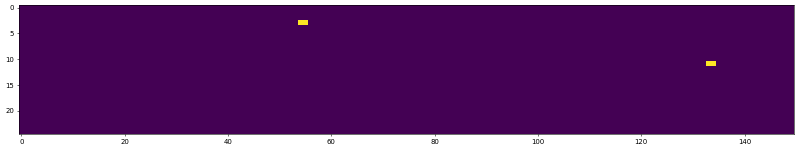

[77, 80, 82] {(149, 20), (124, 11), (126, 11), (148, 20), (125, 11)}


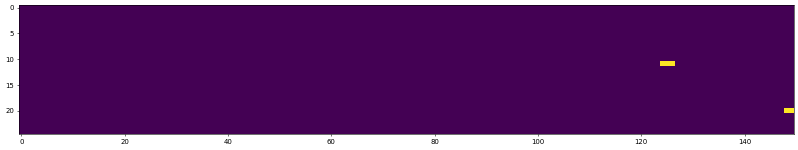

[90, 91, 94] {(9, 1), (31, 24), (8, 1)}


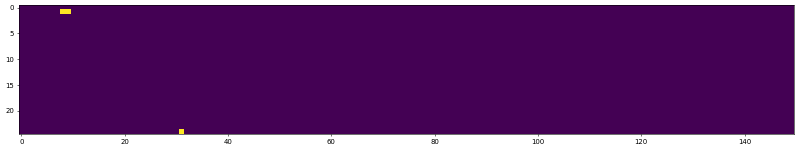

[110] {(99, 0)}


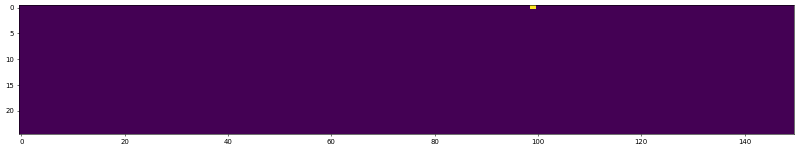

[190] {(112, 0), (113, 0)}


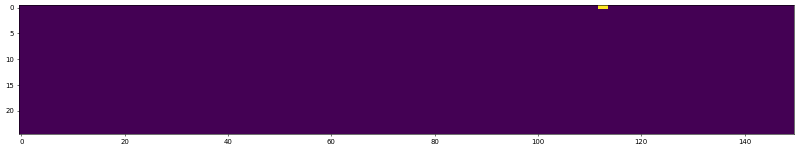

[353] {(9, 13)}


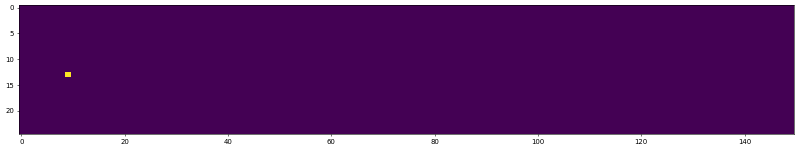

[374, 376] {(117, 7), (116, 7), (71, 10)}


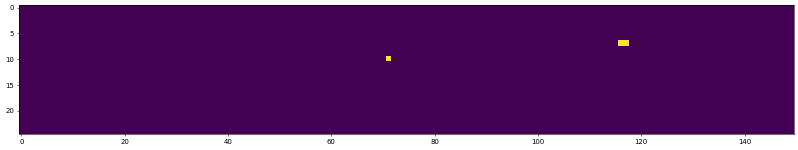

[416] {(149, 17)}


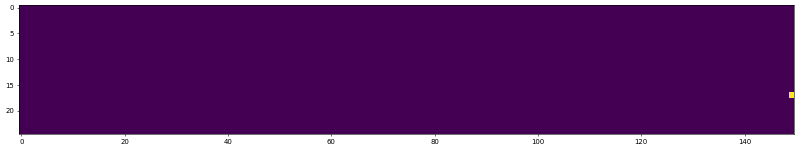

[504] {(98, 9)}


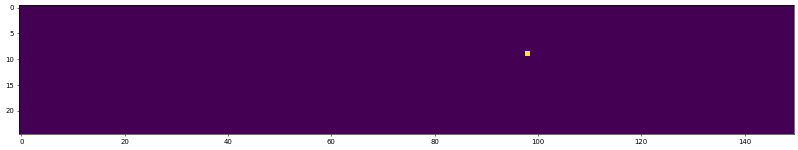

[517, 518, 520, 521, 522] {(81, 14), (138, 19), (94, 9), (139, 19), (95, 9), (93, 9)}


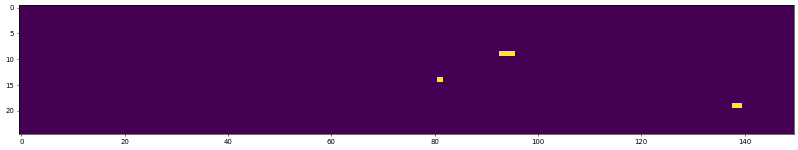

[558, 559] {(105, 12), (106, 12)}


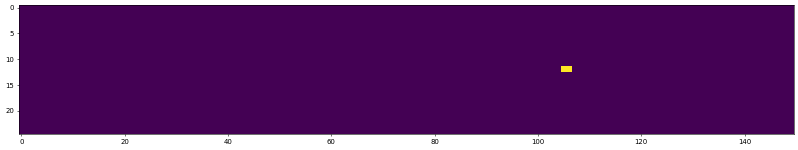

[674, 676] {(109, 17), (110, 17), (108, 17), (0, 17)}


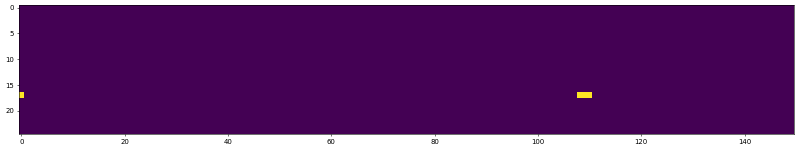

[680, 681] {(95, 19), (96, 19), (0, 17)}


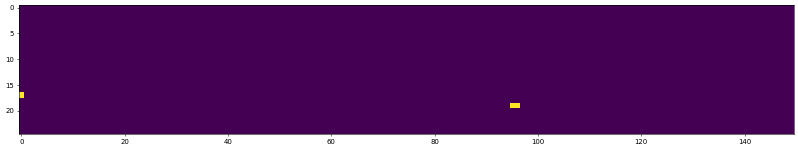

[695] {(79, 24), (80, 24)}


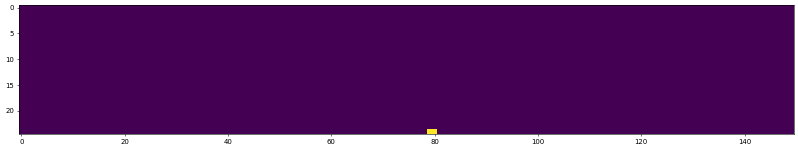

[721] {(149, 19)}


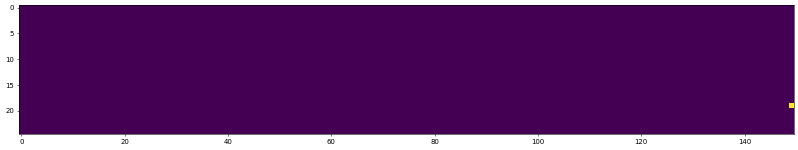

[770, 771] {(137, 6), (138, 6)}


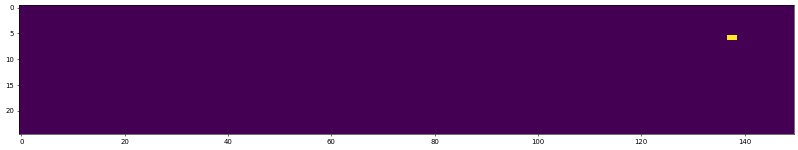

[786] {(67, 0), (68, 0)}


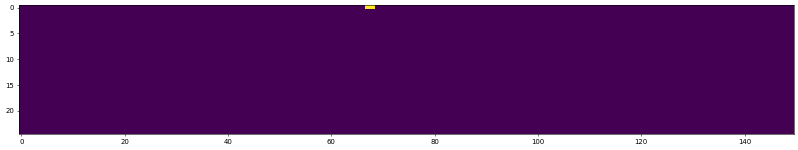

[802, 804, 807, 809] {(37, 22), (35, 22), (38, 22), (36, 22)}


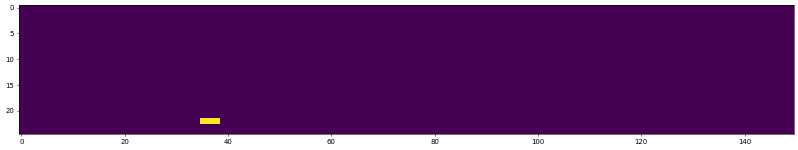

[820] {(106, 17)}


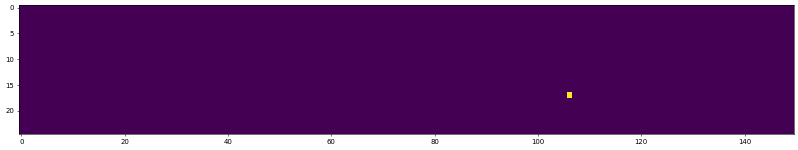

[832] {(109, 0), (110, 0), (111, 0), (112, 0)}


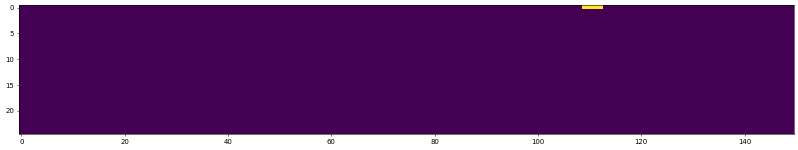

[870] {(110, 4)}


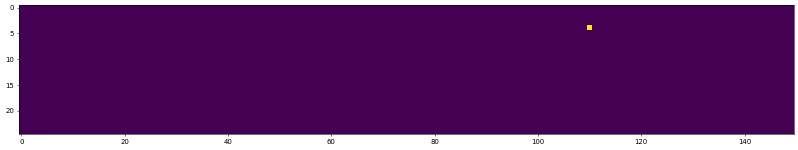

[1008] {(90, 1), (91, 1)}


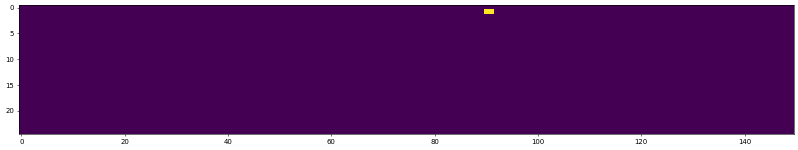

[1019, 1020, 1022, 1023, 1024] {(134, 12), (130, 12), (137, 12), (132, 12), (135, 12), (138, 12), (139, 12), (136, 12), (131, 12), (129, 12)}


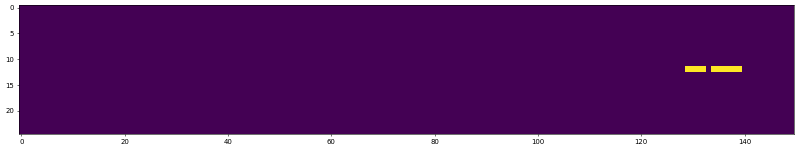

[1055, 1056, 1057] {(34, 21), (35, 21), (33, 21)}


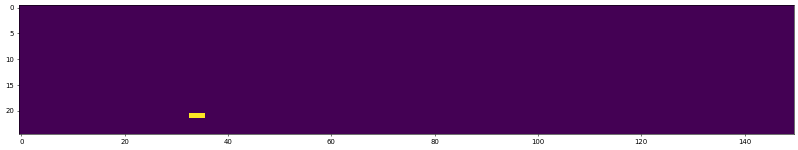

[1073, 1074, 1076, 1077, 1078, 1079] {(82, 17), (83, 17), (78, 17), (79, 17), (80, 17), (77, 17), (81, 17)}


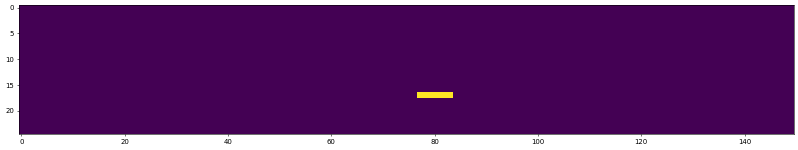

[1084, 1085, 1088, 1089, 1090] {(56, 6), (54, 6), (57, 6), (52, 6), (53, 6)}


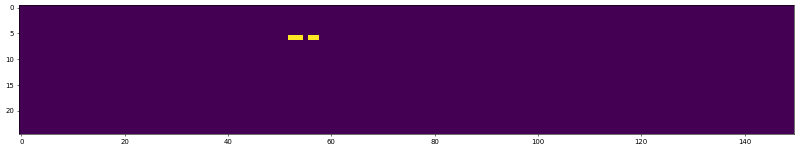

[1120] {(11, 18), (12, 18)}


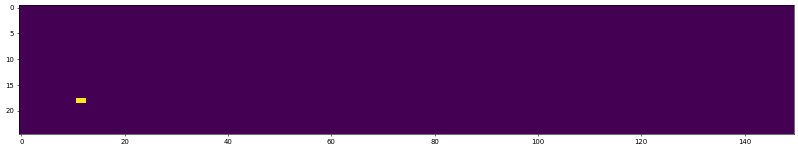

[1131, 1132, 1133, 1134, 1135, 1136, 1137] {(42, 16), (37, 16), (38, 16), (33, 16), (34, 16), (40, 16), (35, 16), (41, 16), (36, 16), (39, 16)}


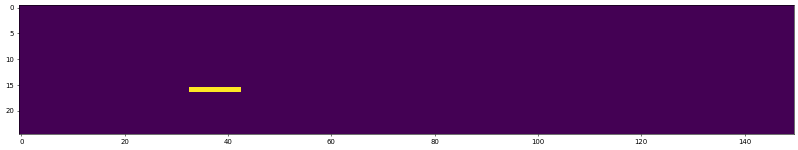

[1177] {(16, 8), (17, 8)}


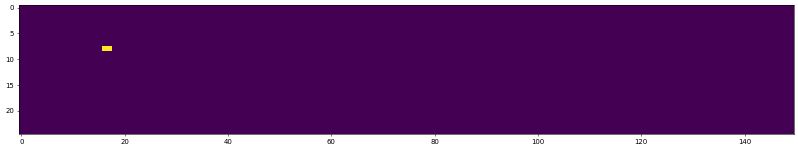

[1213, 1215] {(89, 16), (90, 16)}


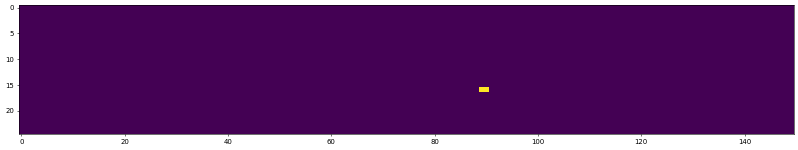

95 95 95
Muscle_map_150z25_60s_#34.npy
[39] {(69, 18), (70, 18)}


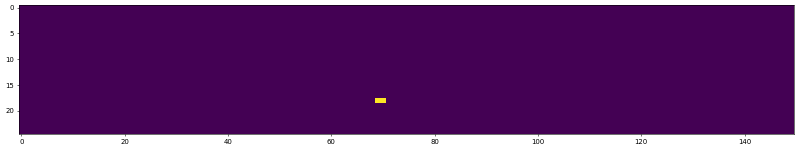

[103] {(136, 12), (137, 12)}


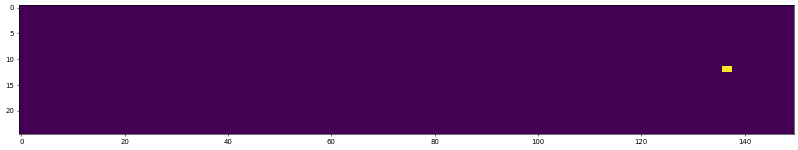

[150] {(116, 2)}


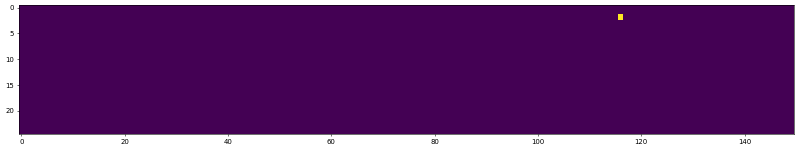

[161] {(8, 2)}


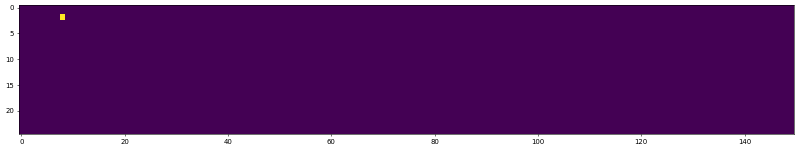

[176] {(102, 18)}


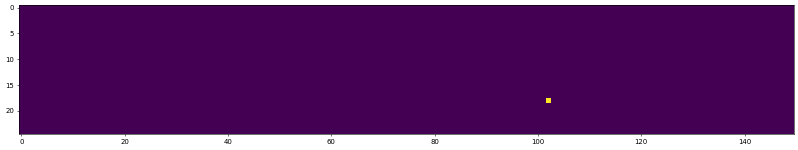

[186] {(104, 18)}


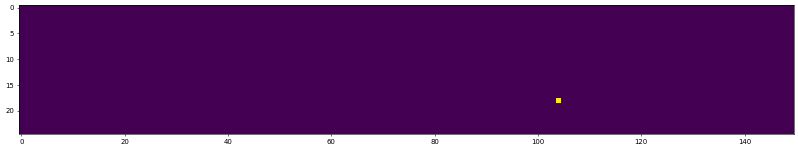

[190] {(105, 18)}


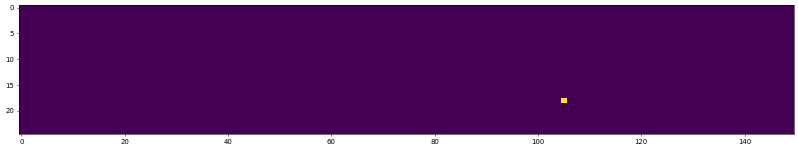

[194, 197] {(106, 18), (107, 18)}


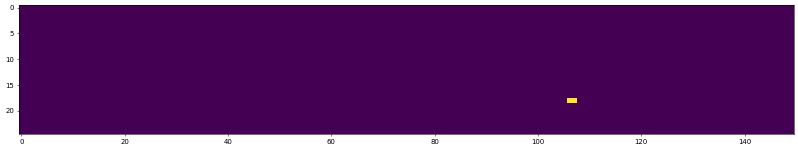

[201] {(108, 18)}


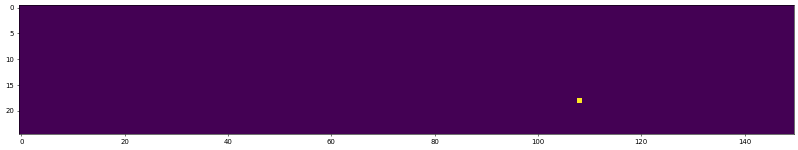

[213, 215] {(33, 3), (113, 18), (111, 18), (32, 3), (112, 18)}


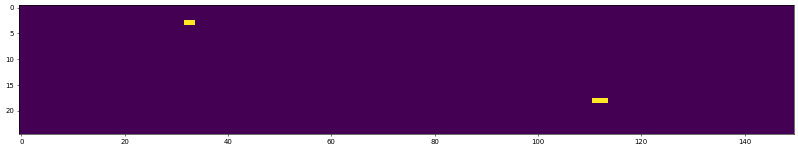

[243] {(124, 15)}


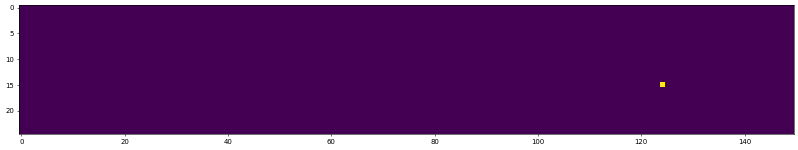

[249] {(122, 15)}


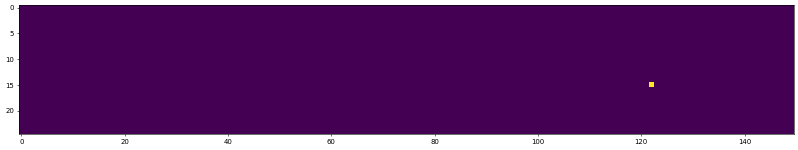

[266] {(112, 9)}


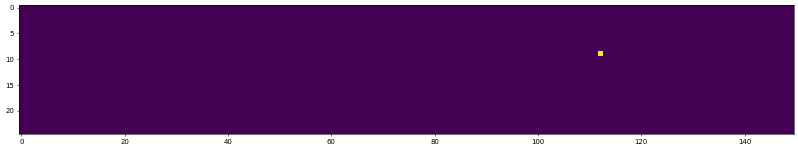

[292, 294, 295, 297] {(131, 6), (128, 6), (129, 6), (130, 6)}


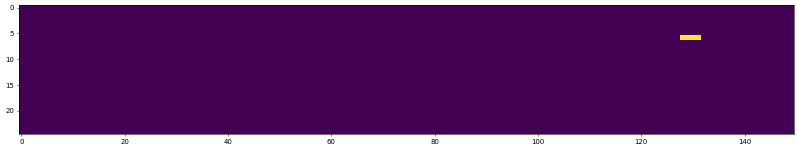

[373] {(50, 3)}


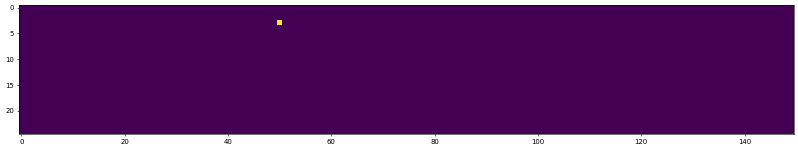

[377, 380] {(82, 10), (81, 10), (49, 3), (79, 10), (80, 10), (48, 3)}


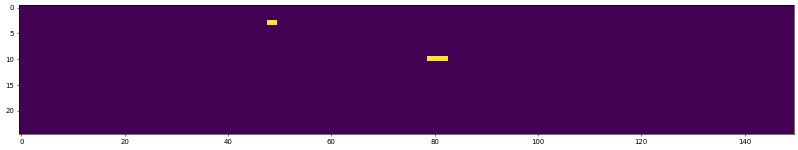

[386] {(55, 0)}


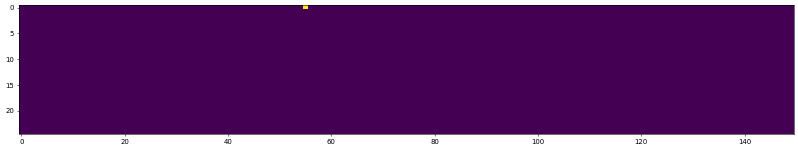

[393, 394] {(118, 10), (117, 10)}


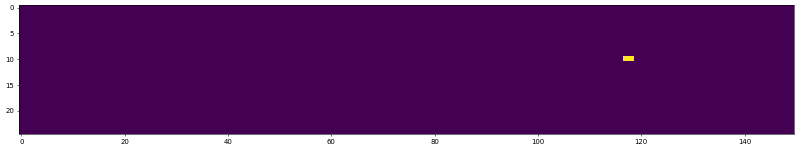

[433, 434, 437, 440, 443, 445, 446, 448] {(9, 10), (4, 10), (7, 10), (8, 10), (10, 10), (5, 10), (6, 10), (117, 2), (118, 2)}


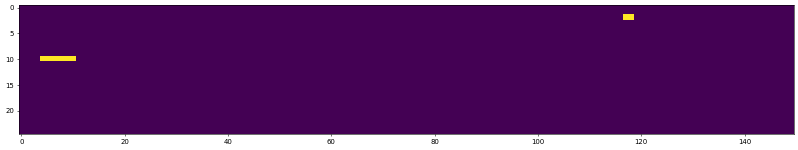

[453] {(2, 10)}


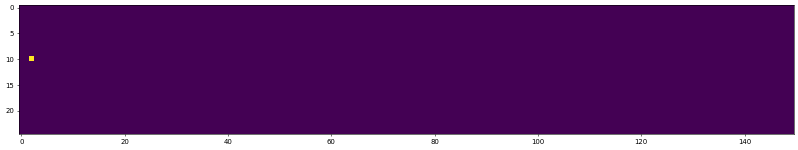

[468, 469, 470, 471, 472] {(57, 8), (55, 8), (64, 1), (65, 1), (56, 8), (54, 8), (53, 8)}


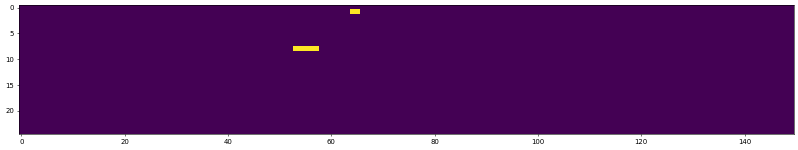

[483, 484] {(117, 12), (118, 12)}


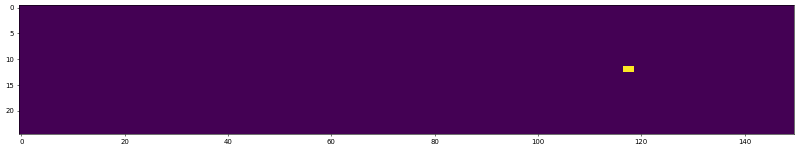

[527, 530] {(109, 1), (144, 20), (110, 1), (143, 20)}


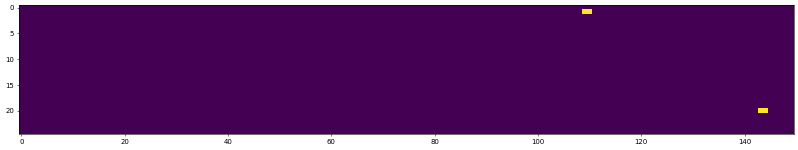

[562] {(59, 11), (60, 11)}


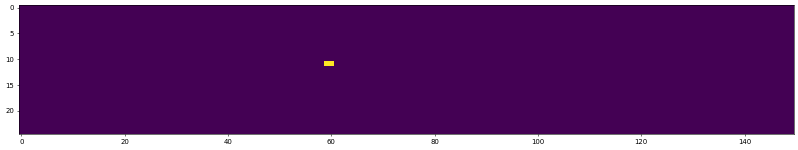

[614] {(111, 18)}


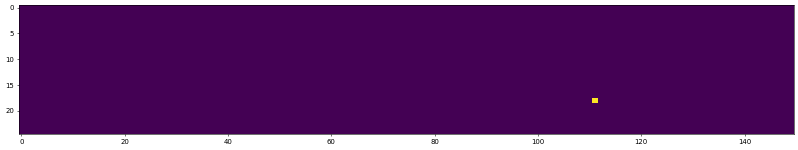

[633, 634, 636, 637, 638, 640, 642, 644] {(137, 17), (33, 16), (34, 16), (35, 16), (36, 16), (31, 16), (125, 18), (32, 16)}


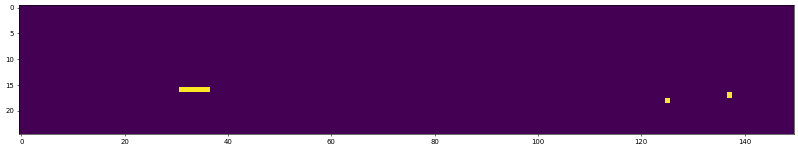

[656] {(106, 18), (107, 18)}


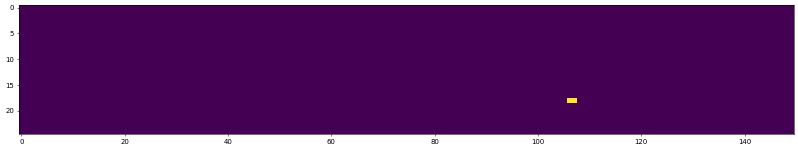

[665] {(128, 17), (131, 17), (129, 17), (130, 17)}


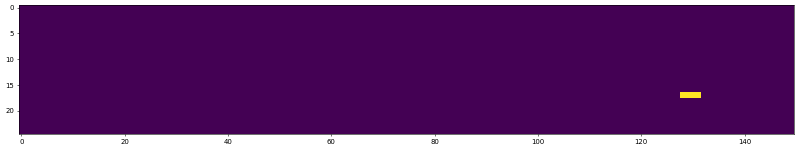

[676] {(131, 18)}


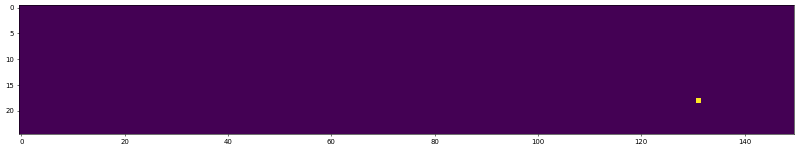

[706, 707, 709, 710, 711, 713] {(87, 6), (82, 6), (83, 6), (84, 6), (85, 6), (86, 6)}


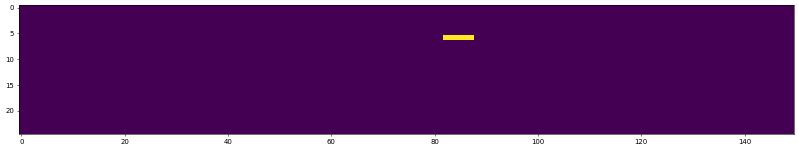

[771, 774, 775] {(4, 13), (2, 13), (3, 13), (1, 13), (79, 15), (78, 15)}


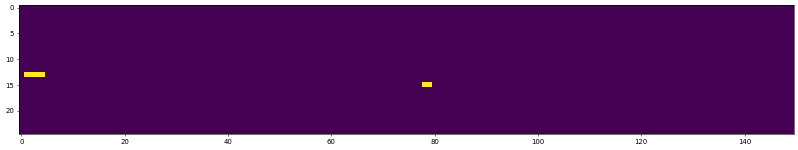

[799] {(9, 8), (10, 8)}


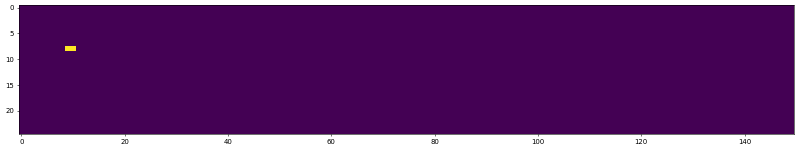

[824] {(75, 14), (74, 14)}


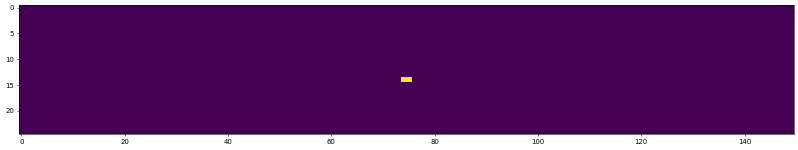

[832, 833] {(94, 9), (95, 9), (93, 9), (96, 9)}


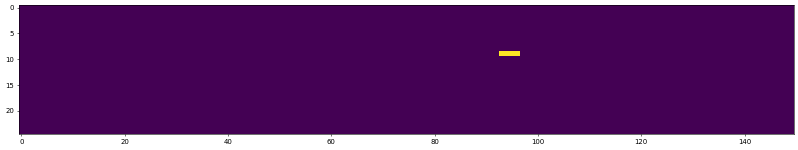

[839] {(142, 23)}


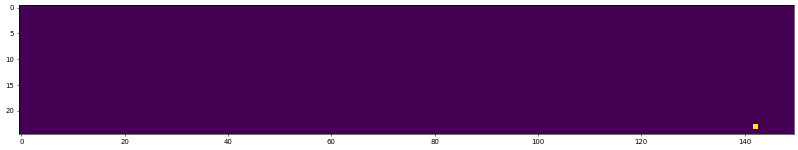

[853, 856] {(146, 23), (148, 23), (149, 23), (147, 23)}


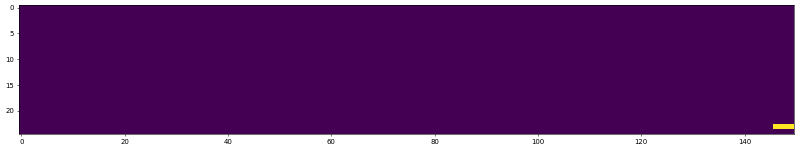

[862, 863] {(115, 19), (116, 19), (117, 19), (118, 19), (68, 21)}


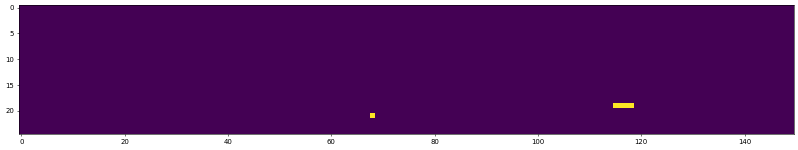

[970] {(125, 13), (124, 13)}


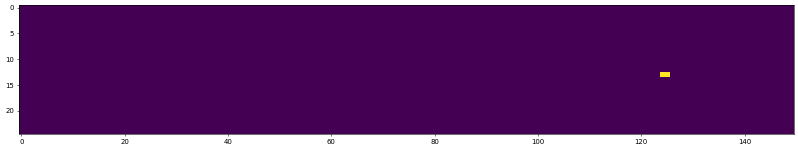

[988, 991] {(96, 5), (51, 6)}


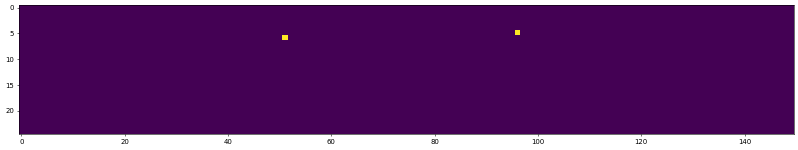

[1033] {(90, 3)}


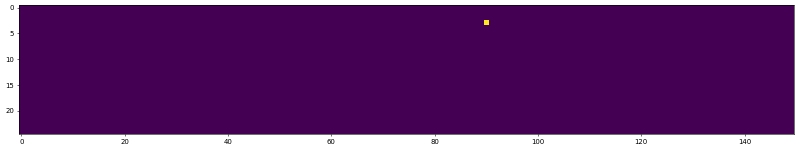

[1056] {(101, 22)}


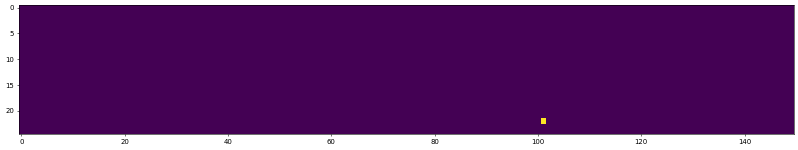

[1107] {(50, 10)}


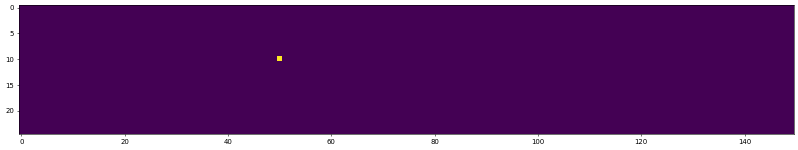

[1113] {(136, 2)}


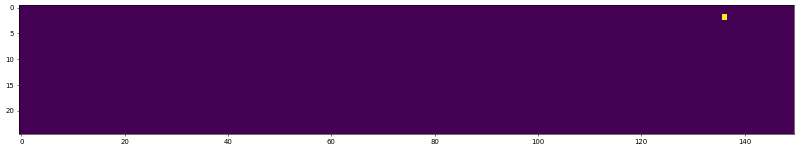

[1117] {(136, 2)}


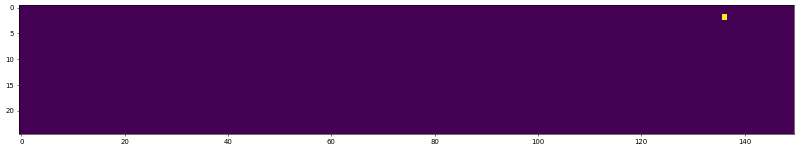

[1123] {(136, 2)}


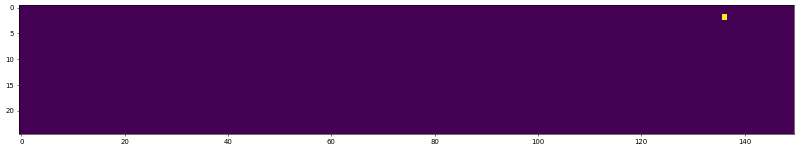

[1144] {(73, 21), (72, 21)}


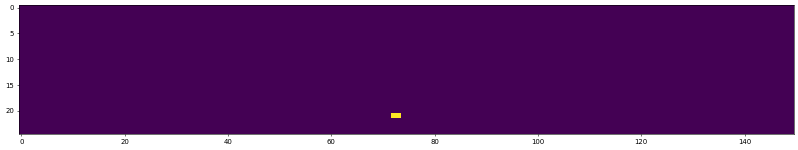

[1152] {(35, 8)}


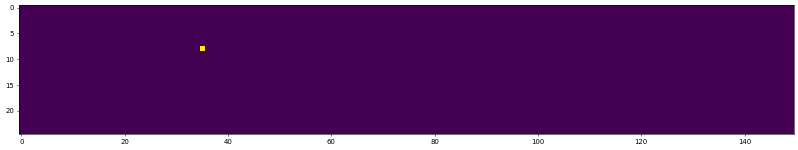

[1160] {(51, 16)}


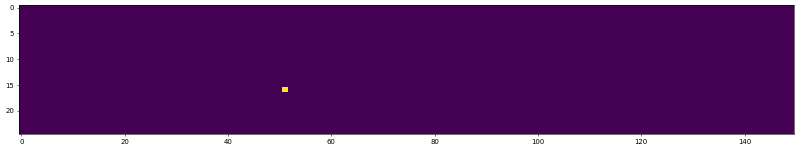

[1204] {(27, 4)}


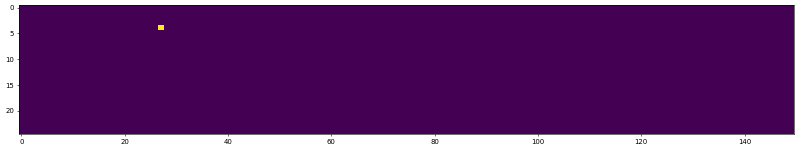

[1223, 1224] {(6, 1), (7, 1), (8, 1)}


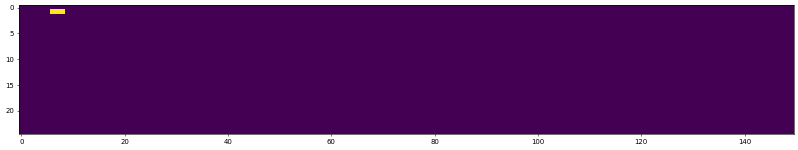

[1246] {(145, 5), (146, 5)}


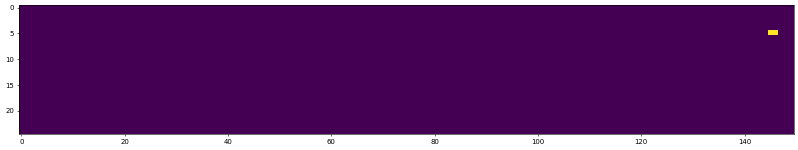

120 120 120
Kidney_map_150z25_60s_#45.npy
[84] {(28, 21)}


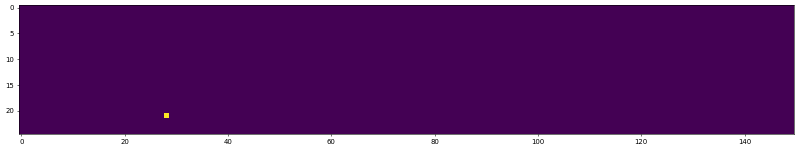

[148, 149] {(47, 24), (106, 20), (107, 20)}


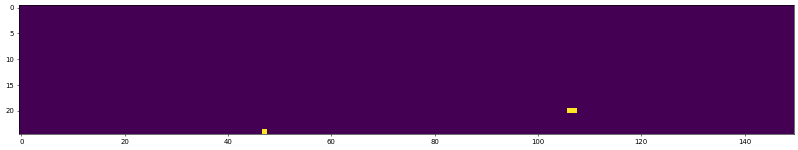

[159, 160, 161] {(75, 10), (73, 10), (74, 10)}


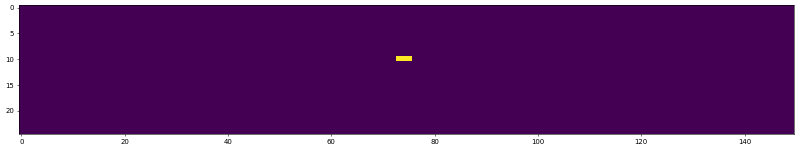

[292] {(102, 20)}


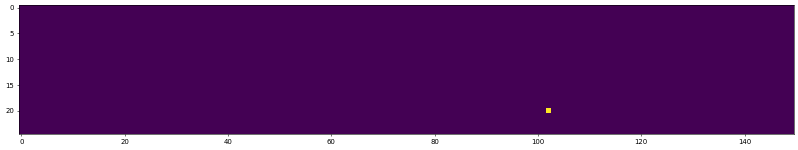

[332] {(143, 22)}


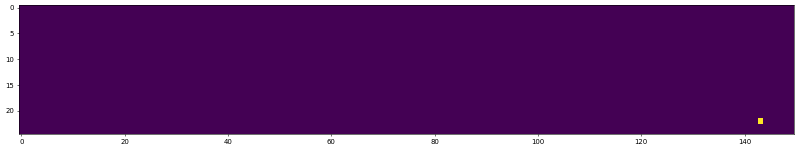

[361] {(113, 21)}


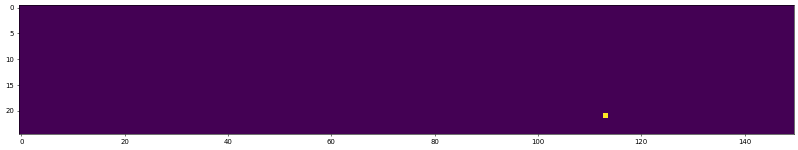

[369, 370, 372] {(116, 21), (65, 21), (117, 21)}


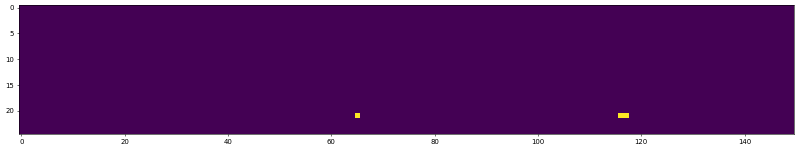

[471] {(145, 11), (146, 11)}


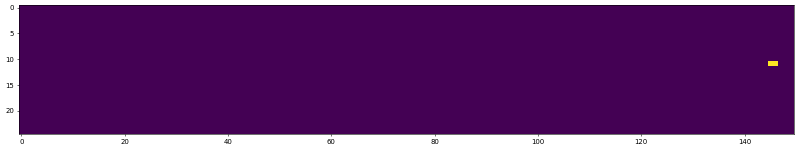

[528] {(108, 13), (109, 13)}


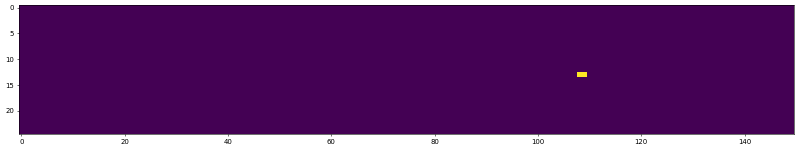

[532, 534, 535] {(103, 9), (104, 9), (102, 9)}


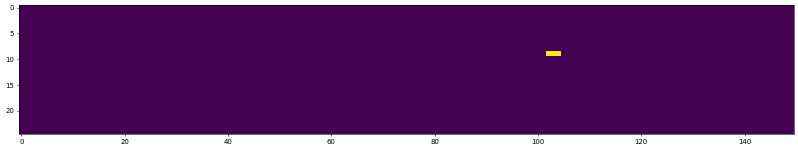

[540] {(49, 22)}


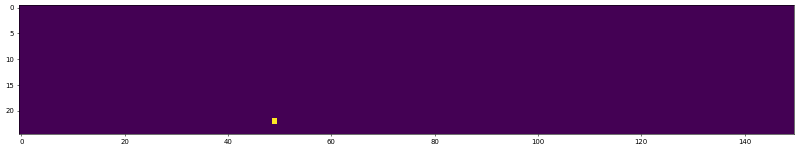

[563, 564] {(146, 19), (147, 19), (148, 19)}


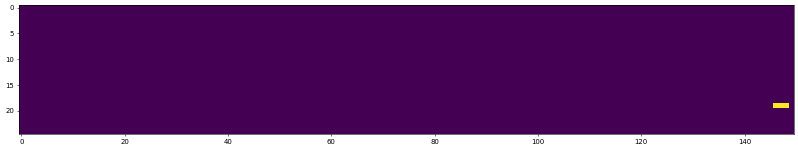

[569, 570, 573, 574] {(81, 8), (79, 8), (80, 8), (78, 8)}


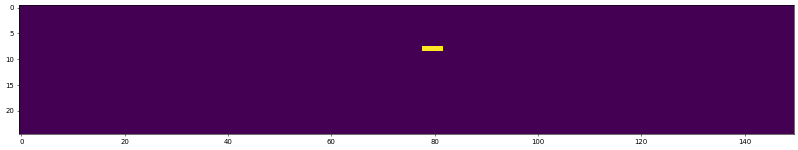

[584] {(61, 22), (62, 22)}


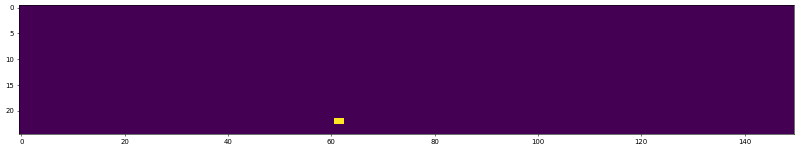

[590] {(61, 22), (62, 22)}


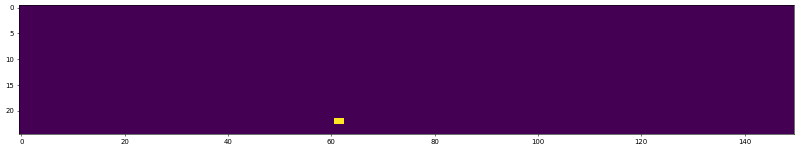

[636, 637, 638] {(66, 1), (67, 1), (65, 1)}


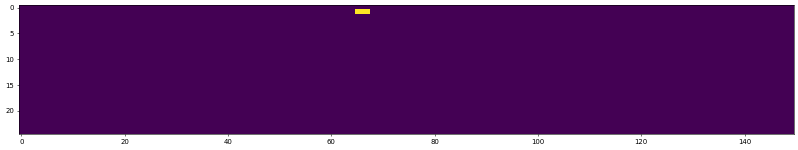

[645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 659, 660, 662, 664, 666, 667, 670, 671, 672] {(81, 21), (134, 0), (125, 0), (127, 0), (138, 0), (140, 0), (129, 0), (92, 21), (90, 21), (131, 0), (83, 21), (85, 21), (133, 0), (124, 0), (135, 0), (87, 21), (78, 21), (89, 21), (80, 21), (118, 5), (91, 21), (93, 21), (137, 0), (139, 0), (128, 0), (82, 21), (84, 21), (86, 21), (130, 0), (132, 0), (136, 0), (88, 21), (119, 5), (79, 21), (39, 15)}


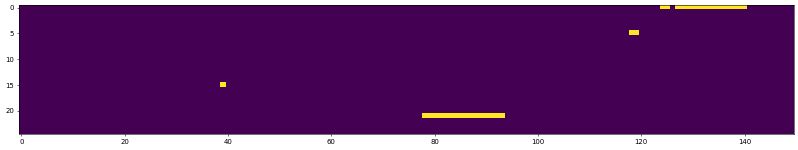

[681] {(112, 0), (111, 0)}


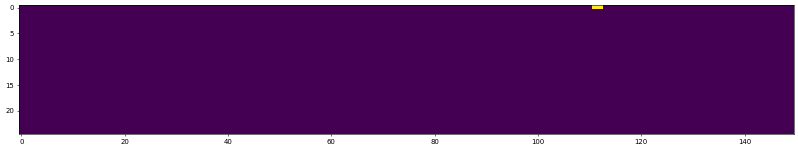

[752, 755] {(56, 22), (125, 19), (124, 19)}


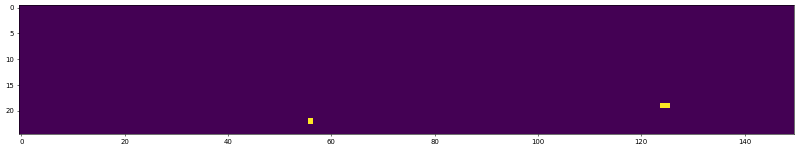

[805, 807] {(128, 17), (129, 17)}


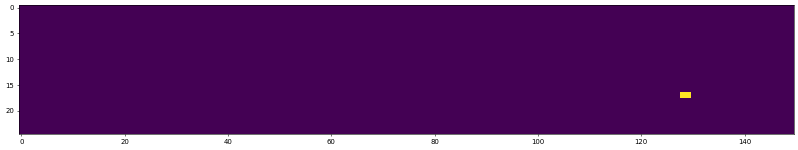

[811, 812] {(31, 5), (126, 17), (32, 5), (127, 17)}


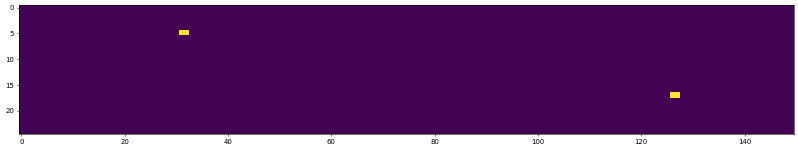

[818, 819] {(83, 4), (86, 4), (84, 4), (85, 4)}


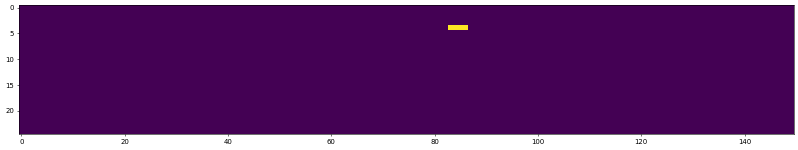

[825] {(75, 4)}


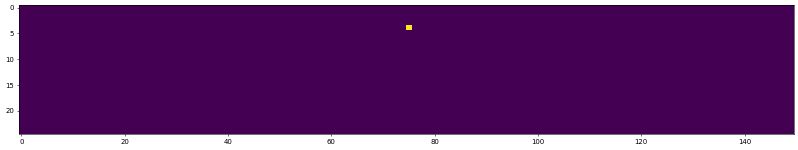

[830, 833, 835] {(95, 19), (78, 4), (77, 4)}


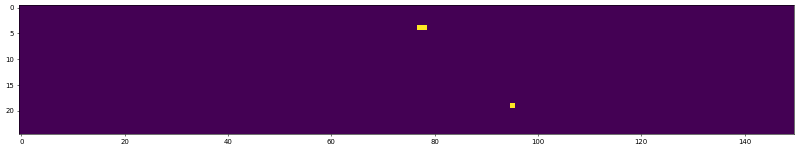

[849, 851, 852, 853] {(113, 19), (71, 22), (111, 19), (112, 19), (114, 19), (72, 22)}


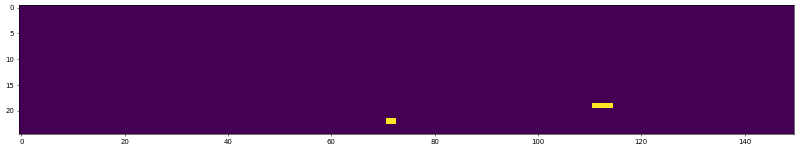

[886, 887, 888] {(42, 10), (43, 10), (44, 10)}


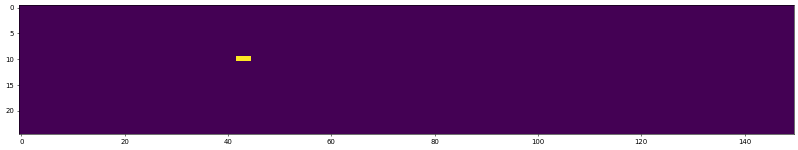

[919, 920, 921, 922, 923, 924] {(125, 16), (121, 16), (127, 16), (128, 16), (123, 16), (124, 16), (126, 16), (122, 16)}


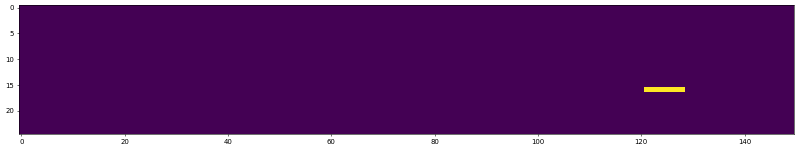

[944] {(149, 16)}


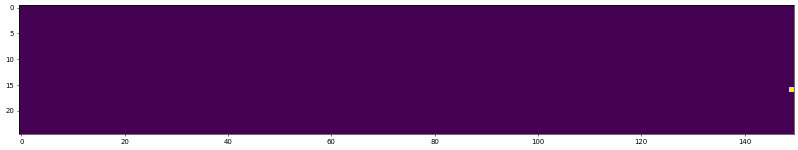

[952, 953, 954, 956, 957] {(115, 22), (33, 2), (34, 2), (31, 2), (32, 2)}


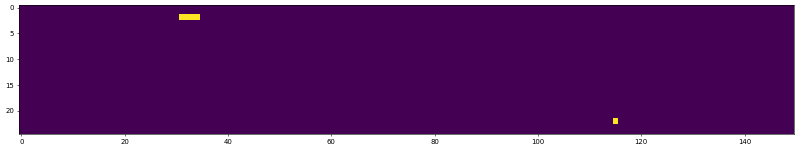

[1001] {(110, 6)}


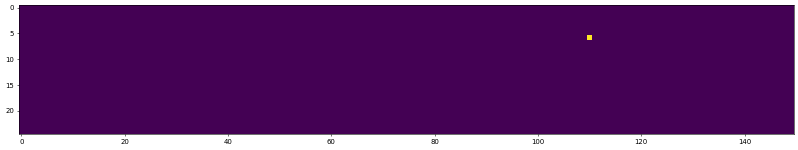

[1010, 1011, 1012] {(20, 16), (21, 16), (22, 16)}


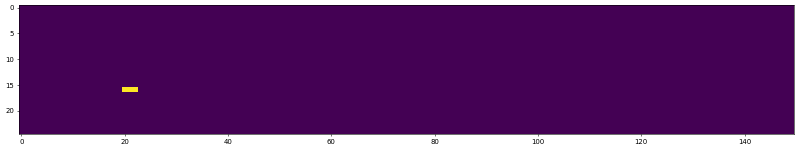

[1019, 1020] {(106, 1), (109, 1), (107, 1), (108, 1)}


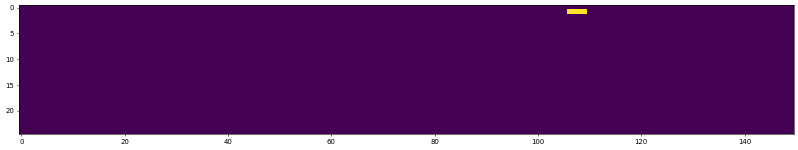

[1034, 1037] {(24, 4), (52, 9), (53, 9)}


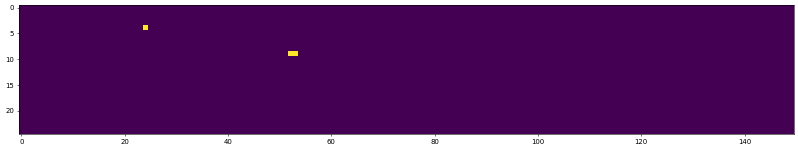

[1045, 1046, 1047] {(130, 3), (72, 24), (131, 3), (70, 24), (71, 24)}


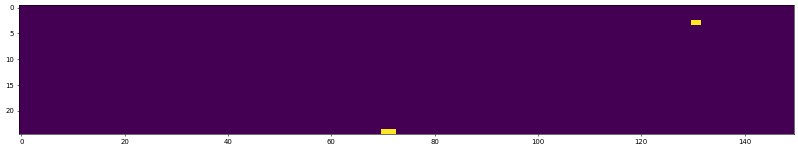

[1061] {(60, 8)}


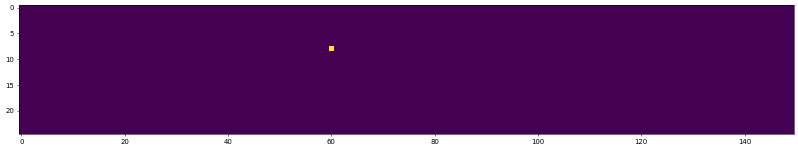

[1079] {(58, 17)}


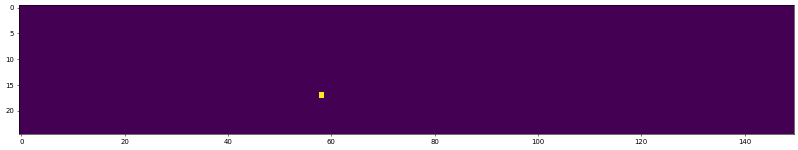

[1158, 1159] {(57, 8), (56, 8)}


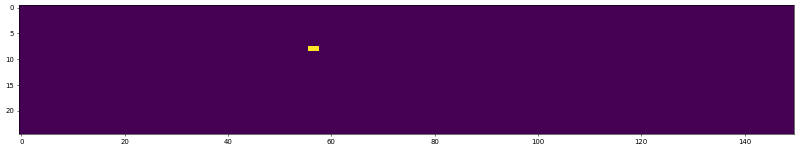

[1164] {(14, 18)}


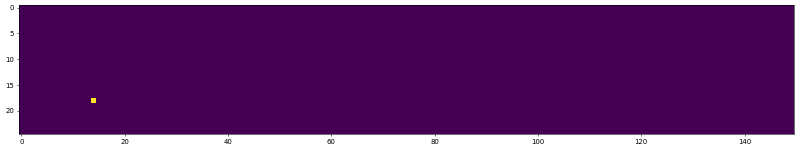

[1193] {(14, 18)}


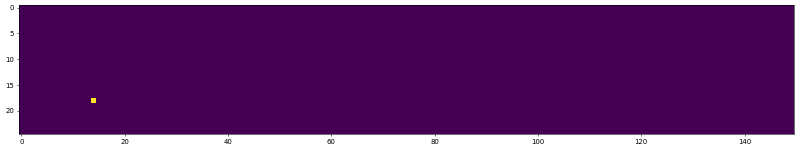

[1198] {(59, 23)}


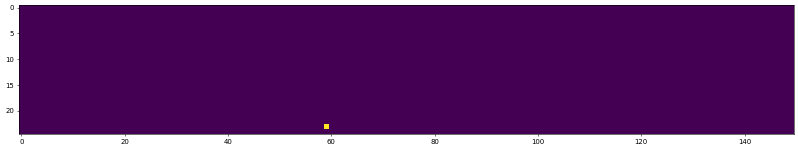

[1204, 1205] {(126, 22), (125, 22)}


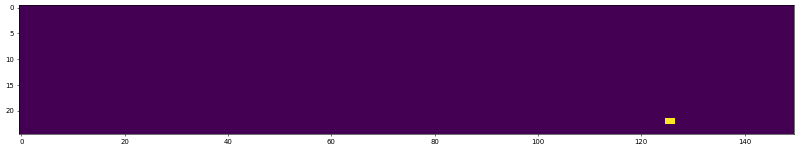

[1221] {(104, 16)}


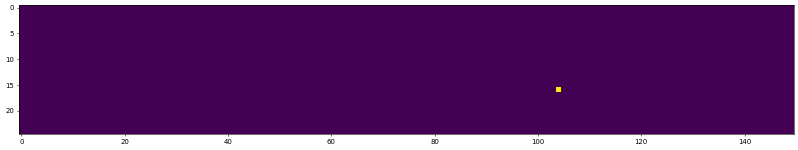

137 137 137
Kidney_map_150z25_60s_#43.npy
[31, 32, 34] {(65, 3), (74, 13), (66, 3), (138, 12)}


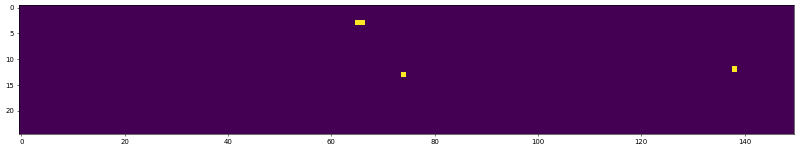

[76, 78] {(78, 11), (79, 11)}


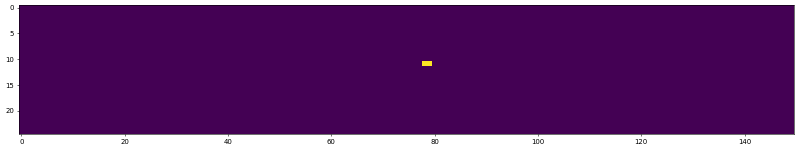

[114, 115] {(52, 18), (53, 18)}


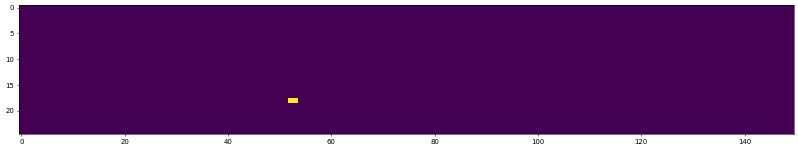

[138, 140] {(45, 0), (46, 0)}


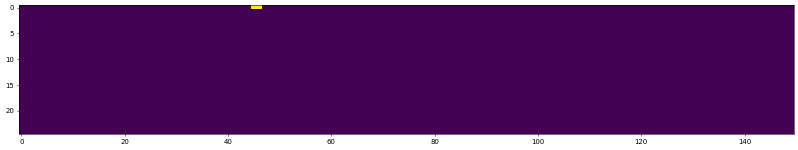

[165, 168] {(39, 0), (59, 1)}


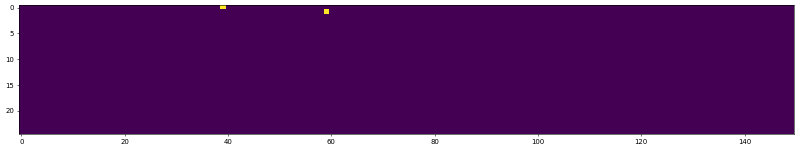

[185] {(0, 1)}


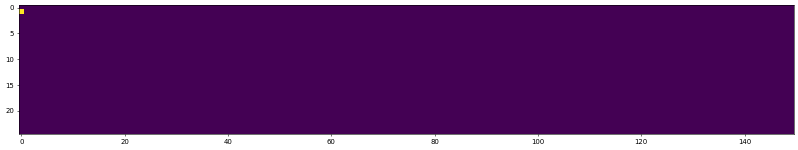

[292, 294] {(60, 15), (61, 15)}


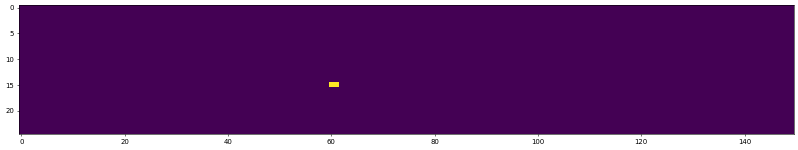

[307, 308, 309, 311] {(103, 13), (104, 13), (102, 13), (105, 13)}


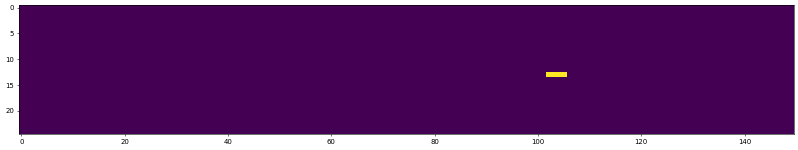

[322] {(28, 20)}


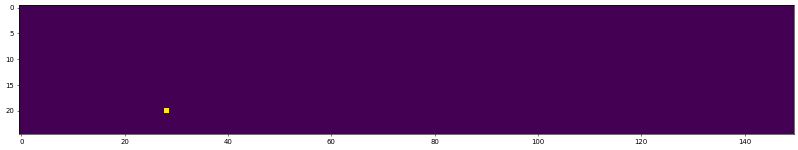

[363] {(81, 20)}


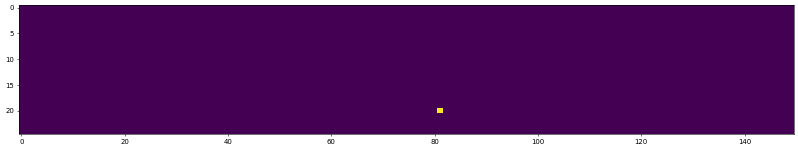

[413] {(98, 2), (97, 2)}


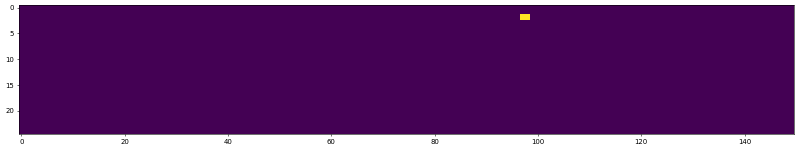

[419, 420] {(61, 16), (62, 16)}


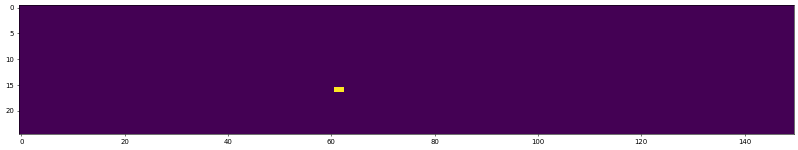

[468] {(56, 10), (57, 10)}


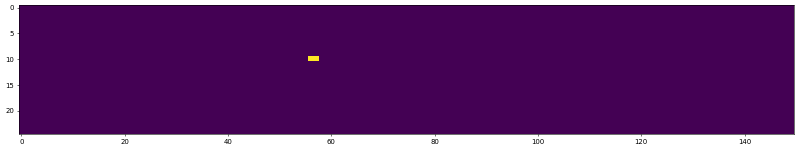

[507] {(108, 12)}


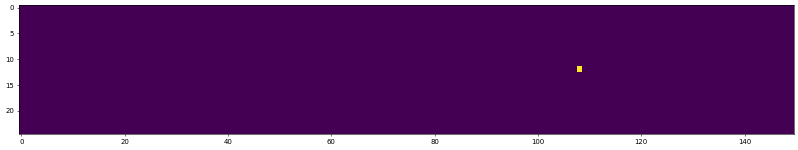

[511] {(109, 12)}


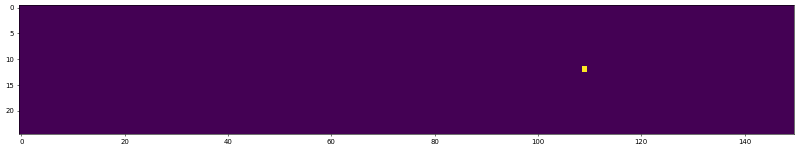

[515] {(110, 12)}


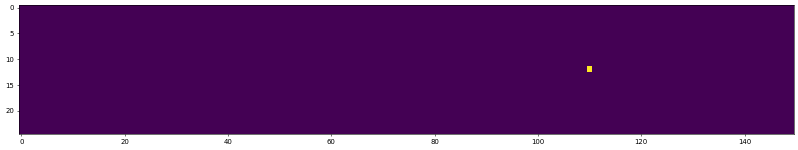

[521] {(101, 21)}


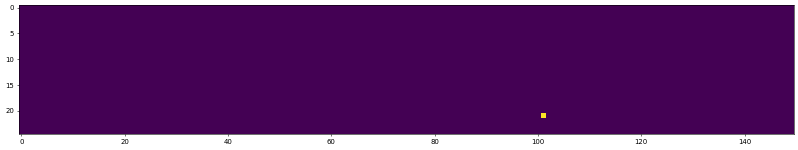

[541] {(54, 12)}


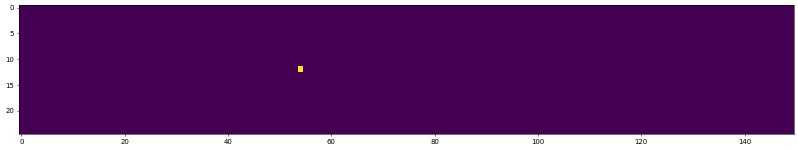

[561] {(63, 14)}


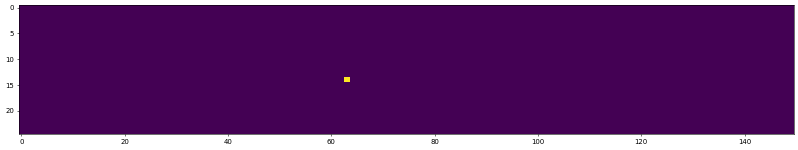

[568] {(66, 16), (67, 16)}


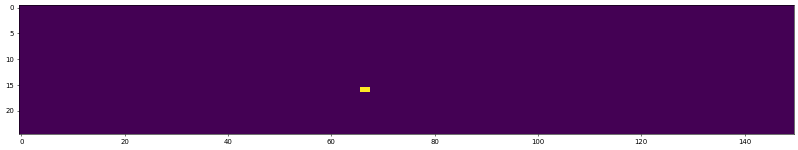

[577] {(98, 16)}


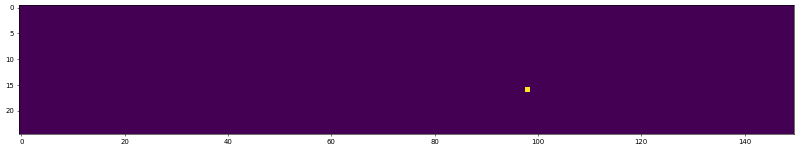

[584] {(98, 16)}


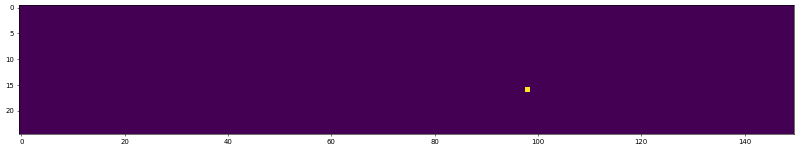

[592] {(76, 15)}


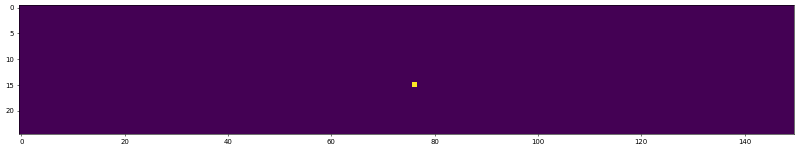

[596, 598, 600, 601] {(39, 18), (116, 17), (117, 17), (38, 18), (37, 18)}


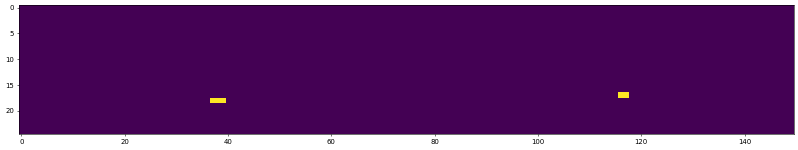

[620] {(88, 13)}


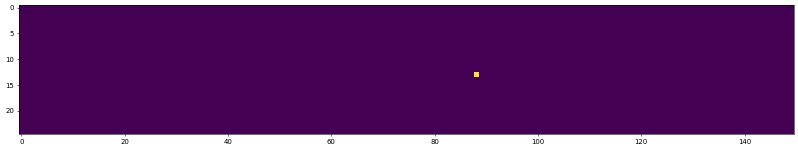

[624, 625] {(101, 17), (102, 17), (130, 18), (76, 3), (77, 3), (129, 18)}


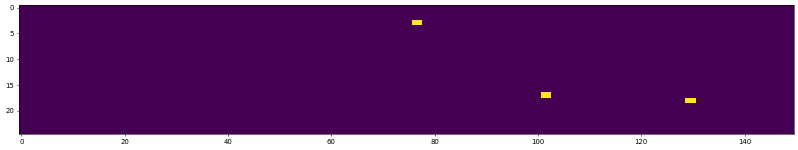

[680] {(34, 8)}


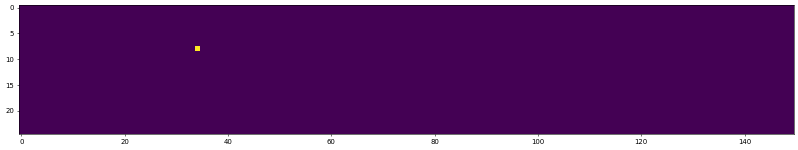

[688] {(93, 15)}


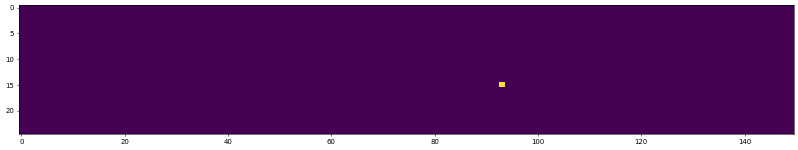

[723] {(81, 16)}


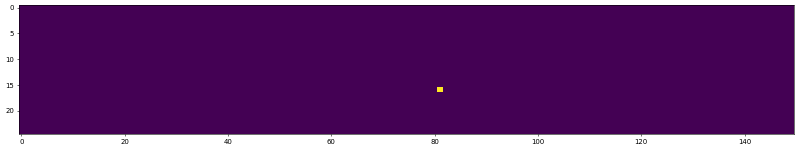

[779] {(42, 10)}


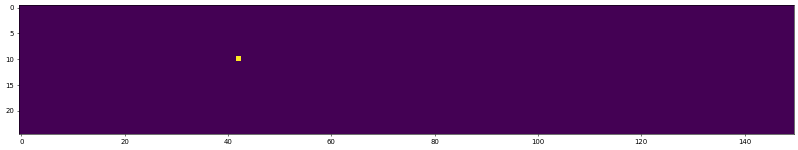

[788] {(71, 3), (72, 3)}


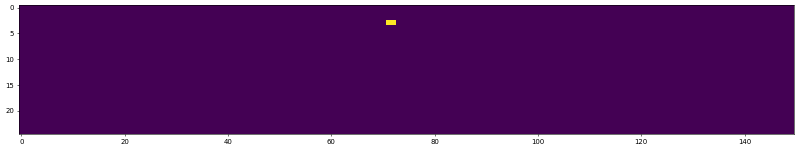

[792, 793] {(149, 24), (148, 24)}


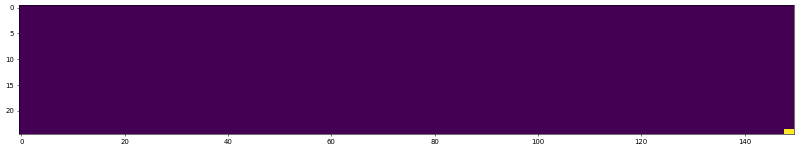

[804, 805] {(148, 6), (149, 6), (147, 6)}


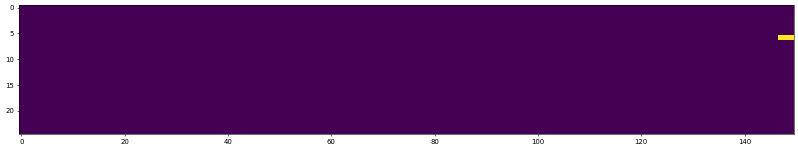

[825, 826, 827] {(24, 8), (25, 8), (111, 5), (26, 8)}


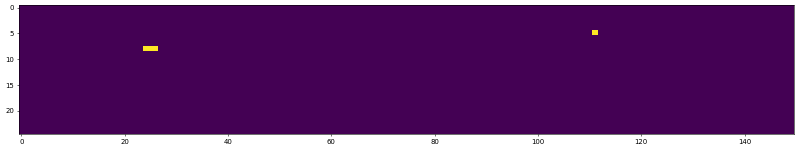

[868, 869, 871, 872] {(149, 9), (144, 20), (141, 22), (143, 20)}


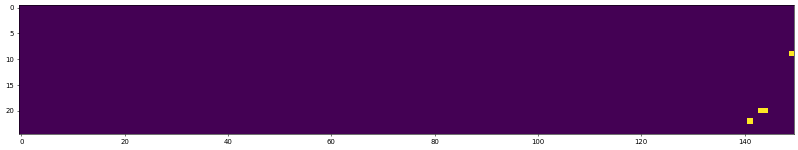

[877] {(142, 20)}


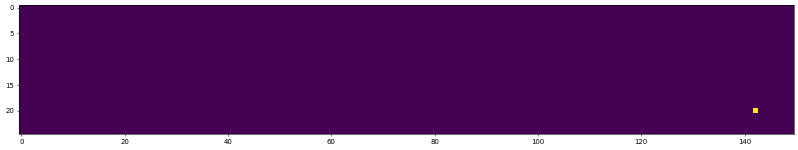

[891, 892, 894, 897] {(142, 17), (113, 12), (125, 12), (124, 12), (114, 12)}


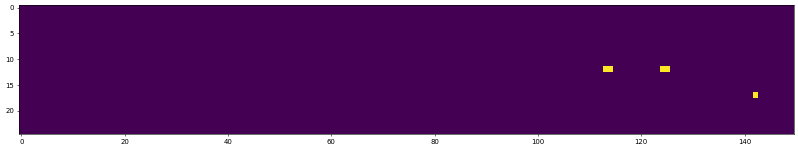

[925, 926] {(126, 11), (127, 11)}


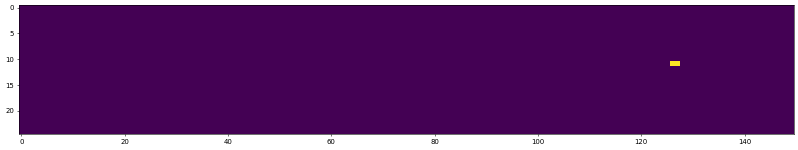

[930, 932, 934, 936, 938, 940, 942, 944, 946, 947, 949, 952, 953, 954, 955, 956] {(129, 11), (135, 11), (65, 21), (139, 11), (136, 11), (131, 11), (140, 11), (141, 11), (66, 22), (134, 11), (65, 22), (130, 11), (66, 21), (137, 11), (132, 11), (138, 11), (133, 11), (128, 11)}


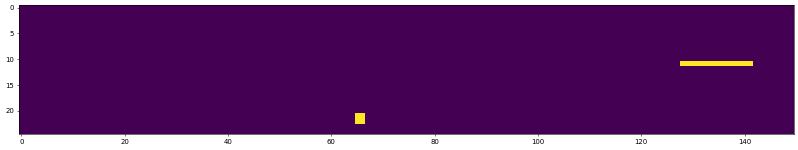

[960, 963, 964, 967, 969, 972, 973, 974] {(145, 11), (102, 5), (147, 11), (148, 11), (143, 11), (146, 11), (149, 11), (144, 11)}


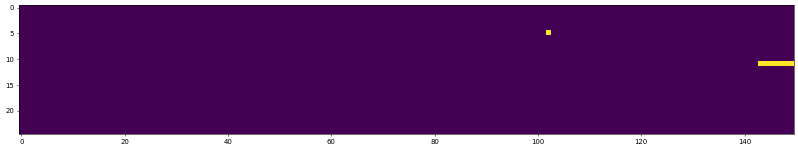

[992] {(61, 5)}


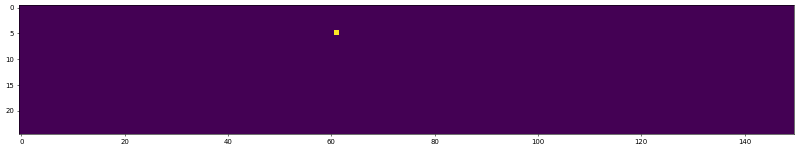

[996, 997, 999, 1001, 1004, 1005] {(50, 23), (76, 20), (77, 20), (51, 23), (61, 5), (62, 5)}


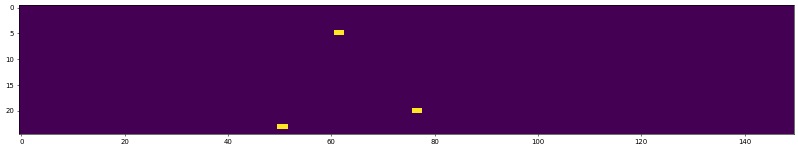

[1022] {(63, 5)}


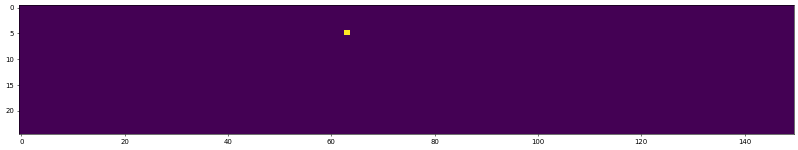

[1028, 1029, 1030] {(125, 8), (126, 8), (124, 8)}


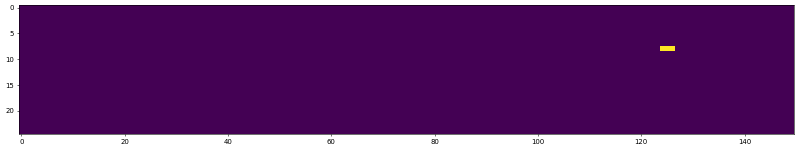

[1053, 1056, 1057] {(130, 13), (125, 13), (127, 13), (128, 13), (123, 13), (129, 13), (124, 13), (126, 13), (122, 13)}


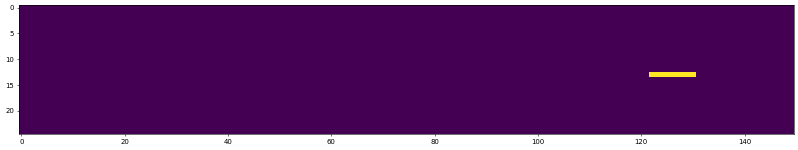

[1061] {(123, 13), (124, 13), (122, 13)}


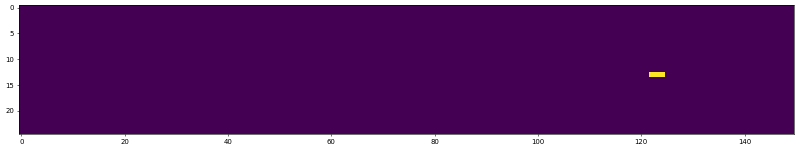

[1065, 1068] {(82, 11), (99, 12), (81, 11)}


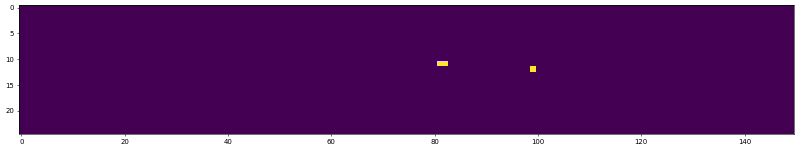

[1085] {(110, 7), (111, 7)}


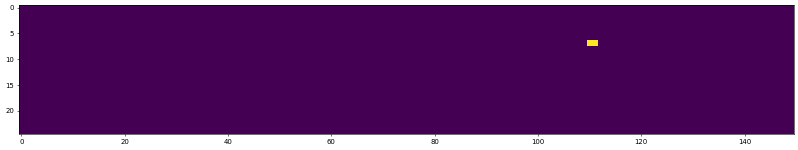

[1097] {(54, 21), (55, 21)}


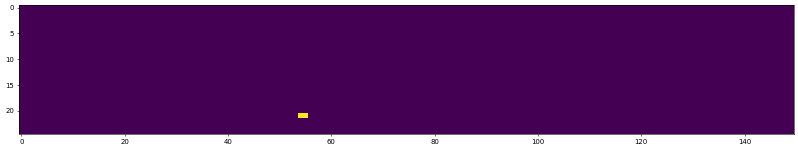

[1137, 1138, 1139, 1140] {(10, 21), (9, 21), (37, 21), (11, 21), (12, 21), (7, 21), (8, 21), (36, 21)}


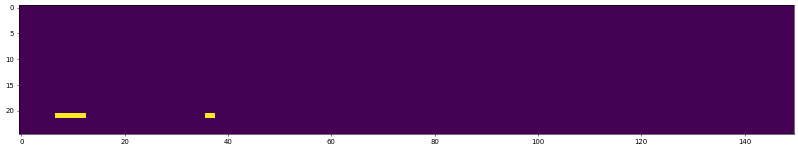

[1190, 1191, 1192] {(9, 13), (7, 13), (10, 13), (8, 13), (6, 13), (73, 15), (72, 15)}


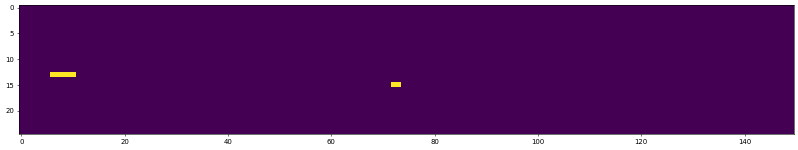

[1222] {(3, 9)}


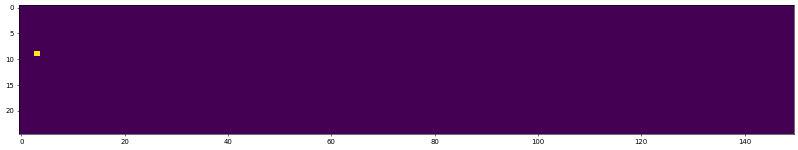

[1227, 1228, 1229, 1231] {(92, 19), (13, 10), (91, 19), (14, 10)}


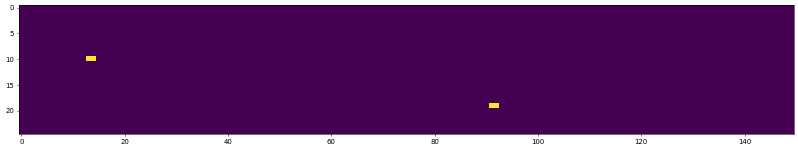

159 159 159
Liver_map_150x25_60s_#13.npy
[40] {(74, 10)}


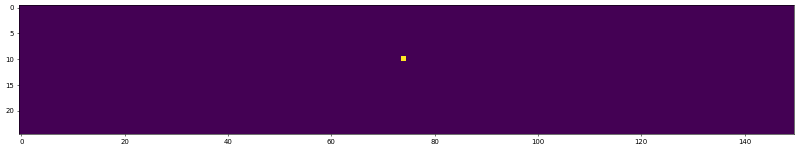

[48] {(54, 15)}


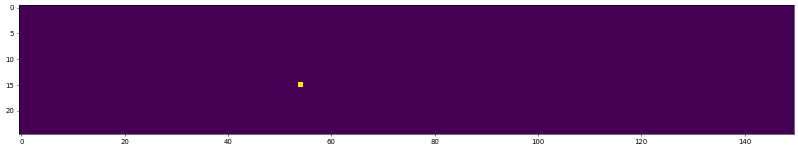

[78] {(114, 2)}


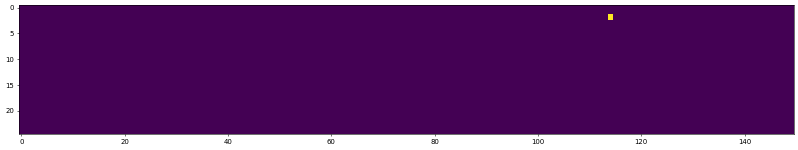

[133] {(100, 2)}


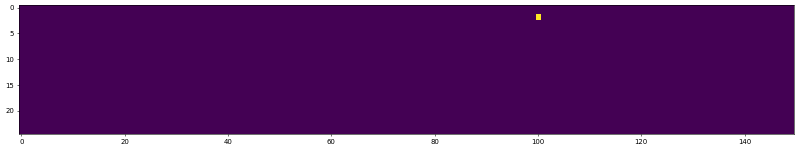

[182] {(92, 5)}


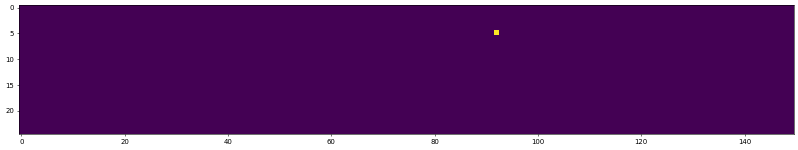

[189] {(96, 5), (97, 5), (95, 5)}


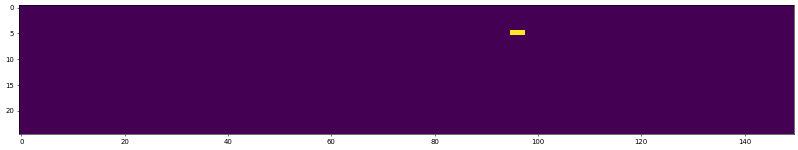

[211, 213] {(20, 11), (21, 11)}


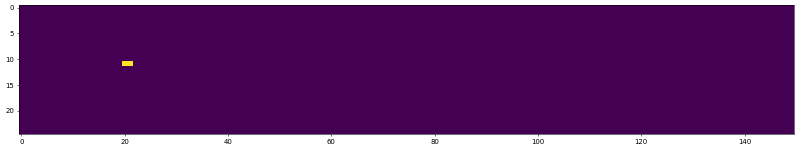

[227] {(94, 12)}


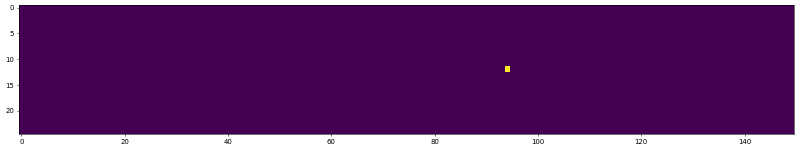

[241] {(22, 3)}


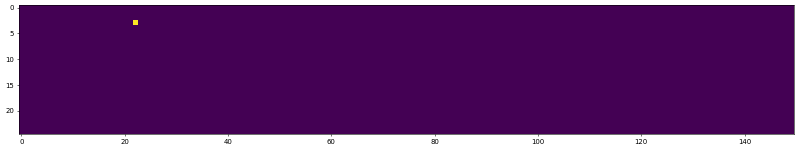

[249, 250] {(100, 6), (25, 3), (26, 3)}


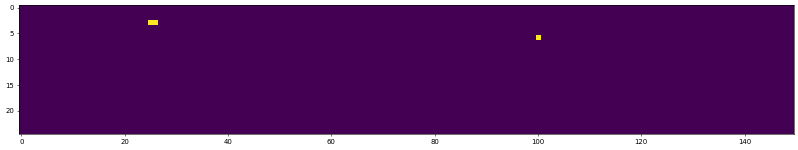

[288] {(71, 9)}


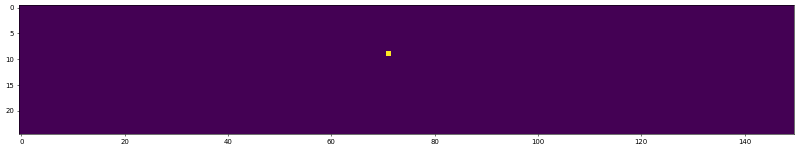

[292, 293] {(135, 0), (136, 0)}


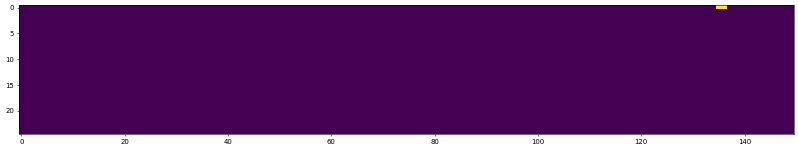

[319] {(110, 18)}


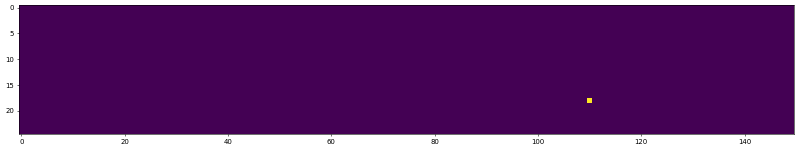

[325, 328, 329] {(103, 19), (111, 18)}


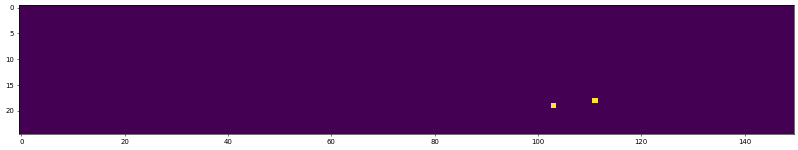

[335] {(110, 18)}


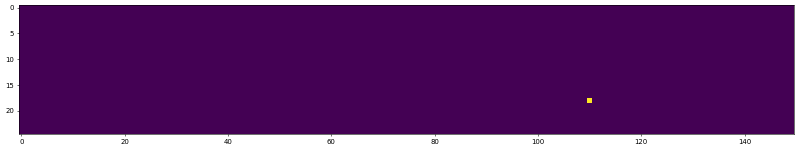

[340, 342, 345, 346, 348] {(108, 18), (109, 18), (104, 18), (105, 18), (106, 18)}


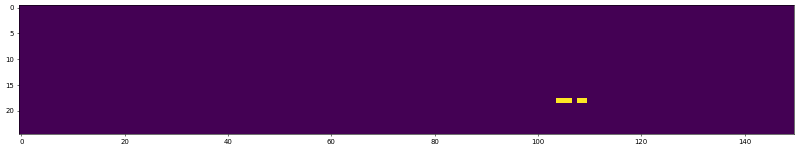

[363] {(76, 9)}


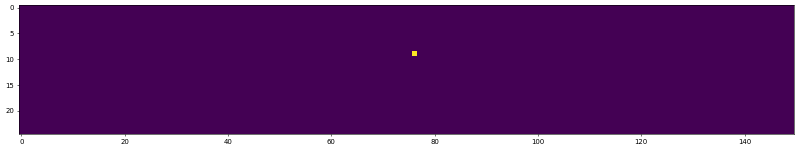

[386, 387] {(61, 10), (49, 24), (60, 10)}


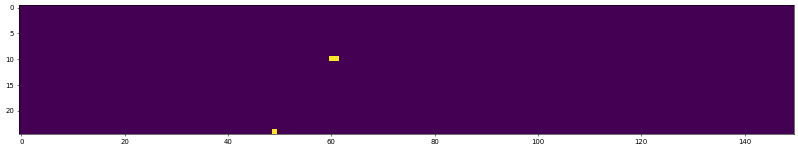

[408] {(86, 24)}


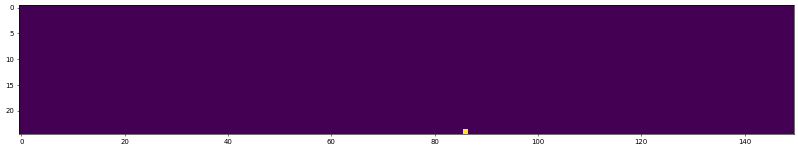

[426] {(77, 19)}


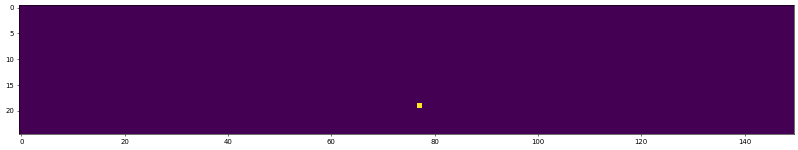

[574, 576] {(63, 7), (64, 7)}


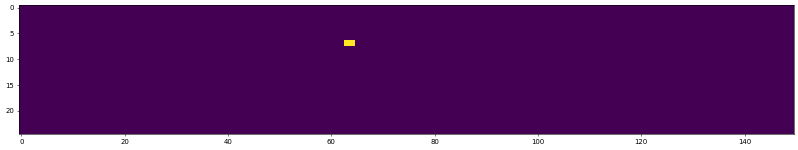

[584] {(64, 7)}


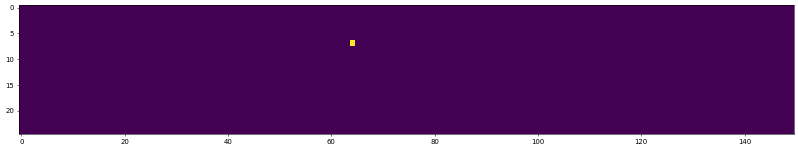

[656] {(104, 3)}


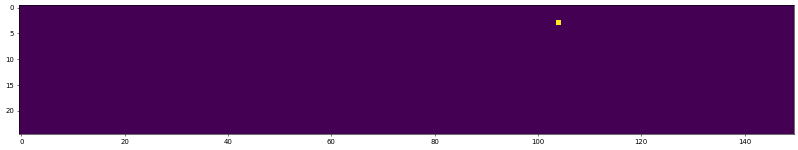

[667] {(118, 17), (119, 17)}


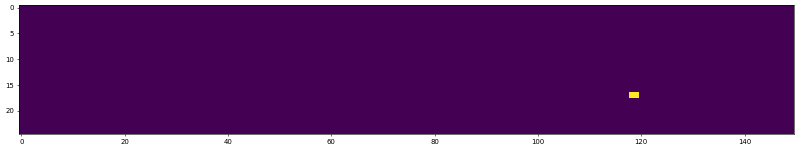

[682] {(130, 4)}


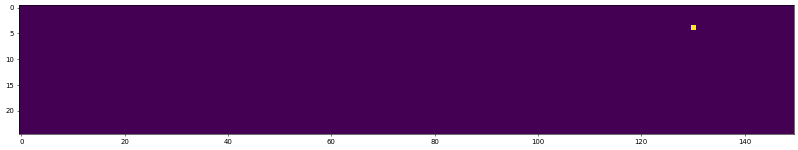

[735] {(81, 21), (80, 21)}


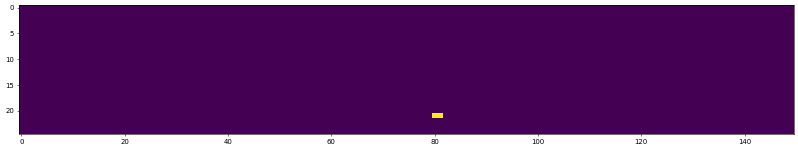

[746] {(53, 17)}


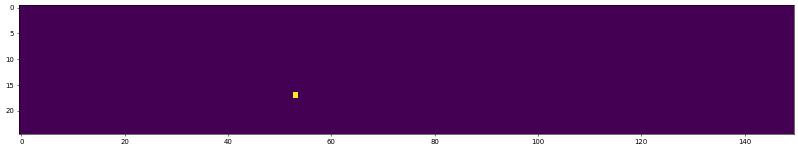

[765] {(53, 17)}


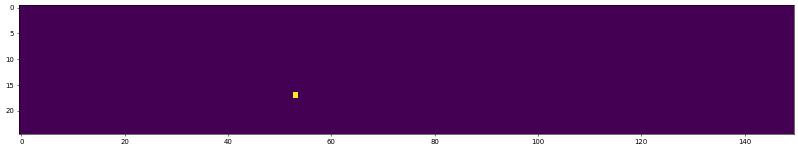

[814] {(101, 6)}


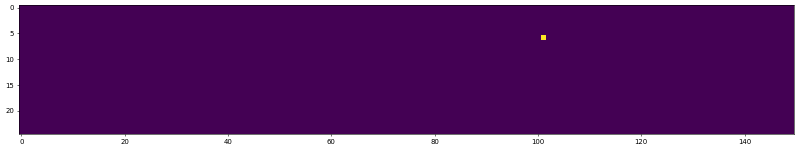

[933] {(9, 11)}


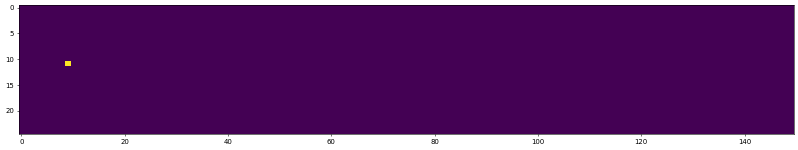

[941] {(52, 23), (53, 23)}


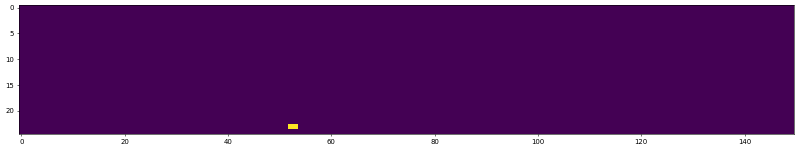

[966, 967] {(76, 19), (77, 19), (75, 19)}


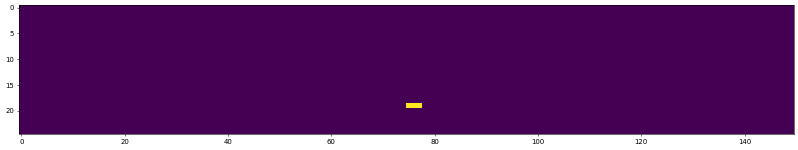

[1090, 1091] {(12, 0), (13, 0), (11, 0)}


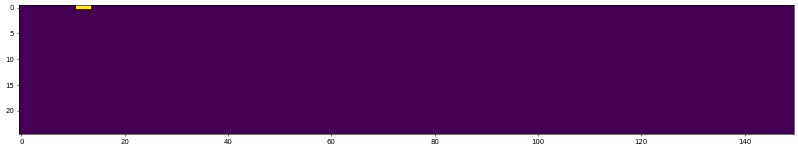

[1095] {(55, 23)}


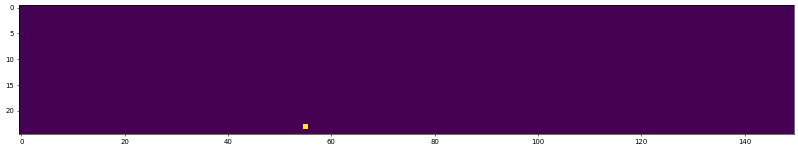

[1100] {(149, 10)}


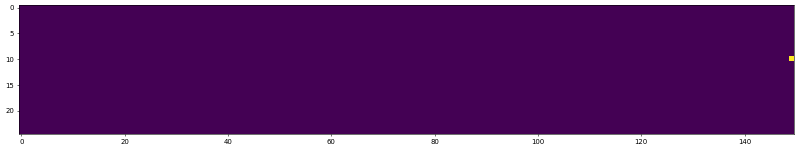

[1109] {(66, 18), (65, 18)}


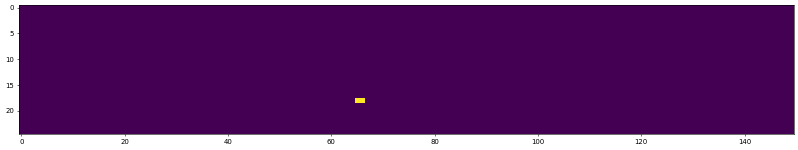

[1156, 1158, 1160] {(28, 22), (136, 18), (27, 22), (135, 18)}


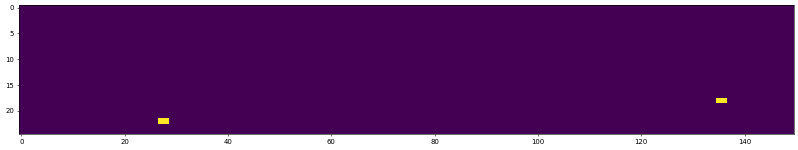

[1179, 1180] {(73, 15), (74, 15)}


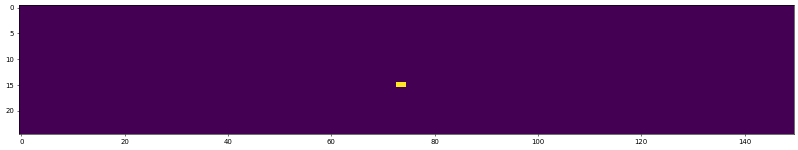

[1238, 1239] {(97, 10), (98, 10), (96, 10)}


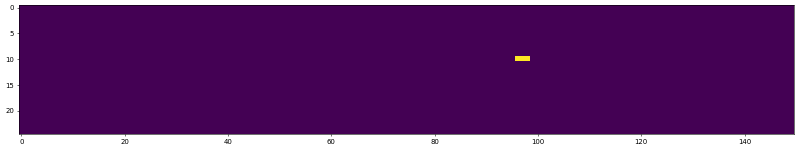

66 66 66
Muscle_map_150z25_60s_#27.npy
[36] {(60, 23)}


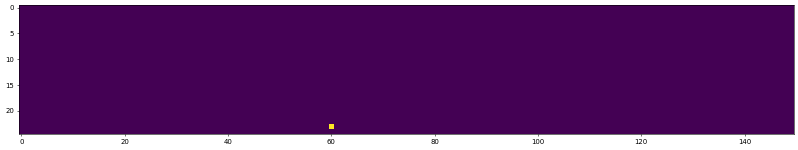

[154, 156, 159] {(95, 13), (35, 21), (67, 24), (66, 24)}


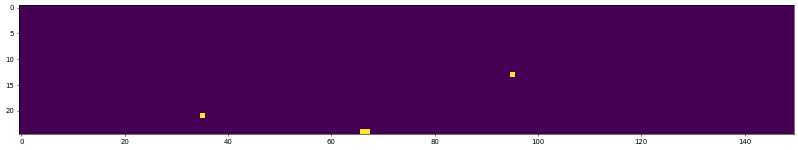

[234, 235] {(112, 11), (111, 11), (114, 11)}


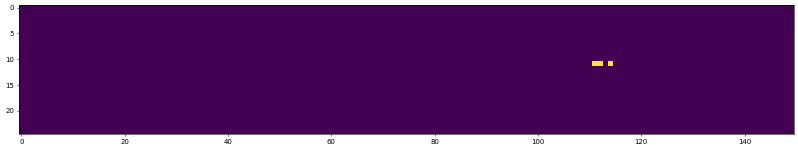

[268, 269, 270] {(143, 4), (141, 4), (142, 4)}


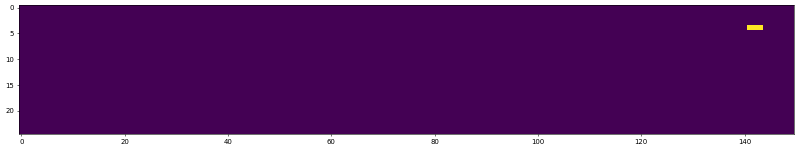

[282] {(94, 10)}


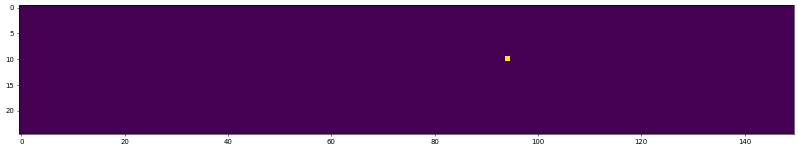

[288, 289, 291, 292] {(146, 22), (149, 22), (144, 22), (145, 22), (147, 22), (148, 22)}


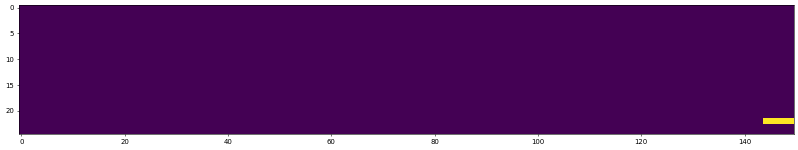

[345, 346] {(95, 19), (94, 19)}


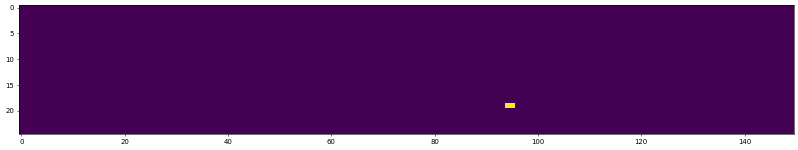

[362, 363] {(50, 5), (51, 5), (49, 5)}


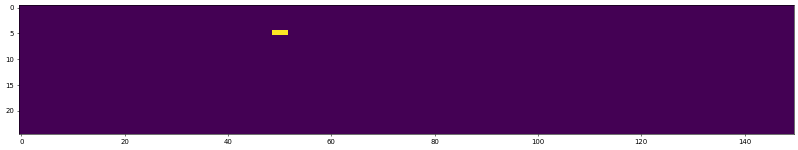

[382] {(74, 23)}


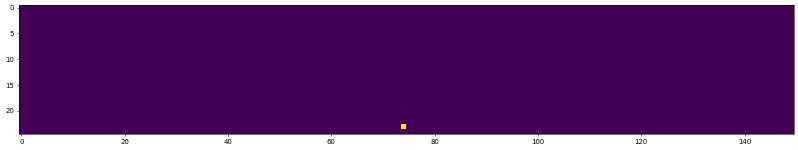

[413] {(4, 10)}


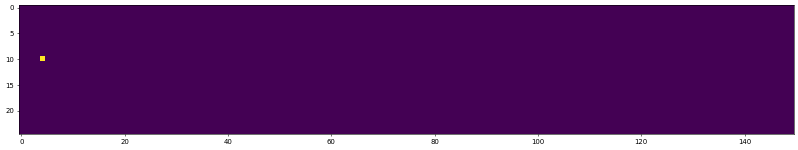

[419] {(6, 8)}


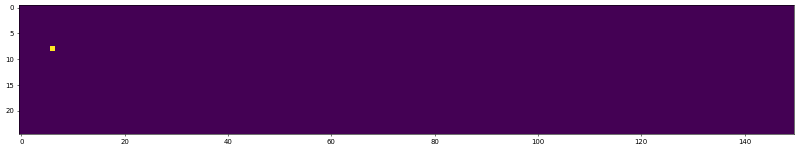

[461] {(30, 24)}


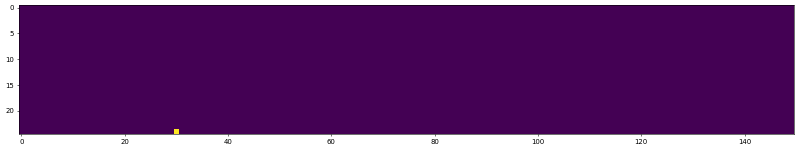

[581, 583, 584, 586, 587] {(128, 1), (129, 1), (126, 1), (90, 6), (91, 6), (125, 1), (127, 1)}


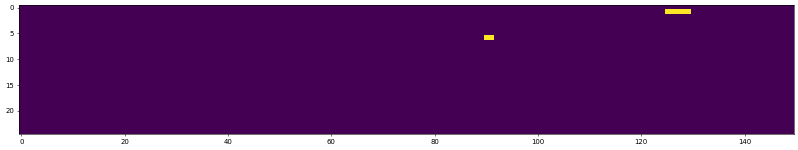

[655, 656, 658, 660, 662, 664, 666, 667, 668, 670] {(116, 20), (111, 20), (117, 20), (112, 20), (118, 20), (119, 20), (114, 20), (110, 20), (113, 20), (108, 20), (109, 20), (120, 20), (115, 20)}


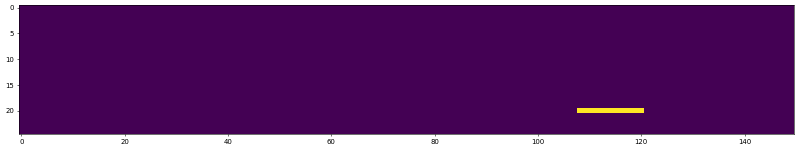

[676] {(146, 7)}


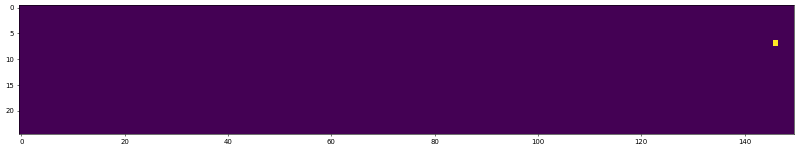

[685] {(80, 0), (81, 0)}


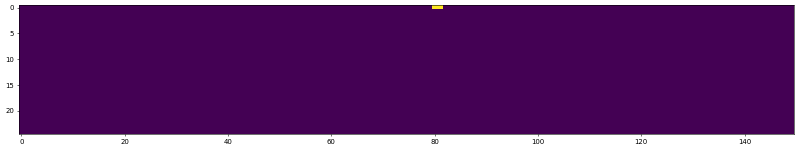

[709] {(89, 15)}


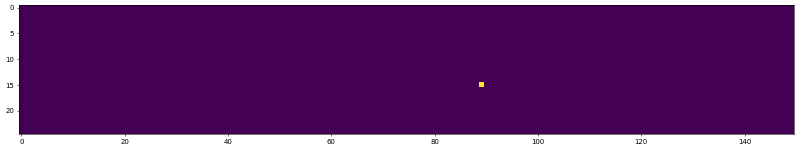

[773, 776, 777] {(7, 16), (6, 16), (124, 8)}


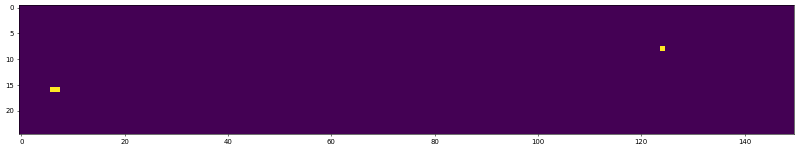

[790] {(80, 4)}


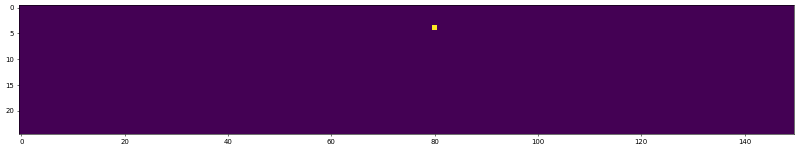

[794, 795, 797, 799] {(128, 1), (129, 1), (56, 10), (126, 1), (55, 10), (125, 1)}


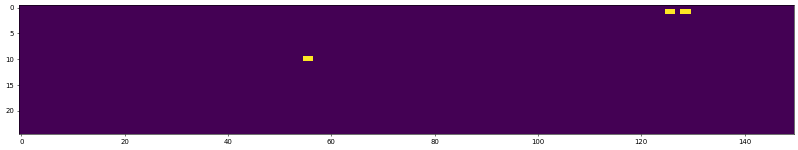

[850] {(41, 16)}


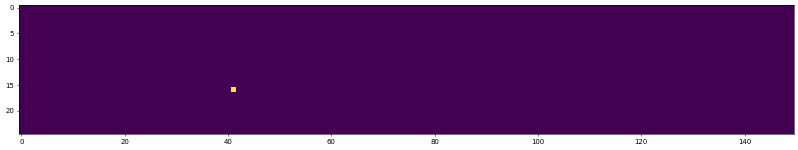

[881] {(23, 19)}


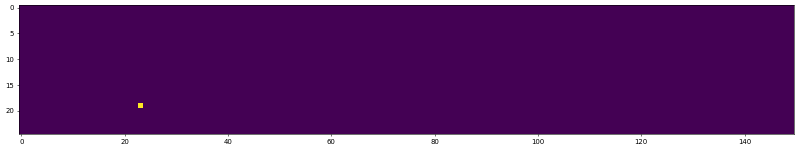

[891, 892] {(100, 8), (98, 8), (99, 8)}


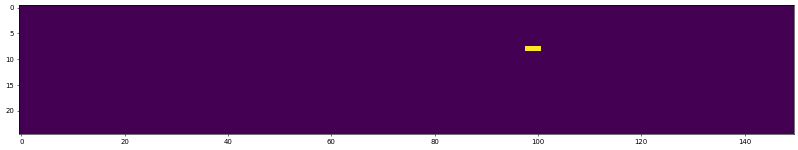

[947, 950, 951, 954] {(99, 16), (82, 13), (100, 16), (83, 13)}


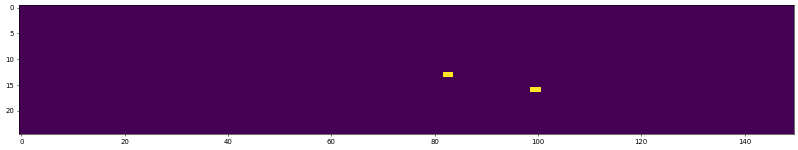

[1008, 1009] {(129, 22), (130, 22), (131, 22)}


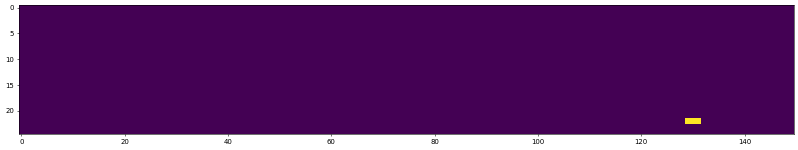

[1013, 1014] {(49, 24), (50, 24)}


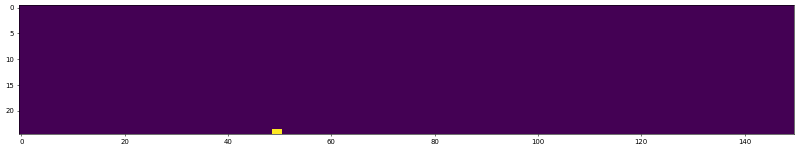

[1021, 1022] {(76, 21), (77, 21), (94, 18), (95, 18), (78, 21)}


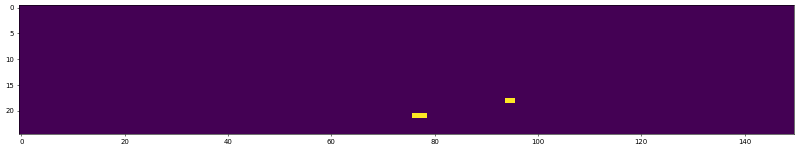

[1057, 1059] {(44, 18), (45, 18)}


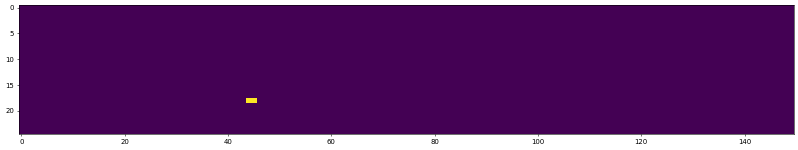

[1070] {(42, 15)}


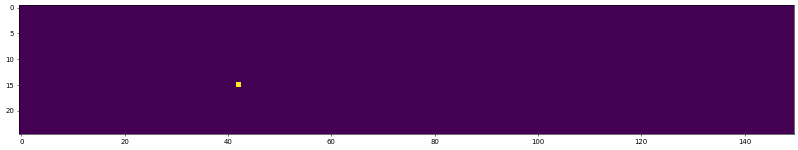

[1106] {(9, 6), (10, 6)}


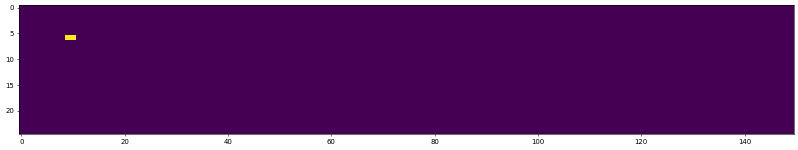

[1119, 1120, 1121, 1122, 1124, 1126, 1127] {(109, 7), (111, 7), (16, 2), (110, 7), (17, 2), (86, 9), (14, 2), (15, 2), (108, 7)}


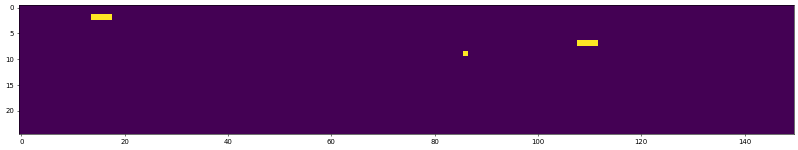

[1181, 1182] {(133, 13), (134, 13)}


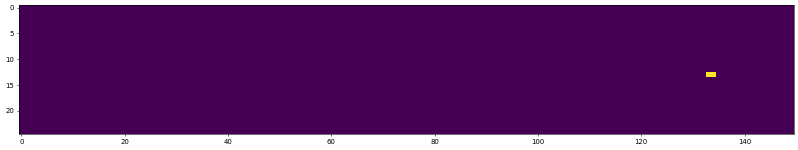

[1189] {(134, 1)}


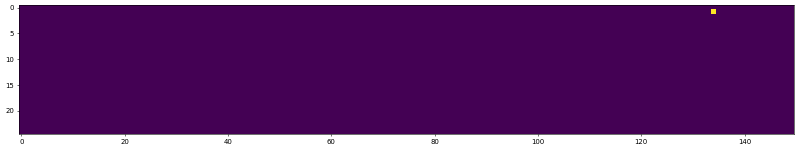

[1196, 1197] {(127, 10), (126, 10)}


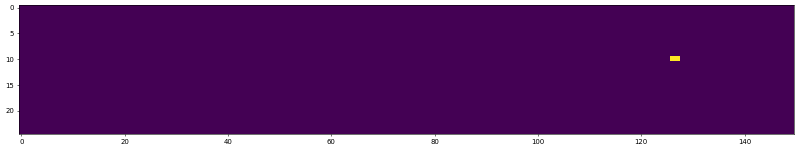

[1208] {(145, 0), (144, 0)}


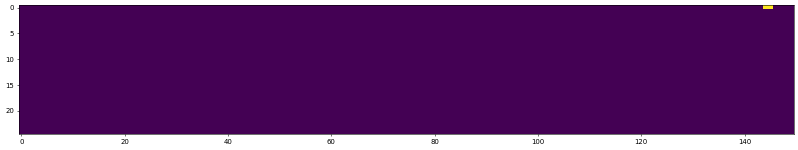

[1215, 1216] {(131, 1), (132, 1)}


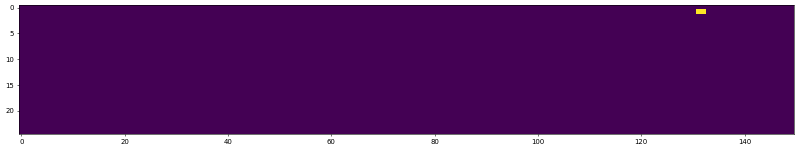

102 102 102
Kidney_map_150z25_60s_#39.npy
[88] {(102, 16), (101, 16)}


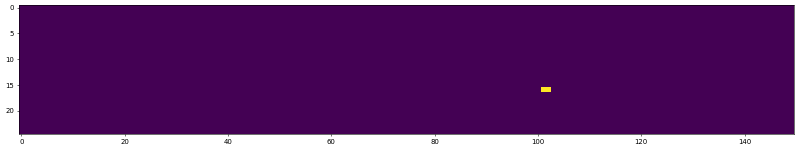

[96, 97] {(61, 5), (60, 5)}


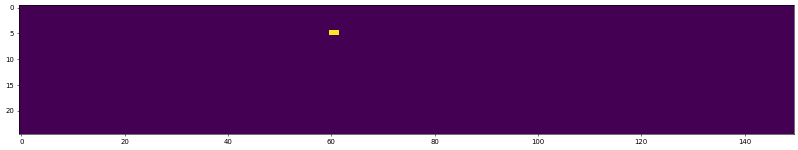

[134, 136] {(92, 19), (91, 19)}


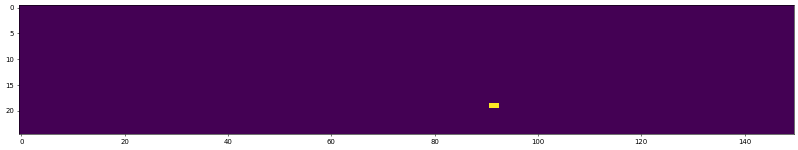

[184, 187, 190] {(100, 20), (101, 20), (49, 10), (97, 20), (98, 20), (48, 10)}


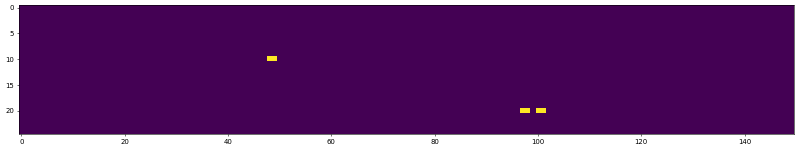

[196] {(96, 20)}


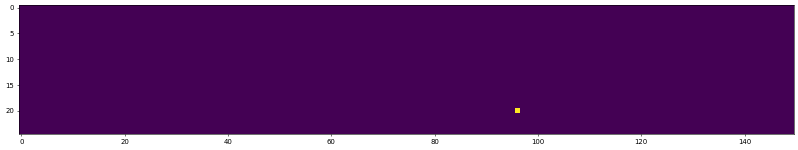

[202] {(147, 7), (148, 7)}


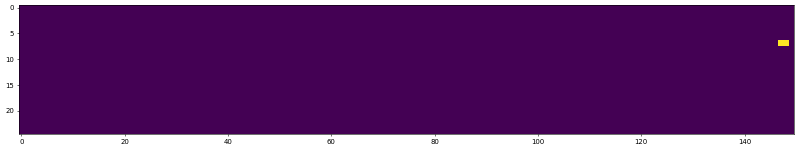

[209] {(24, 13)}


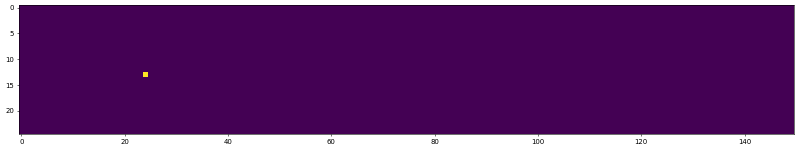

[239] {(98, 17)}


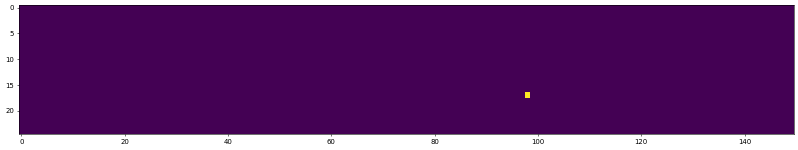

[316, 317] {(135, 15), (136, 15)}


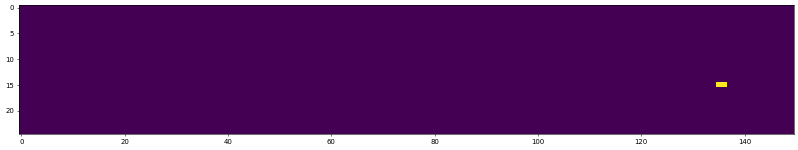

[333] {(70, 4)}


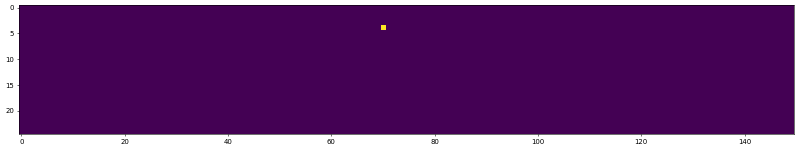

[380] {(100, 6)}


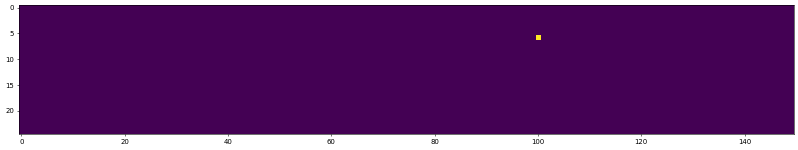

[402] {(43, 5)}


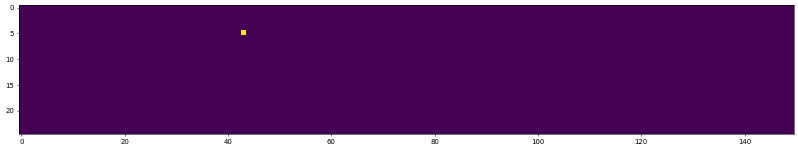

[424] {(132, 2)}


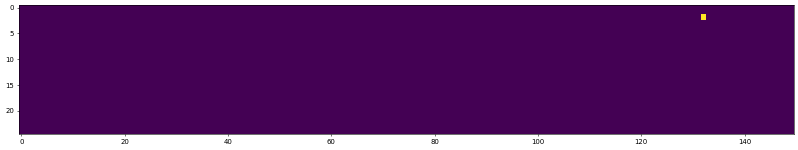

[498, 499] {(33, 23), (34, 23)}


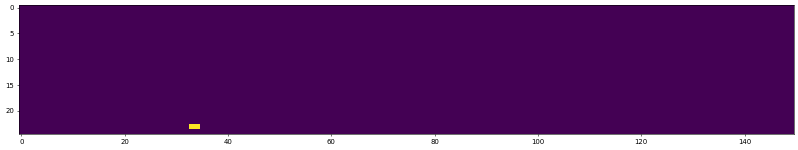

[531, 533] {(80, 13), (81, 13)}


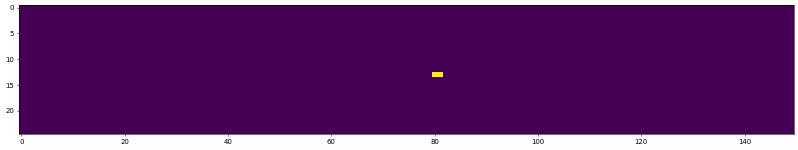

[558] {(106, 3)}


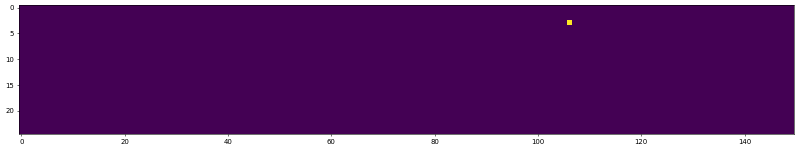

[616, 617] {(66, 22), (64, 22), (67, 22), (65, 22)}


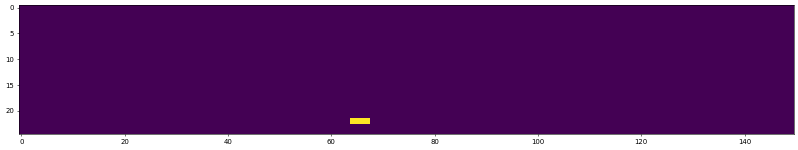

[626, 629, 632, 634] {(83, 4), (81, 4), (82, 4), (80, 4)}


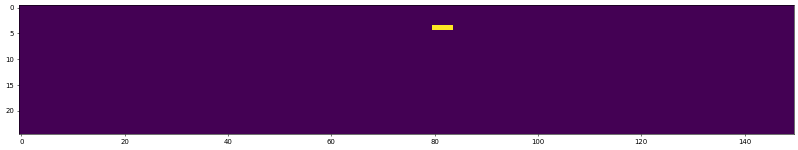

[647, 648] {(135, 16), (136, 16)}


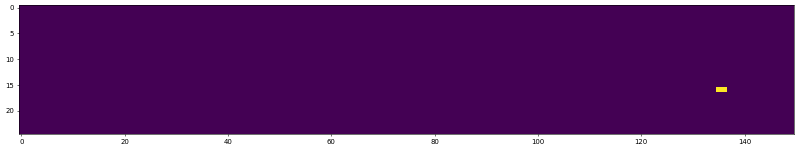

[652, 653, 654] {(134, 16), (31, 2), (133, 16), (32, 2)}


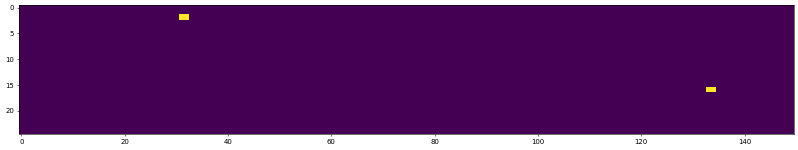

[688, 689, 690, 691, 692, 693] {(87, 6), (49, 3), (88, 6), (89, 6), (50, 3), (45, 3), (46, 3), (52, 3), (47, 3), (48, 3), (51, 3)}


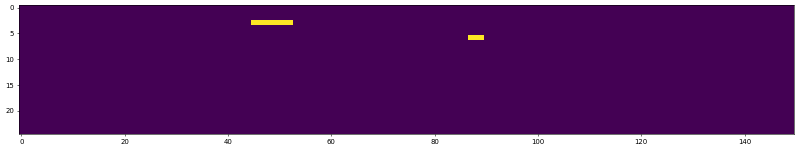

[713, 714] {(124, 0), (125, 0)}


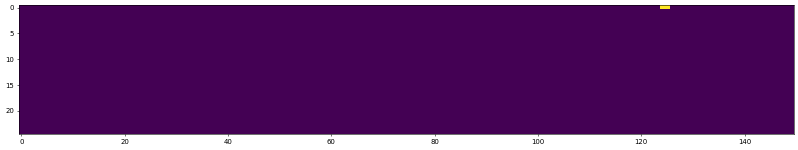

[719, 721] {(109, 23), (108, 23)}


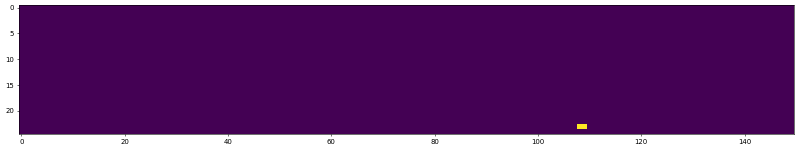

[743] {(0, 23), (1, 23)}


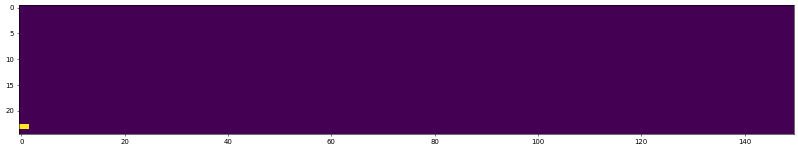

[790, 793] {(120, 6), (121, 6)}


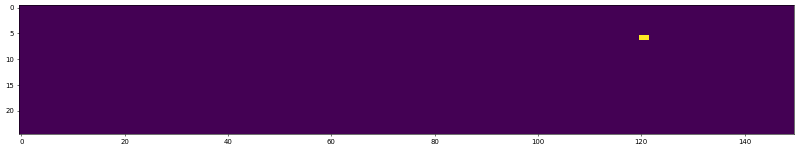

[798, 800] {(37, 0), (38, 0)}


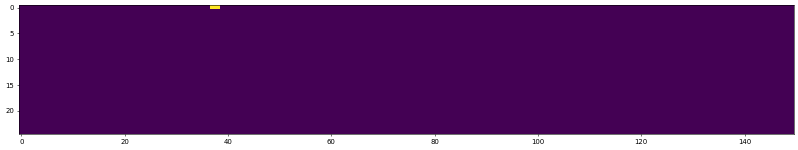

[827, 828] {(126, 1), (127, 1)}


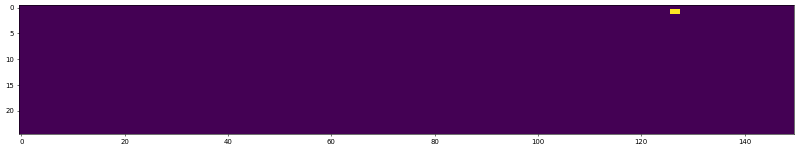

[883] {(0, 5)}


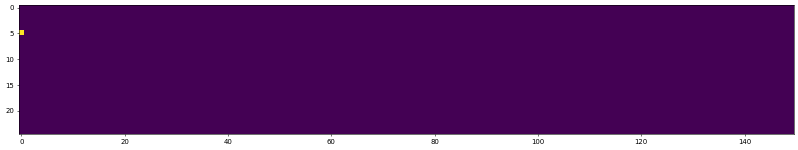

[893, 894] {(20, 23), (94, 6), (95, 6)}


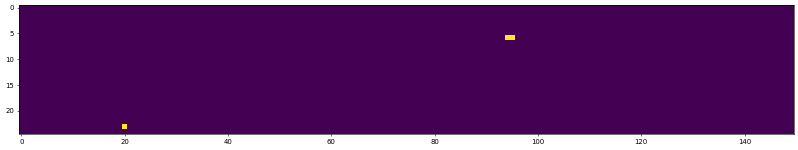

[941] {(136, 4)}


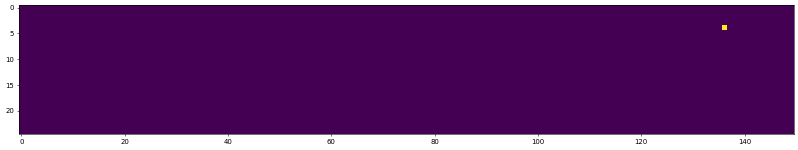

[946, 947, 948, 949] {(133, 20), (135, 20), (88, 18), (89, 18), (134, 20)}


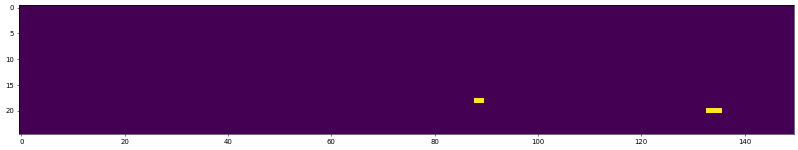

[955, 956, 957, 958, 959, 960, 961, 963] {(114, 24), (65, 21), (72, 21), (95, 6), (96, 6), (70, 21), (88, 18), (97, 6), (71, 21), (66, 21), (32, 3), (67, 21), (115, 24), (68, 21), (116, 24), (69, 21)}


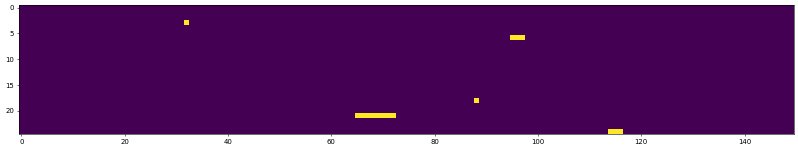

[986] {(30, 2)}


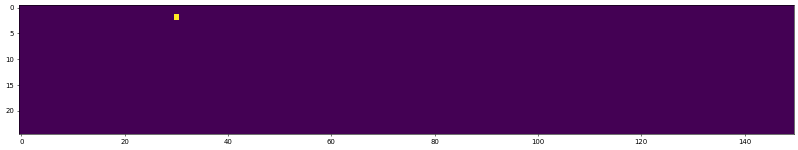

[991] {(32, 2)}


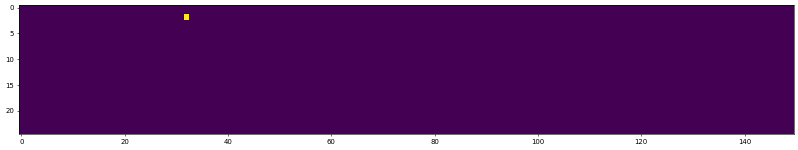

[1040] {(127, 10), (44, 19), (45, 19), (46, 19), (47, 19)}


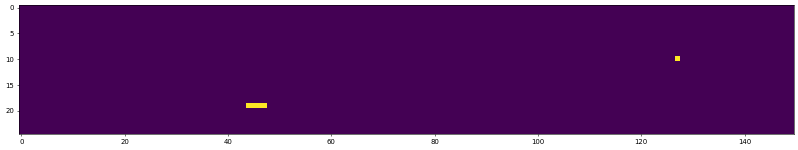

[1044, 1045] {(125, 10), (126, 10)}


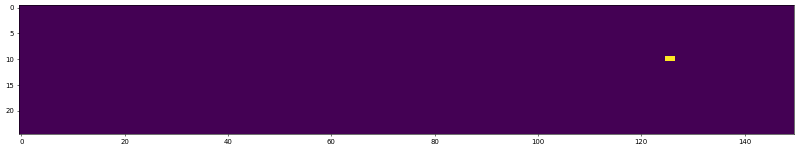

[1076, 1077, 1078, 1079, 1080, 1083] {(26, 5), (27, 5), (74, 7), (25, 5), (28, 5), (23, 5), (24, 5), (75, 7)}


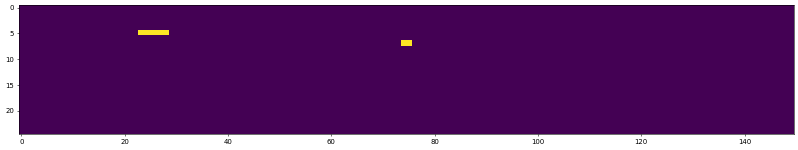

[1139] {(121, 1)}


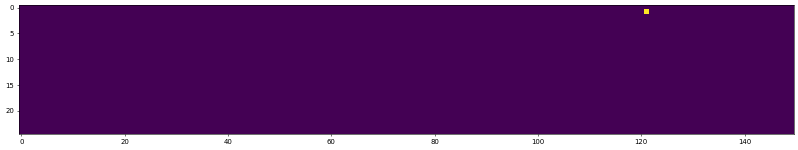

[1145, 1147] {(102, 7), (47, 20), (103, 7)}


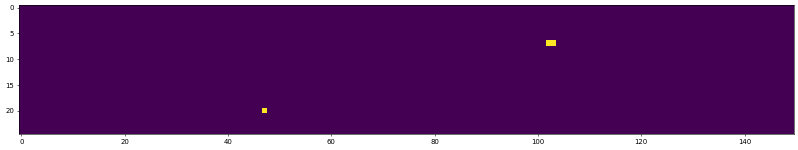

[1151, 1153] {(111, 13), (110, 13)}


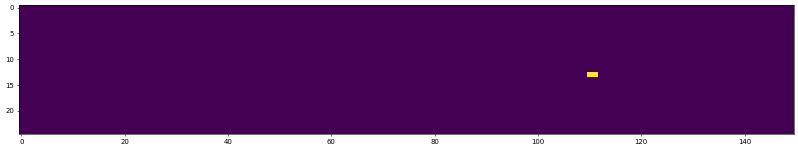

[1158, 1160, 1161] {(3, 2), (1, 2), (2, 2)}


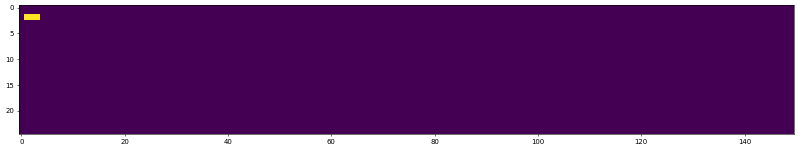

[1170] {(44, 19), (43, 19)}


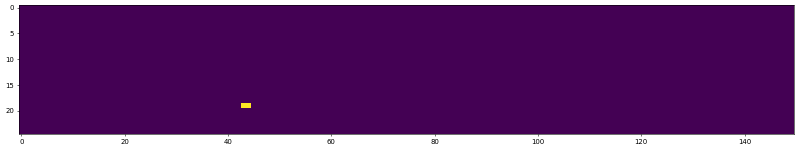

[1213] {(99, 23)}


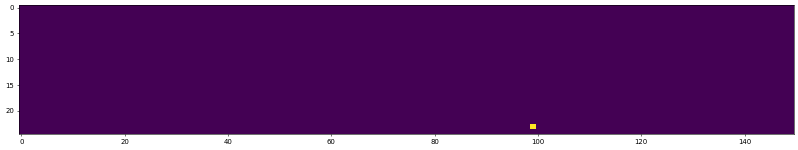

[1243] {(5, 22)}


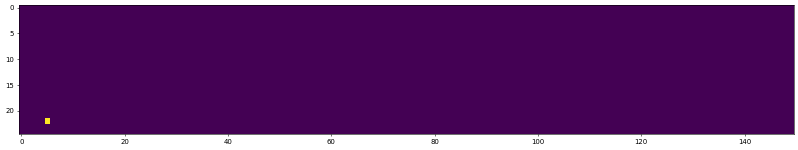

[1250] {(89, 0)}


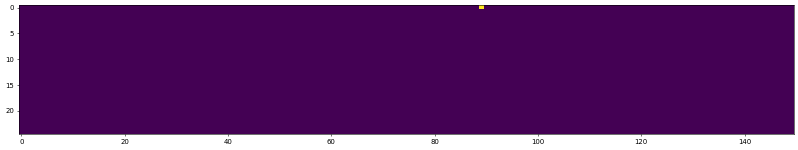

121 121 121
Liver_map_150z25_60s_#2.npy
[77] {(105, 4), (104, 4)}


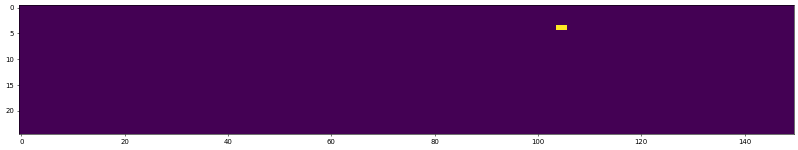

[131] {(99, 4), (100, 4)}


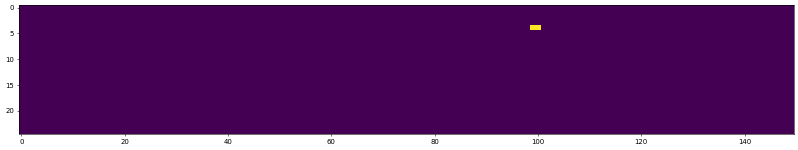

[163] {(54, 23)}


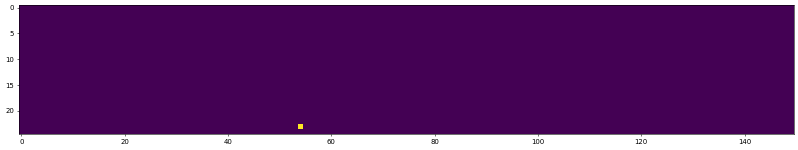

[221] {(87, 9)}


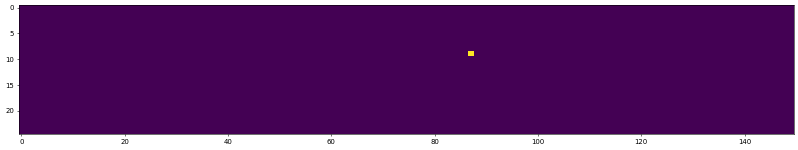

[272] {(93, 4)}


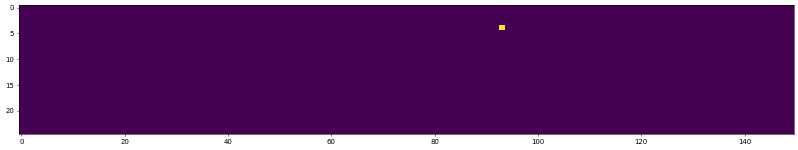

[284] {(96, 11), (94, 11), (95, 11)}


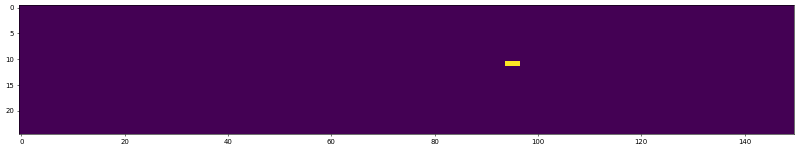

[296, 297] {(65, 19), (64, 19)}


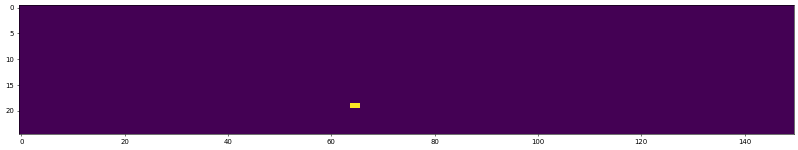

[301] {(84, 14), (83, 14)}


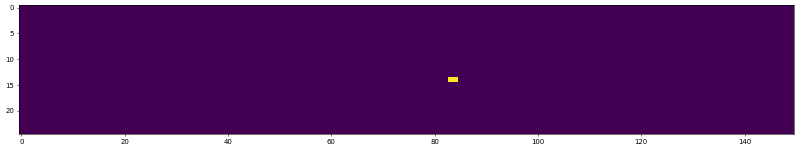

[326] {(126, 9)}


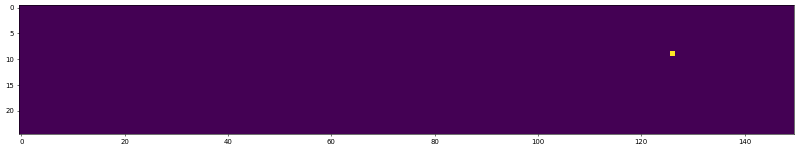

[353] {(27, 20), (28, 20)}


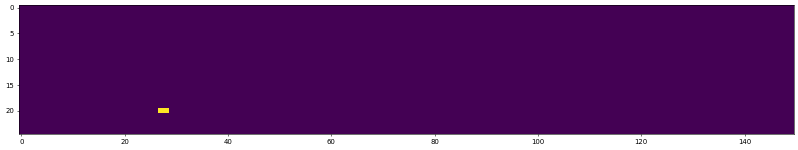

[419, 421] {(19, 13), (38, 24), (39, 24), (20, 13)}


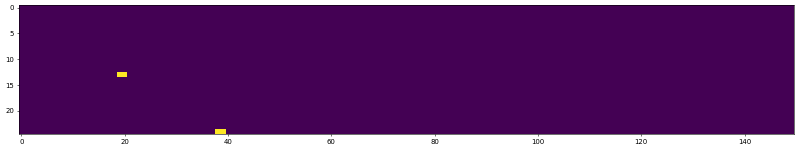

[425] {(25, 13), (24, 13)}


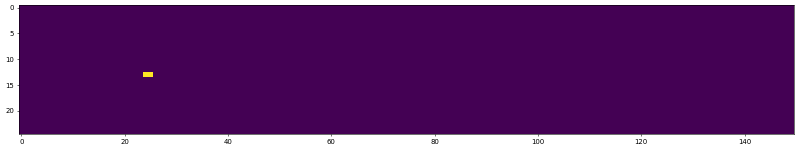

[433, 435] {(133, 7), (131, 7), (132, 7)}


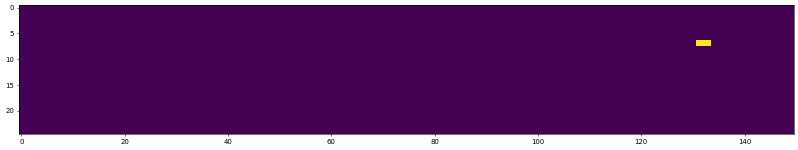

[472, 474, 475] {(14, 24), (12, 24), (11, 24), (13, 24)}


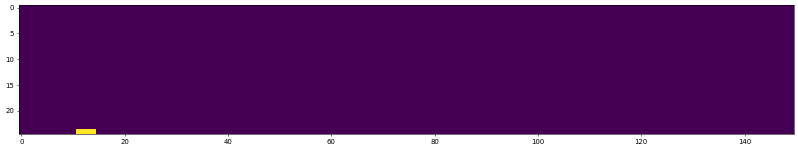

[490, 491] {(119, 20), (118, 20)}


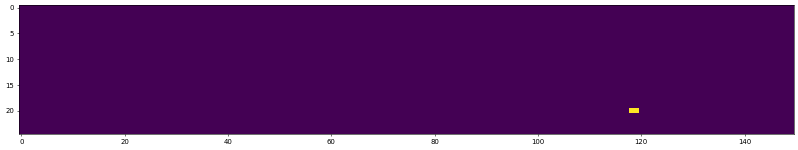

[530] {(88, 19)}


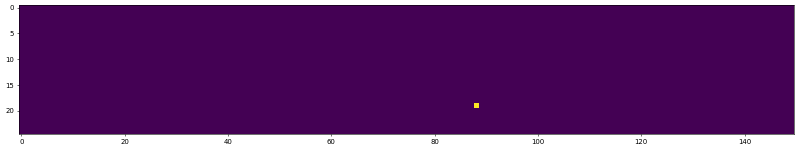

[570, 572] {(85, 1), (86, 1)}


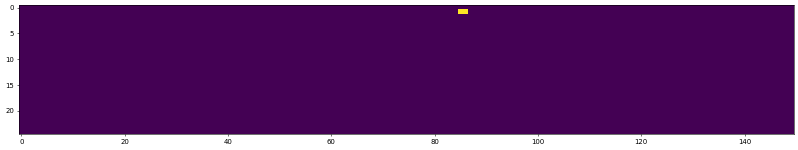

[584, 585] {(0, 18), (76, 7), (141, 0), (147, 0)}


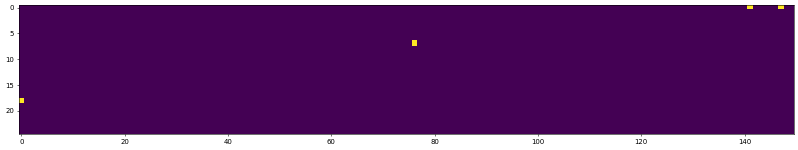

[625] {(69, 3)}


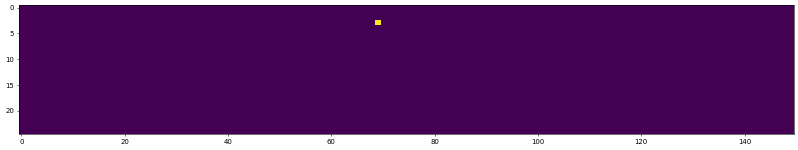

[656, 657, 658, 659, 660] {(82, 16), (78, 16), (79, 16), (80, 16), (81, 16), (77, 16)}


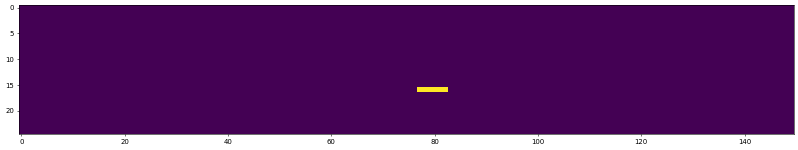

[671, 673, 674, 676] {(139, 23), (140, 23), (7, 17), (8, 17)}


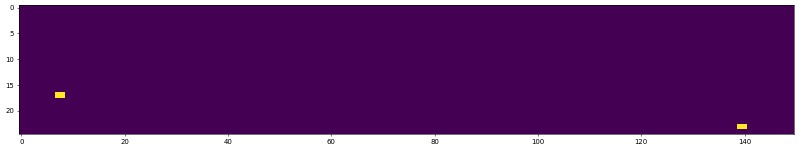

[694] {(142, 5)}


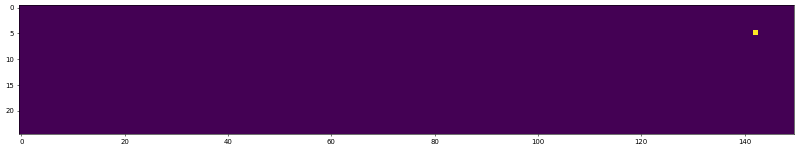

[707] {(103, 19)}


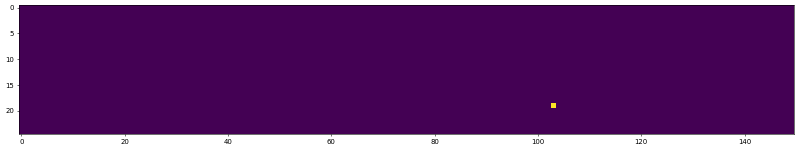

[736] {(122, 23)}


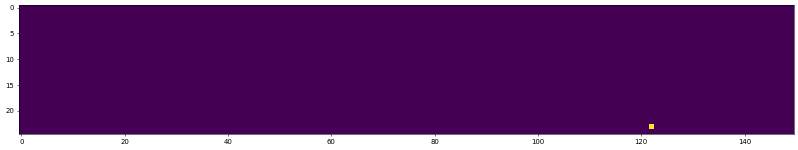

[754] {(95, 0)}


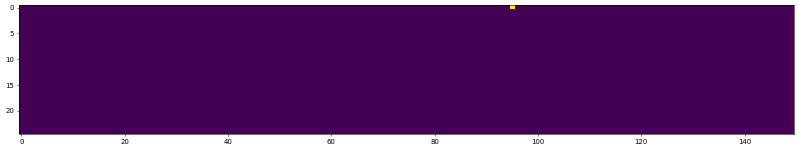

[758] {(95, 0)}


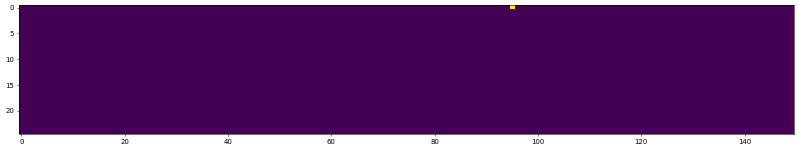

[767] {(97, 0)}


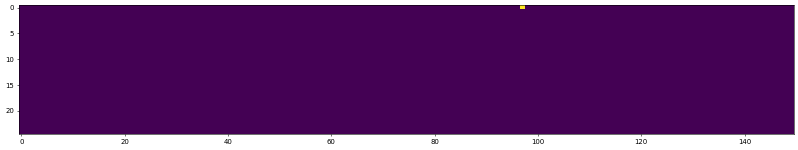

[772] {(97, 0)}


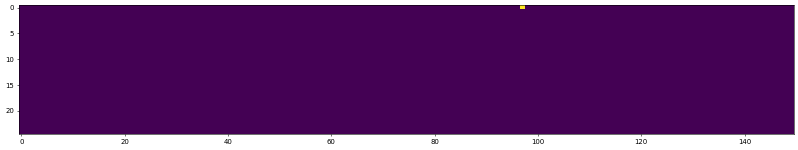

[783] {(119, 2)}


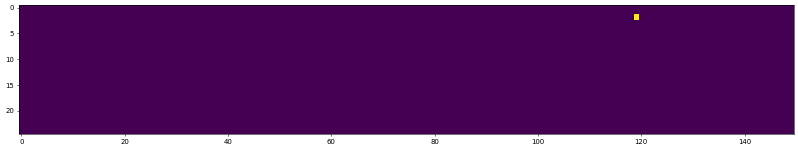

[789] {(119, 2)}


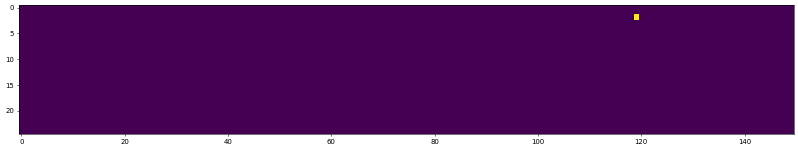

[796] {(119, 2)}


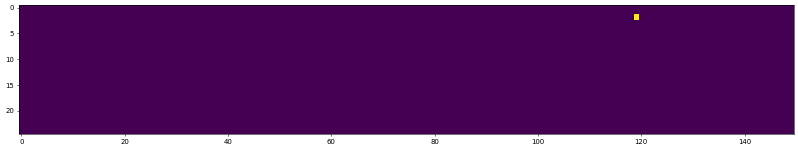

[829] {(81, 0)}


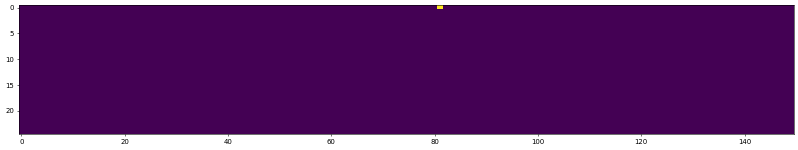

[858, 860] {(22, 15), (23, 15)}


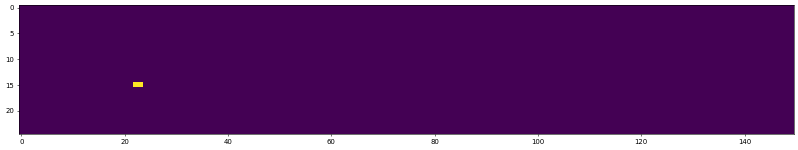

[920, 921] {(64, 23), (65, 23)}


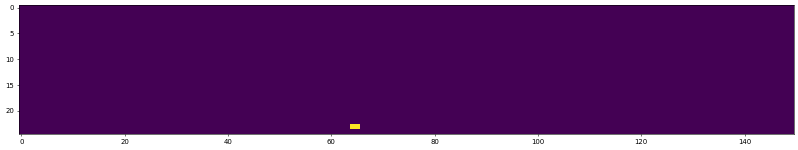

[948] {(58, 0), (59, 0), (60, 0)}


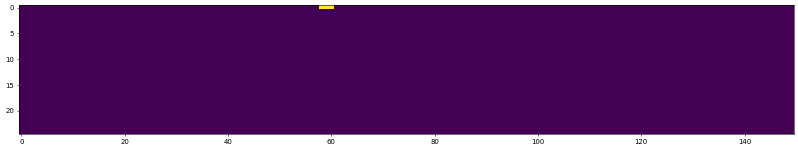

[962] {(65, 8)}


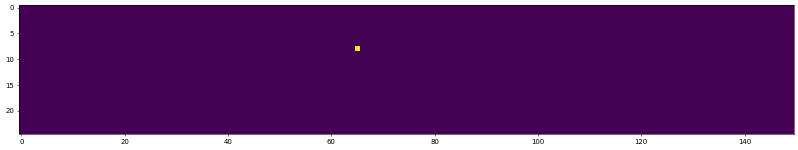

[989] {(118, 10), (119, 10)}


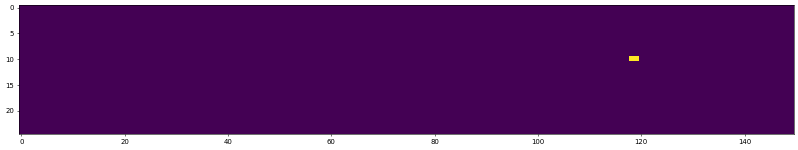

[1017] {(68, 16)}


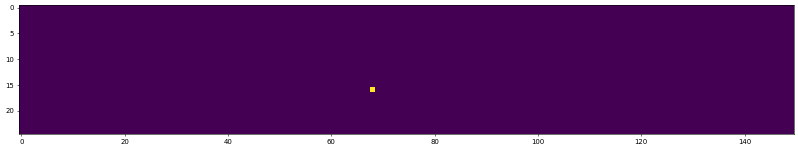

[1029] {(68, 16)}


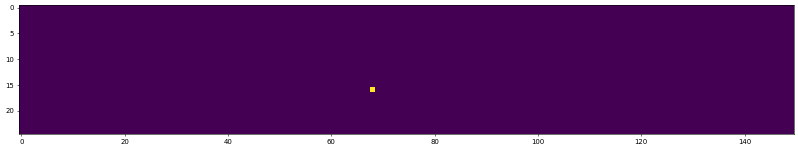

[1065, 1066] {(132, 5), (130, 5)}


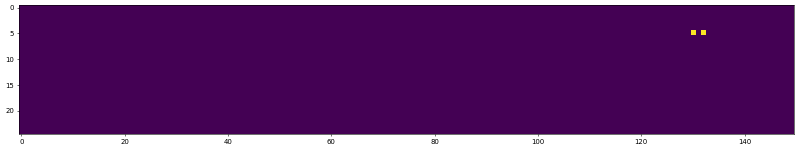

[1071] {(99, 24)}


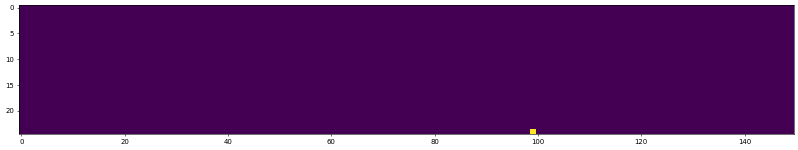

[1085] {(103, 2)}


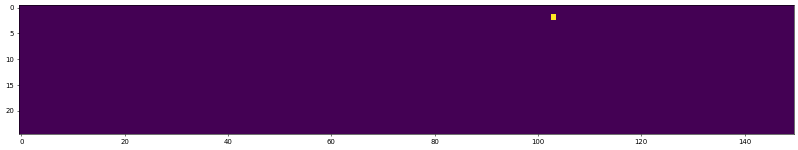

[1155] {(38, 8)}


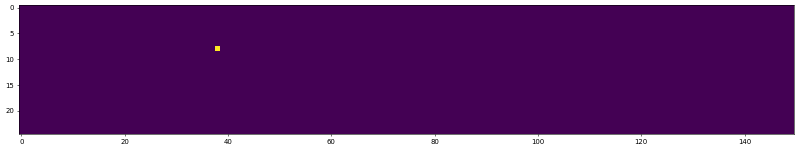

[1172, 1175] {(96, 17), (137, 6), (95, 17), (136, 6)}


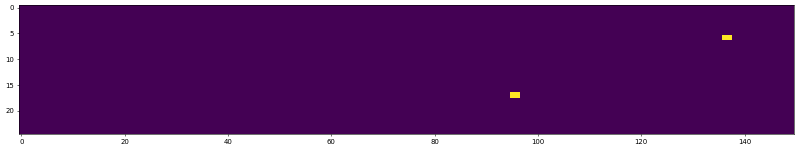

[1196] {(139, 15)}


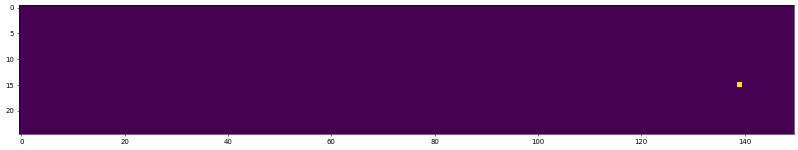

[1206] {(144, 11)}


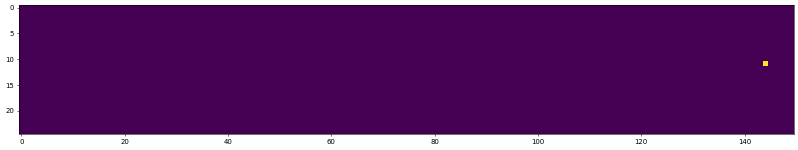

[1210, 1211] {(140, 11), (141, 11), (139, 11)}


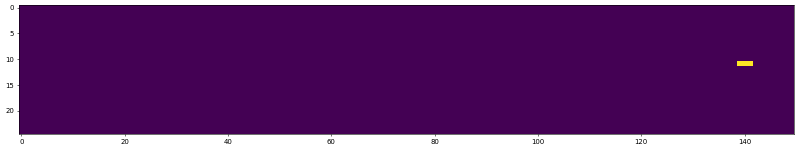

[1226] {(141, 6)}


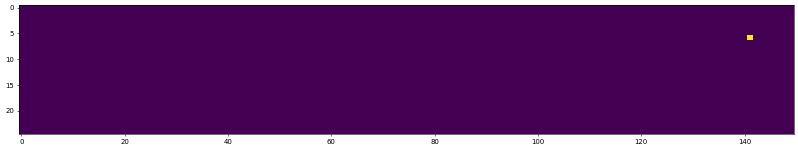

[1243, 1244] {(137, 3), (138, 3), (139, 3), (135, 3), (136, 3)}


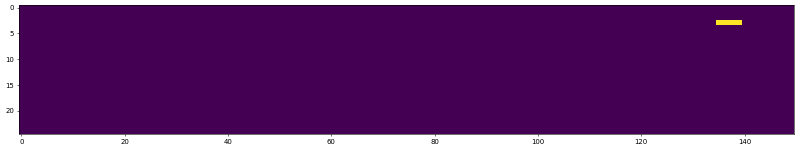

92 92 92
Muscle_map_150z25_60s_#19.npy
[32] {(85, 1)}


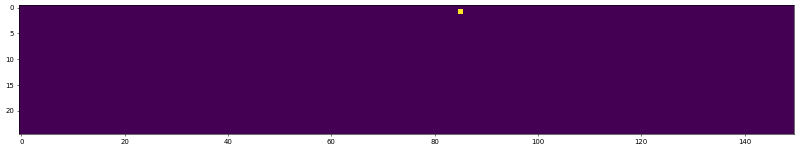

[58, 60, 61] {(92, 1), (90, 1), (91, 1)}


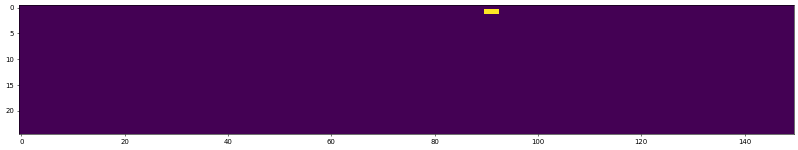

[78] {(126, 9)}


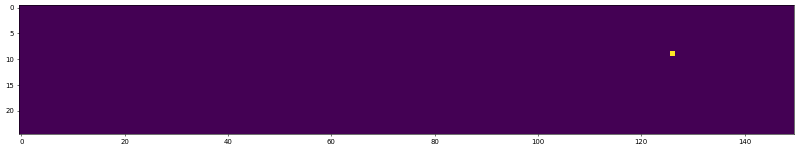

[84, 87] {(33, 17), (56, 2)}


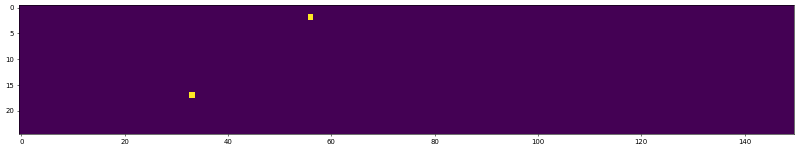

[92] {(94, 24)}


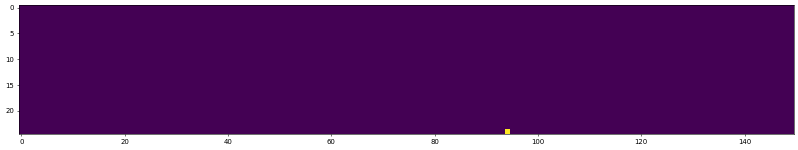

[156] {(148, 9)}


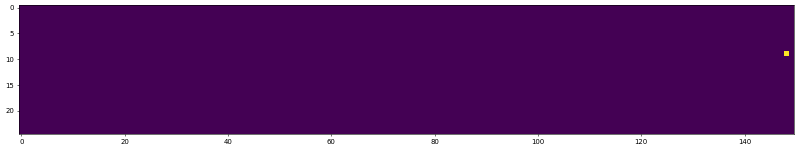

[179] {(127, 21)}


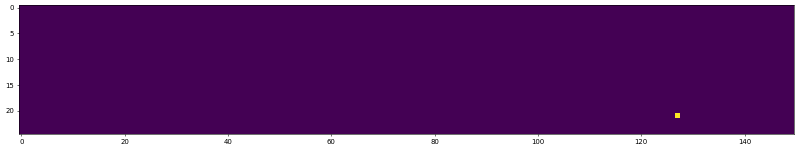

[215] {(95, 18)}


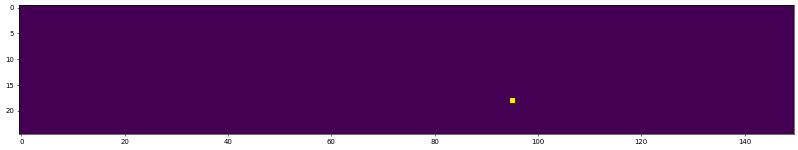

[262] {(148, 9)}


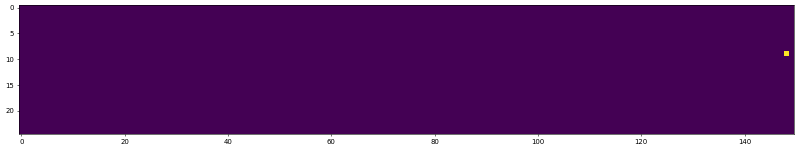

[292, 294, 295] {(46, 18), (47, 18), (45, 18)}


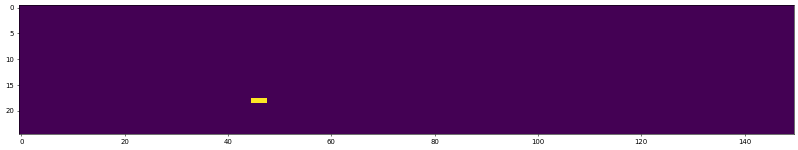

[312] {(113, 5)}


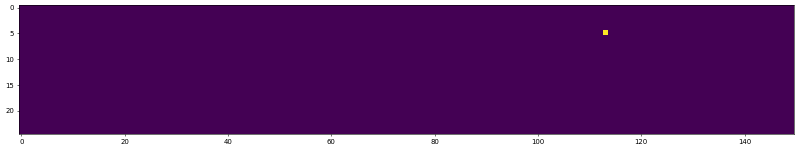

[342] {(8, 7)}


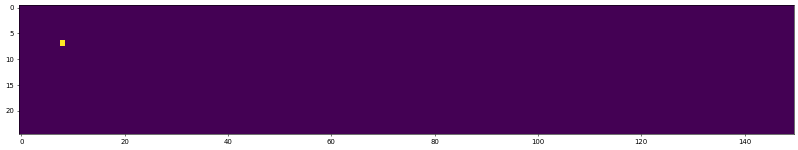

[409, 411] {(145, 9), (75, 8)}


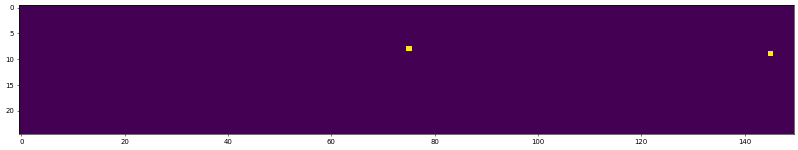

[461, 464] {(149, 8), (43, 7)}


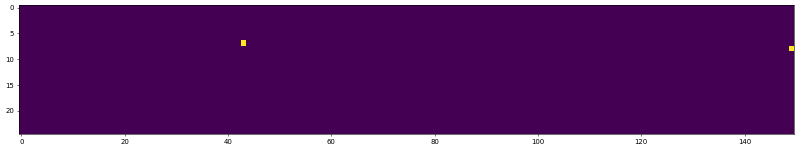

[475] {(1, 2)}


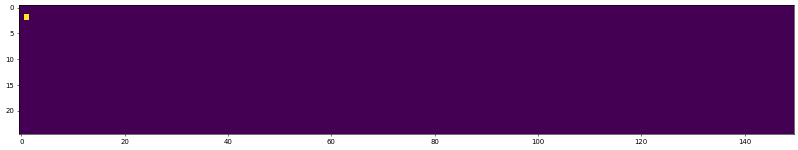

[487] {(0, 8)}


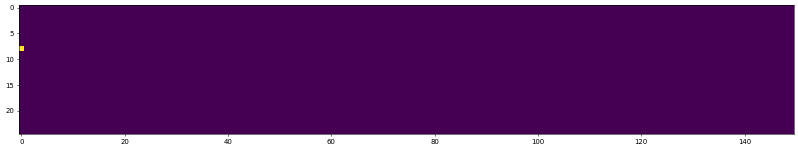

[495] {(142, 21)}


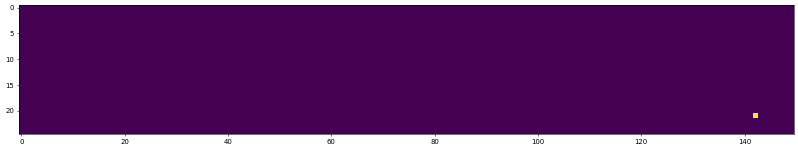

[508] {(96, 0)}


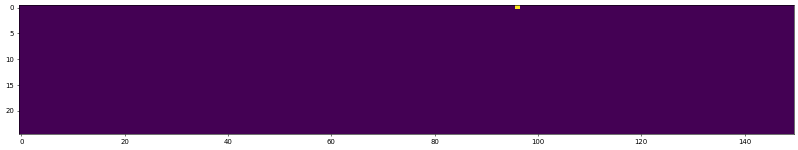

[564] {(117, 1), (118, 1)}


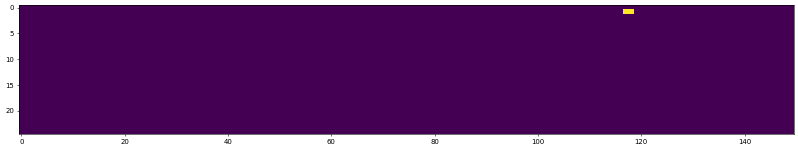

[586] {(109, 6)}


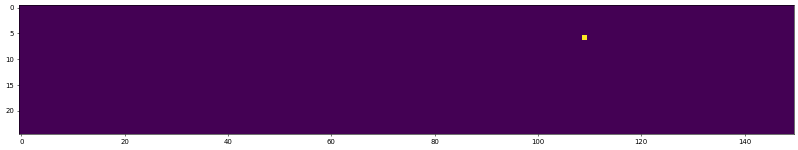

[609, 610] {(56, 6), (59, 6), (57, 6), (58, 6), (55, 6)}


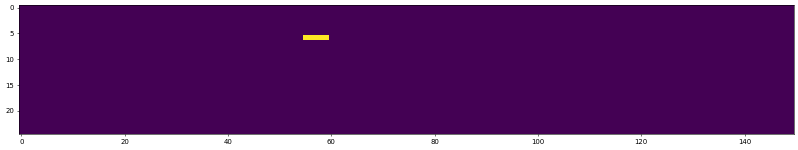

[618, 619] {(58, 6), (57, 6)}


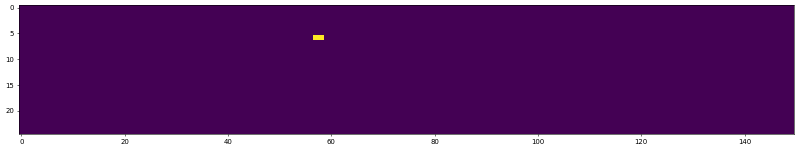

[652, 653, 655] {(62, 8), (65, 8), (54, 16), (53, 16), (63, 8), (64, 8)}


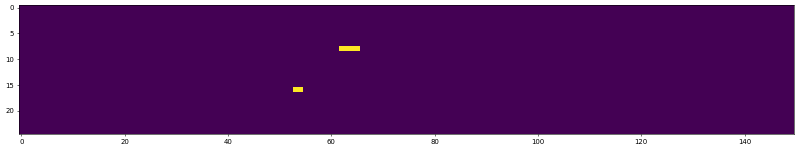

[676] {(93, 15)}


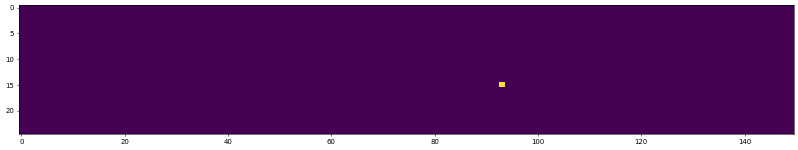

[682, 683] {(33, 7), (31, 7), (34, 7), (32, 7)}


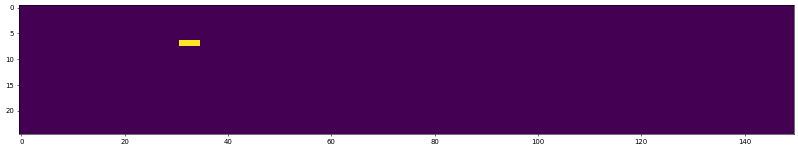

[709] {(76, 15)}


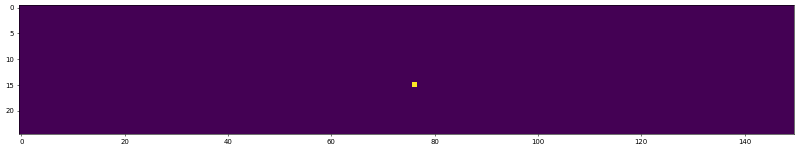

[729] {(22, 7), (20, 7), (21, 7)}


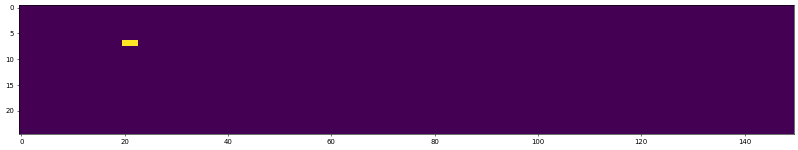

[739] {(121, 12)}


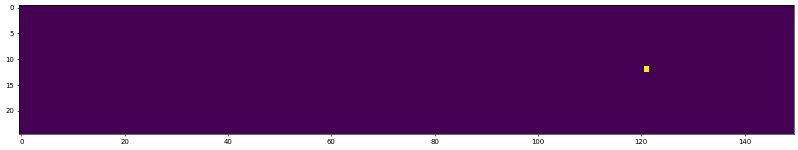

[756] {(137, 6)}


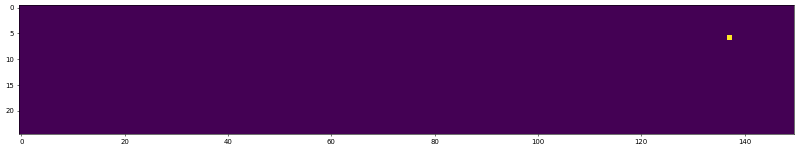

[764] {(58, 20)}


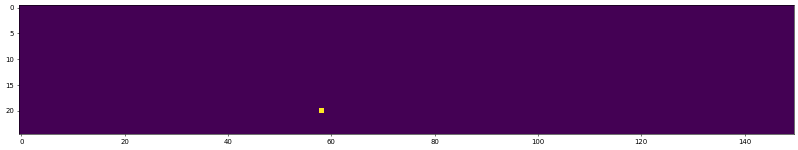

[785, 786] {(121, 20), (141, 8), (119, 20), (142, 8), (120, 20)}


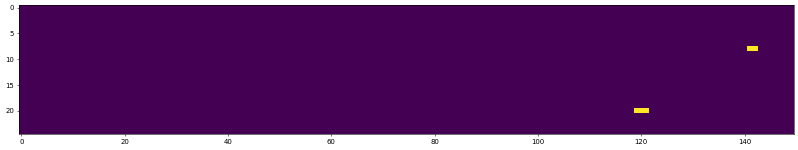

[847, 849] {(80, 0), (79, 0)}


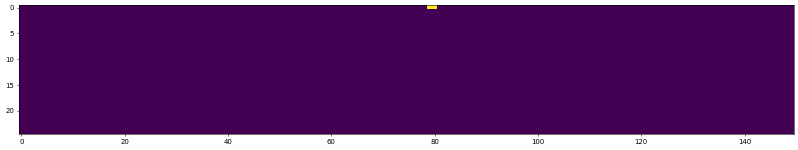

[855] {(118, 9)}


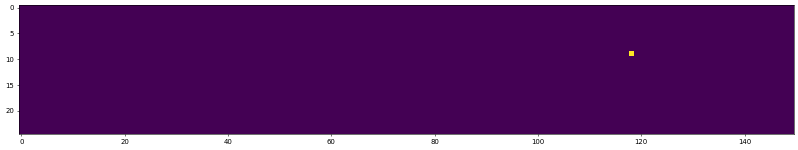

[859] {(119, 9)}


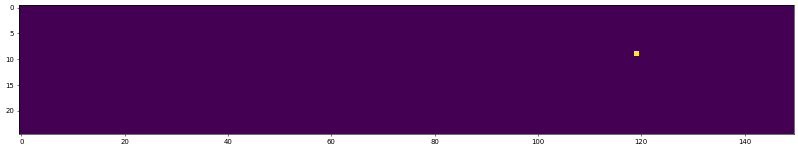

[881] {(71, 5)}


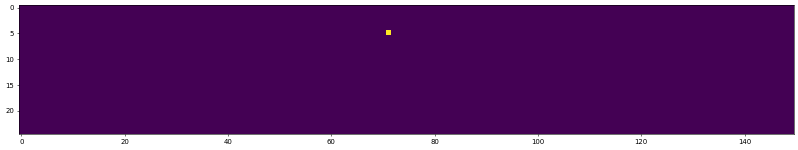

[893, 894] {(137, 11), (138, 11)}


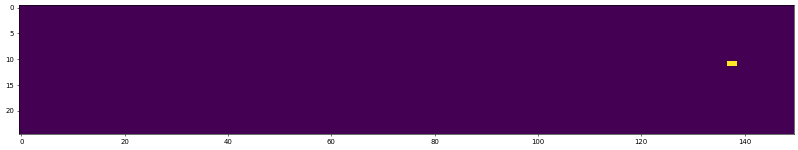

[898] {(22, 7), (21, 7)}


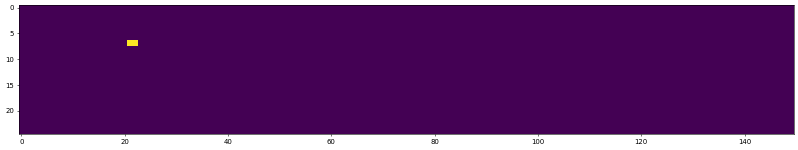

[943, 944, 945] {(108, 8), (24, 20), (107, 8), (23, 20)}


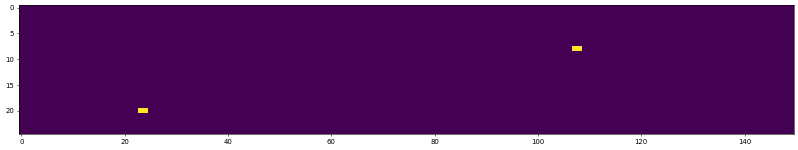

[971] {(41, 18)}


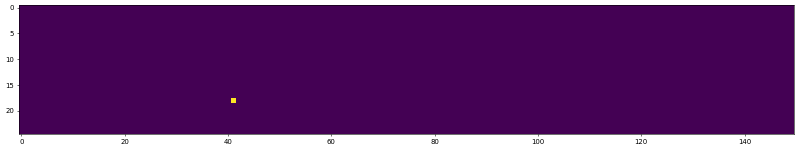

[1014] {(67, 16)}


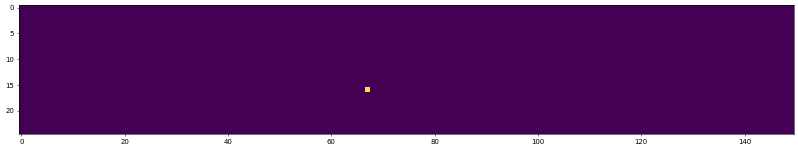

[1020] {(85, 22), (84, 22)}


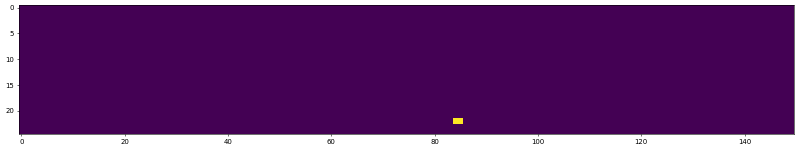

[1030] {(145, 11), (86, 18)}


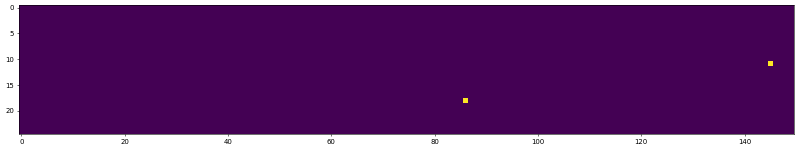

[1042, 1044] {(83, 21), (78, 21), (82, 21), (77, 21)}


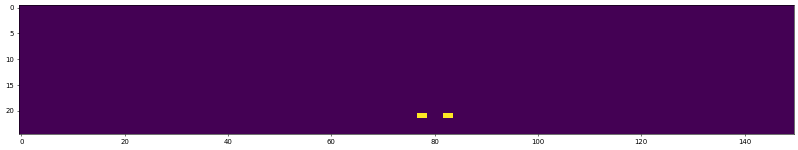

[1055] {(127, 17)}


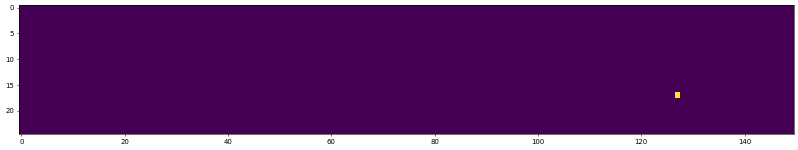

[1077] {(61, 12)}


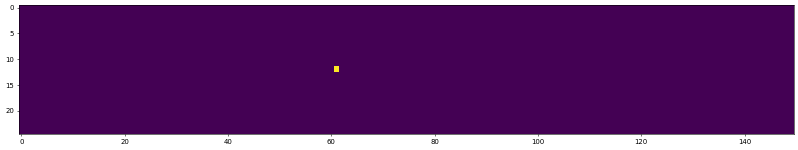

[1117, 1119] {(50, 18), (51, 18)}


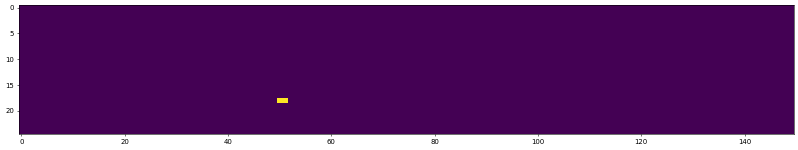

[1149] {(21, 24)}


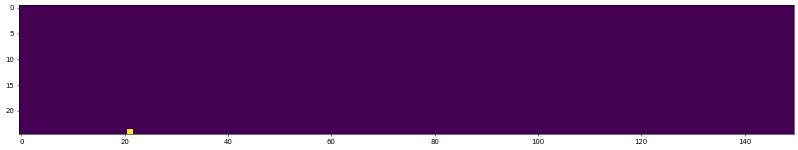

[1164] {(88, 10), (89, 10)}


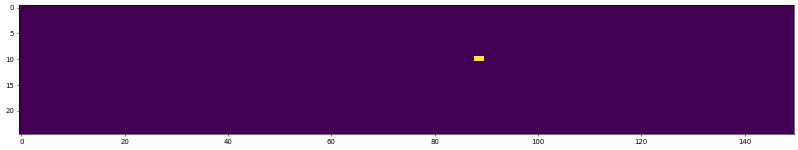

[1189] {(121, 8)}


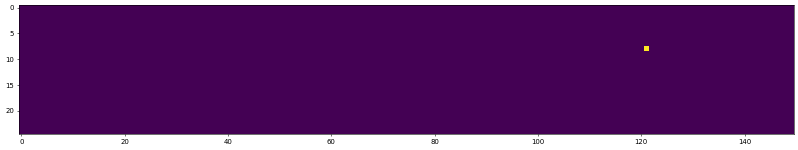

[1202, 1204, 1205, 1207, 1208, 1210, 1211, 1213, 1214, 1215, 1216, 1218, 1219, 1221, 1222, 1223, 1224, 1226] {(15, 24), (87, 10), (17, 24), (123, 8), (8, 24), (19, 24), (10, 24), (86, 10), (125, 8), (21, 24), (127, 8), (12, 24), (23, 24), (14, 24), (16, 24), (18, 24), (124, 8), (47, 11), (20, 24), (126, 8), (22, 24), (85, 10), (9, 24), (11, 24), (13, 24)}


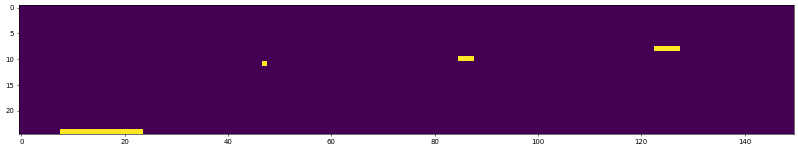

[1242, 1243] {(122, 8), (123, 8), (121, 8)}


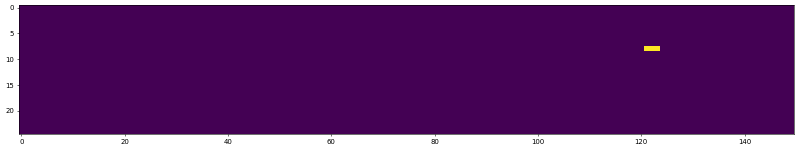

110 110 110
Liver_map_150z25_60s_#01.npy
[28] {(33, 2)}


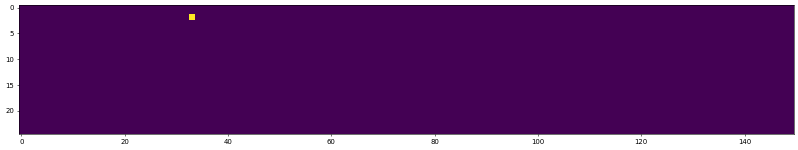

[170] {(34, 14)}


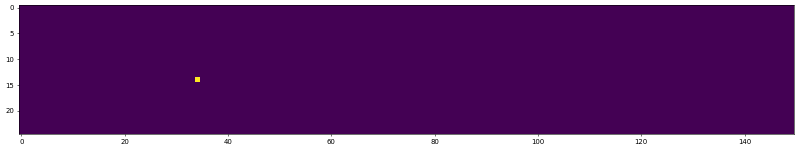

[194] {(18, 14)}


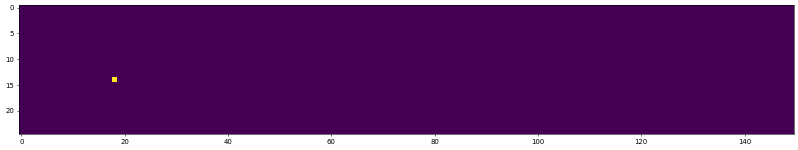

[202] {(18, 14)}


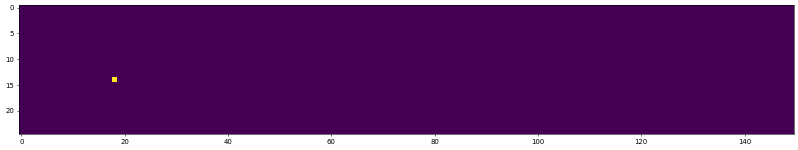

[213] {(18, 14)}


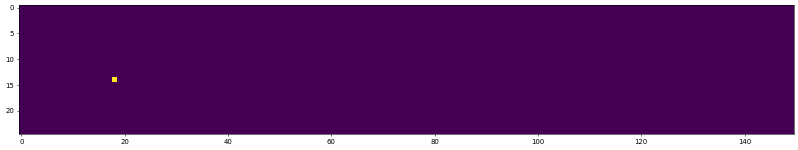

[243] {(71, 23), (70, 23)}


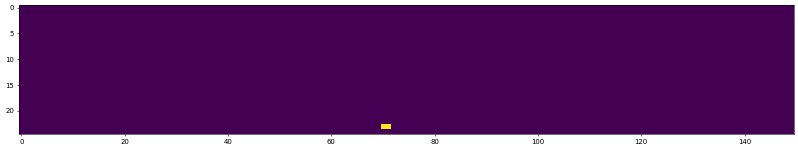

[247] {(23, 5)}


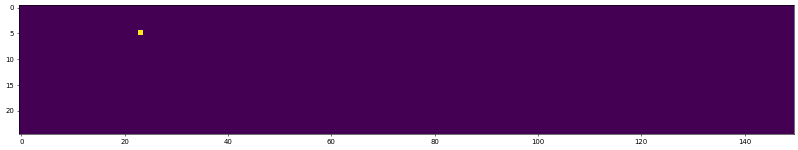

[254] {(41, 15)}


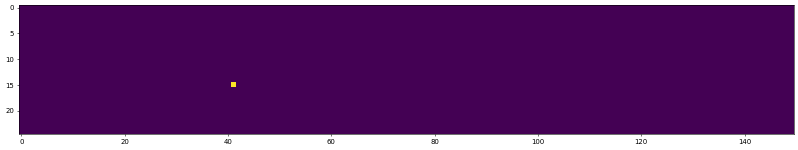

[262] {(89, 23)}


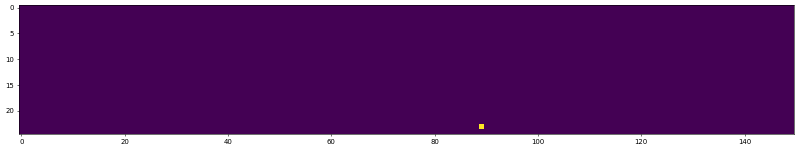

[281] {(117, 14)}


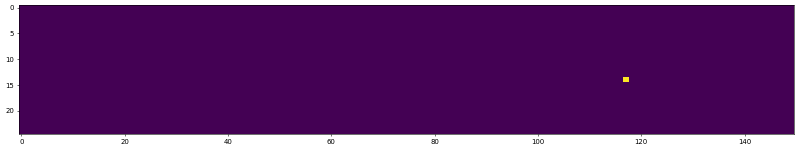

[285, 287] {(119, 14), (147, 16)}


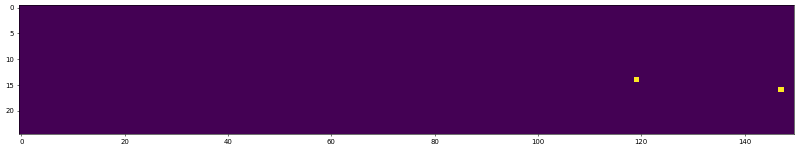

[301] {(54, 11)}


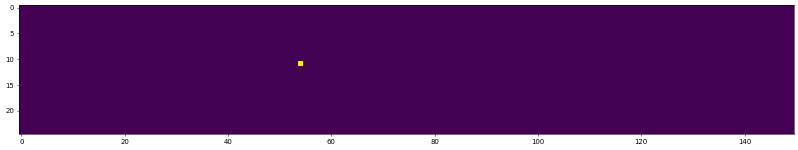

[351] {(20, 17)}


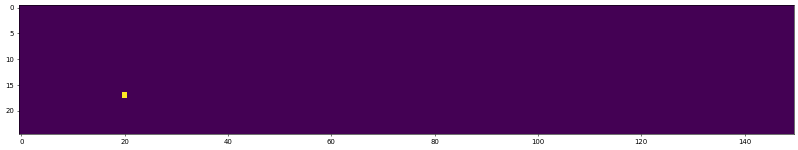

[413, 415] {(142, 10), (78, 9), (77, 9)}


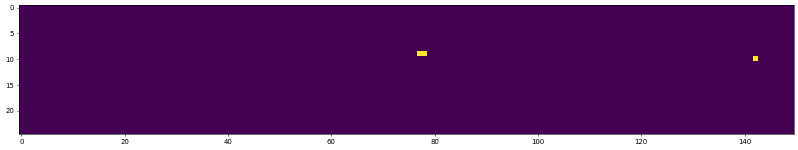

[426] {(52, 8)}


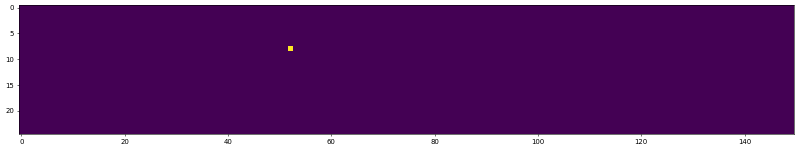

[463, 464] {(130, 13), (132, 13), (133, 13), (135, 13), (131, 13), (134, 13)}


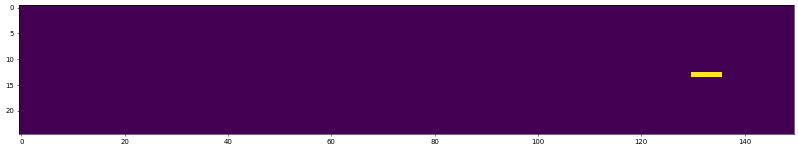

[488, 491] {(114, 19), (32, 7)}


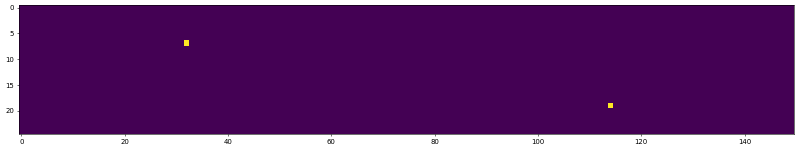

[498] {(23, 4)}


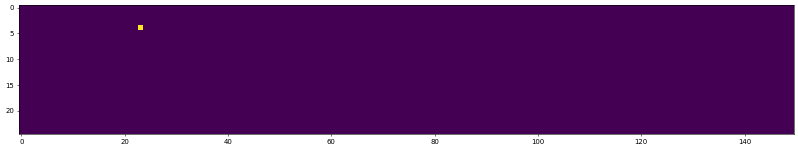

[597, 599, 600, 601, 604, 605] {(24, 5), (93, 8), (94, 8), (23, 5), (92, 8), (95, 8), (90, 8), (123, 8), (91, 8), (124, 8)}


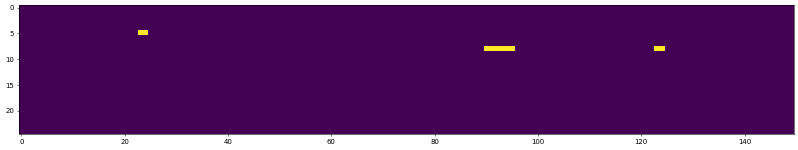

[614] {(134, 23)}


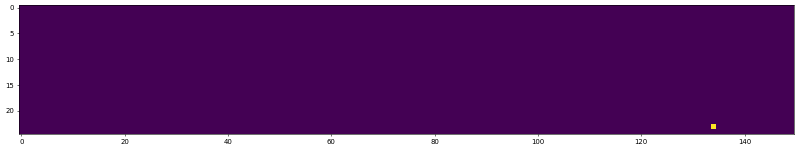

[681, 684] {(11, 2), (12, 2), (130, 5)}


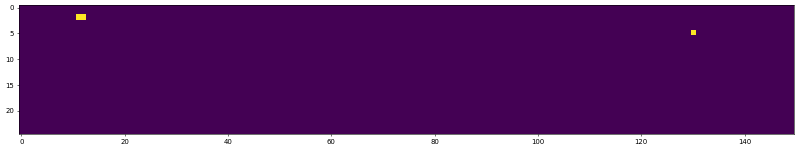

[690] {(147, 3)}


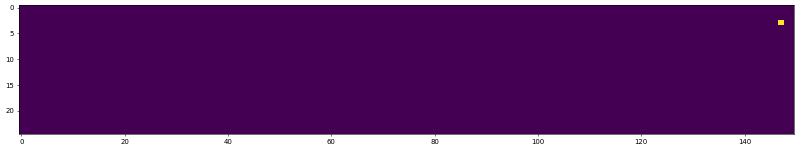

[712] {(104, 21)}


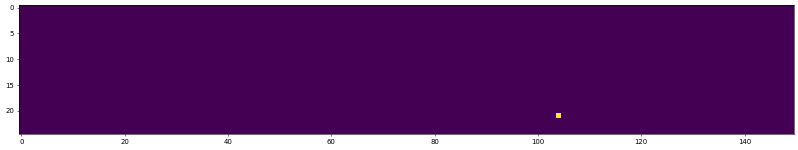

[731] {(134, 21)}


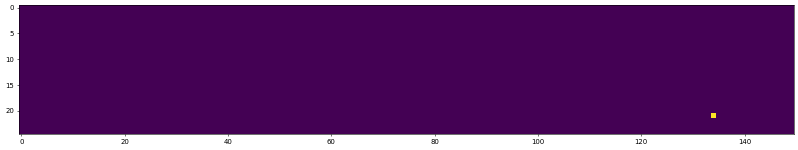

[748] {(72, 22)}


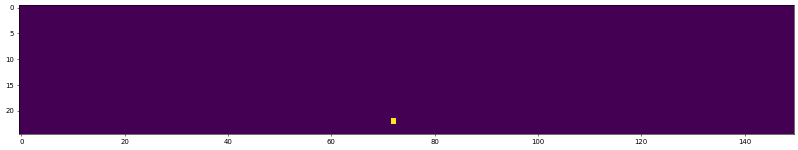

[796] {(132, 23)}


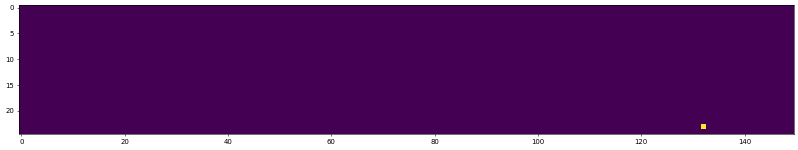

[819] {(121, 18), (122, 18)}


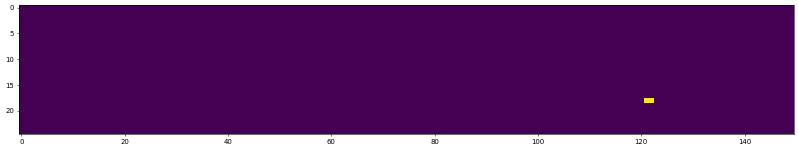

[855, 856] {(82, 8), (83, 8)}


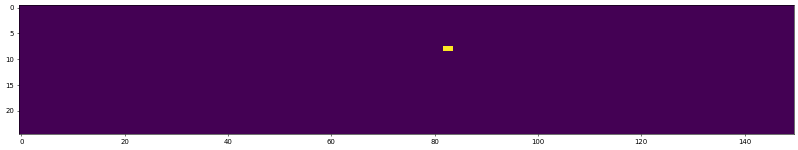

[862] {(139, 9)}


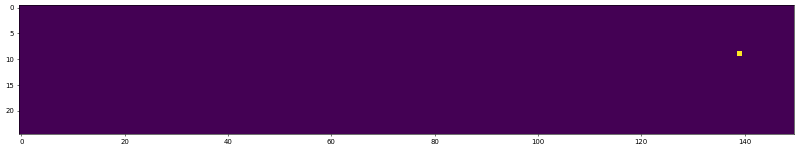

[946, 949] {(53, 17), (82, 1), (52, 17)}


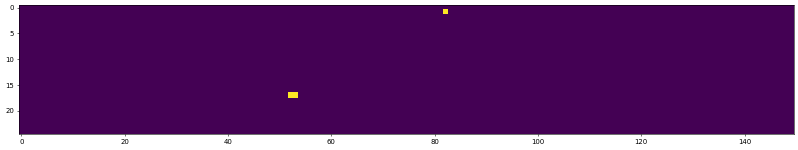

[953] {(56, 22)}


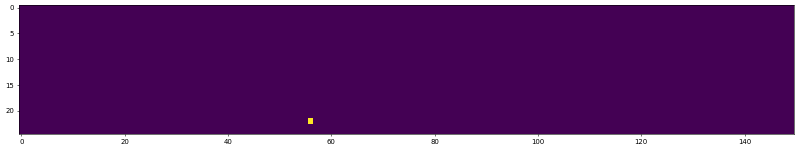

[1075, 1077, 1078] {(81, 1), (110, 1), (82, 1), (109, 1), (83, 1)}


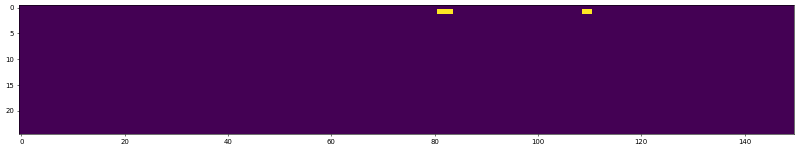

[1082, 1083] {(123, 24), (124, 24)}


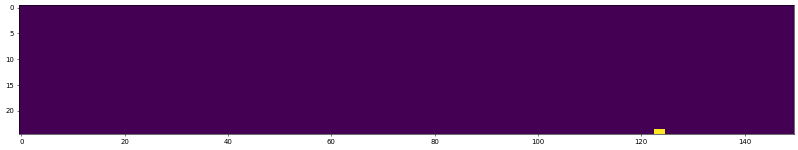

[1111] {(37, 3)}


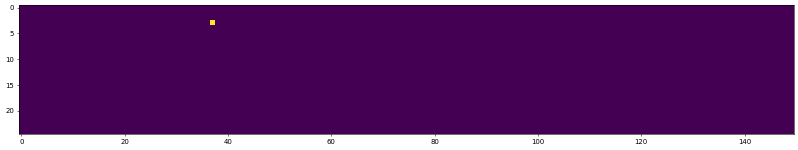

[1164, 1165] {(37, 3), (36, 3)}


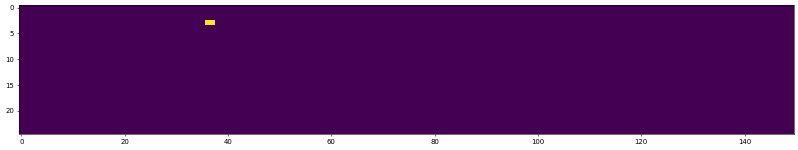

[1174, 1176] {(136, 24), (120, 2), (137, 24), (119, 2)}


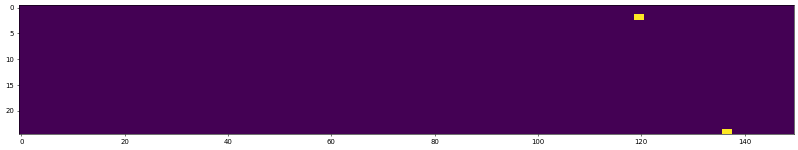

[1193] {(137, 12)}


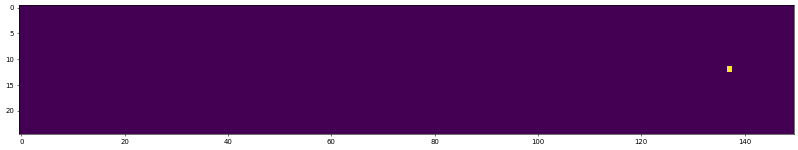

[1218, 1220] {(28, 11), (29, 11)}


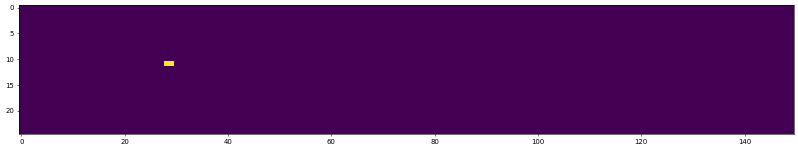

[1226] {(61, 18)}


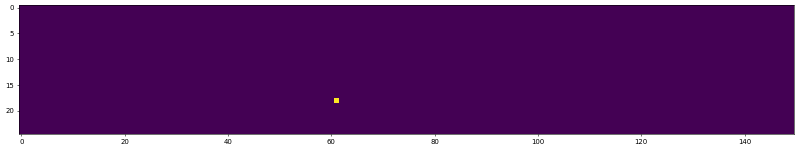

[1236] {(115, 22)}


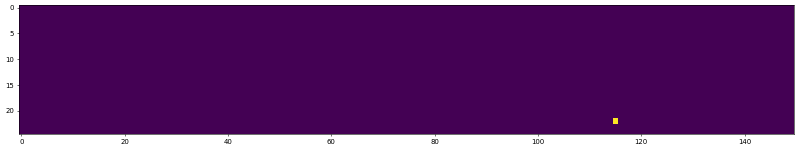

[1250] {(101, 24), (100, 24)}


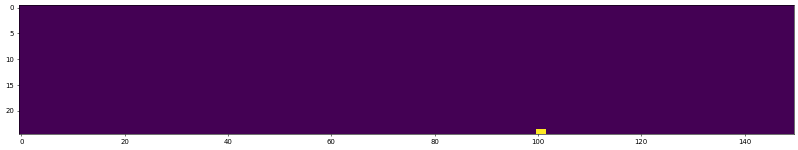

77 77 77
Liver_map_150z25_60s_#03.npy
[95] {(133, 19), (134, 19)}


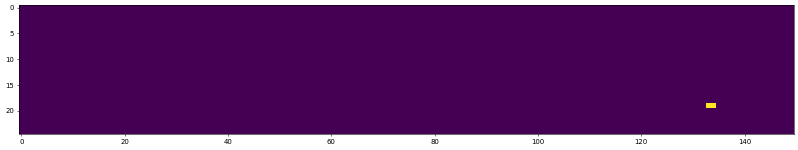

[104, 106] {(39, 12), (40, 12)}


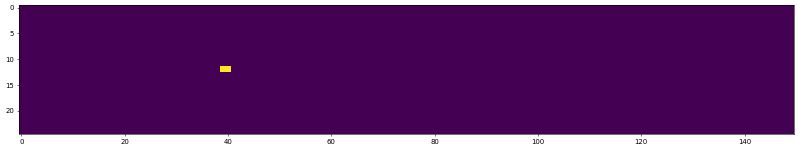

[121] {(143, 13)}


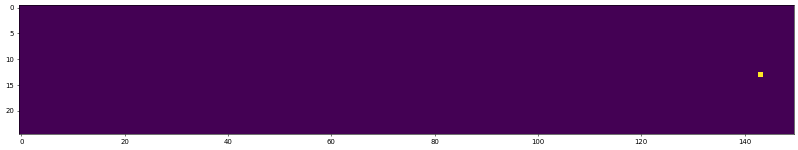

[200] {(90, 13)}


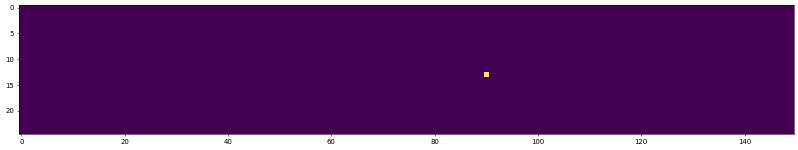

[213] {(127, 22)}


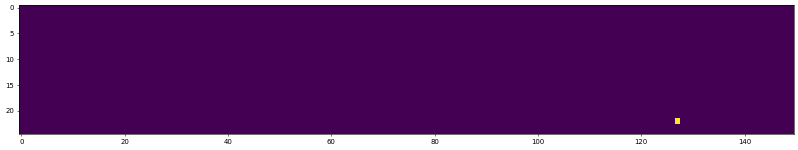

[226] {(9, 12)}


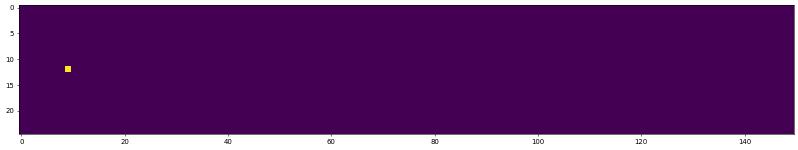

[235, 237, 238] {(11, 12), (99, 16), (126, 24), (98, 16)}


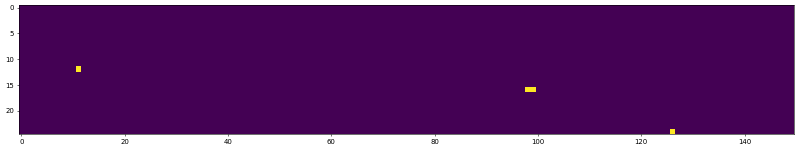

[246] {(13, 12)}


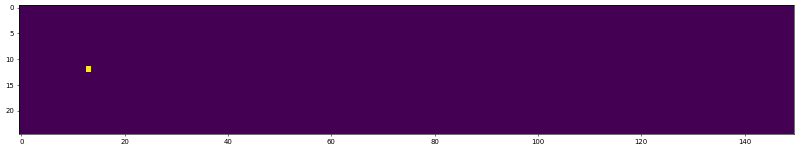

[250, 252] {(14, 12), (15, 12)}


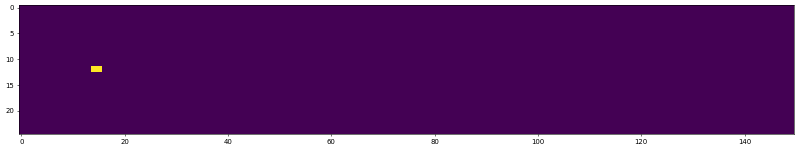

[257] {(25, 18)}


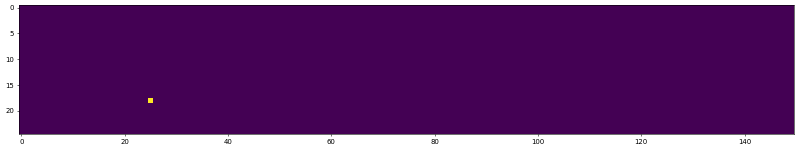

[265] {(26, 18)}


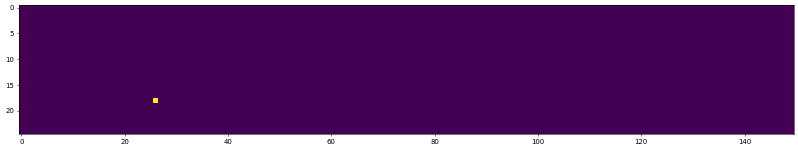

[291, 293, 295, 297, 299, 301] {(144, 14), (145, 14), (147, 14), (148, 14), (143, 14), (146, 14)}


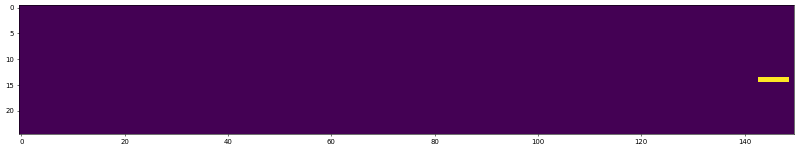

[348, 349, 351, 352] {(139, 6), (140, 6), (137, 6), (138, 6)}


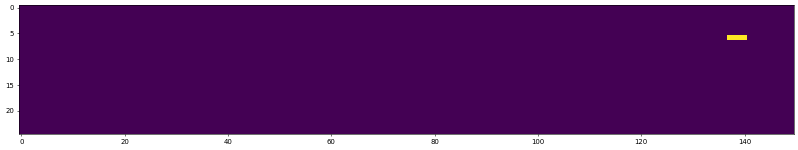

[383] {(117, 4)}


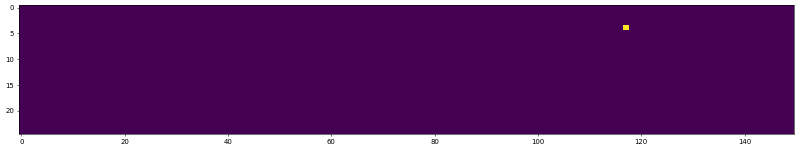

[394, 395, 396] {(98, 24), (99, 24), (100, 24)}


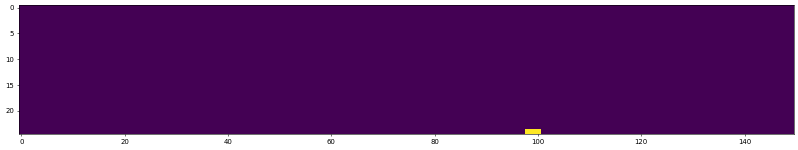

[420, 422, 423] {(74, 12), (75, 12), (76, 12)}


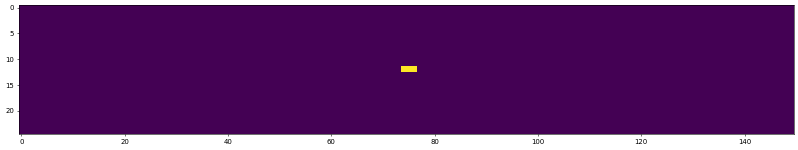

[474, 476, 478, 479, 481, 483, 485, 487, 488, 490, 492, 494, 495] {(108, 16), (141, 11), (84, 17), (109, 16), (104, 16), (99, 16), (105, 16), (100, 16), (106, 16), (101, 16), (107, 16), (102, 16), (103, 16), (110, 16)}


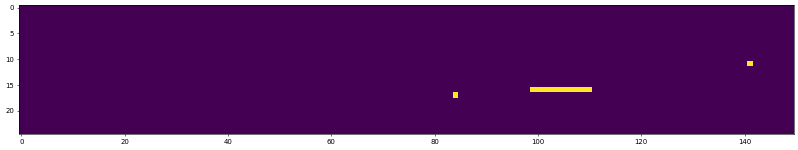

[545, 548] {(94, 11), (118, 20)}


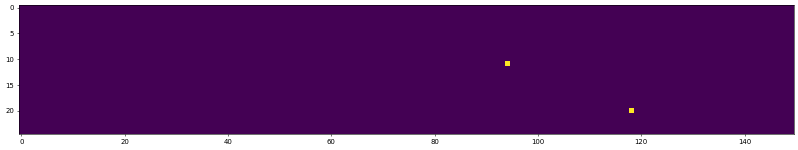

[587] {(2, 23)}


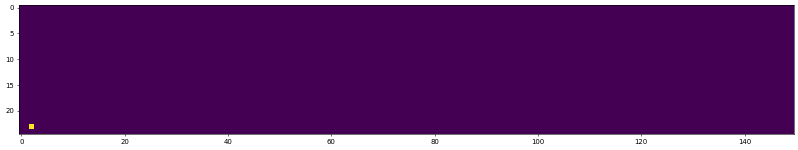

[634, 636, 637, 638, 640, 641, 642, 643, 645, 646, 647] {(25, 16), (21, 16), (33, 16), (23, 16), (35, 16), (30, 16), (24, 16), (36, 16), (31, 16), (26, 16), (19, 16), (32, 16), (27, 16), (22, 16), (20, 16)}


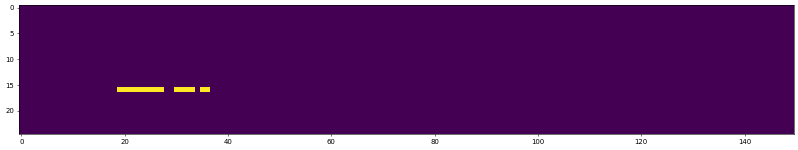

[683] {(146, 1)}


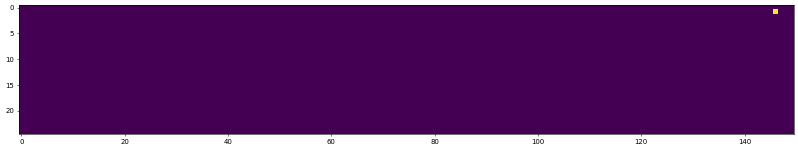

[719] {(95, 2), (96, 2)}


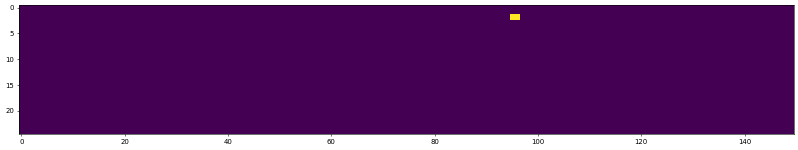

[764, 766] {(125, 19), (124, 19)}


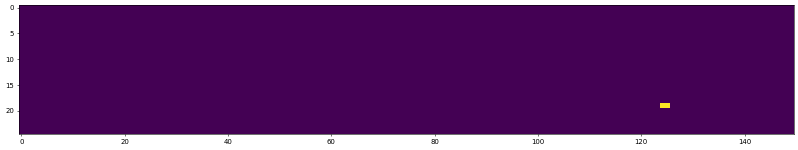

[937] {(34, 0)}


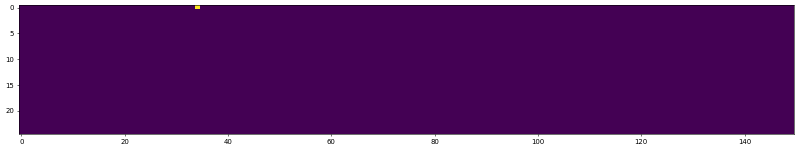

[963] {(43, 18)}


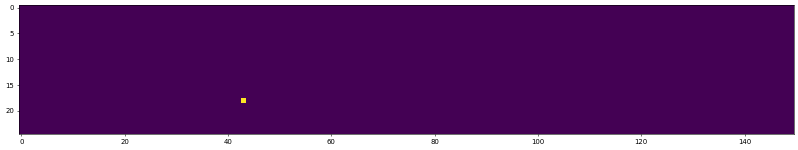

[971, 974, 975] {(134, 6), (125, 6), (133, 6), (124, 6), (43, 6)}


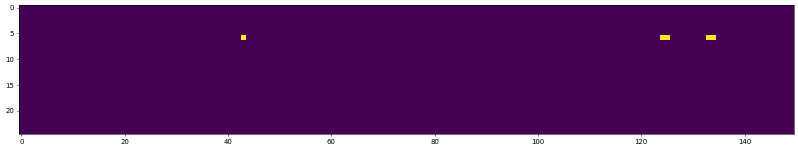

[1024] {(105, 11), (106, 11)}


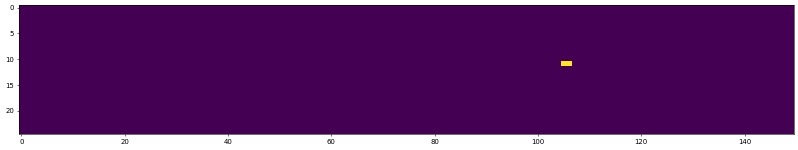

[1048] {(125, 14), (126, 14), (124, 14)}


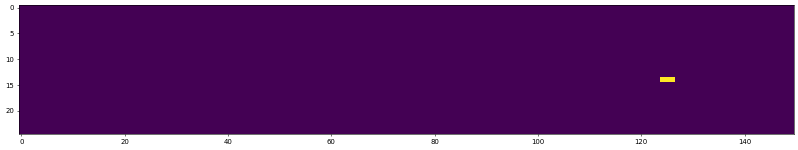

[1068] {(2, 5)}


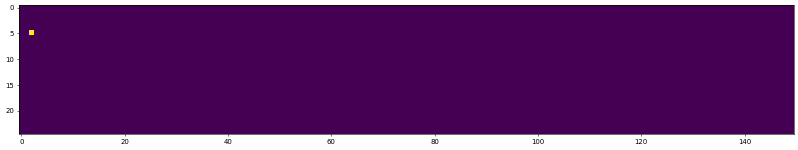

[1073] {(147, 4)}


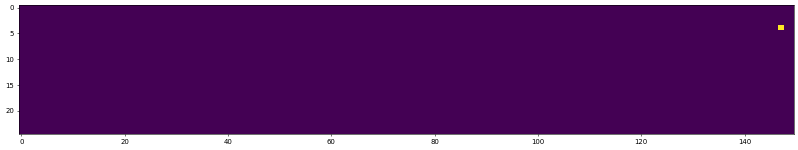

[1080, 1081, 1082, 1083, 1084] {(117, 24), (118, 24), (120, 24), (116, 24), (119, 24)}


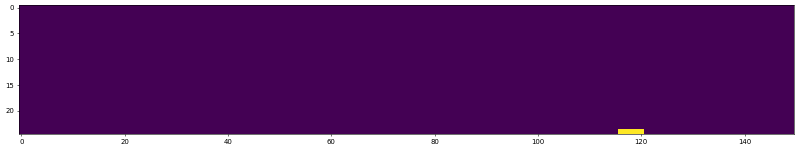

[1089, 1091] {(49, 23), (120, 24), (50, 23), (121, 24)}


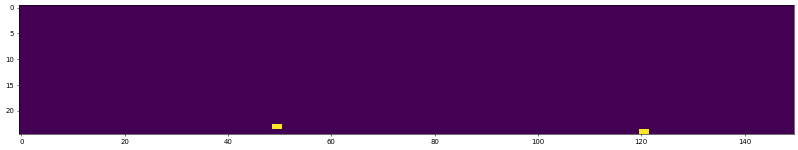

[1142, 1143] {(103, 13), (102, 13)}


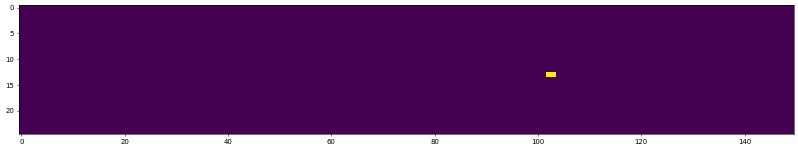

[1148] {(135, 16), (136, 16)}


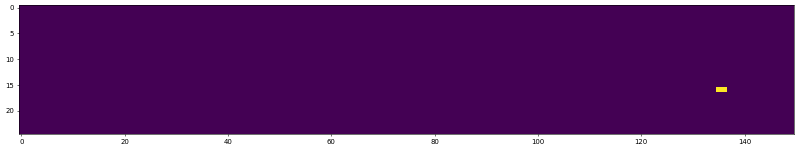

[1164, 1165, 1166, 1167, 1168] {(142, 7), (138, 7), (37, 3), (139, 7), (38, 3), (140, 7), (141, 7), (35, 3), (36, 3), (39, 3)}


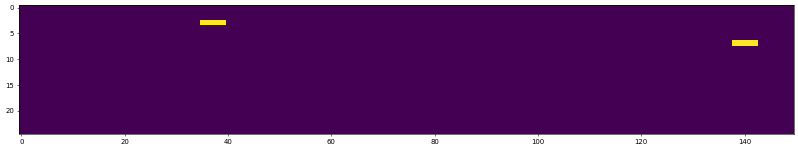

[1175] {(96, 5), (97, 5)}


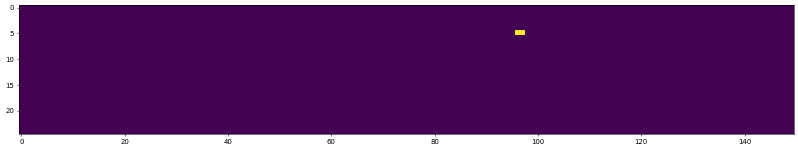

[1184] {(2, 11)}


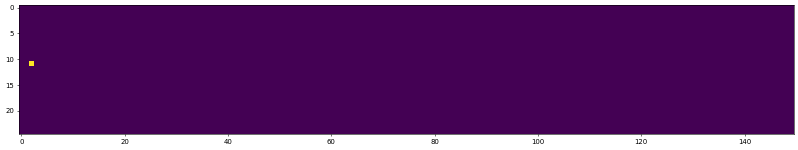

[1188, 1189, 1190] {(44, 3), (45, 3), (43, 3), (100, 11), (101, 11)}


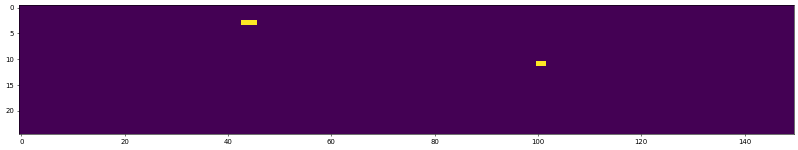

[1204] {(12, 7), (13, 7)}


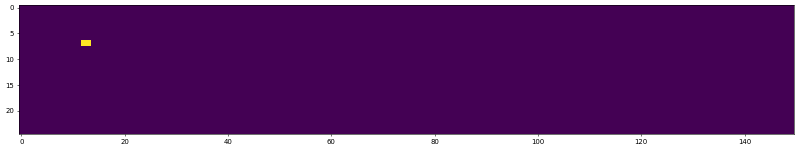

[1209, 1211, 1213] {(29, 9), (28, 9), (113, 18), (114, 18)}


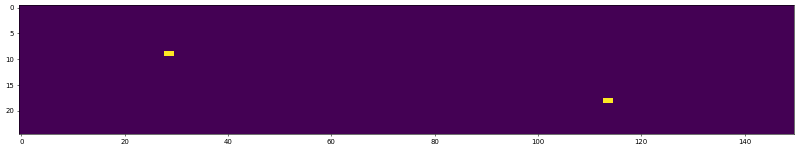

[1238, 1239, 1241, 1243, 1244] {(71, 17), (132, 23), (133, 23), (21, 13), (69, 17), (20, 13), (19, 13), (70, 17)}


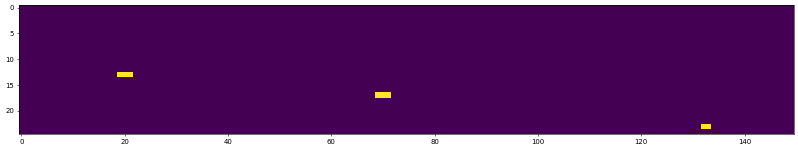

132 132 132
Muscle_map_150z25_60s_#25.npy
[114] {(113, 11), (114, 11)}


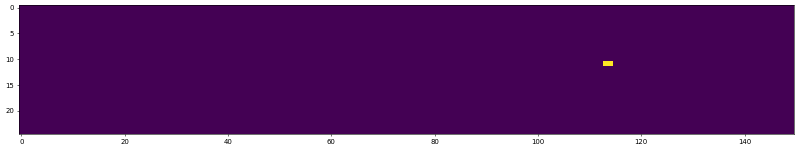

[243] {(126, 17), (30, 9)}


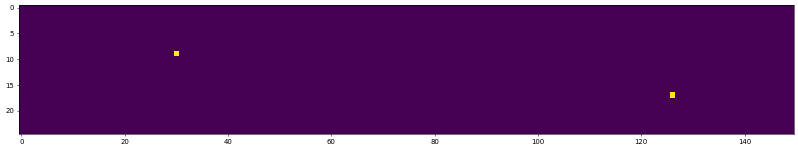

[262] {(63, 7), (62, 7)}


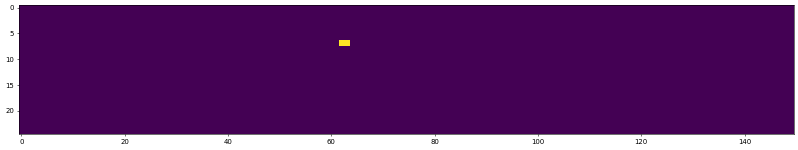

[321] {(86, 2)}


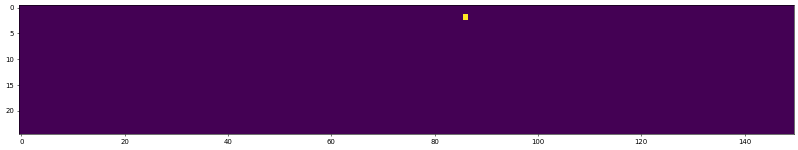

[372, 373] {(124, 15), (123, 15), (125, 15), (126, 15)}


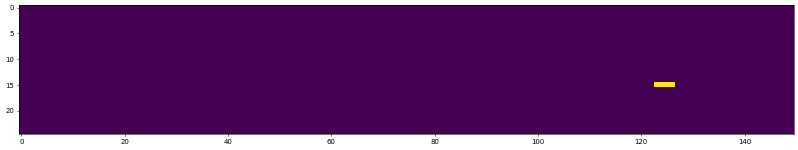

[379] {(113, 11)}


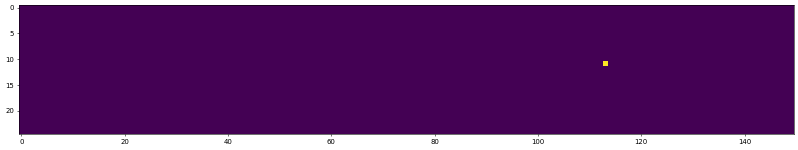

[386] {(113, 11), (114, 11)}


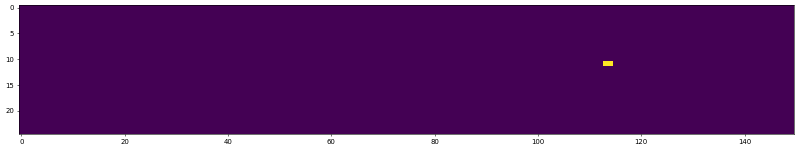

[405, 407] {(73, 8), (74, 8), (75, 8)}


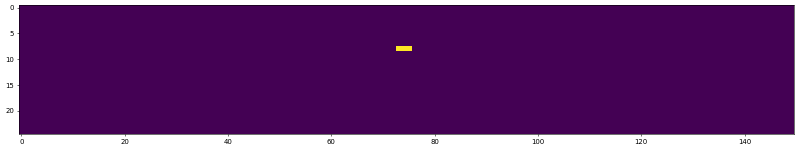

[430] {(143, 7)}


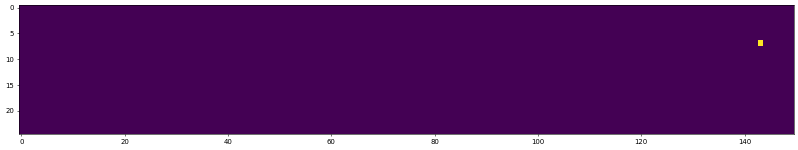

[438, 439, 441] {(82, 7), (83, 7), (81, 7)}


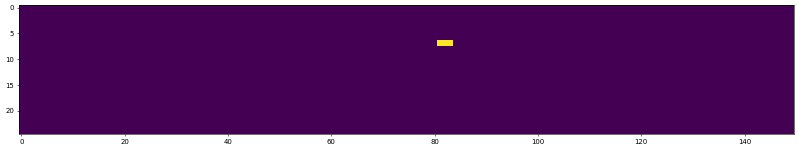

[490] {(69, 24)}


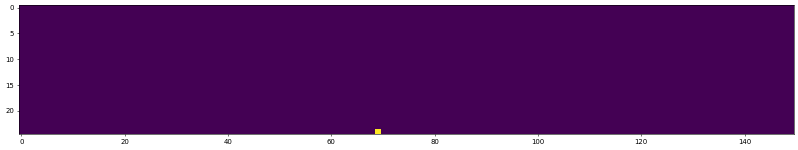

[551, 552, 553] {(49, 12), (50, 12), (51, 12), (52, 12)}


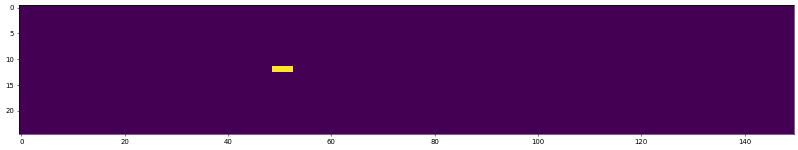

[561, 562, 564, 565] {(118, 22), (119, 22), (117, 22), (120, 22)}


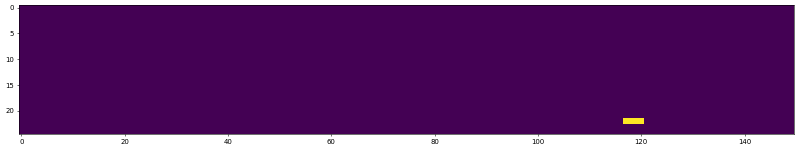

[584] {(118, 22)}


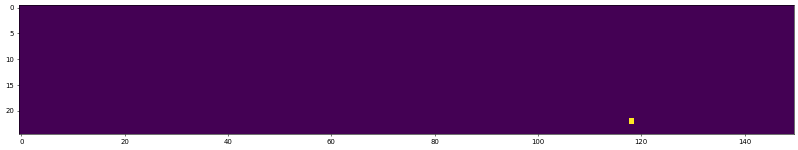

[616] {(132, 21)}


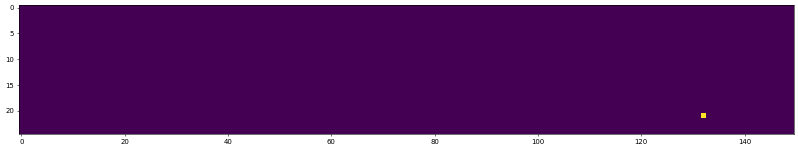

[629, 630] {(130, 2), (129, 2)}


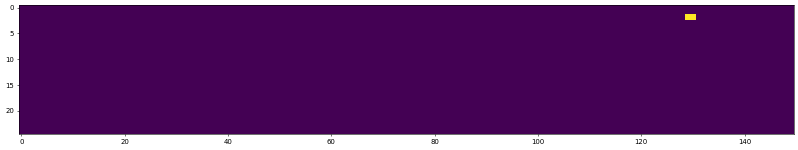

[663] {(73, 17)}


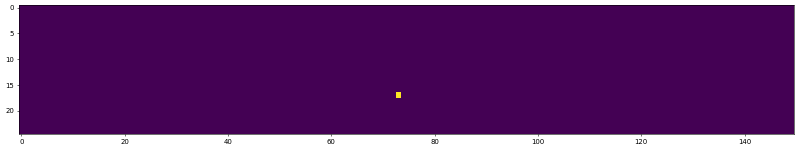

[675, 676] {(120, 14), (87, 22), (121, 14)}


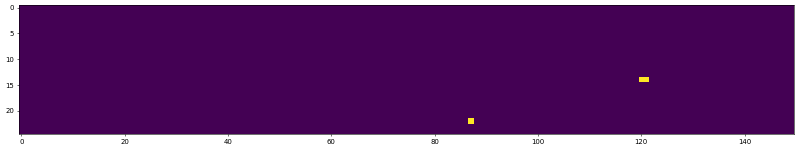

[683] {(69, 16), (70, 16)}


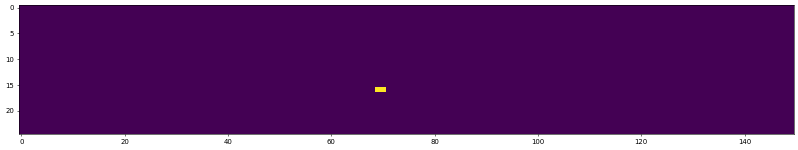

[704] {(140, 13)}


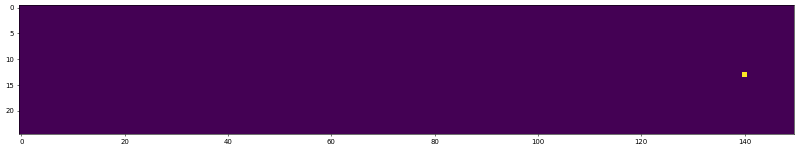

[710, 713] {(140, 4), (141, 4)}


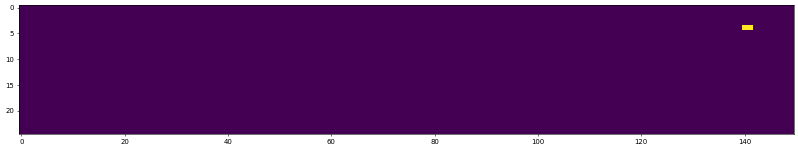

[730] {(63, 5), (64, 5)}


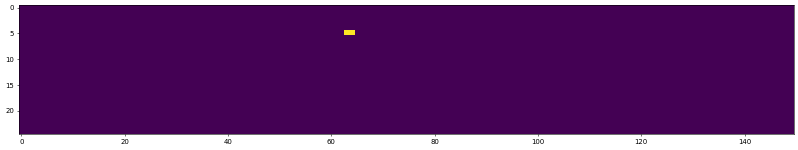

[739, 740, 741, 742] {(16, 7), (14, 7), (15, 7), (61, 21), (62, 21)}


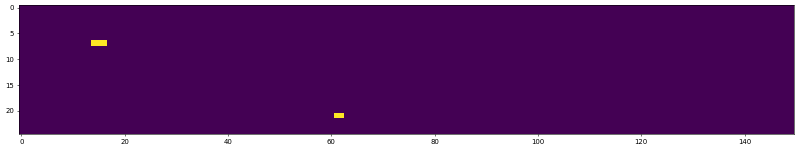

[783] {(149, 21)}


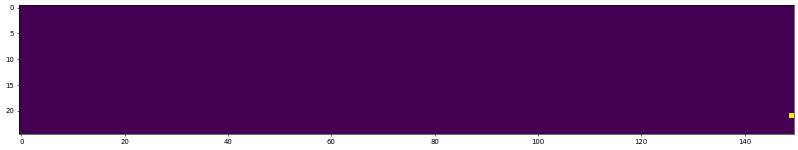

[796, 798] {(23, 21), (22, 21)}


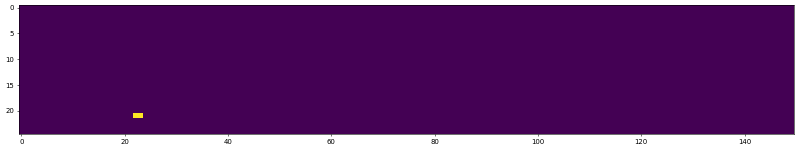

[819, 820, 821] {(137, 23), (138, 23), (145, 4), (147, 4), (146, 4)}


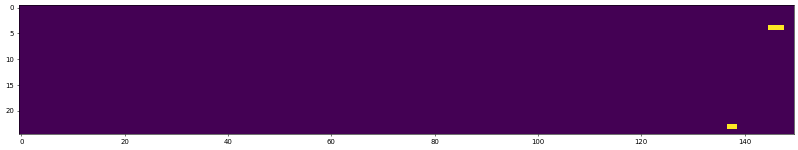

[827] {(132, 2)}


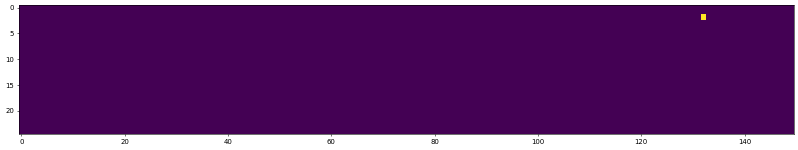

[848] {(140, 7)}


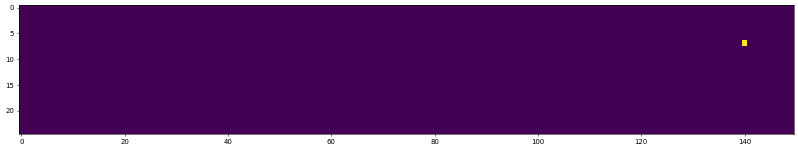

[884, 885, 886, 887, 888, 889] {(34, 4), (29, 4), (30, 4), (82, 16), (31, 4), (83, 16), (32, 4), (81, 16), (33, 4)}


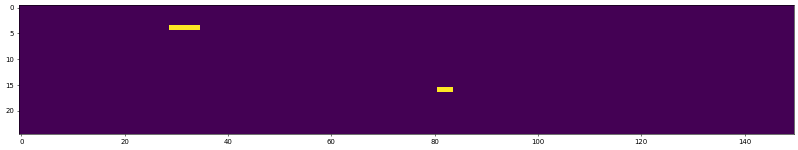

[898, 899] {(71, 12), (69, 12), (70, 12)}


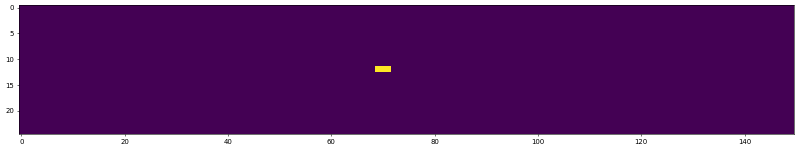

[976, 977] {(140, 23), (141, 23)}


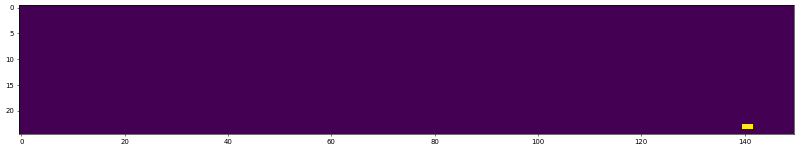

[983] {(76, 2), (75, 2)}


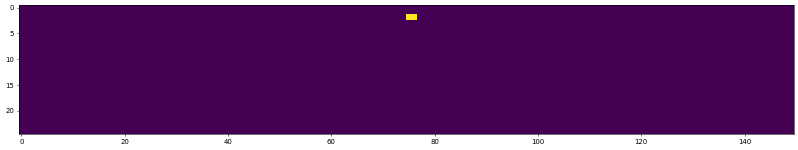

[1022, 1023] {(135, 21), (136, 21), (134, 21), (137, 21), (133, 21)}


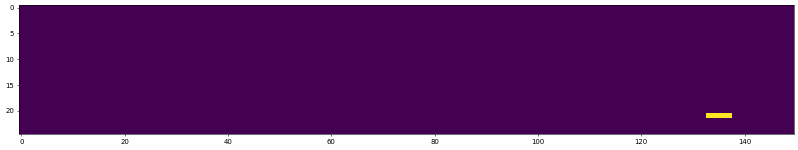

[1055, 1057] {(123, 17), (124, 17)}


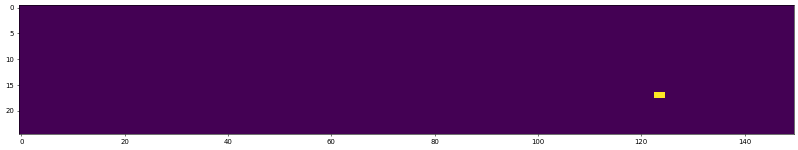

[1071, 1073] {(127, 20), (128, 20)}


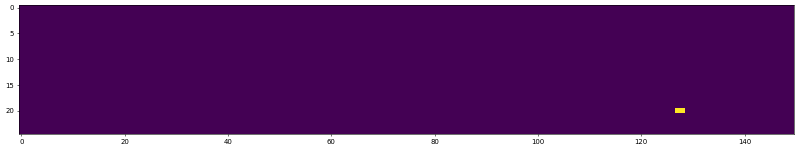

[1079, 1080] {(101, 20), (102, 20)}


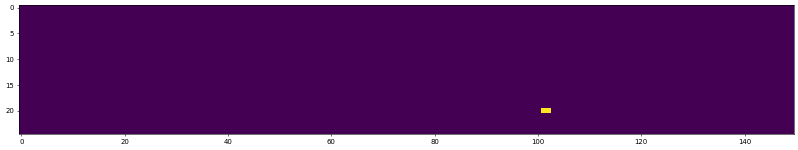

[1096, 1097] {(50, 12), (51, 12), (142, 4)}


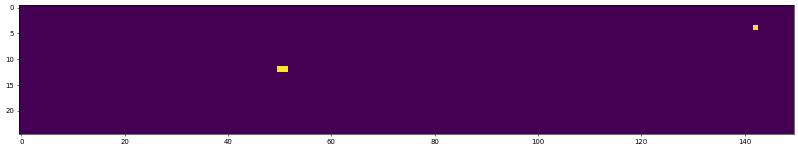

[1159] {(149, 8)}


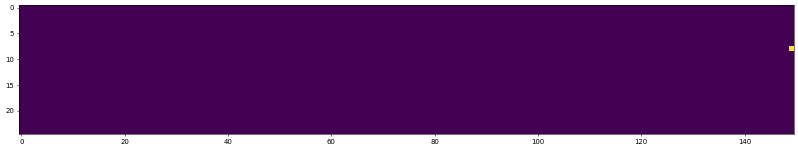

[1196, 1197] {(147, 18), (148, 18)}


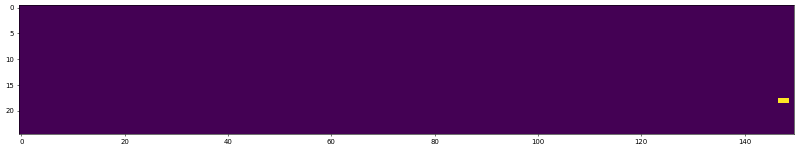

[1207, 1210, 1211] {(67, 4), (68, 4), (69, 4), (32, 4), (33, 4), (66, 4)}


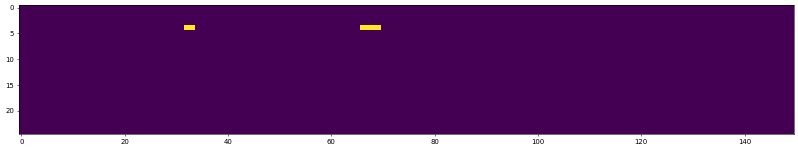

[1221] {(92, 23)}


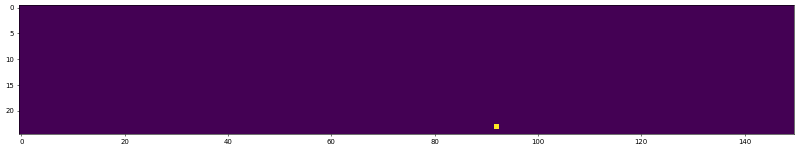

[1242, 1244] {(16, 9), (15, 9)}


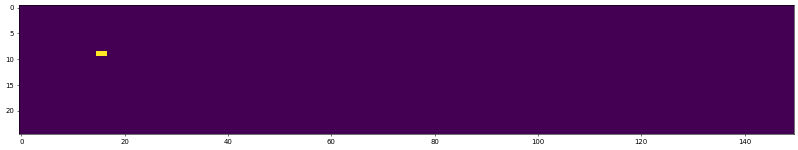

98 98 98
Kidney_map_150z25_60s_#36.npy
[24, 25] {(84, 18), (82, 18), (83, 18)}


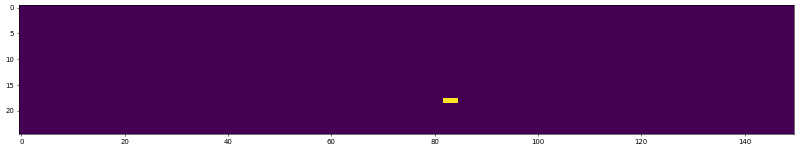

[44, 46] {(98, 2), (97, 2)}


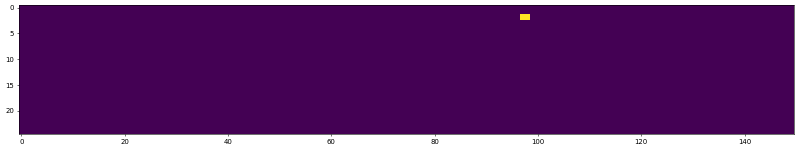

[66, 68, 71, 72] {(149, 20), (147, 20), (146, 20), (148, 20)}


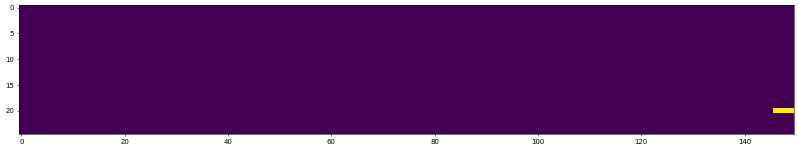

[77, 79, 82] {(49, 7), (59, 9), (60, 9), (58, 9)}


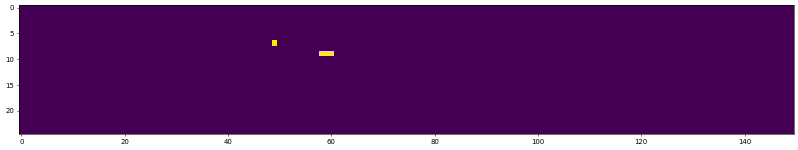

[88] {(61, 9)}


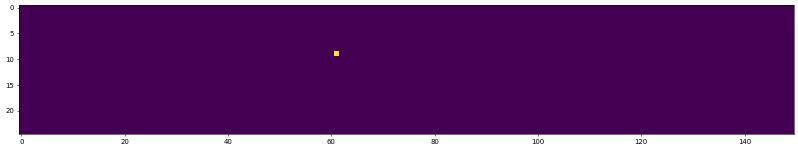

[152] {(27, 23)}


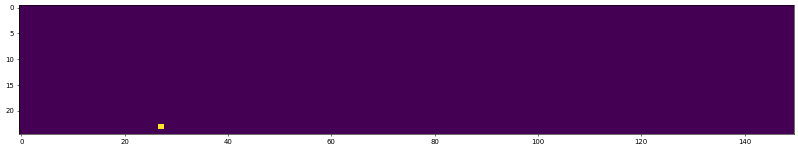

[158, 160] {(42, 21), (43, 21), (40, 21), (41, 21)}


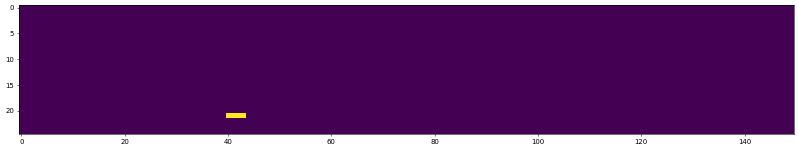

[164] {(138, 14)}


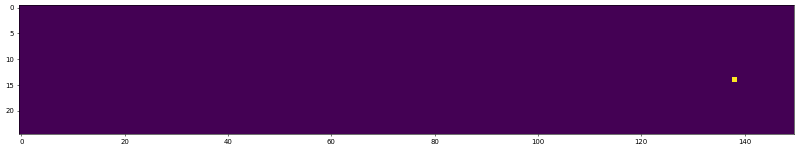

[168] {(5, 19)}


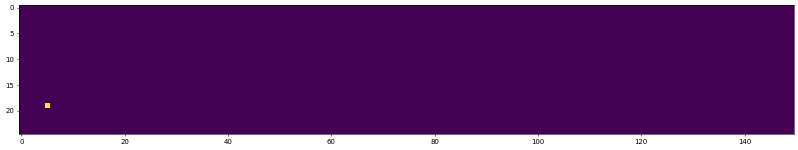

[194] {(143, 21)}


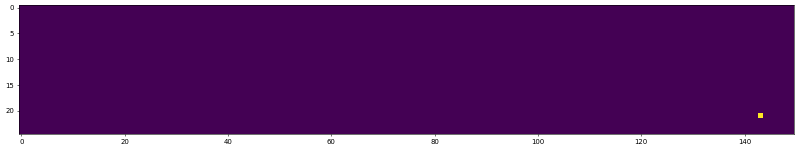

[264] {(61, 7), (62, 7)}


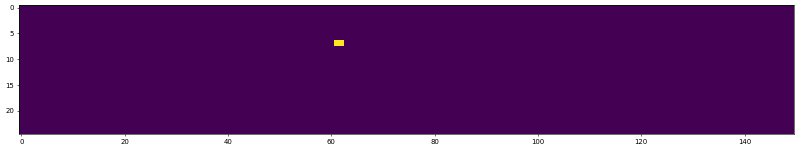

[271] {(7, 15), (6, 15)}


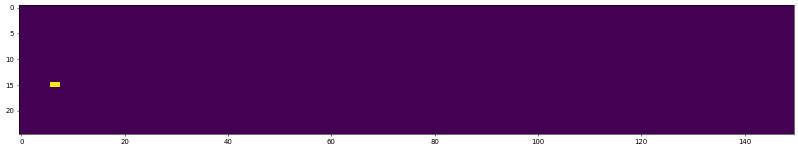

[317, 319] {(108, 4), (107, 4)}


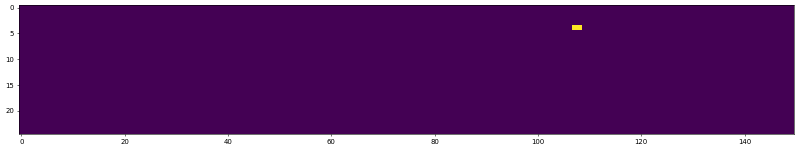

[351, 353] {(38, 21), (39, 21)}


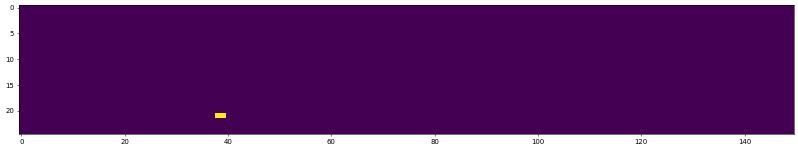

[357] {(113, 13)}


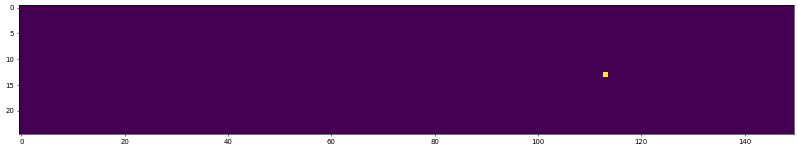

[445] {(149, 7)}


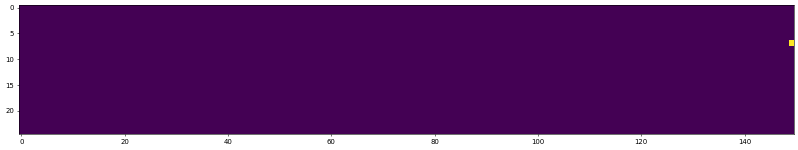

[463] {(146, 2), (147, 2)}


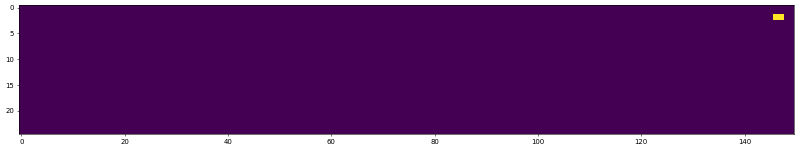

[473] {(7, 4), (6, 4)}


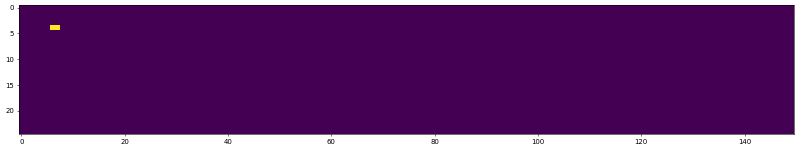

[508] {(61, 19)}


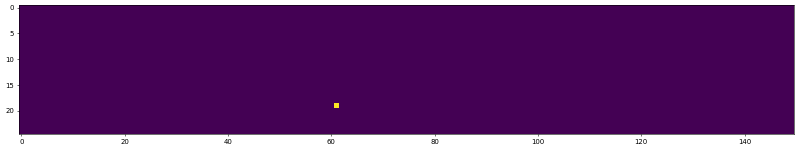

[554, 555] {(64, 18), (65, 18)}


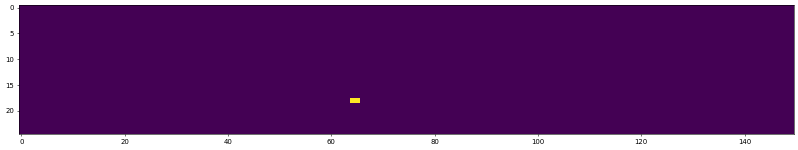

[567, 569, 571] {(49, 24), (144, 2), (145, 2)}


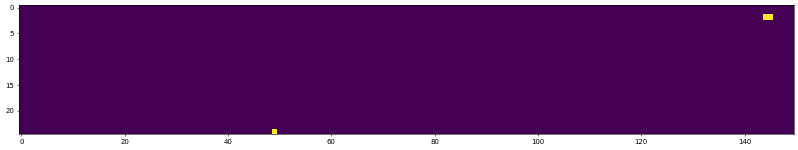

[576] {(144, 12)}


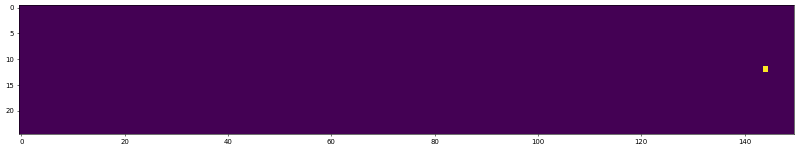

[584] {(49, 24)}


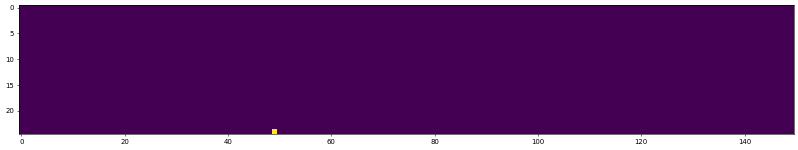

[629, 630] {(115, 22), (114, 22)}


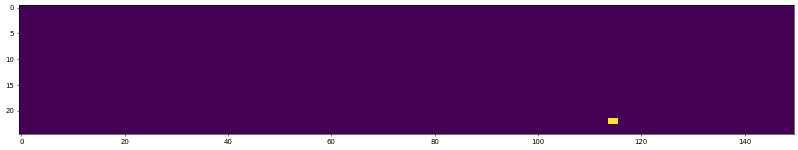

[641, 642] {(95, 1), (94, 1)}


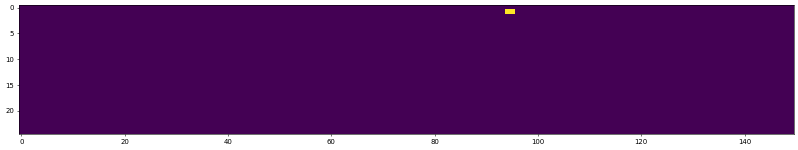

[664] {(126, 15)}


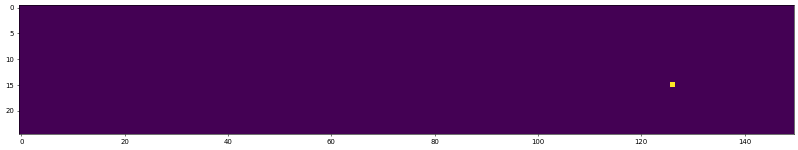

[668] {(103, 8)}


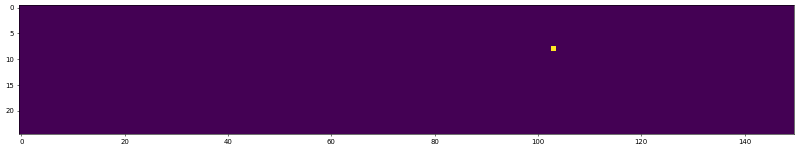

[699] {(64, 23), (65, 23)}


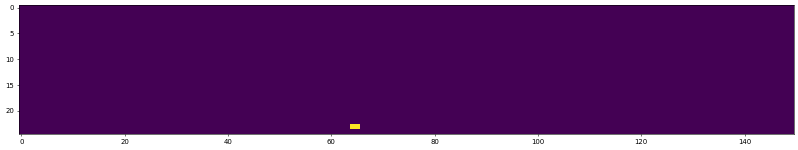

[704, 705, 707, 709] {(55, 23), (54, 23), (56, 23), (57, 23)}


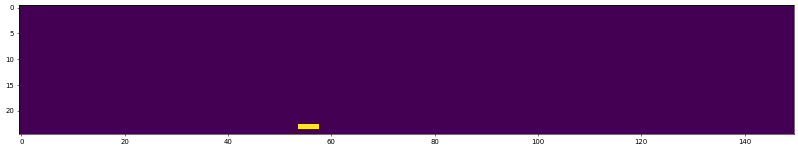

[742, 743] {(110, 0), (111, 0)}


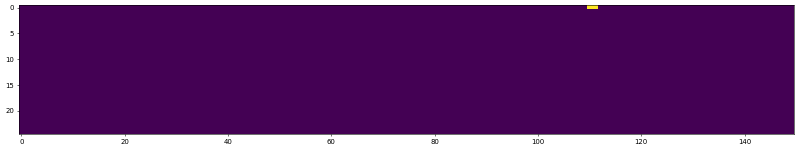

[750] {(139, 24), (140, 24)}


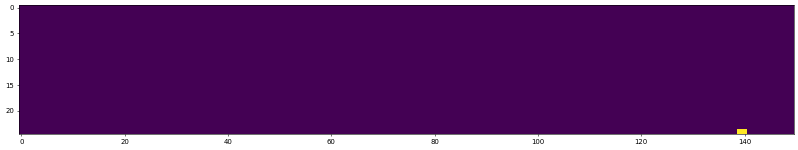

[757, 758, 759] {(117, 2), (118, 2), (116, 2)}


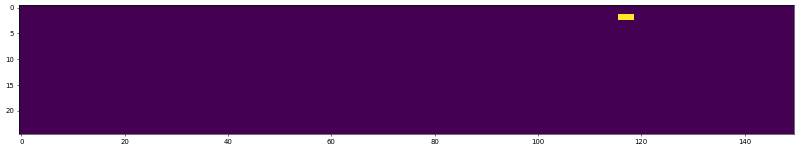

[775, 777] {(36, 23), (37, 23)}


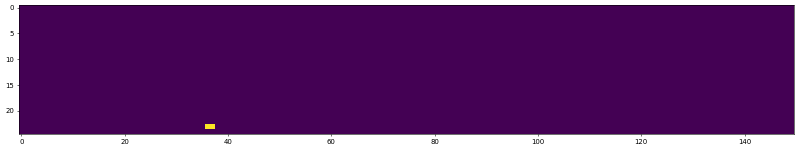

[794] {(115, 2)}


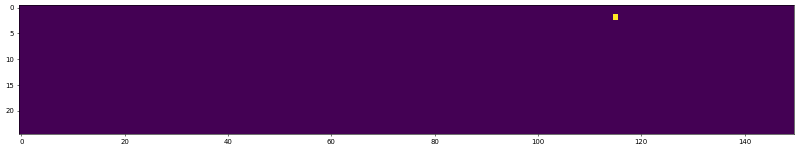

[800] {(82, 18), (83, 18)}


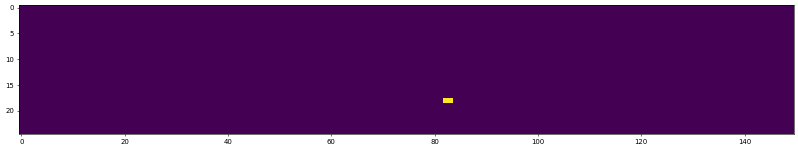

[826, 829, 830] {(149, 13), (147, 13), (148, 13), (76, 9), (77, 9)}


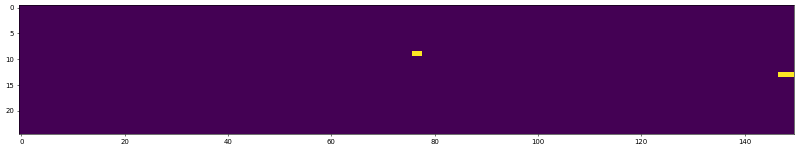

[874, 876, 877, 878, 879, 880] {(120, 15), (115, 15), (116, 15), (117, 15), (118, 15), (119, 15), (114, 15)}


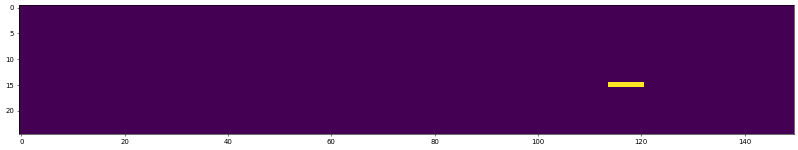

[903, 905, 906] {(137, 11), (135, 11), (138, 11), (136, 11)}


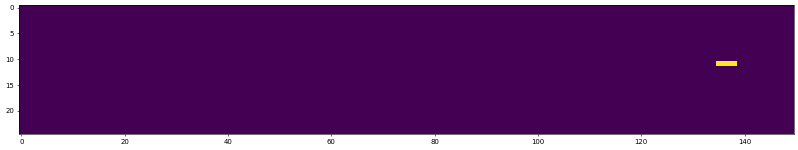

[914] {(130, 11), (131, 11)}


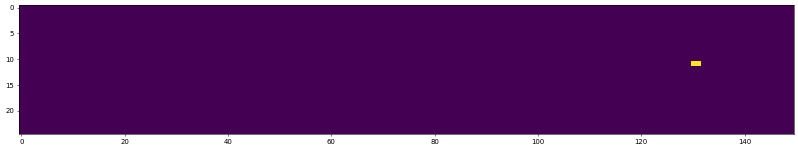

[939] {(133, 8), (134, 8)}


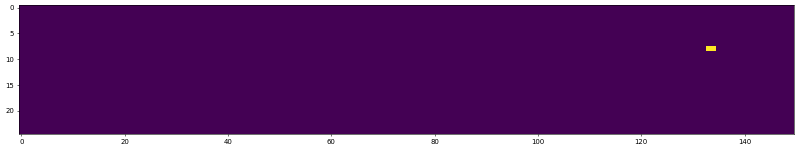

[955, 956] {(79, 20), (80, 20)}


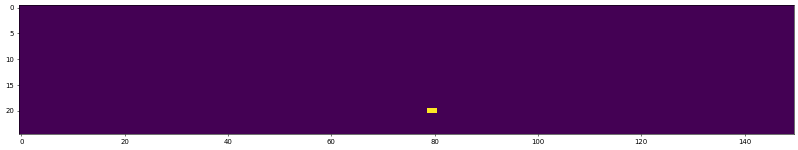

[965] {(8, 2)}


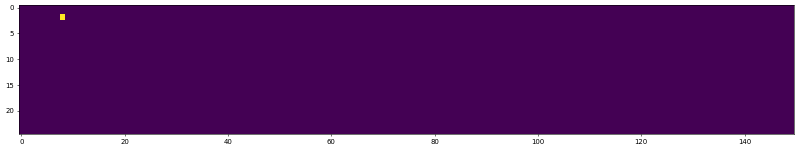

[978] {(40, 20)}


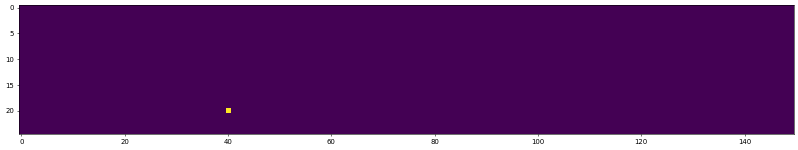

[993, 994, 995] {(144, 24), (74, 19), (145, 24), (75, 19)}


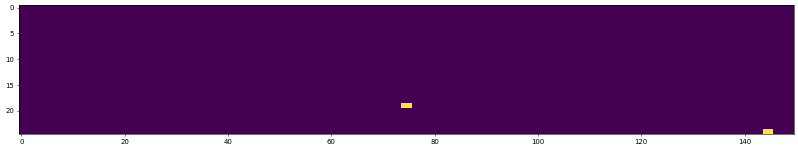

[1015, 1016, 1017, 1018] {(82, 23), (84, 23), (86, 23), (77, 23), (75, 23), (88, 23), (90, 23), (79, 23), (81, 23), (92, 23), (83, 23), (85, 23), (74, 23), (76, 23), (87, 23), (89, 23), (78, 23), (80, 23), (91, 23), (93, 23)}


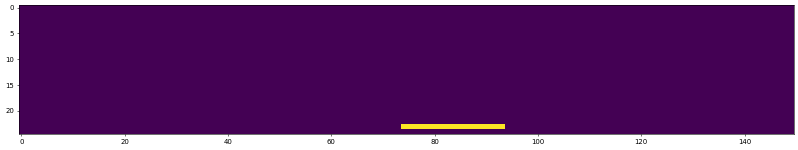

[1056, 1057, 1058, 1059, 1060, 1061, 1062, 1064, 1065, 1066] {(13, 14), (19, 14), (14, 14), (20, 14), (15, 14), (66, 9), (67, 9), (16, 14), (11, 14), (17, 14), (12, 14), (18, 14)}


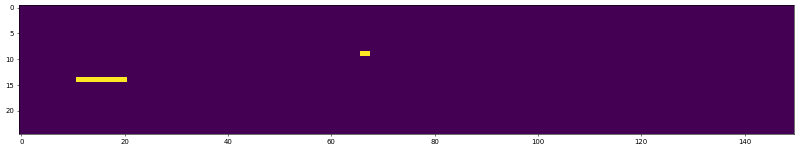

[1078, 1079, 1080] {(80, 7), (104, 24), (105, 24)}


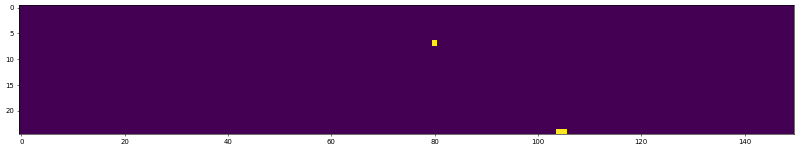

[1087, 1089] {(12, 20), (27, 9), (13, 20), (28, 9)}


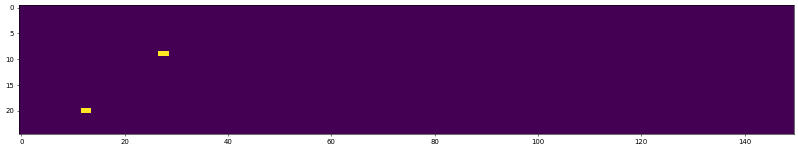

[1098, 1100, 1101, 1102, 1103] {(105, 20), (100, 20), (106, 20), (101, 20), (111, 20), (107, 20), (102, 20), (112, 20), (103, 20), (104, 20), (110, 20), (113, 20), (108, 20), (13, 5), (109, 20), (14, 5), (99, 20)}


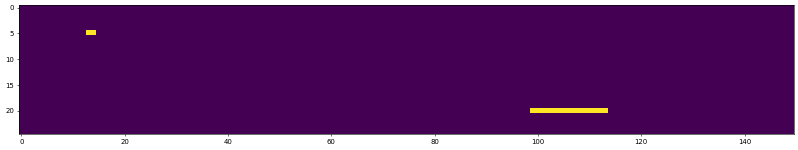

[1107] {(131, 0)}


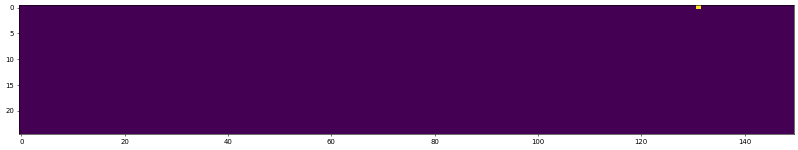

[1114] {(111, 9)}


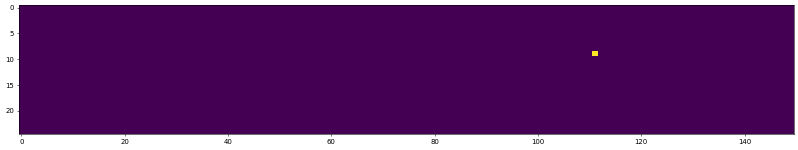

[1118] {(112, 9)}


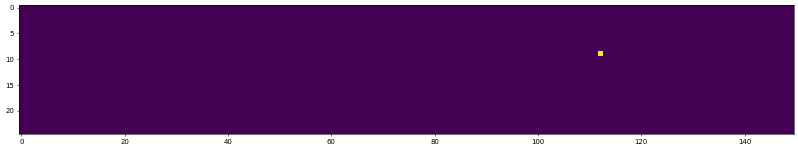

[1128, 1130] {(69, 6), (70, 6)}


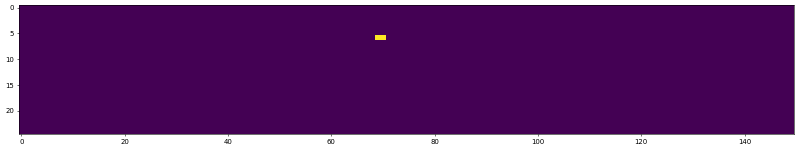

[1140, 1141, 1142, 1143, 1144] {(5, 5), (148, 2), (6, 5), (9, 5), (4, 5), (149, 2), (7, 5), (8, 5), (3, 5)}


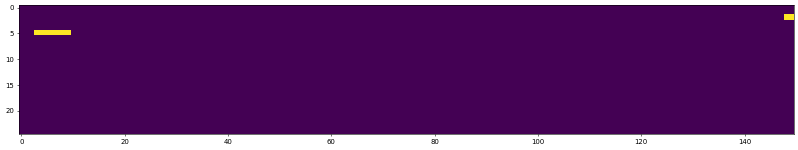

[1215, 1216, 1217] {(70, 10), (68, 10), (71, 10), (69, 10)}


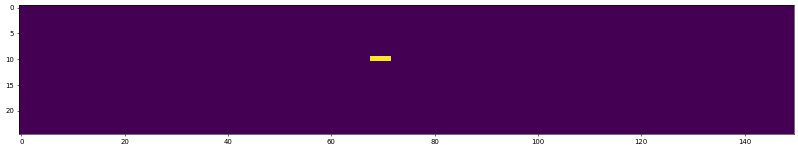

[1223, 1224, 1225] {(125, 2), (123, 2), (124, 2)}


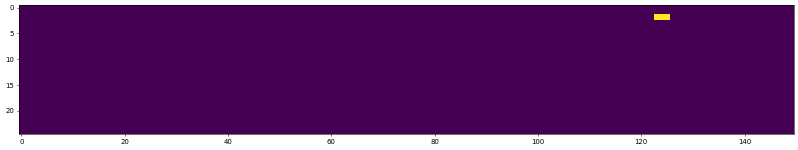

170 170 170
Liver_map_150x25_60s_#9.npy
[23, 25, 26] {(144, 2), (142, 2), (143, 2)}


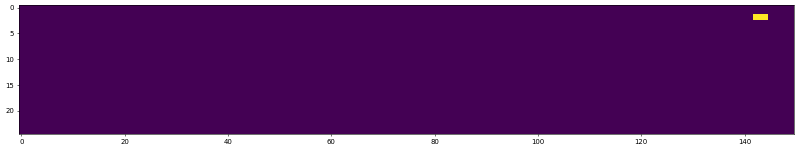

[36] {(92, 24)}


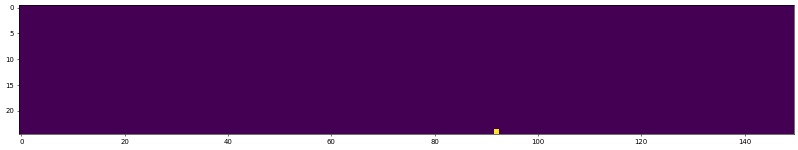

[78] {(35, 16)}


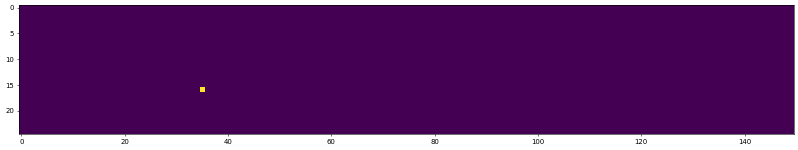

[103] {(45, 1), (46, 1)}


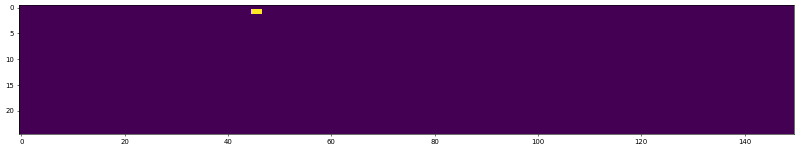

[111] {(45, 1)}


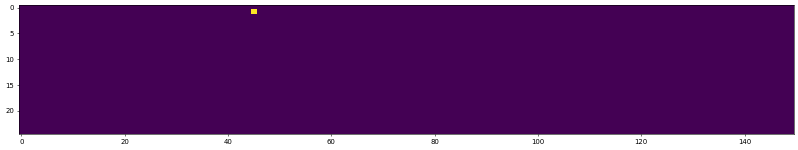

[121, 123] {(114, 4), (115, 4)}


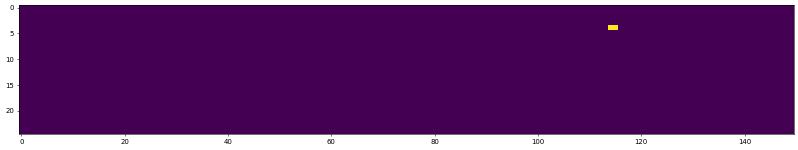

[138] {(45, 1)}


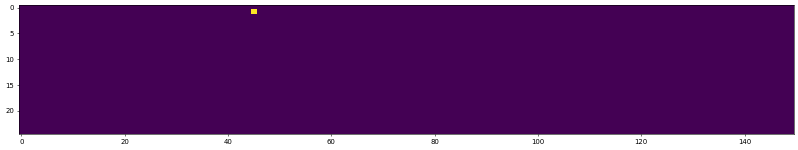

[143] {(45, 1)}


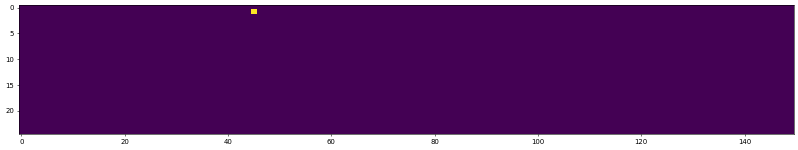

[182] {(73, 2), (74, 2), (75, 2)}


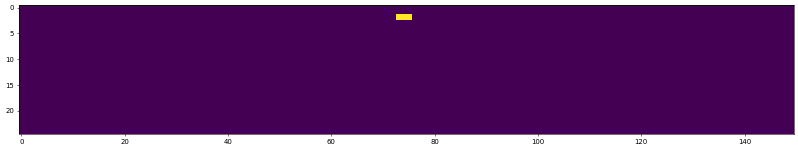

[207] {(50, 10), (49, 10)}


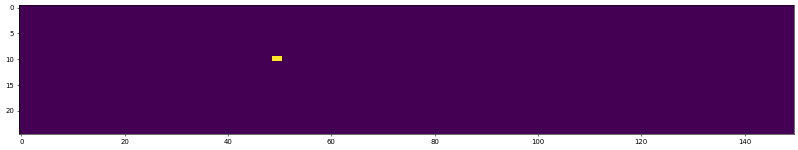

[260] {(51, 12)}


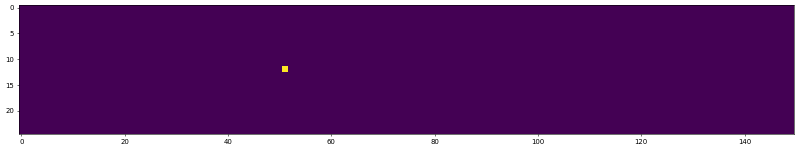

[268, 269] {(129, 0), (130, 0)}


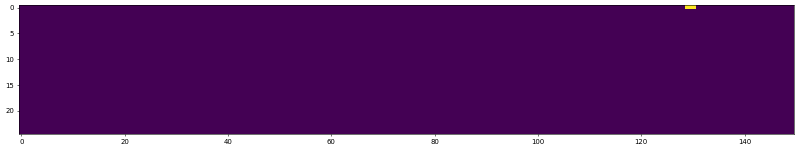

[298] {(8, 14), (9, 14)}


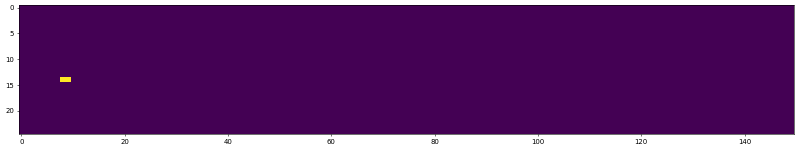

[312, 314] {(132, 9), (133, 9), (134, 9)}


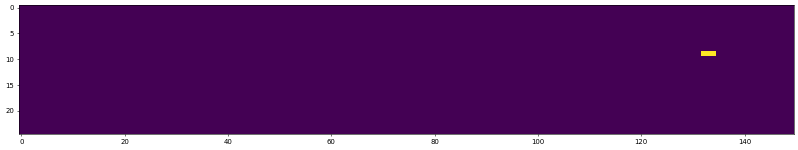

[330, 331] {(24, 20), (25, 20), (26, 20)}


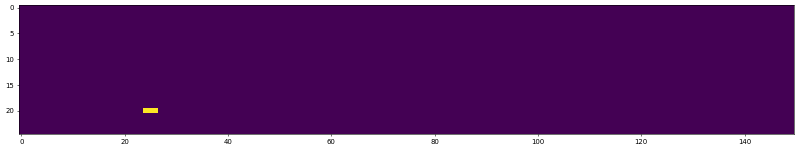

[336] {(11, 8)}


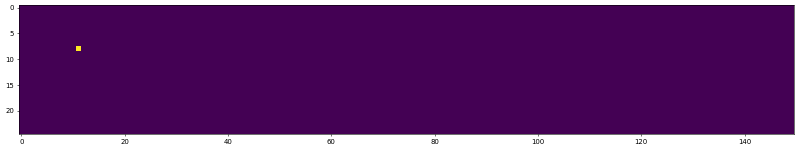

[357, 359, 361] {(34, 9), (94, 10), (35, 9), (93, 10)}


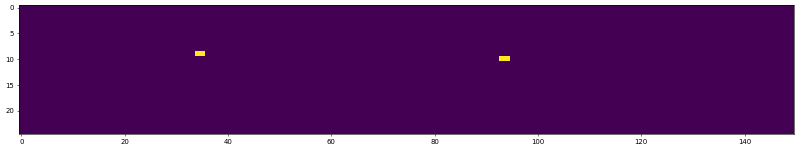

[380, 381] {(54, 14), (53, 14)}


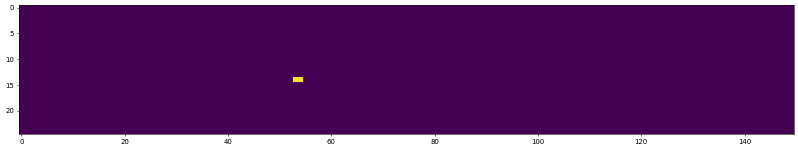

[398] {(87, 1), (86, 1)}


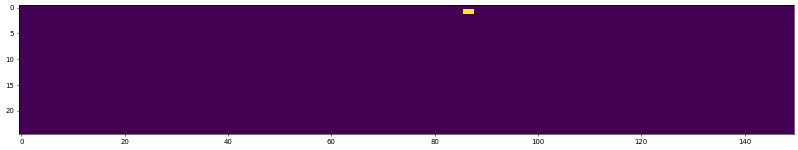

[499, 501] {(16, 20), (17, 20), (15, 20), (18, 20)}


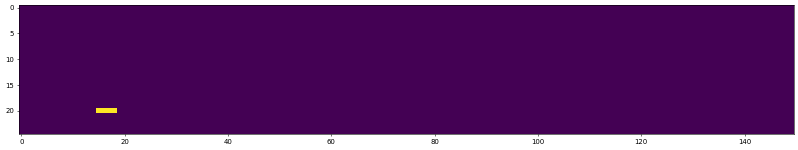

[507] {(131, 1), (132, 1)}


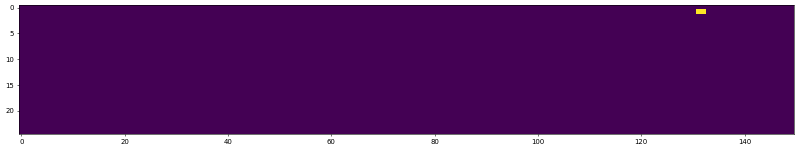

[515, 518, 519] {(83, 4), (92, 3), (84, 4)}


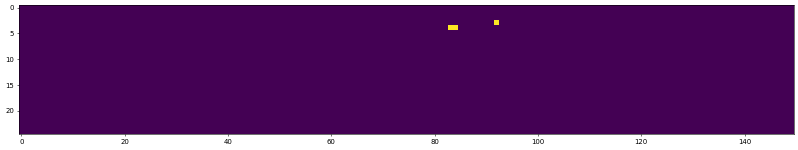

[528, 530] {(142, 0), (140, 0), (141, 0), (139, 0)}


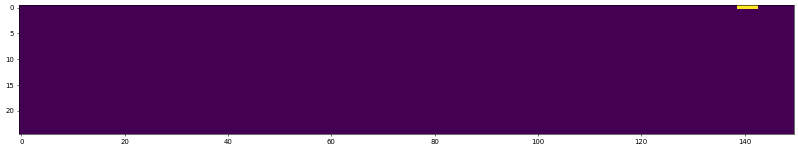

[539] {(106, 4), (107, 4)}


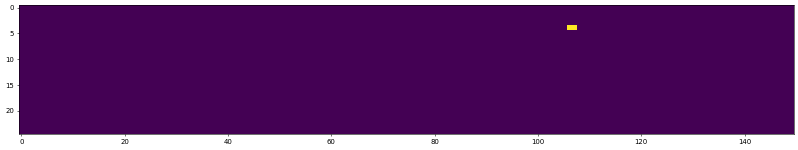

[572] {(81, 4)}


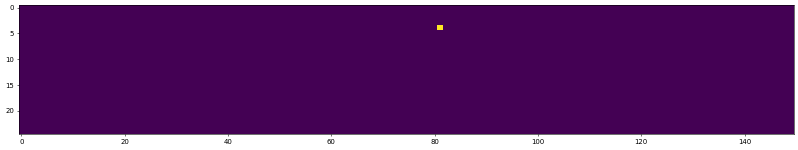

[578] {(116, 22)}


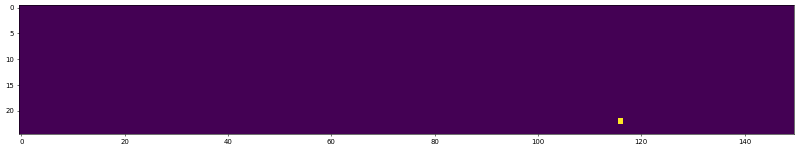

[584] {(116, 22)}


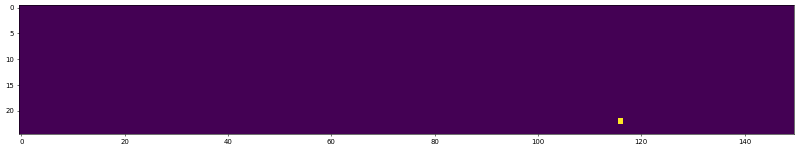

[589] {(84, 20), (85, 20)}


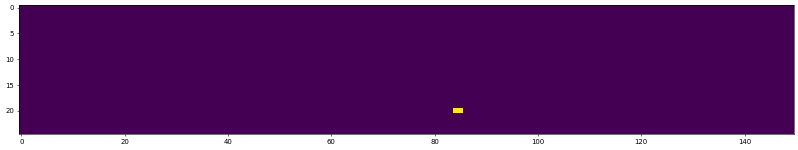

[607] {(108, 0)}


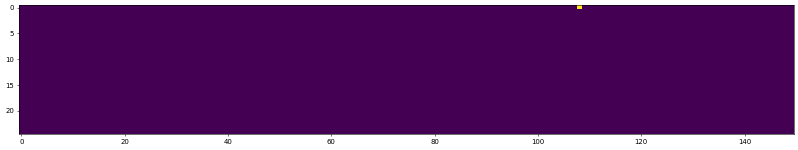

[614] {(118, 16), (117, 16)}


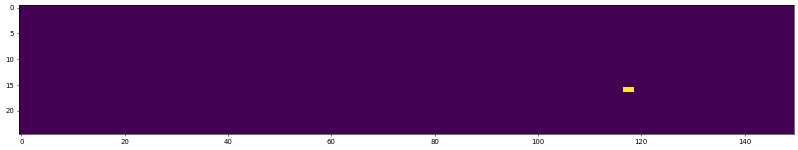

[641] {(148, 4)}


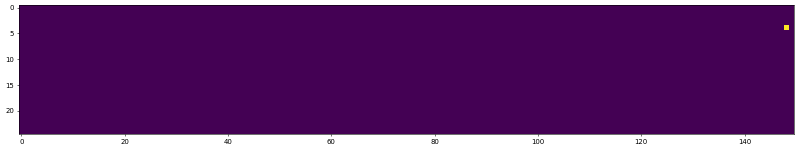

[652] {(102, 24), (103, 24)}


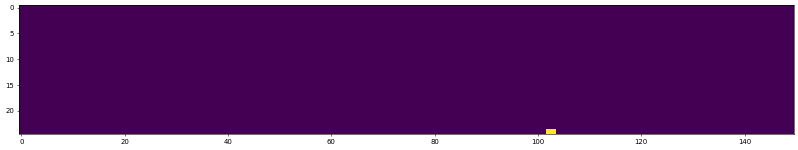

[685, 686] {(68, 19), (142, 20), (143, 20)}


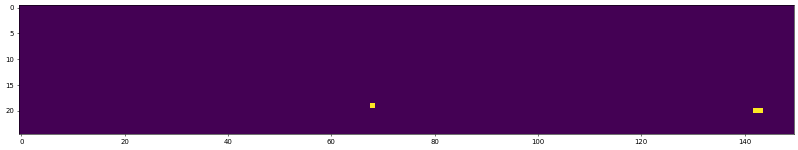

[699] {(60, 1), (61, 1)}


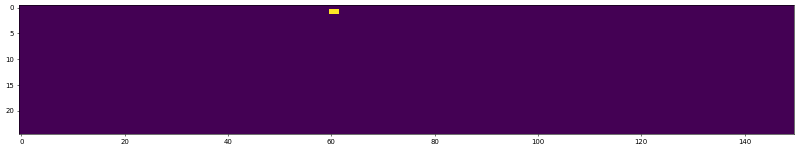

[706, 707] {(90, 8), (91, 8)}


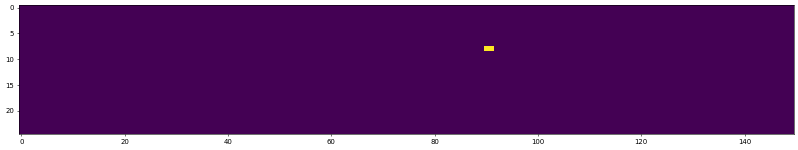

[774] {(125, 5)}


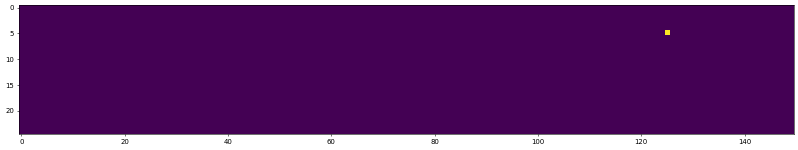

[810, 811] {(111, 9), (112, 9)}


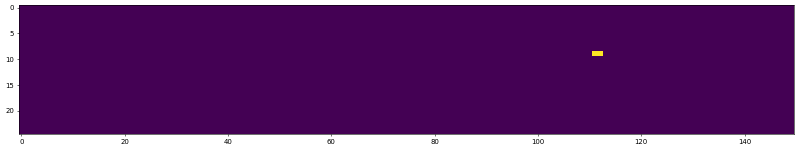

[830, 831] {(50, 13), (51, 13)}


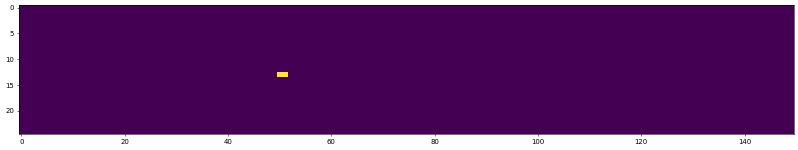

[869] {(92, 14), (93, 14)}


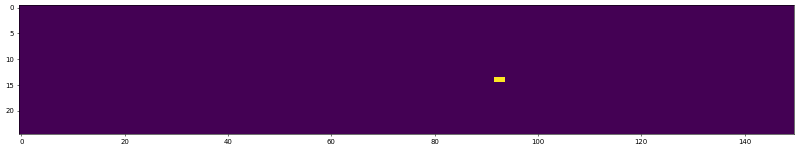

[873] {(114, 21)}


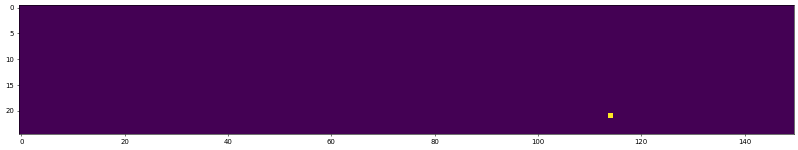

[922, 924] {(126, 5), (125, 5)}


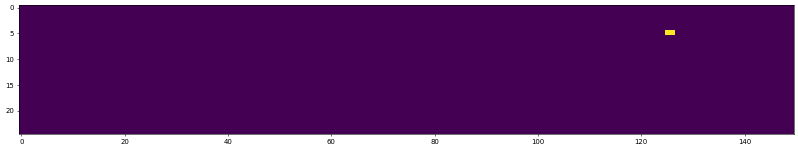

[929] {(40, 21), (41, 21)}


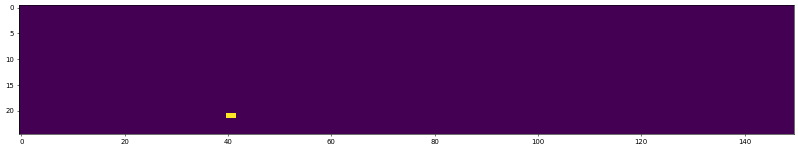

[944, 947, 949] {(96, 22), (97, 22), (98, 22)}


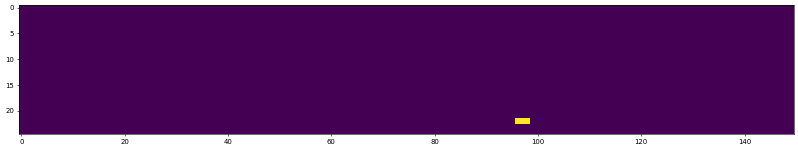

[979, 980] {(57, 13), (58, 13)}


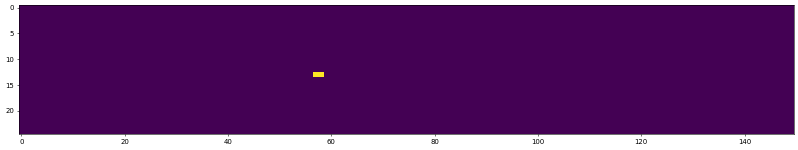

[1020, 1021, 1024] {(44, 7), (45, 7), (11, 6), (12, 6), (87, 24), (88, 24)}


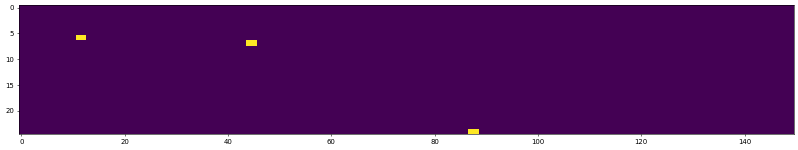

[1075, 1076] {(56, 4), (57, 4), (52, 4), (53, 4), (55, 4), (51, 4), (54, 4)}


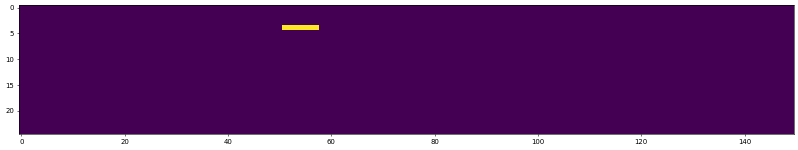

[1081, 1082] {(28, 6), (29, 6)}


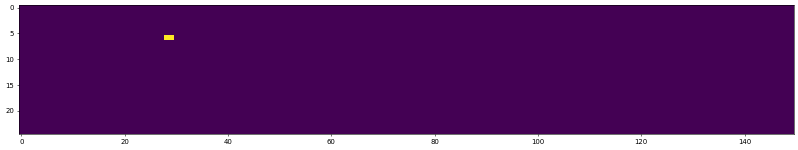

[1098, 1100, 1102, 1103, 1104, 1105] {(37, 6), (40, 6), (35, 6), (38, 6), (36, 6), (130, 8), (39, 6)}


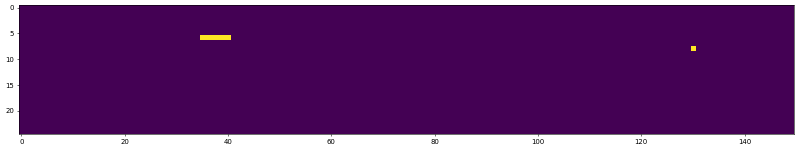

[1143, 1145] {(139, 1), (140, 1)}


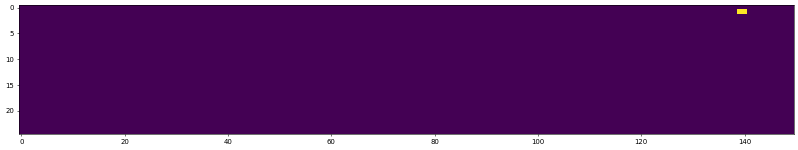

[1152, 1153, 1155, 1158] {(71, 17), (65, 9), (15, 15), (64, 9)}


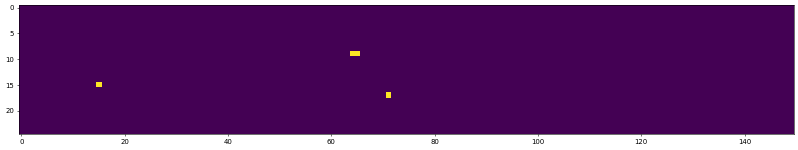

[1170] {(104, 9)}


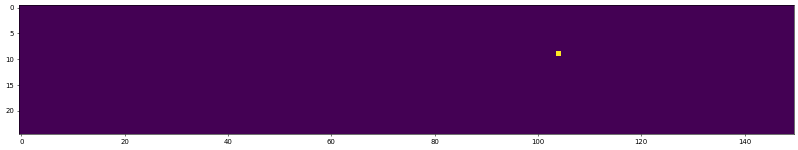

[1176] {(89, 19)}


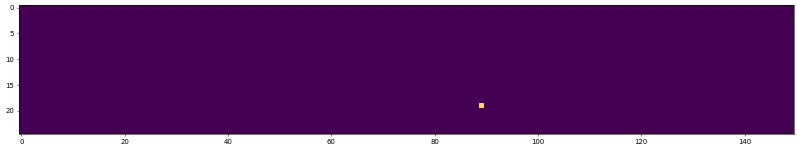

[1201] {(138, 9), (139, 9)}


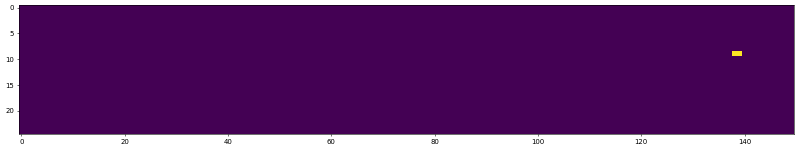

[1222] {(108, 10)}


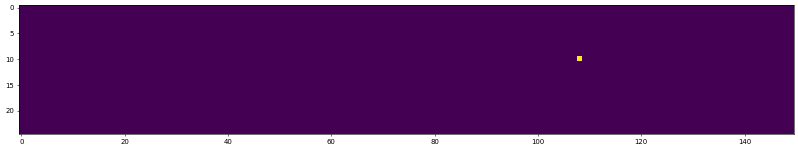

[1227] {(17, 1)}


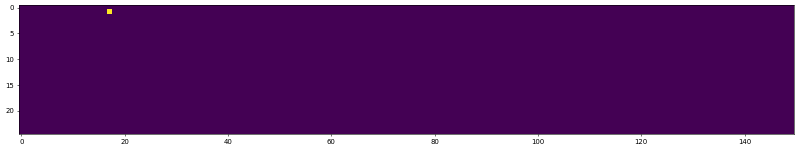

[1233] {(98, 10)}


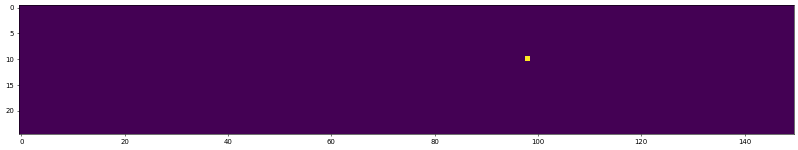

117 117 117
Liver_map_150z25_60s_#8.npy
[20] {(64, 7), (65, 7)}


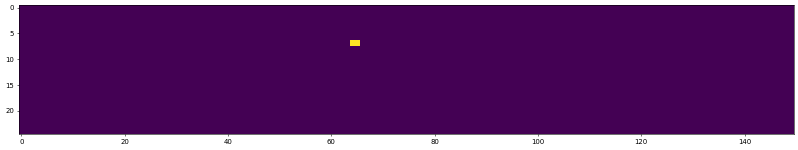

[114] {(53, 24)}


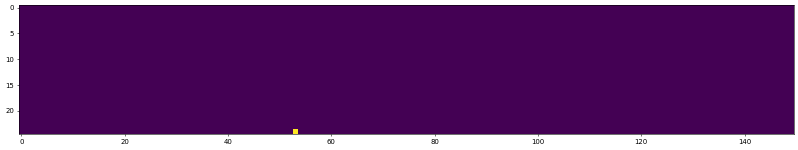

[157] {(86, 22)}


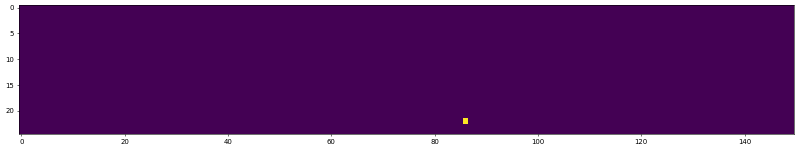

[195, 196, 197, 200] {(85, 11), (83, 11), (82, 11), (84, 11)}


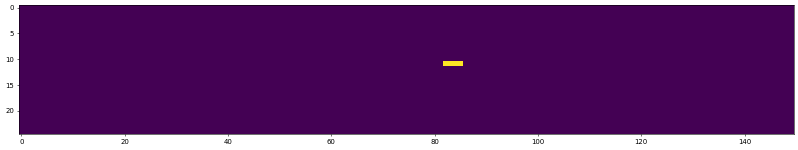

[277] {(30, 14)}


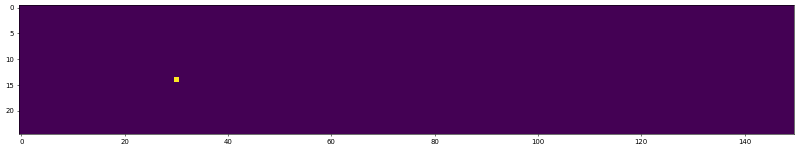

[333] {(88, 9)}


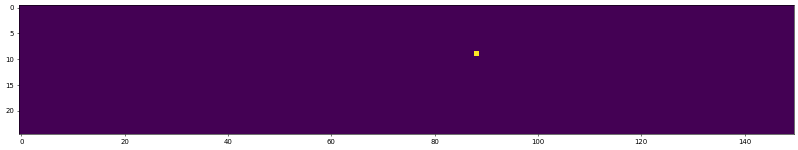

[368] {(80, 0), (81, 0)}


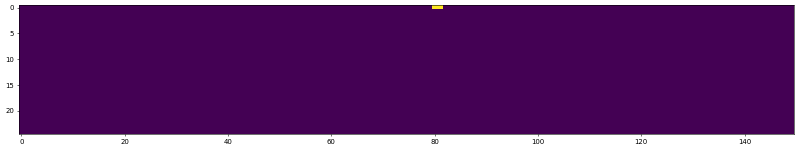

[422] {(124, 5), (123, 5)}


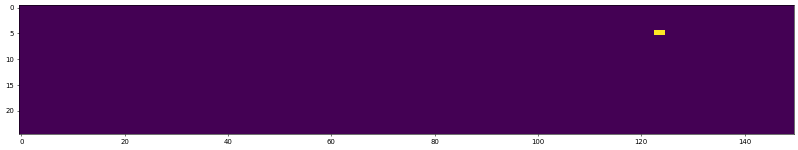

[450] {(20, 8)}


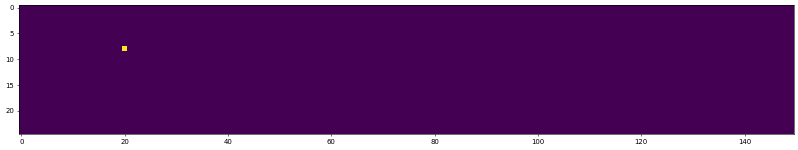

[463, 465] {(53, 5), (54, 5), (55, 5)}


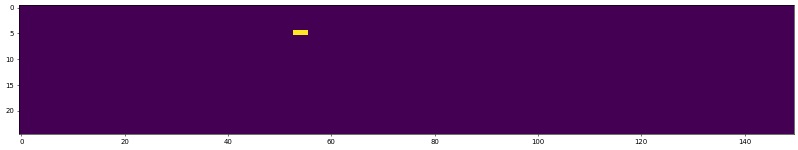

[472] {(115, 18)}


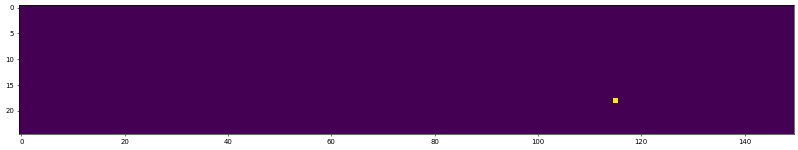

[485, 486] {(60, 18), (58, 18), (57, 18), (59, 18)}


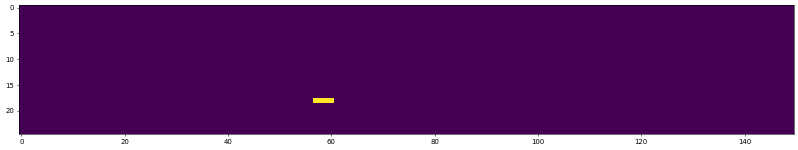

[499] {(134, 8)}


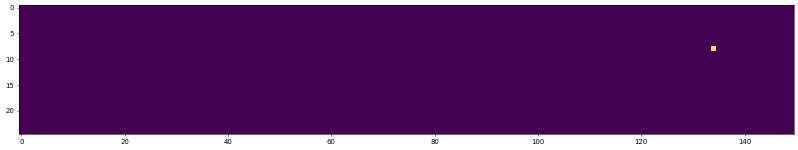

[544, 546] {(71, 23), (127, 15)}


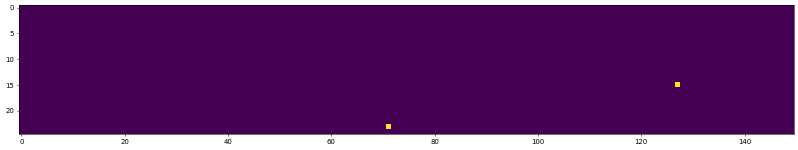

[585] {(59, 12)}


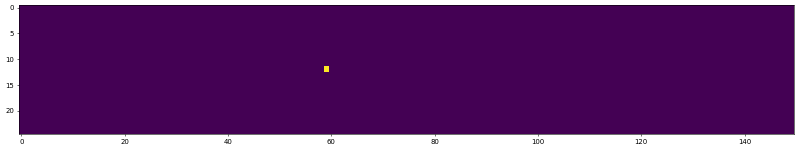

[590] {(59, 12)}


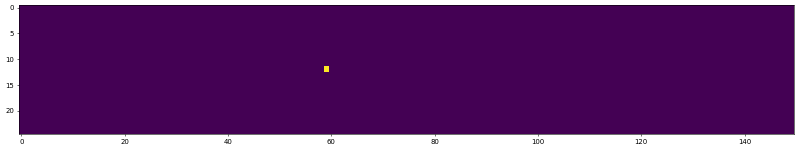

[604, 606, 607] {(61, 4), (62, 4), (60, 4)}


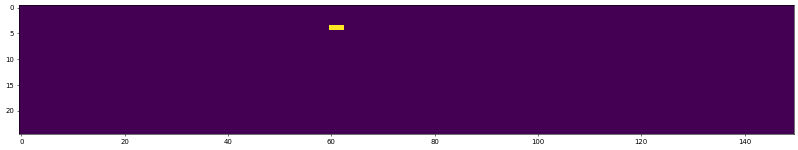

[617] {(2, 10), (149, 5)}


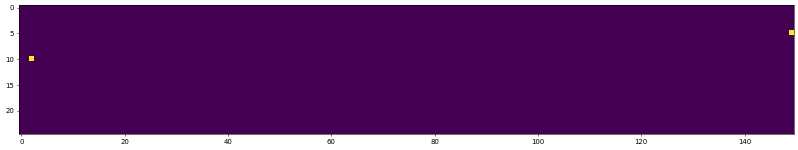

[629] {(95, 24)}


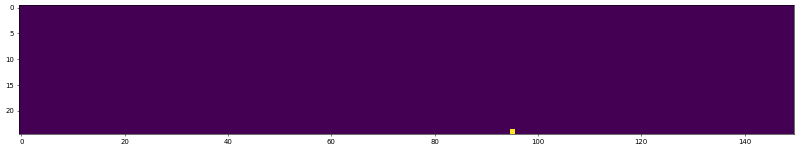

[664] {(95, 5)}


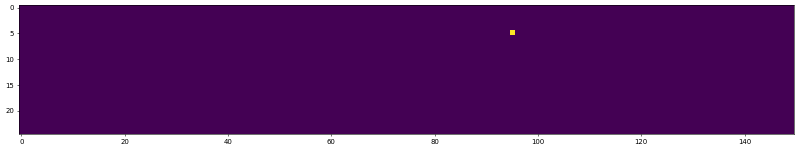

[716, 717] {(125, 12), (124, 12)}


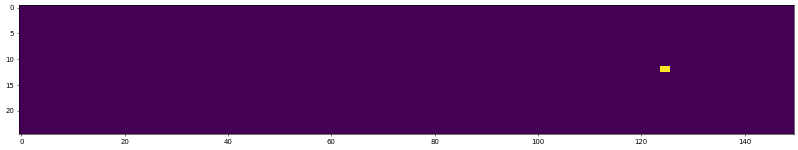

[722, 724] {(47, 19), (48, 19)}


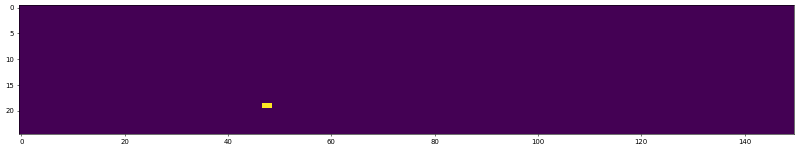

[731, 733] {(59, 17), (60, 17)}


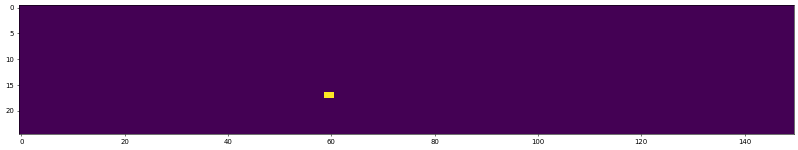

[737] {(11, 18), (10, 18)}


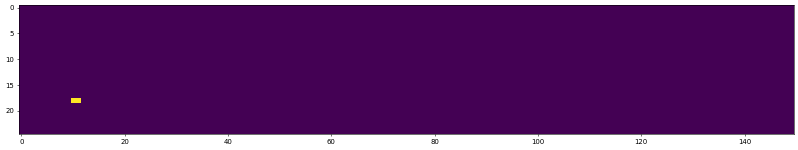

[764] {(75, 19)}


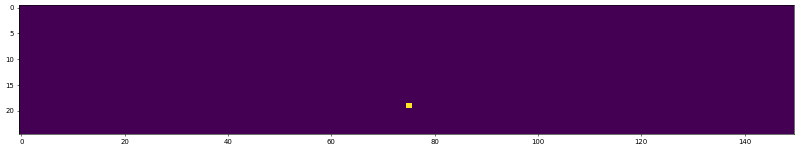

[770] {(88, 13)}


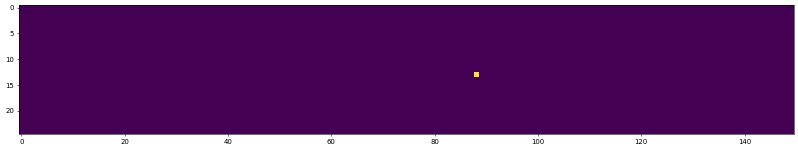

[788] {(130, 3)}


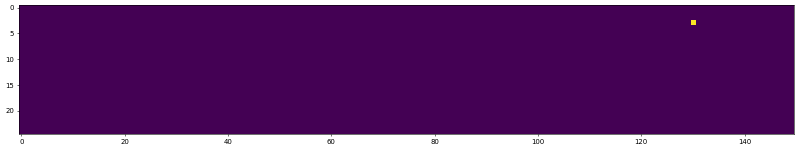

[801] {(132, 9)}


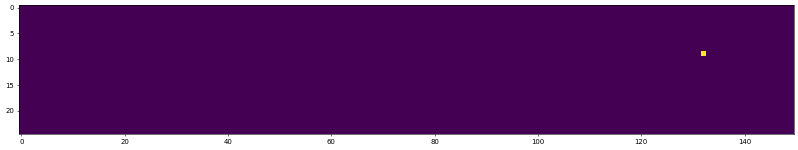

[871] {(121, 7)}


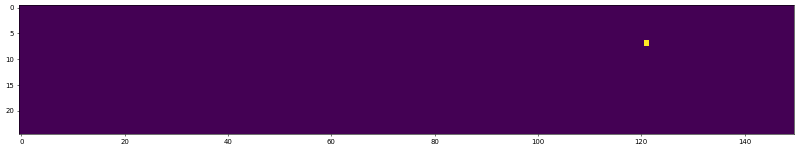

[876, 878, 879] {(139, 23), (137, 23), (138, 23)}


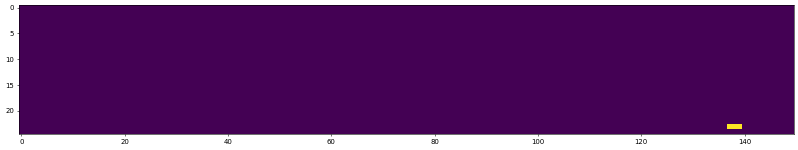

[916, 917] {(5, 9), (6, 9)}


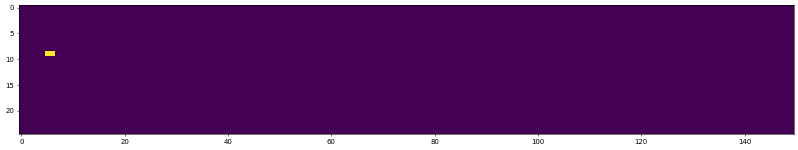

[936] {(84, 18), (85, 18)}


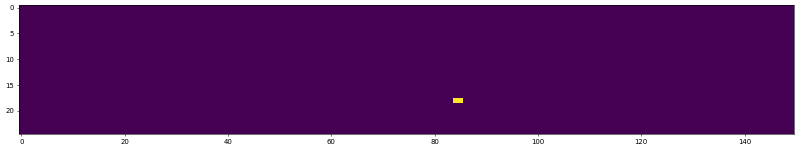

[961] {(28, 15)}


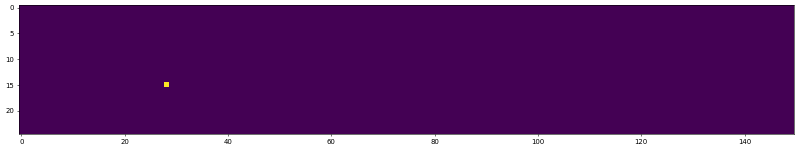

[970, 971] {(62, 12), (44, 2), (42, 2), (43, 2)}


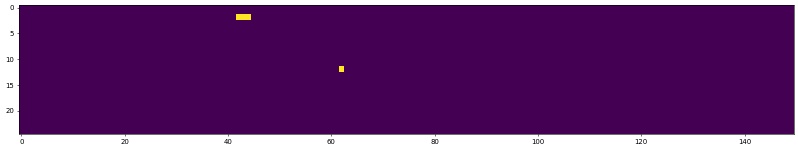

[975] {(41, 2), (40, 2)}


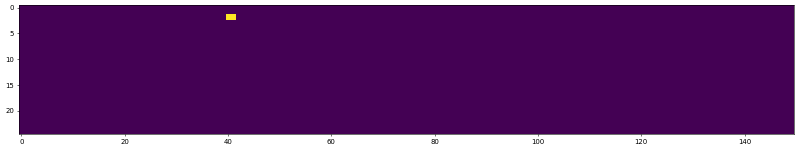

[993] {(64, 19)}


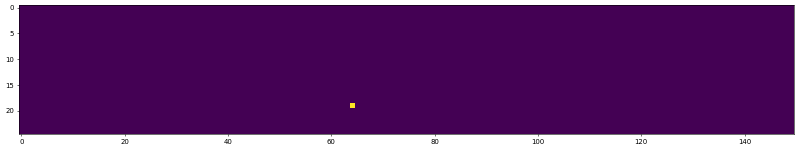

[1052] {(67, 4), (66, 4)}


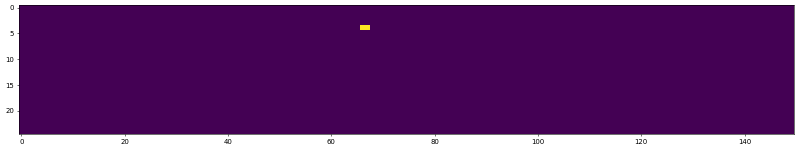

[1096, 1097, 1098, 1099, 1100, 1101, 1103, 1105, 1106, 1107, 1108, 1110, 1111] {(22, 2), (1, 2), (20, 2), (25, 2), (21, 2), (25, 18), (0, 2), (23, 18), (84, 15), (23, 2), (24, 18), (24, 2), (19, 2), (18, 2), (26, 18), (26, 2)}


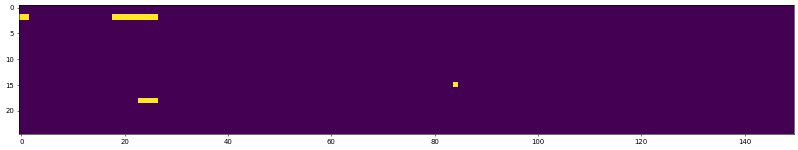

[1136, 1138, 1139] {(77, 22), (78, 22), (76, 22)}


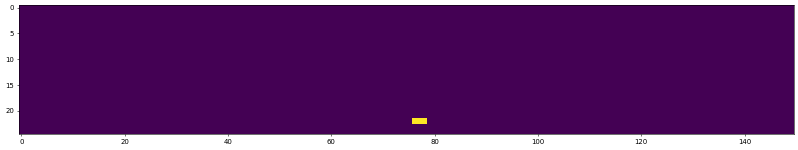

[1153] {(68, 13)}


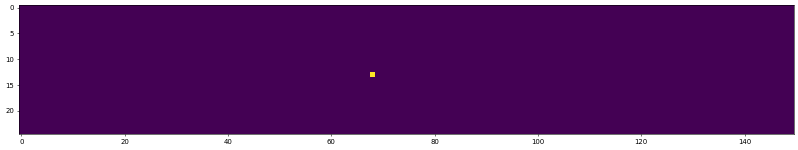

[1215] {(139, 3), (140, 3)}


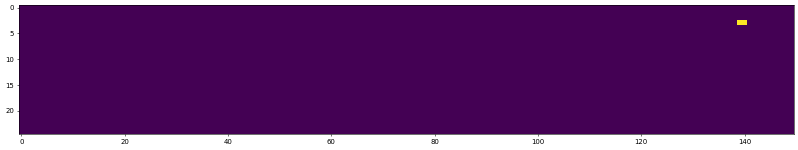

[1250, 1251] {(101, 12), (100, 12)}


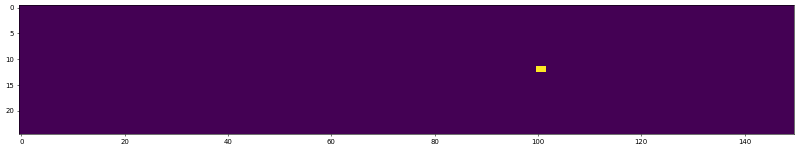

88 88 88
Muscle_map_150z25_60s_#20.npy
[34, 36] {(50, 6), (51, 6)}


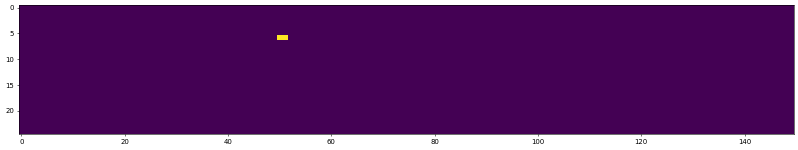

[51, 53] {(83, 23), (84, 23)}


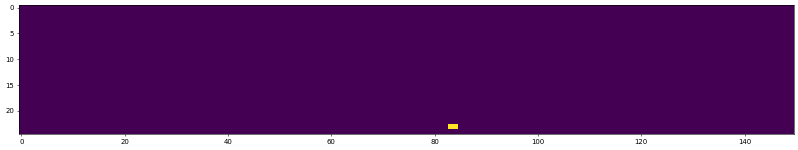

[62, 64, 65, 66, 67] {(111, 20), (50, 6), (52, 6), (123, 19), (124, 19), (51, 6)}


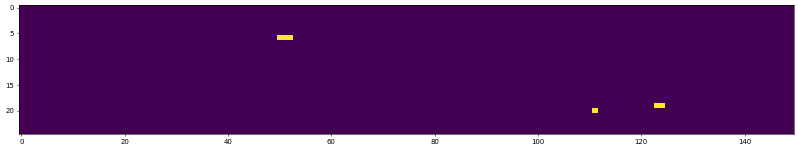

[75] {(39, 6)}


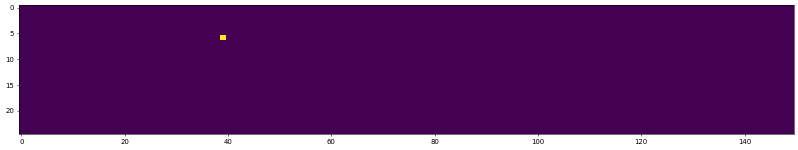

[153] {(80, 11)}


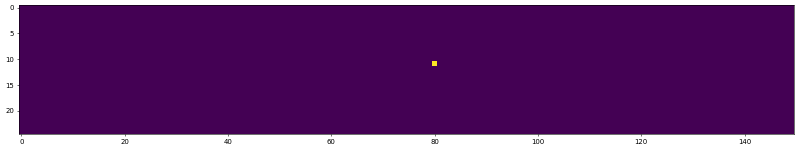

[168] {(38, 4)}


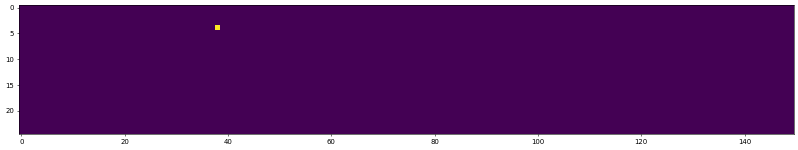

[194] {(35, 22)}


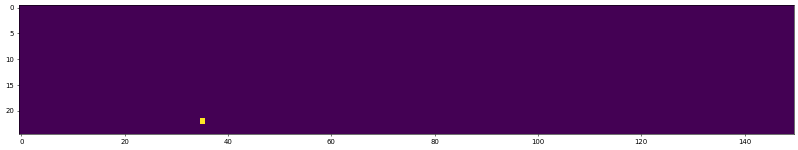

[219] {(126, 16)}


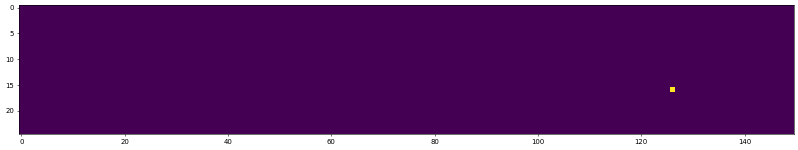

[256, 257, 259] {(26, 5), (1, 5), (120, 6), (121, 6), (119, 6), (2, 5), (3, 5)}


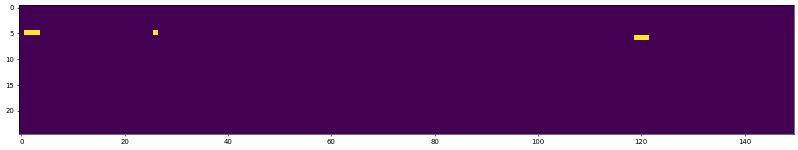

[304] {(56, 13)}


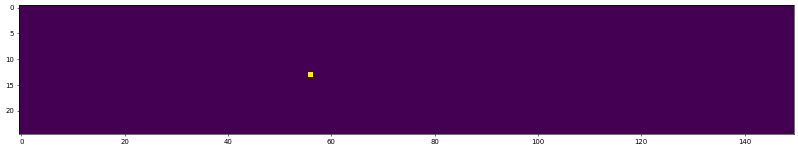

[327, 330, 332] {(142, 12), (21, 12), (22, 12)}


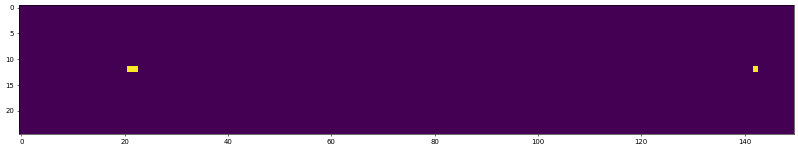

[358] {(118, 16), (117, 16)}


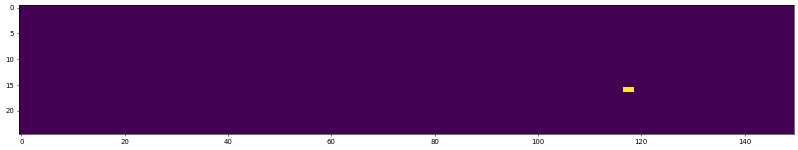

[365, 366, 367] {(136, 7), (39, 23), (40, 23)}


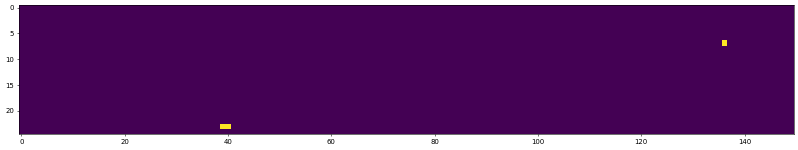

[385, 386] {(87, 2), (86, 2)}


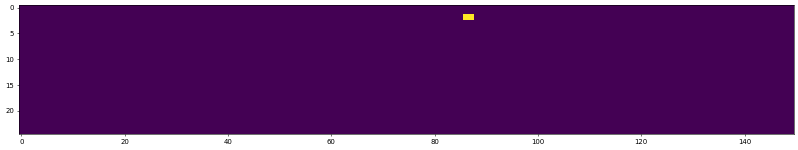

[423] {(99, 21), (98, 21)}


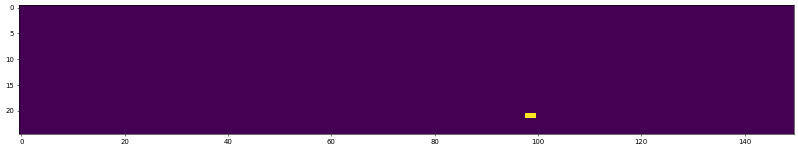

[452, 453] {(104, 0), (105, 0), (106, 0)}


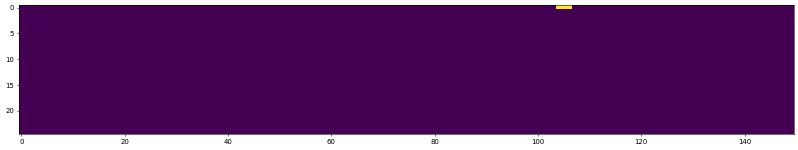

[464] {(87, 16)}


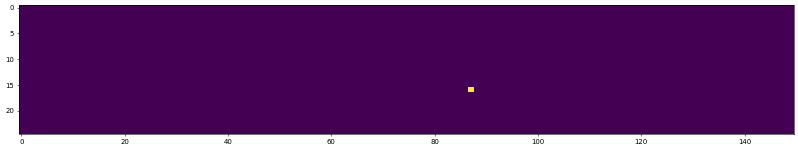

[508] {(102, 5)}


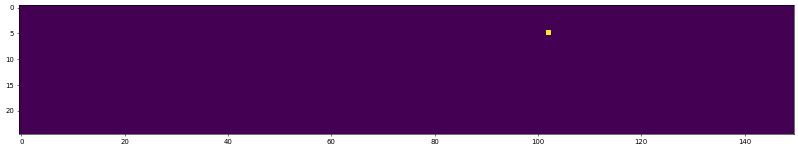

[524] {(111, 16)}


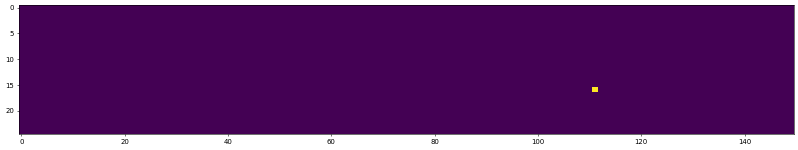

[533, 536] {(13, 10), (47, 5)}


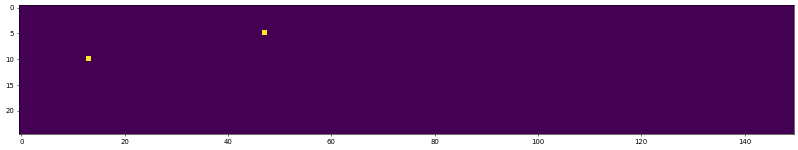

[566, 568] {(83, 22), (84, 22)}


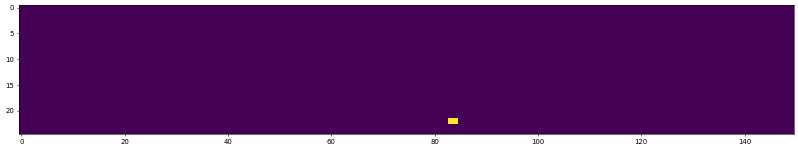

[582, 583] {(66, 24), (65, 24)}


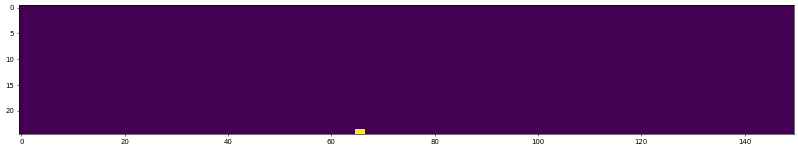

[592, 593] {(92, 7), (91, 7)}


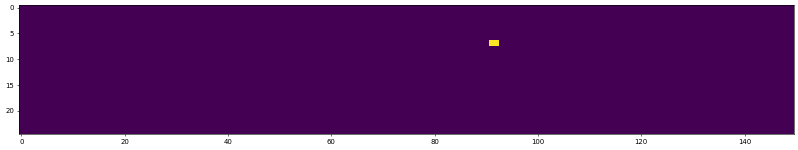

[650, 651] {(65, 9), (64, 9)}


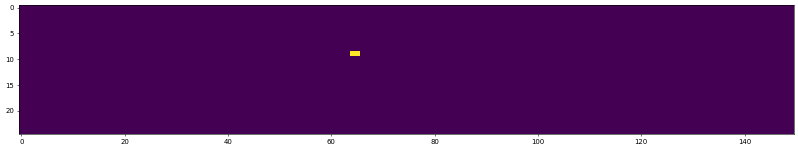

[655] {(70, 12), (71, 12), (66, 12), (67, 12), (68, 12), (69, 12), (65, 12)}


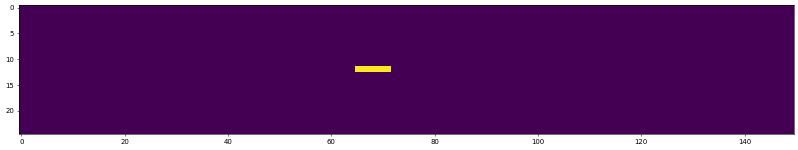

[668, 669, 670, 673, 674, 675, 676] {(93, 12), (123, 0), (124, 0), (94, 12), (122, 0), (95, 12), (96, 12), (97, 12)}


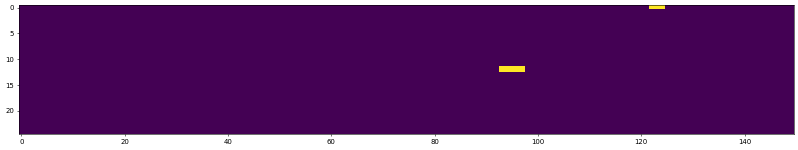

[713] {(148, 10), (147, 10)}


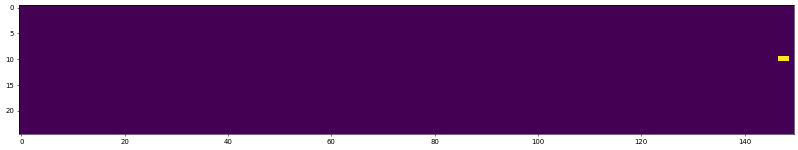

[720] {(33, 7), (32, 7)}


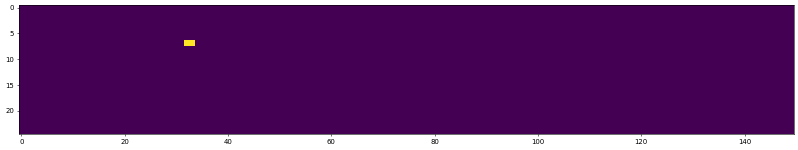

[802, 805, 806] {(146, 21), (144, 21), (145, 21)}


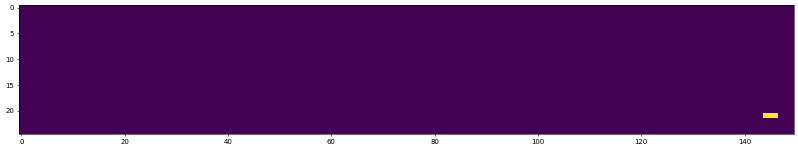

[816] {(110, 20)}


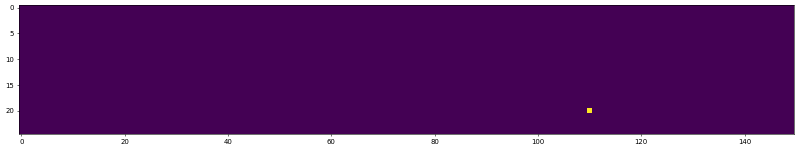

[824, 825, 826] {(131, 2), (124, 17), (126, 17), (130, 2), (125, 17)}


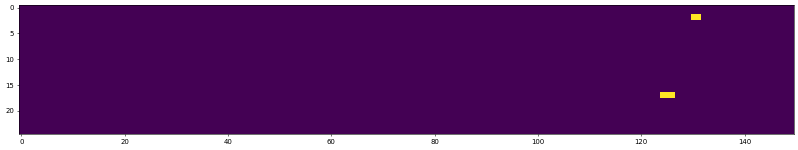

[837, 838, 839, 841, 842] {(12, 17), (13, 17), (115, 6), (116, 6), (11, 17)}


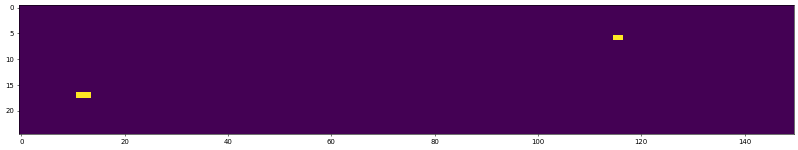

[852, 853, 855, 856] {(128, 12), (131, 12), (129, 12), (130, 12)}


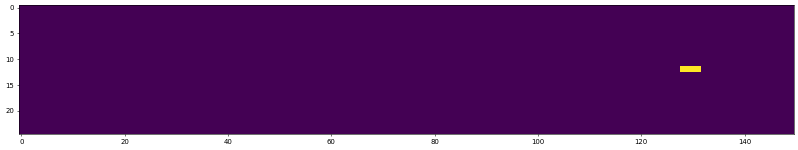

[916, 918, 919] {(83, 20), (84, 20), (89, 22)}


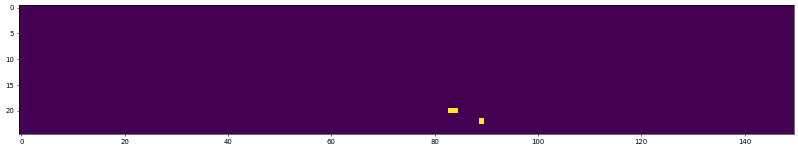

[927, 928, 931] {(89, 20), (90, 20), (91, 20), (109, 11), (92, 20), (88, 20)}


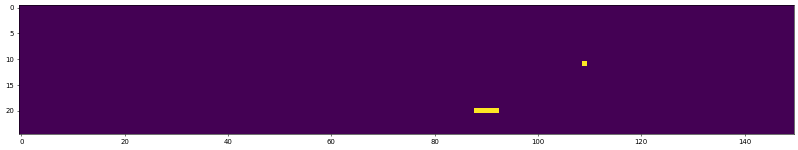

[935] {(46, 5)}


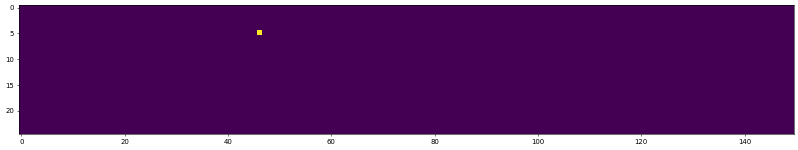

[949] {(65, 21)}


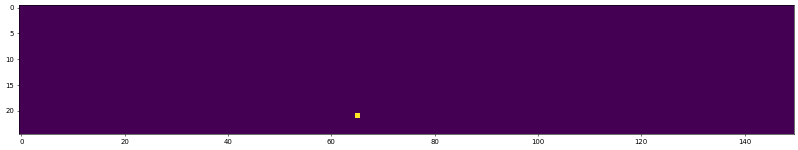

[963, 964] {(109, 11), (90, 1), (89, 1)}


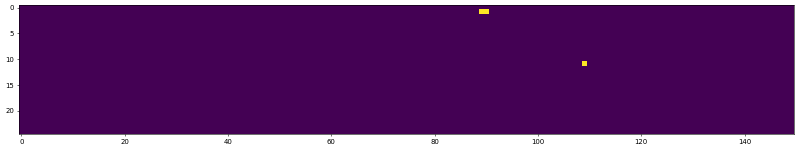

[970, 971] {(109, 11), (107, 0), (108, 0)}


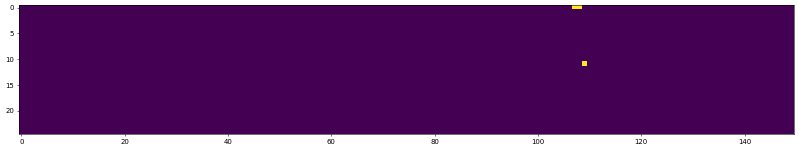

[976, 977] {(121, 1), (122, 1)}


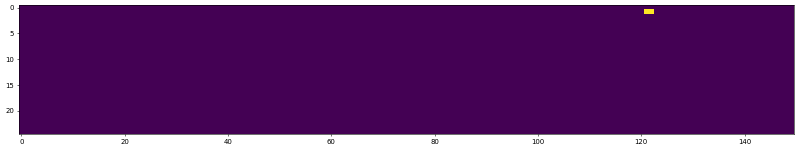

[981, 983, 984] {(111, 14), (109, 14), (110, 14)}


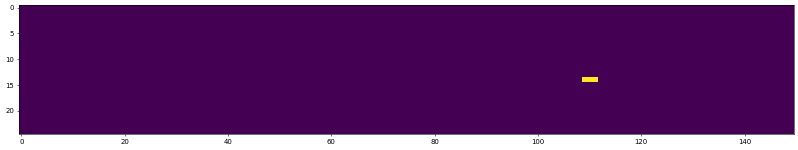

[993] {(145, 21)}


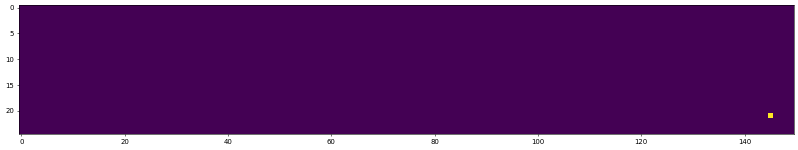

[1009, 1010] {(87, 6), (88, 6), (89, 6), (90, 6), (85, 6), (91, 6), (86, 6)}


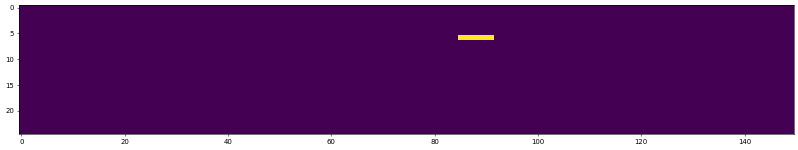

[1016, 1017, 1018, 1019] {(44, 6), (42, 6), (45, 6), (40, 6), (50, 6), (46, 6), (41, 6), (47, 6), (49, 6), (52, 6), (48, 6), (43, 6), (53, 6), (51, 6)}


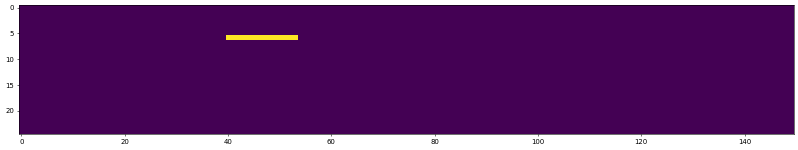

[1026] {(56, 19)}


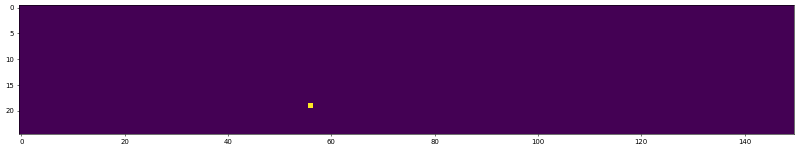

[1033, 1034, 1037, 1038] {(143, 5), (82, 15), (83, 15), (139, 5), (142, 5), (137, 5), (140, 5), (138, 5), (141, 5), (136, 5)}


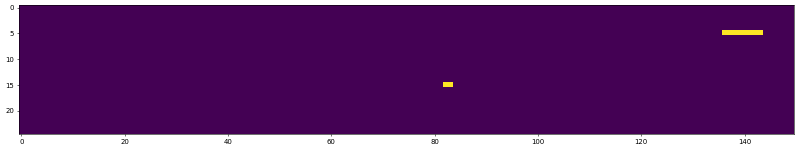

[1096] {(80, 1), (81, 1)}


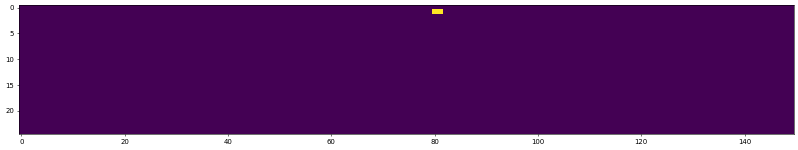

[1100, 1102] {(113, 6), (114, 6)}


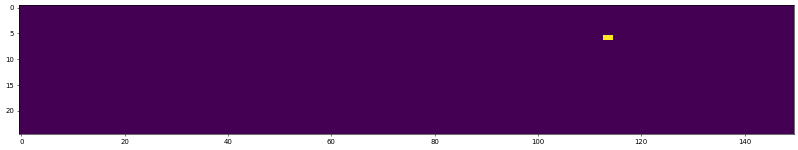

[1116, 1118, 1119, 1121, 1122] {(0, 22), (113, 15), (111, 15), (2, 22), (112, 15), (3, 22), (1, 22)}


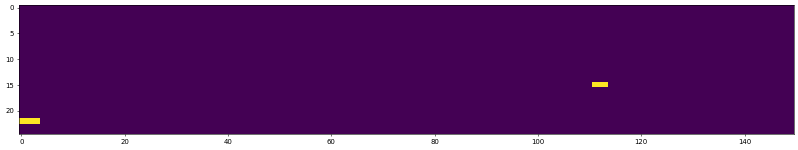

[1127, 1128, 1131] {(116, 15), (114, 15), (115, 15)}


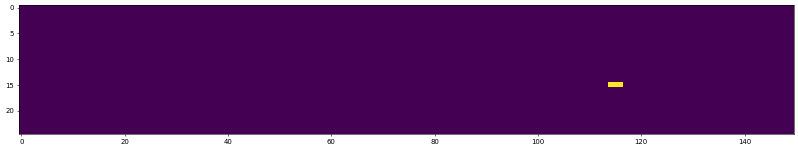

[1135] {(117, 15)}


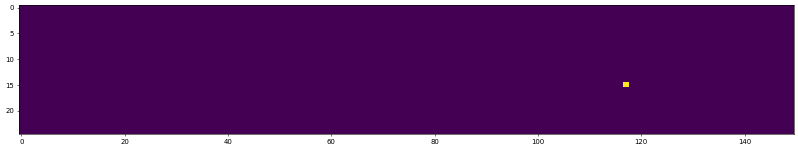

[1139, 1140, 1141, 1142] {(3, 18), (4, 18), (5, 18), (118, 15)}


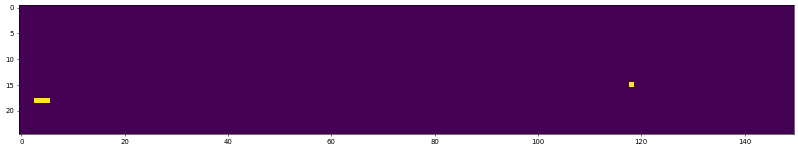

[1169] {(149, 1)}


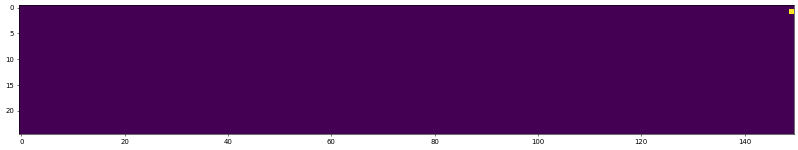

[1197, 1198] {(147, 12), (148, 12), (149, 12)}


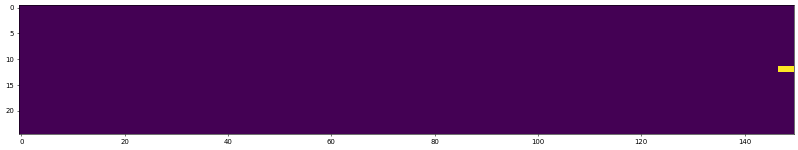

[1207] {(5, 23)}


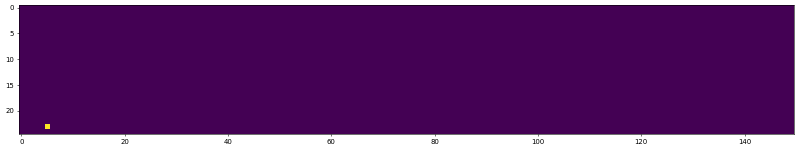

[1211, 1213, 1215, 1217, 1218, 1219, 1220, 1221] {(86, 5), (114, 21), (7, 23), (77, 5), (134, 15), (88, 5), (116, 21), (79, 5), (81, 5), (6, 23), (133, 15), (83, 5), (85, 5), (87, 5), (115, 21), (78, 5), (89, 5), (80, 5), (82, 5), (84, 5)}


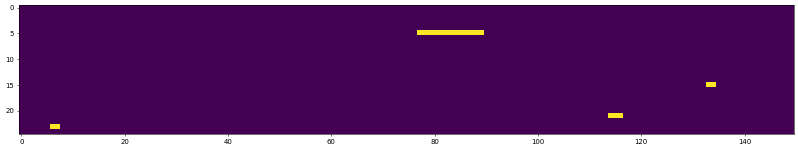

181 181 181
Kidney_map_150z25_60s_#47.npy
[8, 9, 10, 12] {(102, 5), (72, 6), (105, 5), (71, 6)}


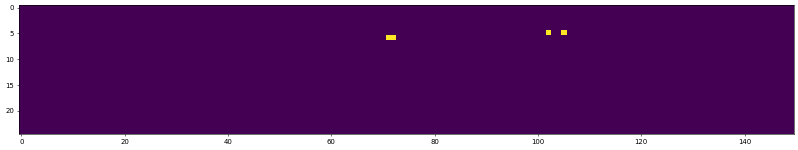

[17] {(117, 5)}


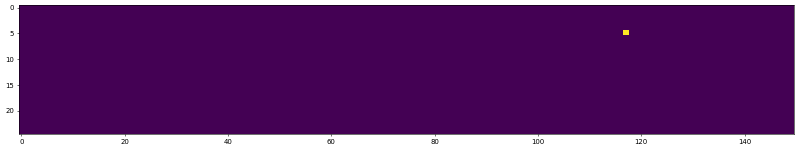

[49] {(149, 1)}


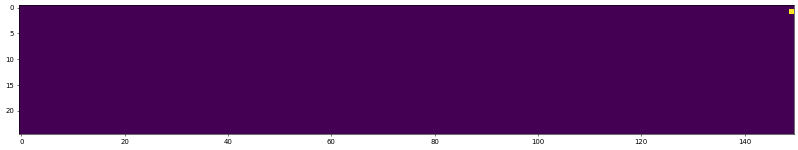

[64, 65] {(129, 5), (37, 6), (135, 7)}


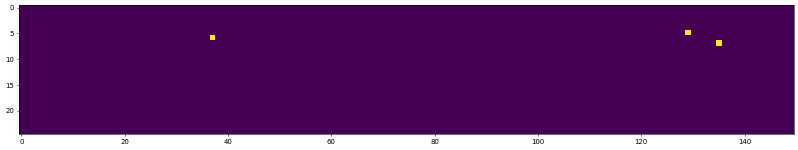

[100] {(96, 12)}


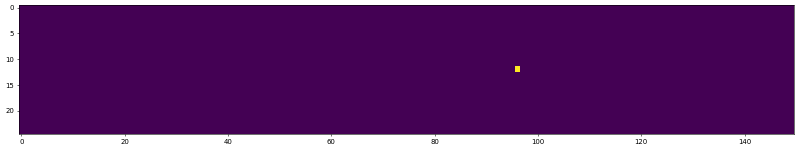

[104] {(147, 4)}


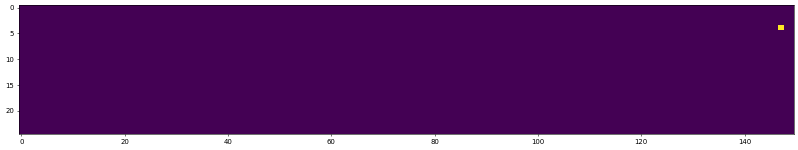

[112] {(99, 7)}


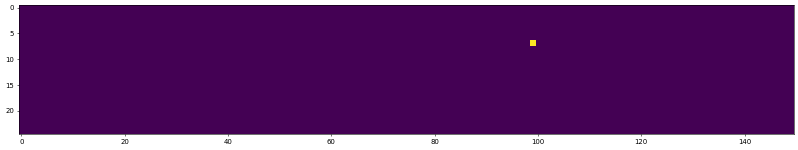

[135, 137, 139] {(140, 5), (138, 5), (139, 5)}


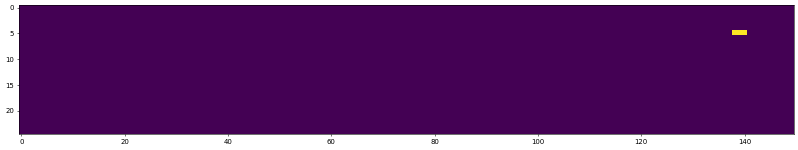

[265] {(73, 7)}


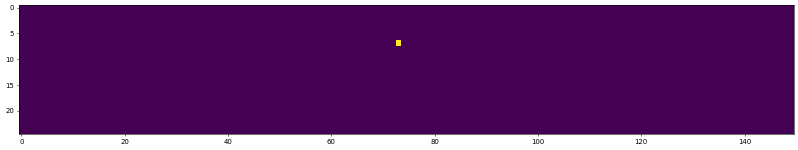

[326, 327] {(90, 23), (89, 23)}


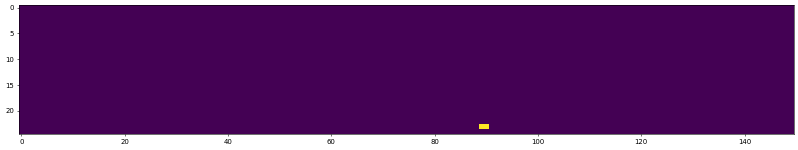

[367] {(31, 22)}


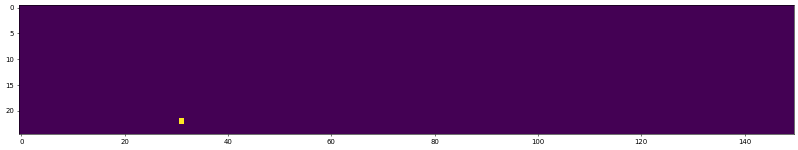

[390, 391] {(54, 3), (55, 3), (56, 3)}


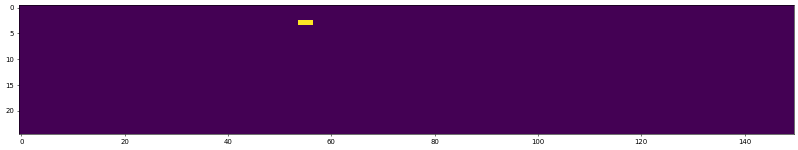

[412] {(4, 8)}


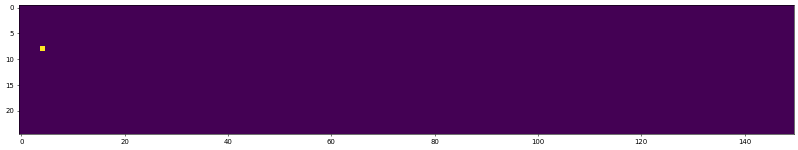

[432, 433, 434, 435] {(35, 2), (38, 2), (36, 2), (37, 2)}


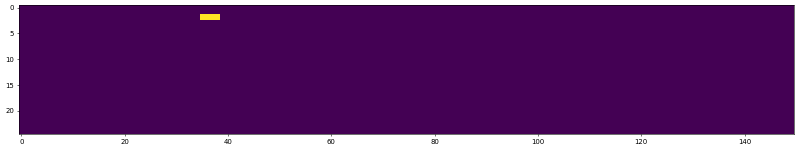

[463, 465] {(23, 15)}


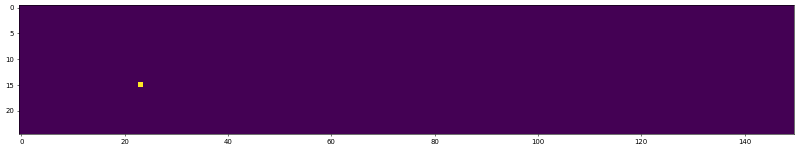

[519] {(109, 13), (110, 13)}


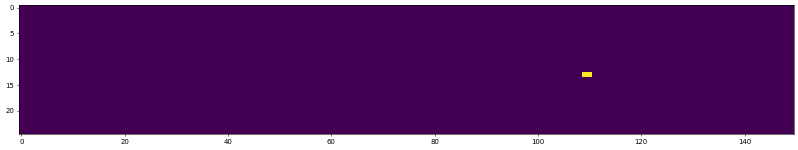

[569] {(100, 6)}


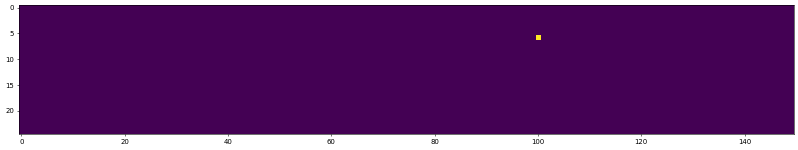

[579, 580, 581, 582, 583, 584, 587] {(80, 11), (81, 11), (148, 8), (143, 8), (115, 9), (146, 8), (116, 9), (117, 9), (82, 11), (149, 8), (144, 8), (145, 8), (114, 9)}


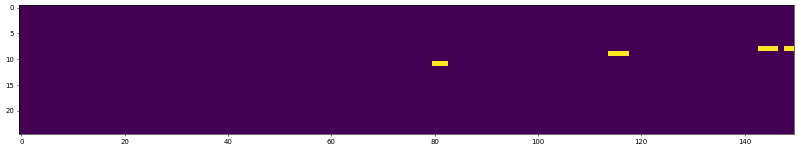

[591, 592, 593] {(116, 9), (114, 9), (117, 9), (115, 9)}


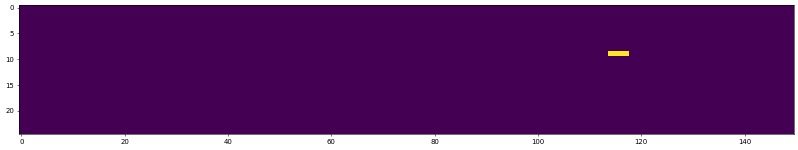

[602] {(131, 7), (132, 7)}


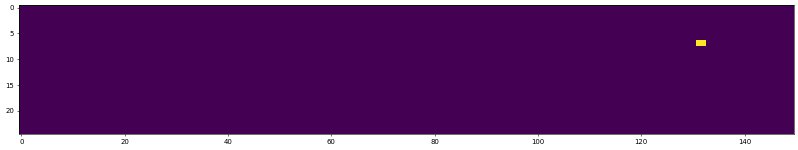

[661] {(0, 15)}


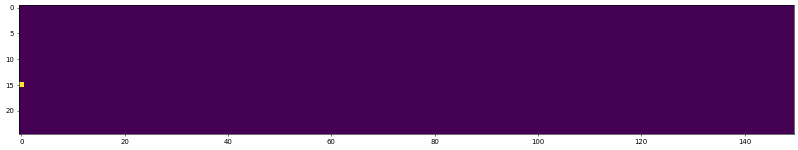

[686, 687, 688, 689] {(13, 14), (16, 14), (14, 14), (15, 14)}


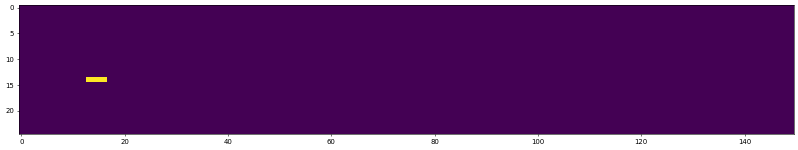

[714] {(112, 10)}


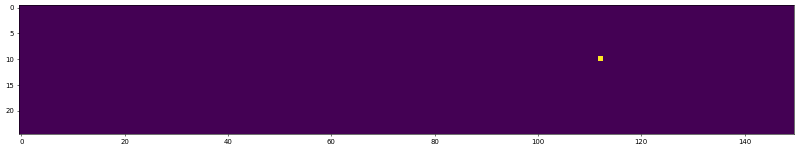

[755] {(4, 10)}


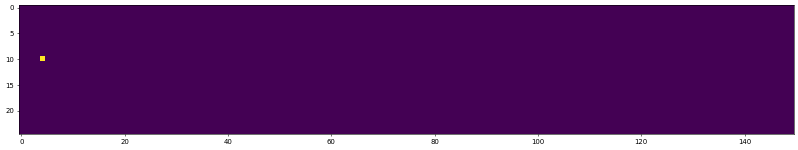

[773, 774] {(102, 18), (103, 18)}


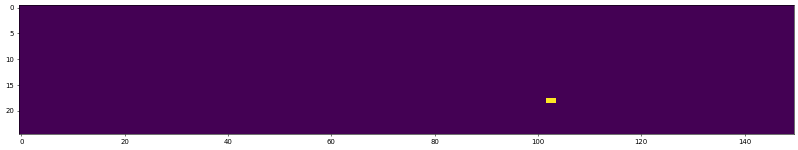

[783, 785] {(109, 18), (110, 18)}


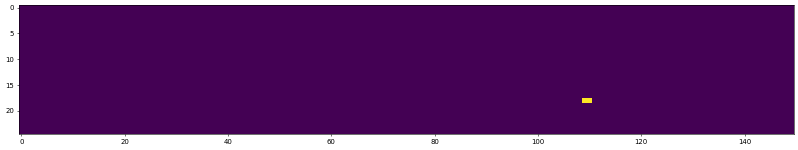

[814] {(133, 3)}


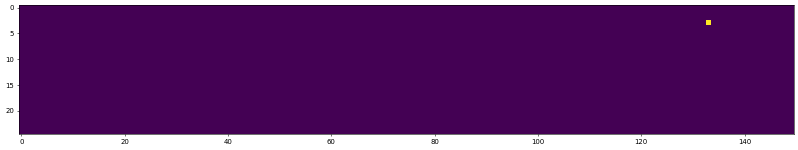

[819] {(50, 10), (49, 10)}


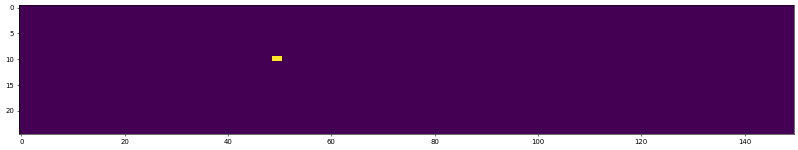

[844, 846] {(140, 22), (139, 22)}


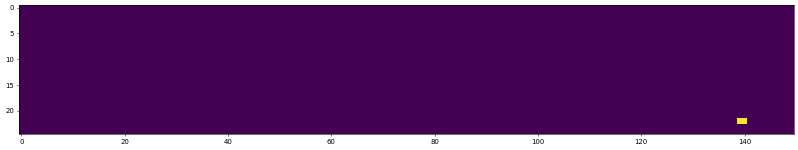

[882, 883] {(141, 24), (142, 24)}


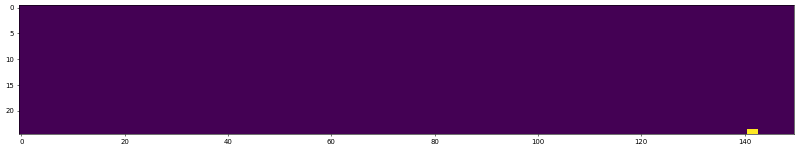

[890, 891, 892, 893] {(62, 3), (63, 3), (64, 3), (61, 3)}


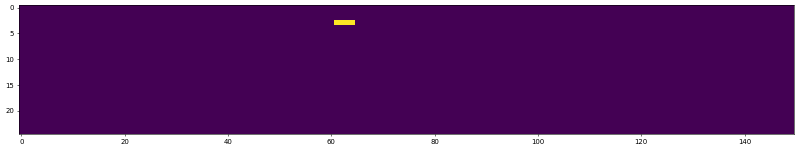

[897, 898, 899, 900, 901] {(141, 24), (63, 3), (139, 24), (142, 24), (137, 24), (140, 24), (138, 24)}


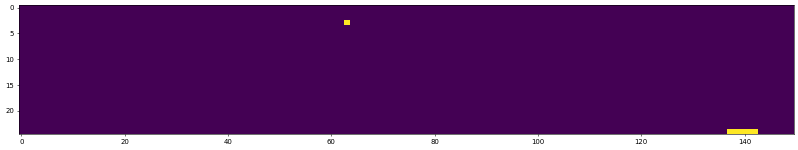

[908, 909, 910] {(44, 23), (40, 23), (41, 23), (43, 23), (42, 23)}


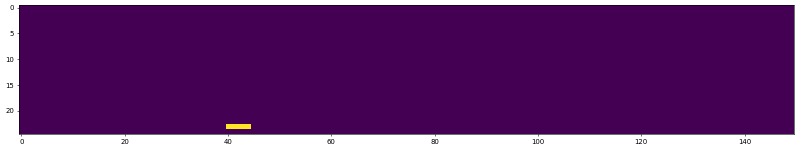

[918, 919] {(118, 16), (119, 16), (117, 16)}


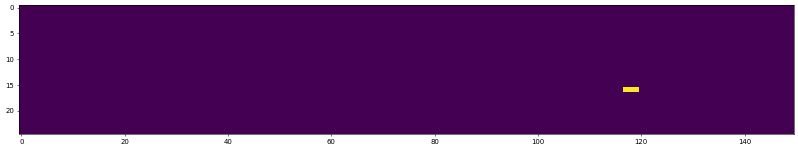

[926, 927] {(21, 14), (19, 14), (20, 14)}


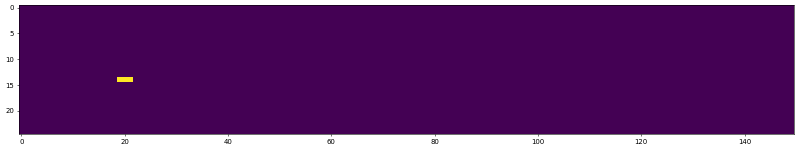

[1051, 1052] {(68, 14), (47, 3)}


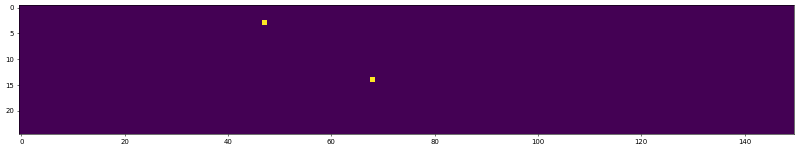

[1077, 1078, 1079, 1080, 1081] {(64, 5), (65, 5), (60, 5), (111, 0), (112, 0), (63, 5), (59, 5), (66, 5), (61, 5), (67, 5), (62, 5)}


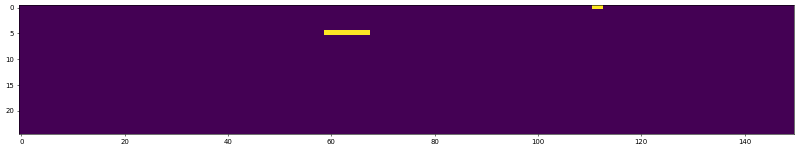

[1103] {(30, 14)}


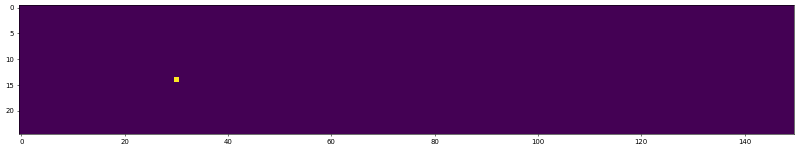

[1161, 1162, 1164] {(110, 10), (148, 11), (109, 10)}


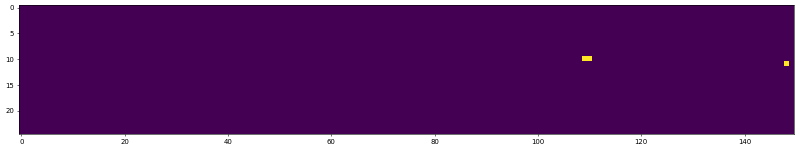

[1198] {(70, 19)}


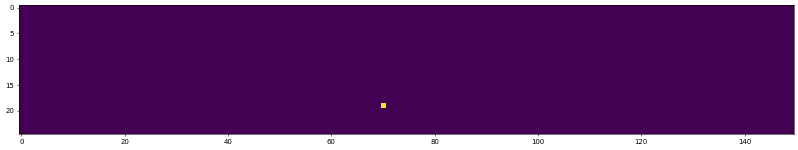

[1208, 1210] {(112, 23), (110, 23), (111, 23)}


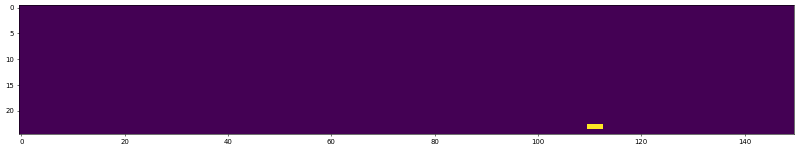

[1245] {(147, 2)}


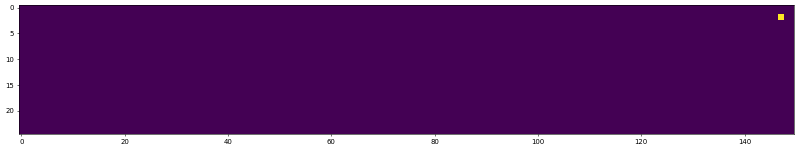

[1251] {(71, 18)}


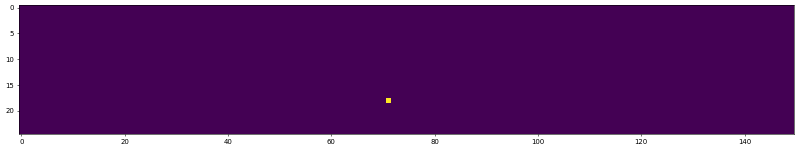

112 112 112
Liver_map_150z25_60s_#15.npy
[22] {(120, 7)}


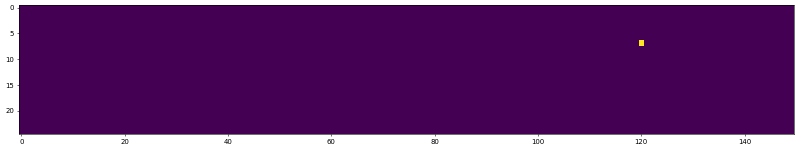

[36] {(14, 15)}


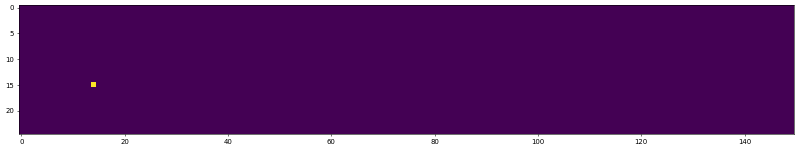

[60, 61] {(129, 15), (127, 15), (128, 15)}


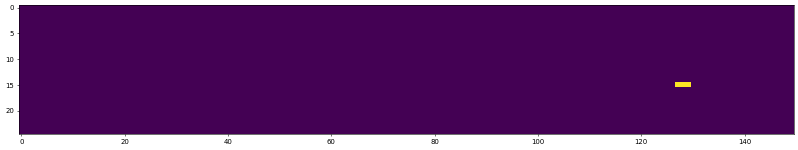

[92, 94] {(113, 15), (112, 15)}


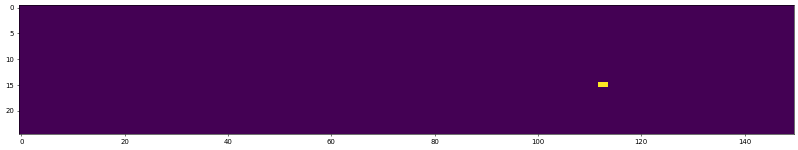

[99] {(74, 15)}


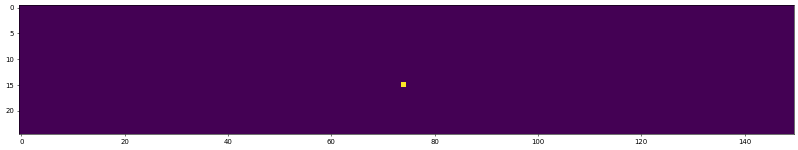

[125, 128] {(79, 14), (80, 14)}


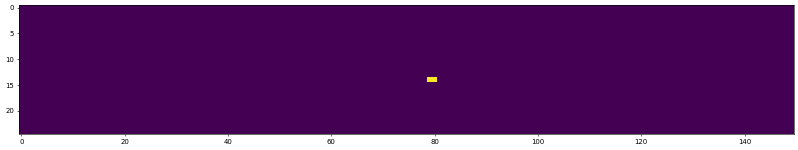

[134, 136, 137, 139] {(78, 14), (140, 0), (138, 0), (139, 0)}


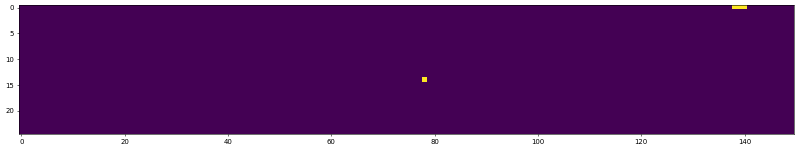

[143, 145] {(134, 0), (135, 0)}


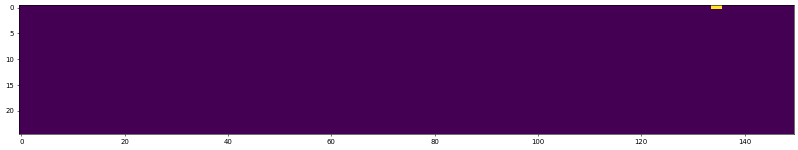

[155, 157, 158] {(146, 3), (110, 18), (142, 3), (149, 3), (144, 3), (145, 3), (147, 3), (148, 3), (143, 3)}


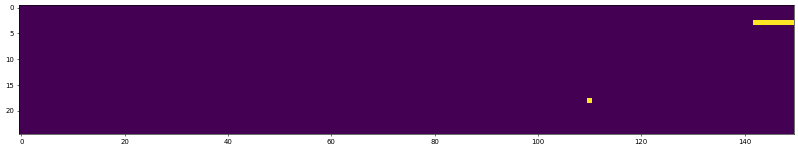

[192, 195] {(67, 9), (66, 9)}


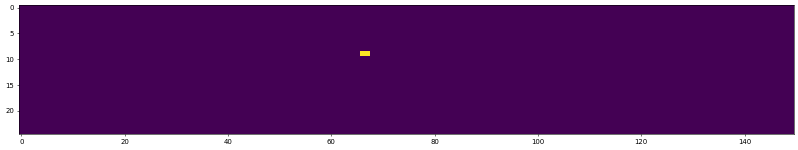

[199] {(68, 9)}


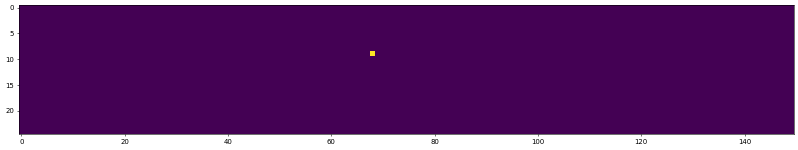

[218] {(132, 20)}


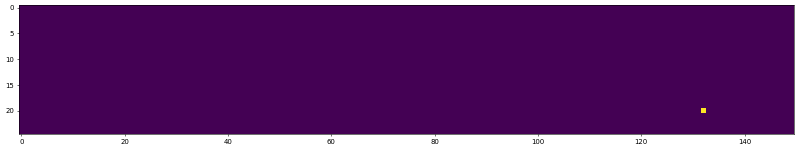

[229, 231] {(84, 4), (85, 4)}


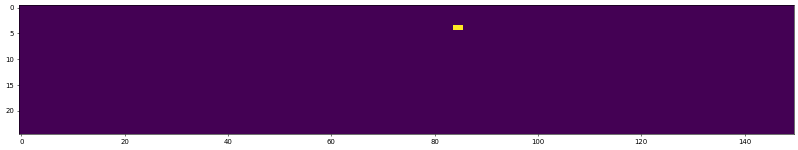

[237, 239] {(41, 13), (40, 13)}


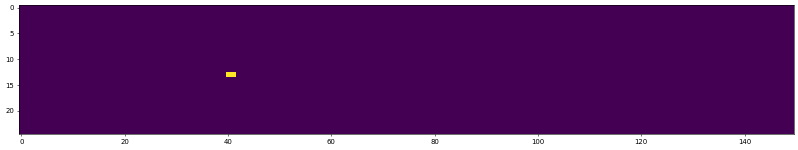

[245, 246] {(131, 12), (130, 12)}


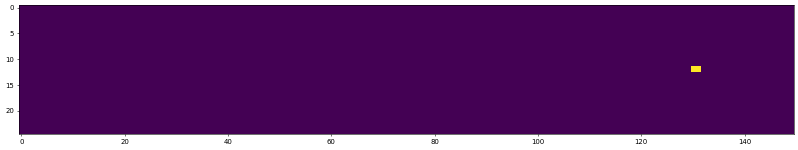

[256] {(65, 2)}


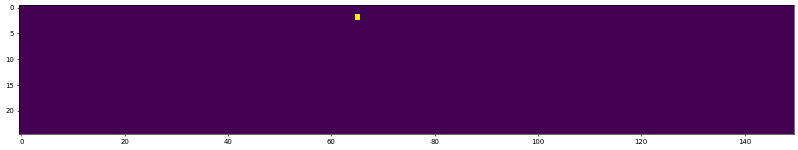

[343, 344, 346, 347, 348] {(37, 10), (66, 7), (38, 10), (67, 7), (68, 7), (40, 10), (35, 10), (96, 13), (41, 10), (97, 13), (36, 10), (69, 7), (65, 7), (39, 10)}


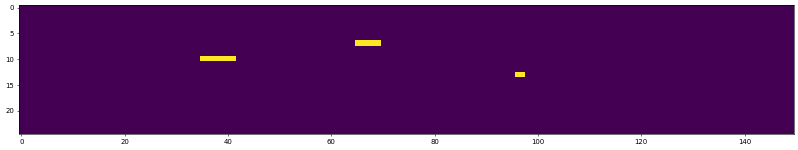

[368, 370] {(134, 10), (135, 10), (133, 10)}


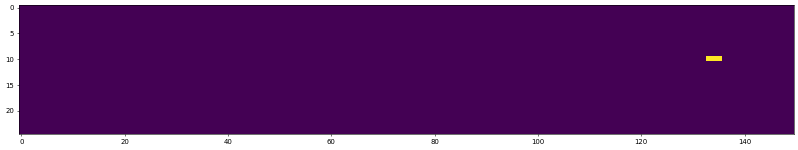

[386] {(12, 17), (13, 17), (14, 17)}


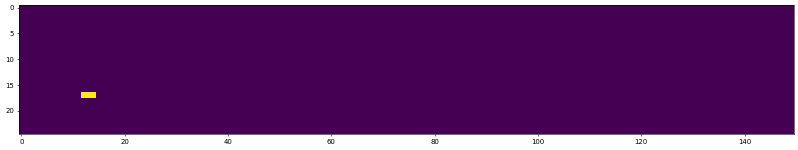

[437] {(58, 11)}


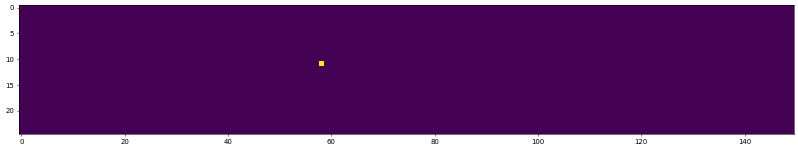

[519, 520] {(24, 14), (25, 14)}


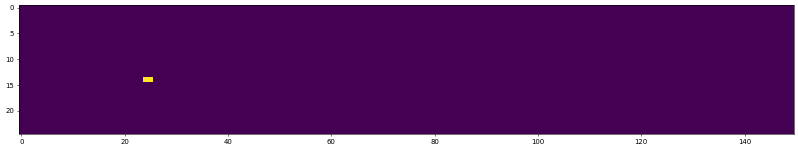

[527, 529, 530, 531, 532, 533, 534, 535, 537, 538] {(55, 18), (51, 18), (49, 18), (50, 18), (56, 18), (46, 18), (52, 18), (47, 18), (58, 18), (53, 18), (48, 18)}


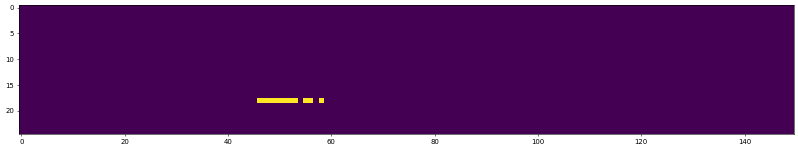

[551] {(112, 12)}


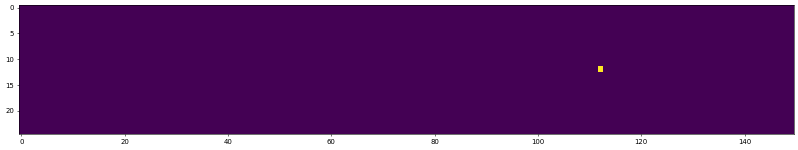

[578] {(143, 17)}


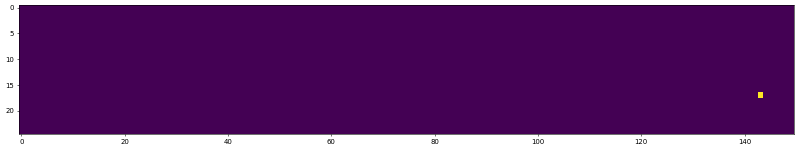

[584] {(143, 17)}


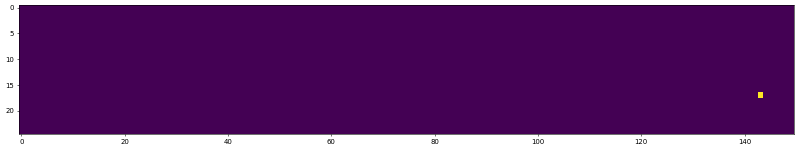

[622] {(78, 15), (76, 15), (77, 15)}


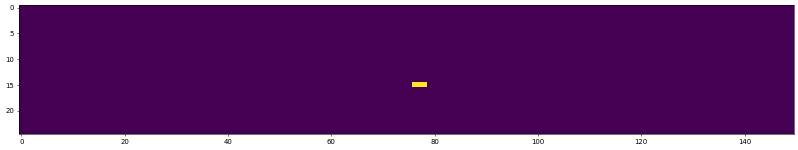

[631] {(149, 2)}


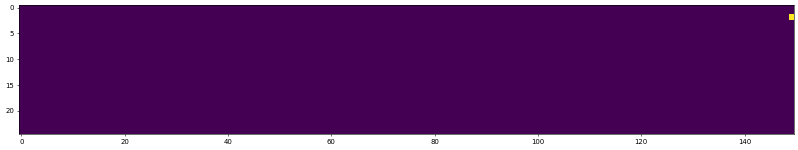

[654, 655] {(37, 21), (35, 21), (36, 21)}


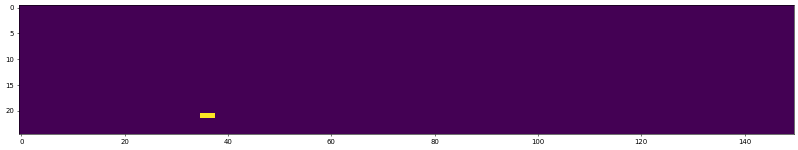

[675, 676] {(15, 21), (16, 21)}


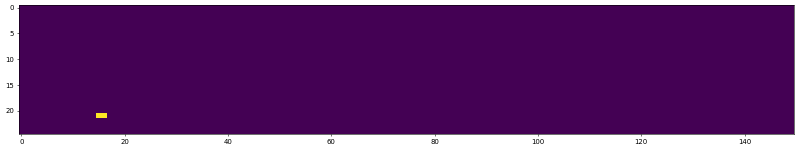

[681, 682] {(20, 0), (21, 0)}


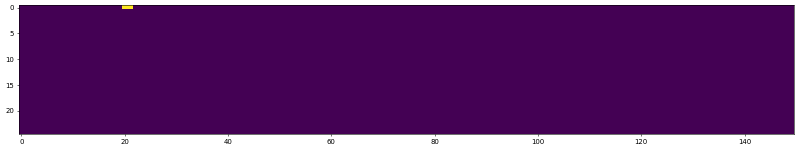

[696, 698, 699, 700, 701, 702, 704] {(57, 8), (101, 1), (55, 8), (53, 8), (59, 8), (54, 8), (58, 8), (56, 8)}


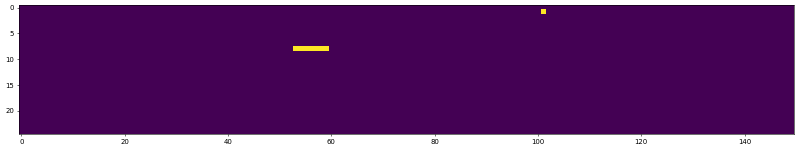

[708] {(100, 1)}


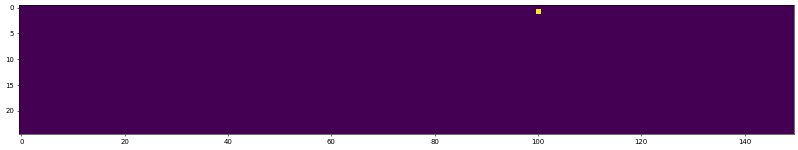

[715] {(100, 1)}


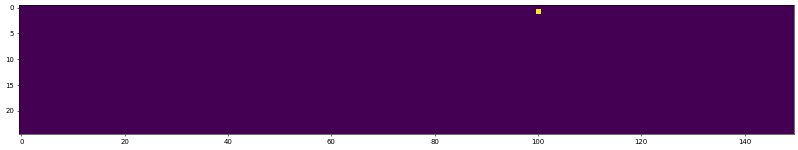

[821, 823] {(101, 1), (102, 1)}


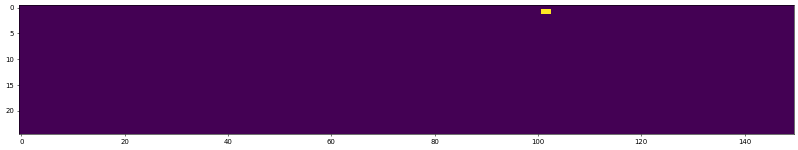

[902, 903, 906] {(62, 3), (32, 16), (63, 3), (33, 16)}


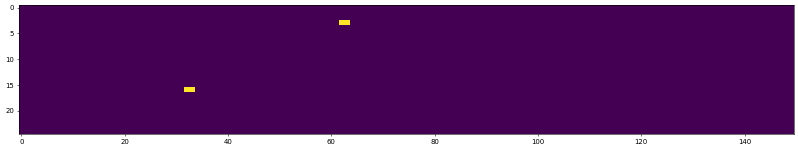

[919, 920, 921] {(58, 6), (59, 6), (126, 20), (60, 6)}


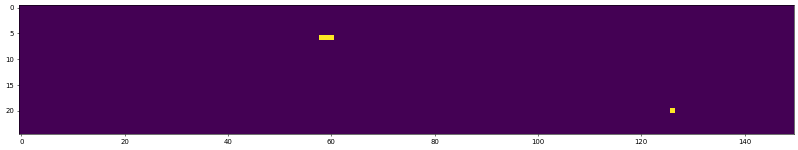

[968] {(127, 10)}


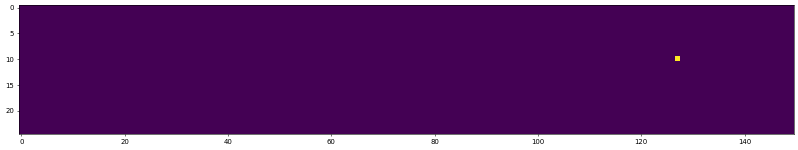

[1008, 1010, 1011] {(142, 10), (143, 10), (141, 10)}


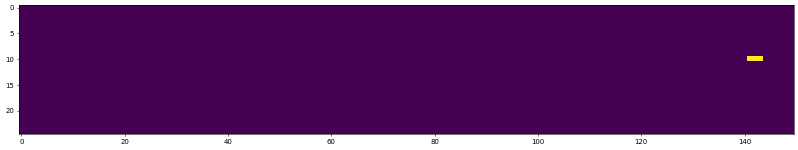

[1015, 1016] {(81, 20), (80, 20)}


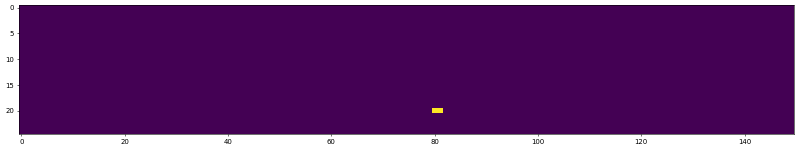

[1020] {(101, 18), (102, 18)}


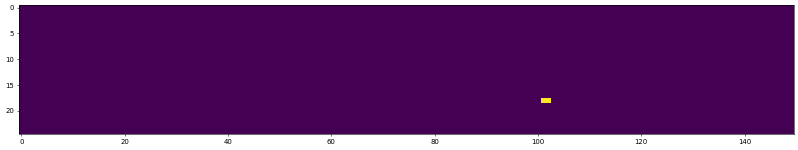

[1029, 1032, 1034, 1035, 1037, 1038, 1039, 1040] {(109, 17), (146, 10), (149, 10), (111, 17), (144, 10), (112, 17), (145, 10), (110, 17), (125, 6), (147, 10), (148, 10), (123, 6), (124, 6), (113, 17)}


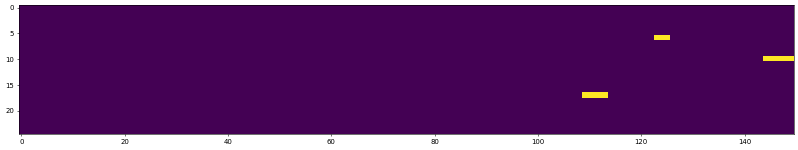

[1063, 1064, 1065, 1066, 1067] {(97, 21), (98, 21), (99, 21), (100, 21), (101, 21)}


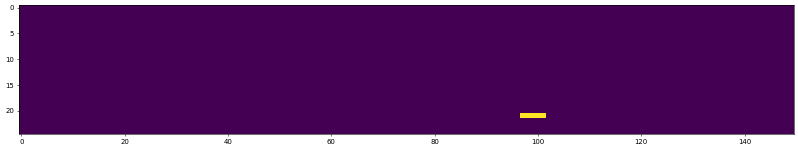

[1073, 1074] {(129, 22), (128, 22)}


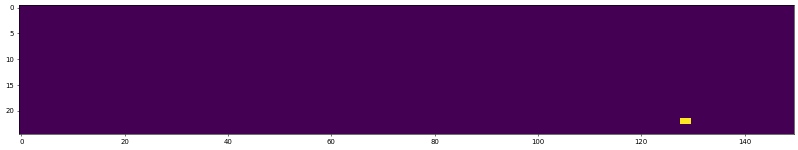

[1107] {(133, 19), (134, 19)}


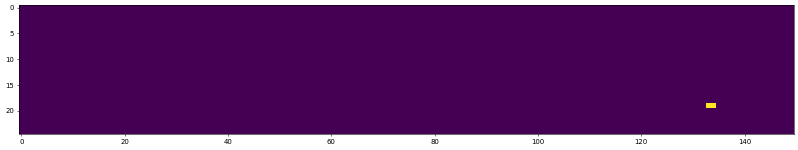

[1119, 1120, 1121] {(93, 13), (51, 6), (94, 13)}


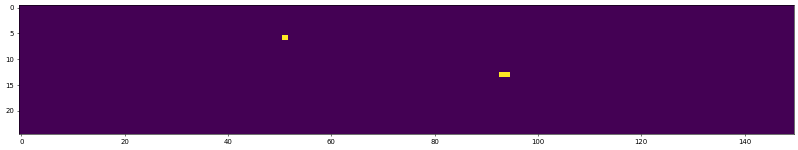

[1127, 1129, 1130, 1131, 1132, 1133] {(83, 13), (84, 13), (63, 21), (49, 6), (47, 6), (48, 6), (62, 21)}


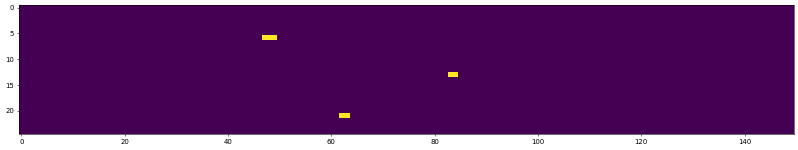

[1146, 1148] {(73, 5), (74, 5)}


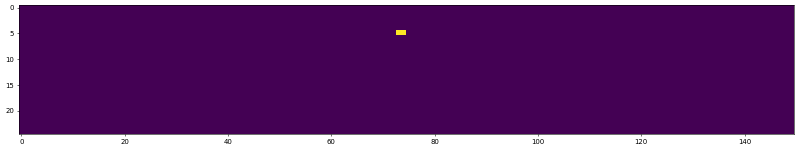

[1193] {(55, 21)}


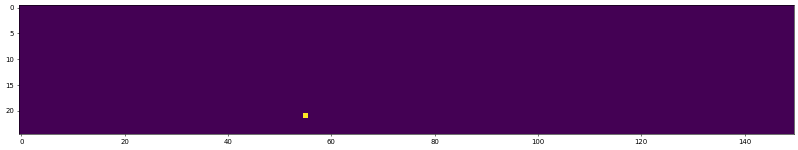

[1206, 1207, 1208] {(128, 23), (129, 23), (130, 23)}


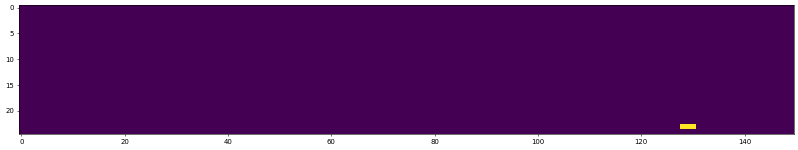

[1233, 1234, 1235, 1236] {(24, 19), (116, 15), (25, 19), (115, 15)}


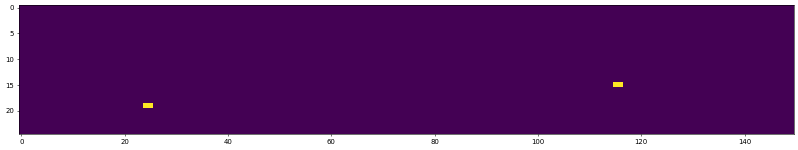

[1244] {(141, 0)}


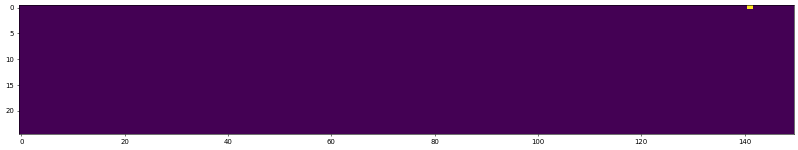

155 155 155
Muscle_map_150z25_60s_#30.npy
[17] {(137, 15), (136, 15)}


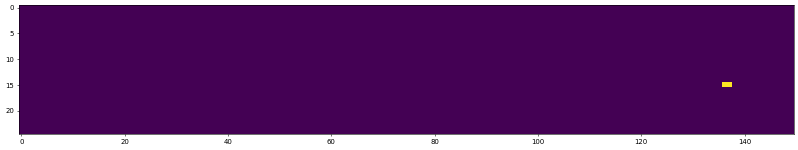

[120] {(109, 6)}


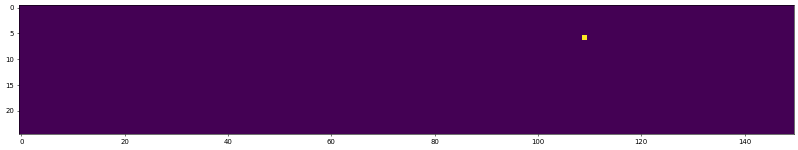

[160] {(83, 19)}


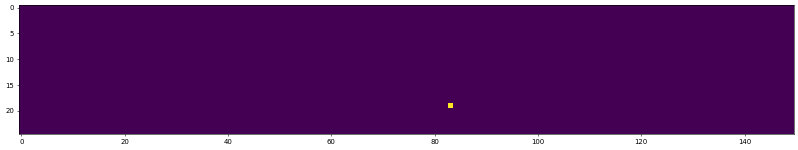

[286, 288] {(105, 12), (106, 12)}


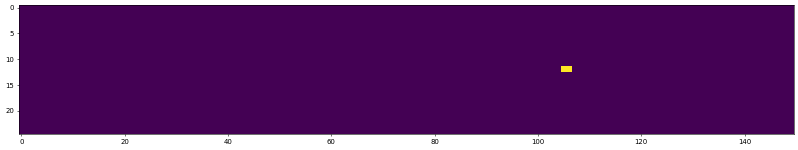

[314, 315] {(128, 12), (144, 13), (129, 12), (145, 13)}


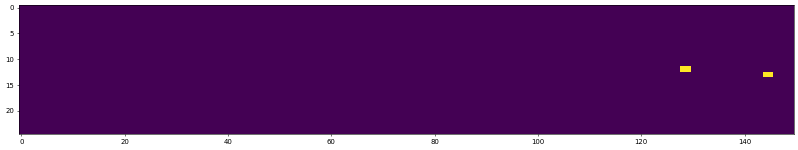

[329] {(6, 13), (7, 13)}


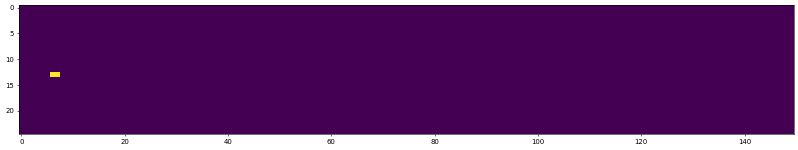

[337, 338] {(88, 12), (89, 12)}


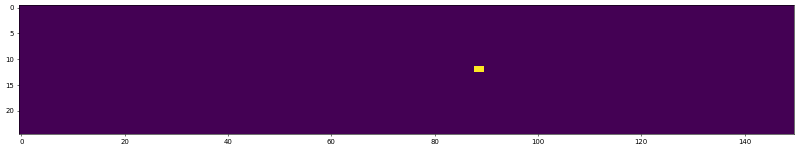

[347] {(39, 15)}


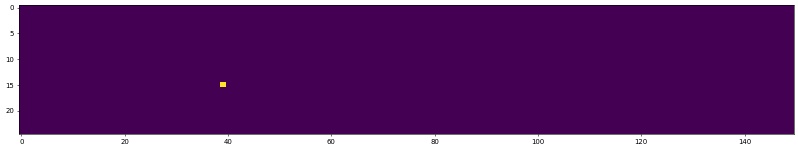

[365] {(114, 12)}


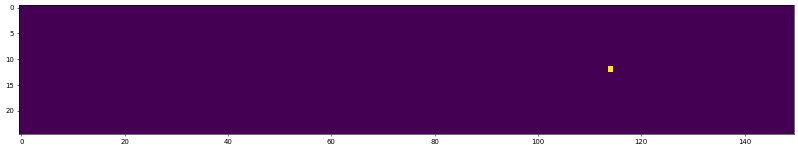

[383] {(79, 14)}


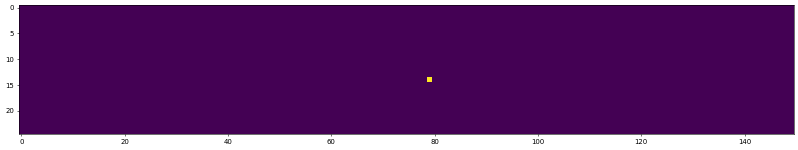

[419] {(0, 22), (1, 22)}


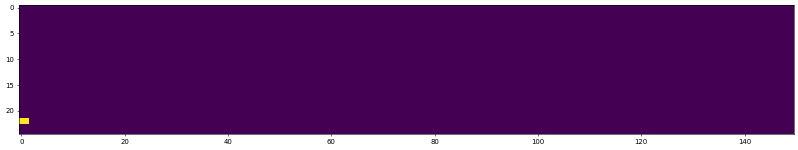

[426] {(72, 2)}


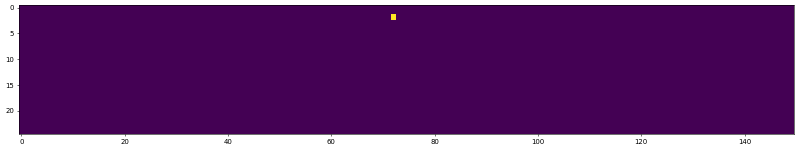

[475, 476, 479, 482] {(53, 5), (55, 5), (67, 13), (51, 5), (54, 5), (103, 19), (50, 5), (56, 5), (57, 5), (52, 5)}


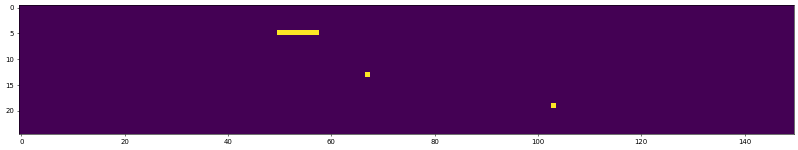

[510, 511, 514, 515, 517] {(31, 5), (27, 5), (28, 5), (29, 5), (30, 5)}


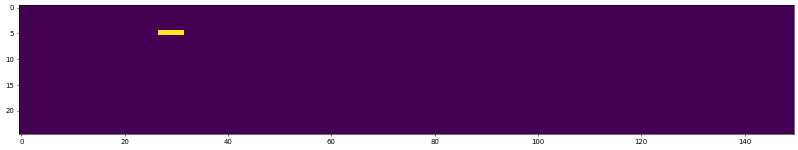

[523] {(56, 9), (55, 9)}


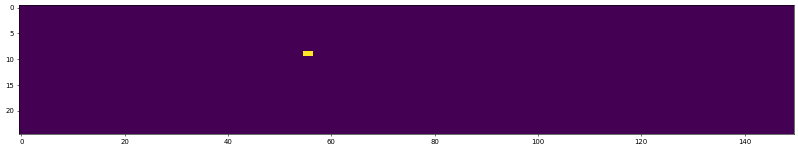

[555, 556, 557] {(102, 0), (100, 0), (101, 0)}


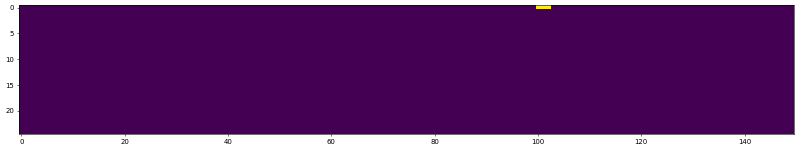

[622] {(60, 2), (61, 2)}


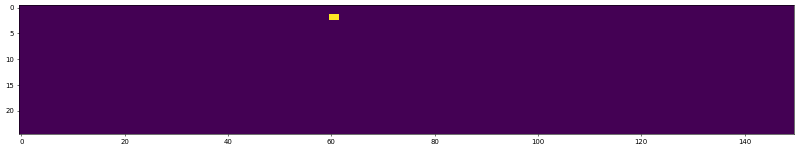

[631, 633] {(87, 2), (62, 4)}


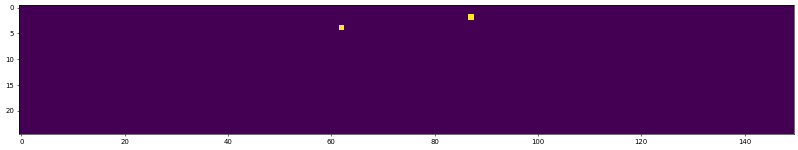

[646] {(97, 12), (98, 12)}


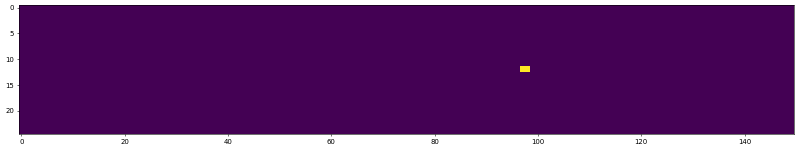

[653, 654, 656, 657, 658, 659] {(52, 7), (53, 7), (11, 22), (12, 22), (13, 22), (14, 22), (15, 22)}


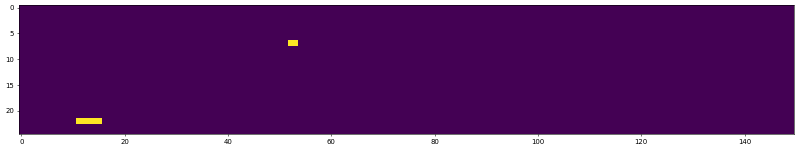

[736, 738, 740, 743, 744, 745] {(127, 4), (128, 4), (31, 7), (113, 8), (111, 8), (112, 8)}


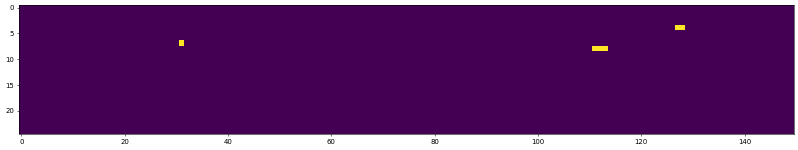

[804, 805, 806, 808, 810, 811] {(127, 3), (108, 9), (65, 4), (120, 9), (109, 9), (121, 9), (111, 9), (117, 9), (112, 9), (118, 9), (107, 9), (119, 9), (110, 9)}


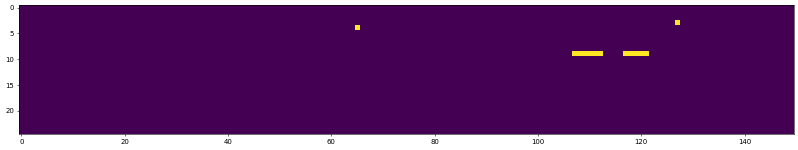

[829, 830] {(82, 24), (80, 24), (83, 24), (81, 24)}


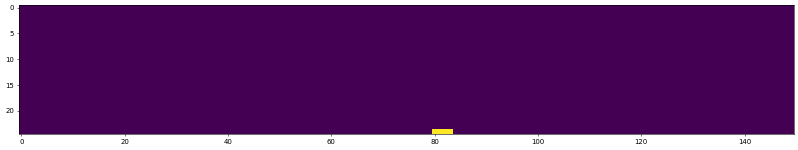

[846, 849, 852, 853] {(108, 9), (106, 9), (109, 9), (107, 9)}


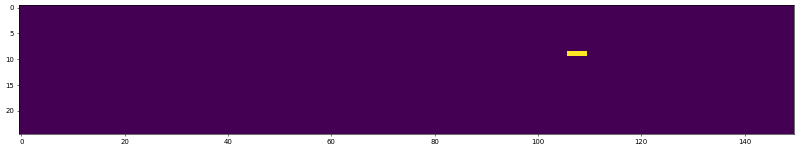

[954] {(148, 22), (114, 21), (115, 21)}


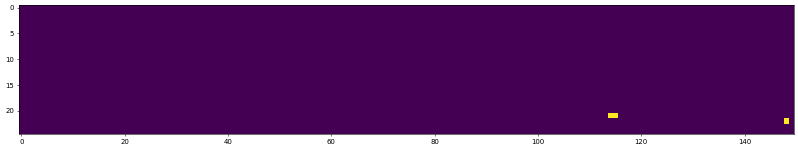

[993] {(105, 9)}


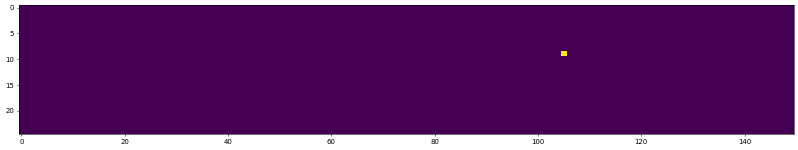

[1002] {(149, 21)}


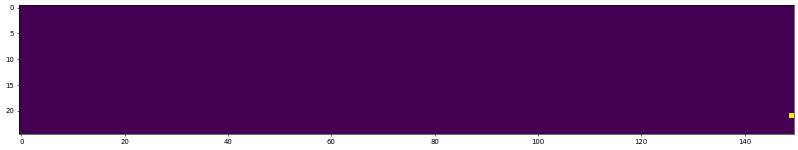

[1010] {(52, 13), (53, 13)}


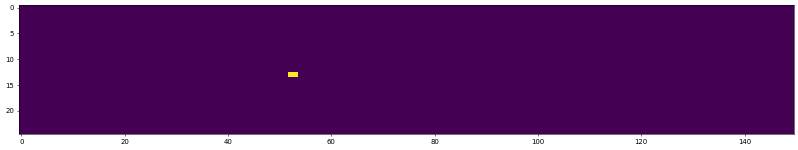

[1030] {(148, 18), (149, 18)}


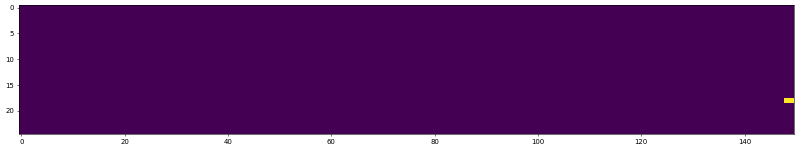

[1040, 1041, 1042, 1043, 1044, 1045] {(34, 6), (29, 6), (30, 6), (33, 6), (31, 6), (32, 6)}


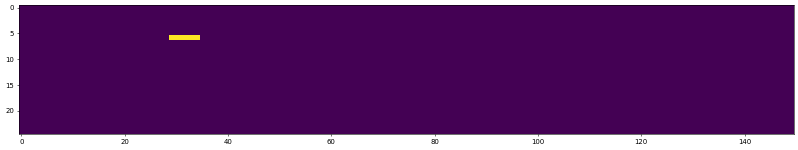

[1051] {(23, 11)}


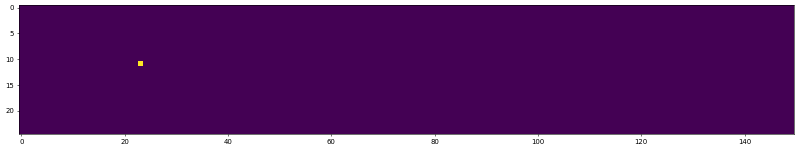

[1077, 1079] {(12, 1), (114, 7)}


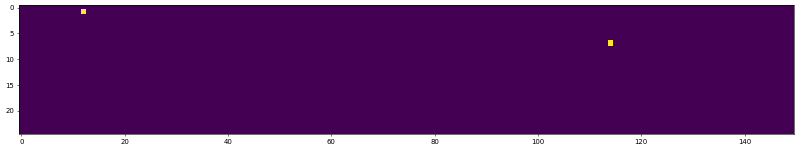

[1084] {(68, 19)}


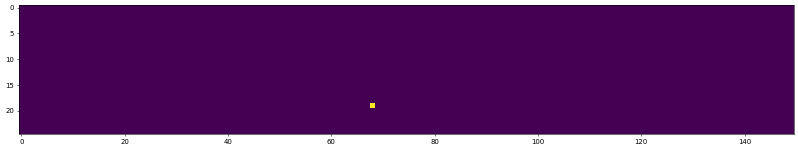

[1095] {(61, 23), (62, 23)}


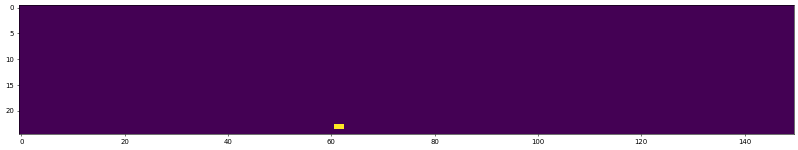

[1105] {(21, 3), (20, 3)}


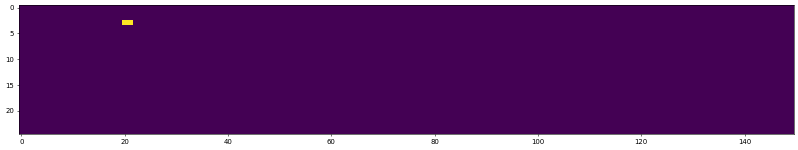

[1112] {(15, 0)}


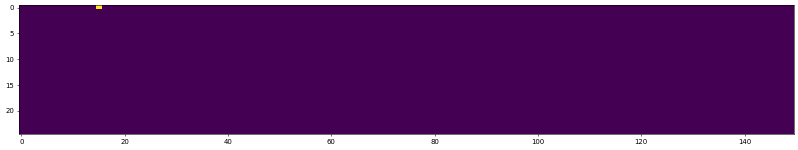

[1118] {(112, 18), (113, 18), (114, 18)}


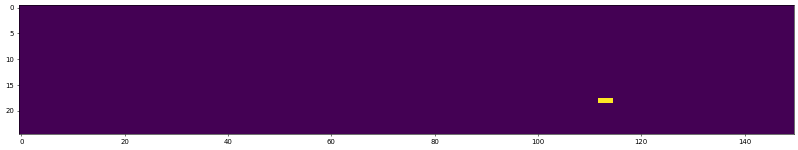

[1144] {(107, 17)}


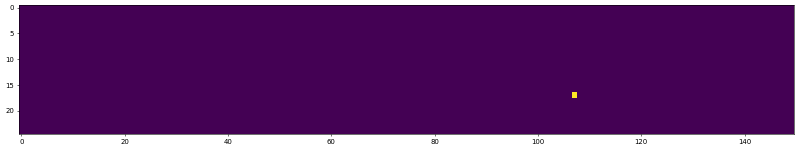

[1161, 1162, 1163] {(22, 18), (144, 19), (23, 18), (21, 18), (24, 18), (20, 18)}


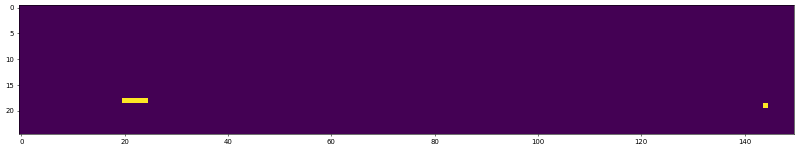

[1169] {(29, 9)}


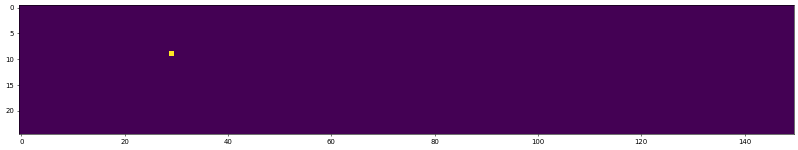

[1204, 1205] {(139, 23), (140, 23), (141, 23)}


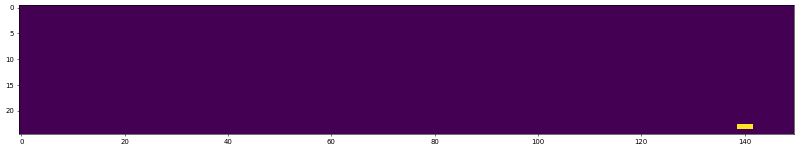

[1214, 1217, 1218] {(110, 8), (107, 8), (109, 8), (108, 8), (26, 2)}


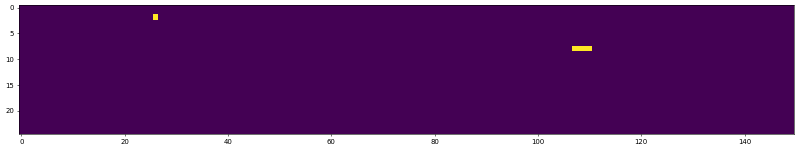

[1222] {(74, 4)}


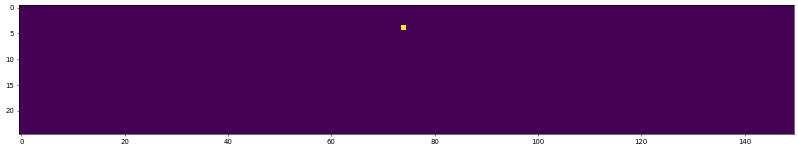

[1240] {(119, 19)}


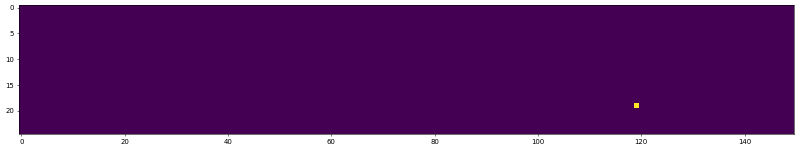

126 126 126
Muscle_map_150z25_60s_#21.npy
[8] {(129, 5)}


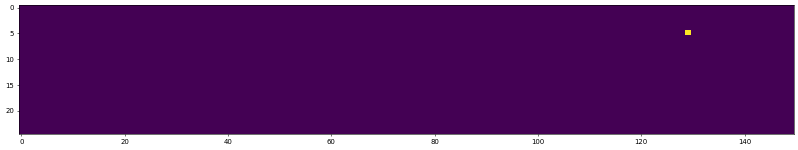

[14, 15] {(75, 23), (128, 5)}


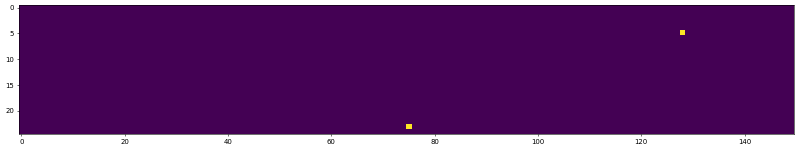

[29, 30] {(116, 9), (15, 12), (115, 9), (16, 12)}


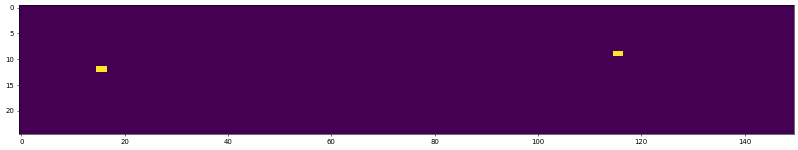

[35, 37, 39, 40, 41] {(109, 3), (120, 9), (117, 9), (118, 9), (110, 3), (119, 9)}


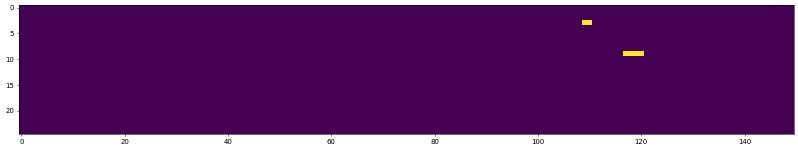

[56, 57] {(57, 8), (55, 8), (56, 8)}


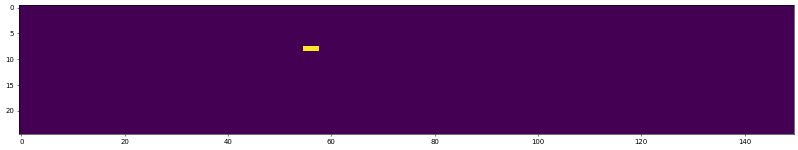

[146, 148, 151, 154, 155, 157] {(52, 8), (125, 10), (4, 19), (2, 19), (3, 19), (54, 8), (53, 8)}


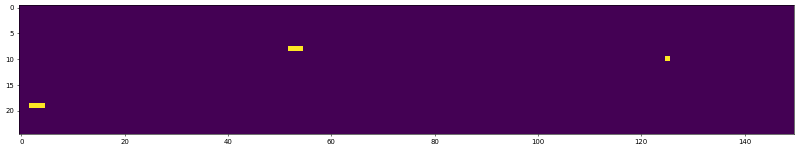

[164, 165, 166, 168, 169, 171] {(102, 11), (103, 11), (98, 11), (99, 11), (100, 11), (101, 11)}


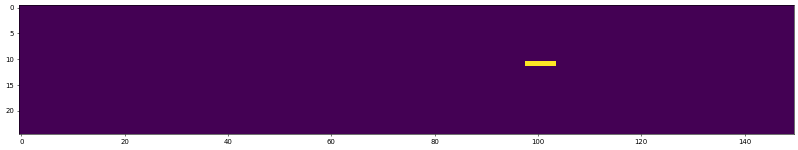

[186] {(21, 21), (22, 21)}


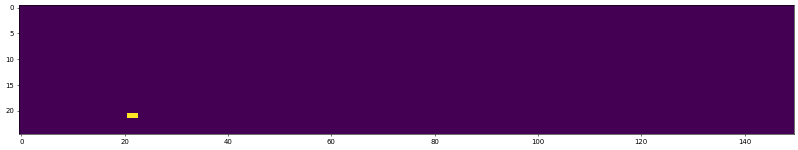

[190] {(23, 21), (24, 21)}


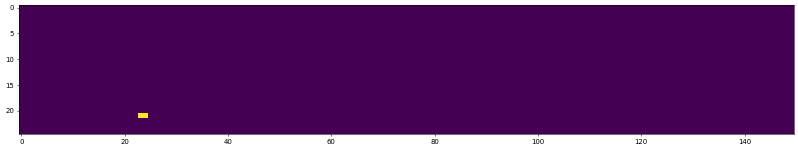

[198] {(49, 20), (50, 20)}


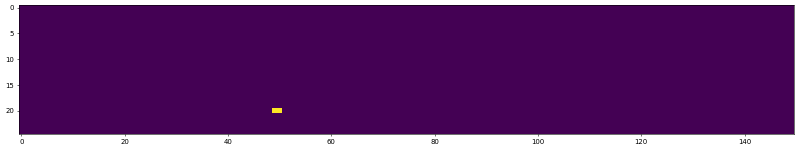

[247, 248] {(71, 6), (72, 6), (75, 6), (70, 6)}


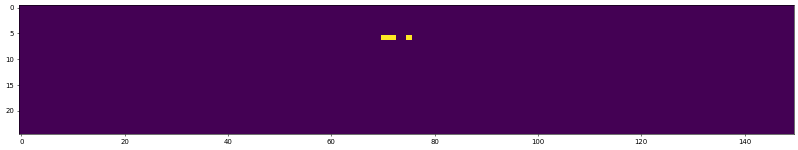

[277, 279] {(104, 12), (103, 12)}


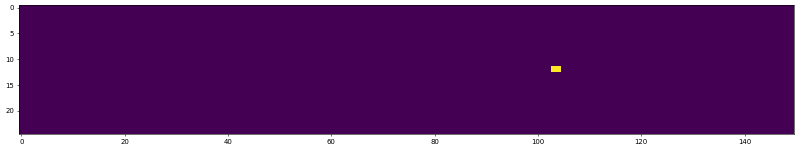

[296, 297] {(142, 5), (140, 5), (141, 5)}


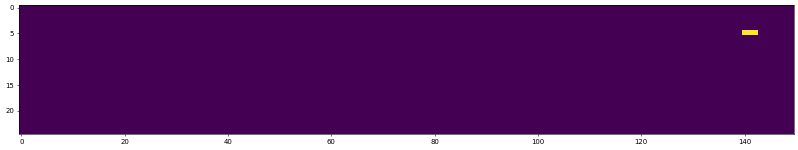

[339, 340, 341] {(128, 4), (129, 4), (131, 4), (2, 22), (3, 22), (130, 4), (1, 22)}


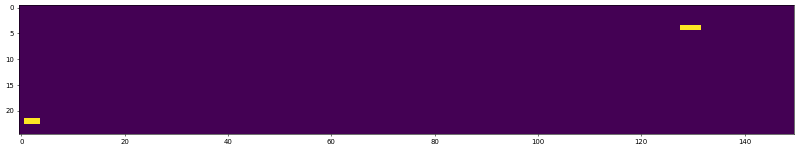

[367] {(130, 5)}


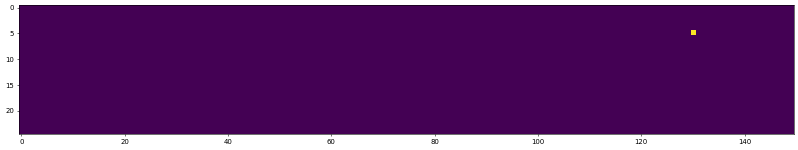

[379, 381, 384] {(45, 4), (46, 4), (47, 4)}


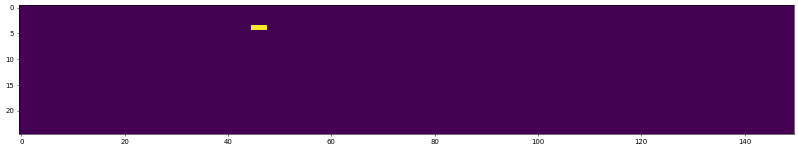

[446] {(78, 21)}


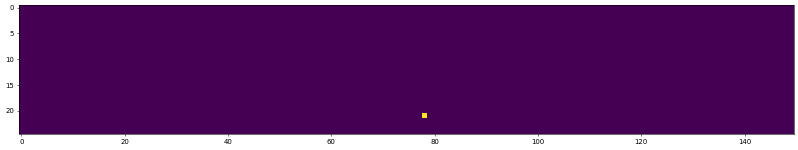

[458, 460] {(116, 5), (117, 5)}


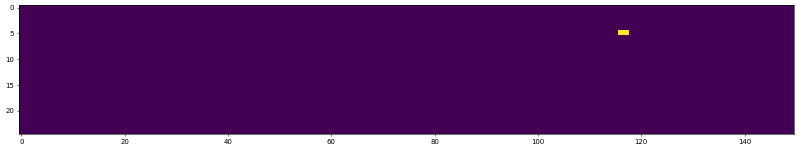

[513, 514, 516, 519, 520, 522, 524, 526, 528, 531, 532, 534, 537] {(49, 7), (44, 7), (39, 2), (50, 7), (45, 7), (40, 7), (46, 7), (52, 7), (47, 7), (41, 7), (48, 7), (43, 7), (51, 7), (40, 2), (42, 7)}


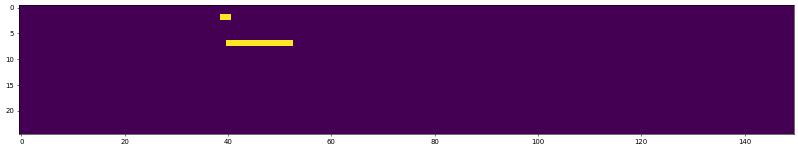

[560, 561, 562] {(125, 13), (126, 13), (127, 13)}


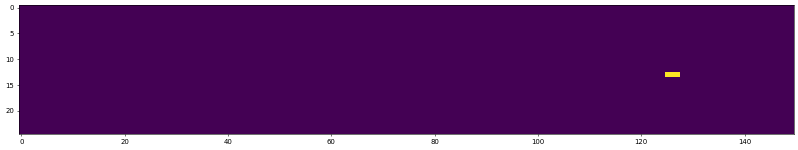

[568] {(124, 13)}


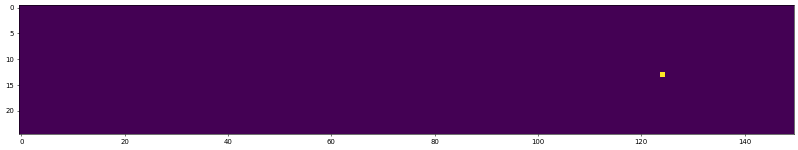

[575] {(123, 13)}


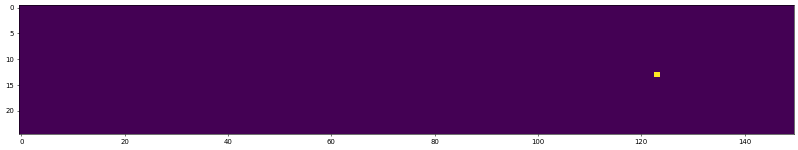

[580] {(69, 16)}


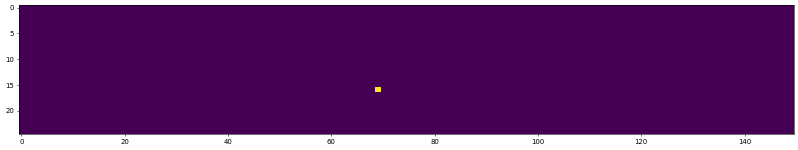

[584] {(16, 7), (8, 4), (21, 6), (17, 4)}


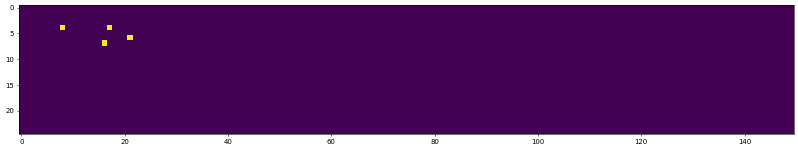

[590, 592] {(144, 13), (145, 13)}


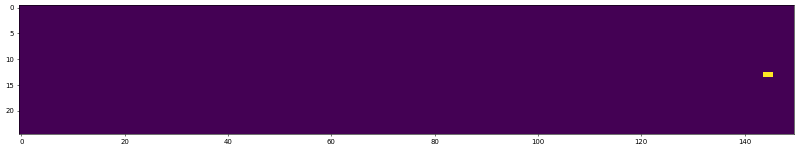

[620] {(94, 24)}


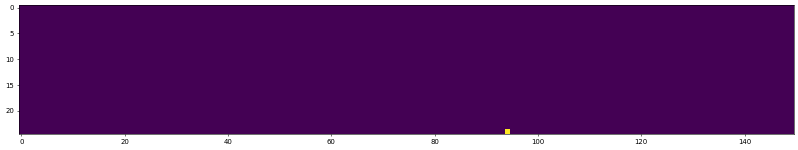

[699] {(123, 2), (124, 2), (122, 2)}


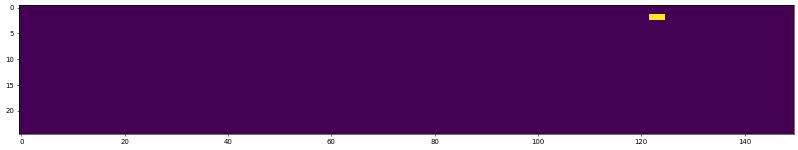

[713, 715, 717, 718, 719, 720] {(91, 21), (93, 21), (15, 13), (13, 13), (14, 13), (92, 21), (94, 21)}


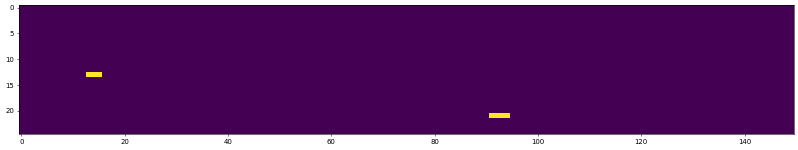

[752, 753, 754] {(94, 0), (95, 0), (96, 0), (97, 0), (93, 0)}


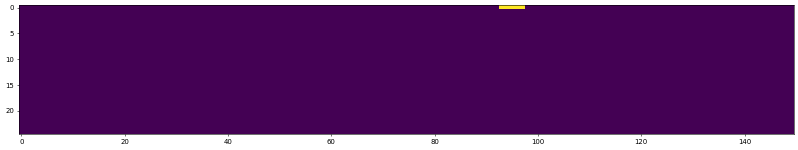

[830, 833, 834] {(147, 7), (104, 18), (105, 18), (146, 7)}


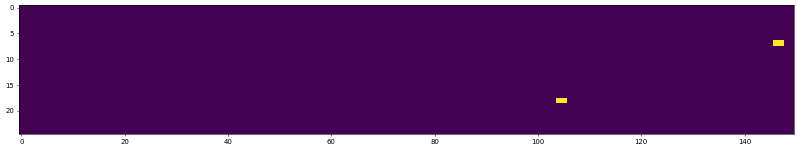

[847] {(55, 17)}


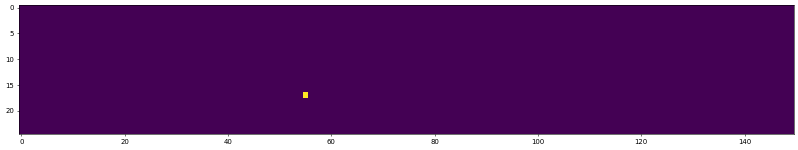

[902] {(8, 2)}


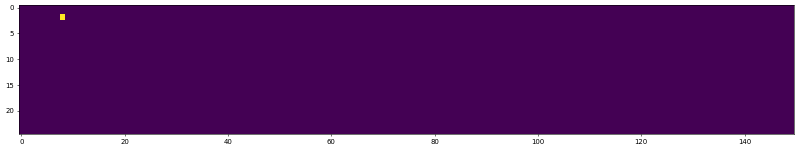

[927, 928] {(147, 12), (148, 12)}


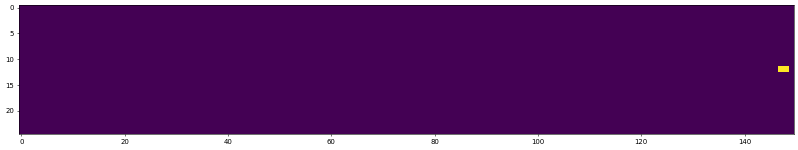

[937] {(97, 0)}


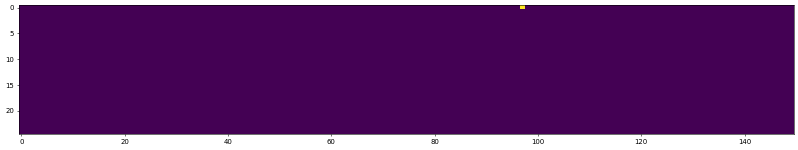

[978] {(30, 19)}


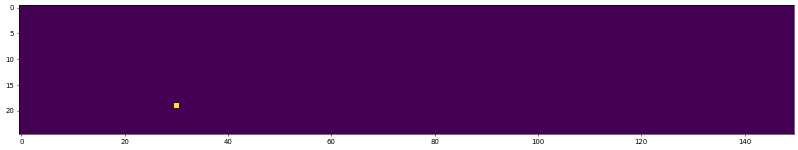

[986] {(14, 12), (13, 12)}


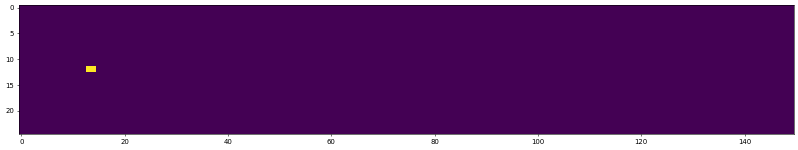

[1007] {(90, 16)}


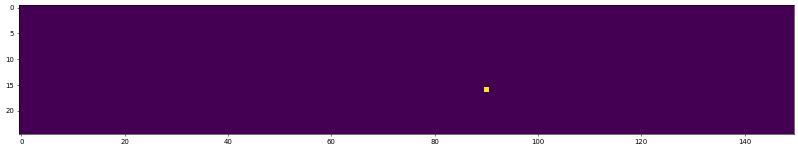

[1023, 1024] {(89, 3), (90, 3), (88, 3)}


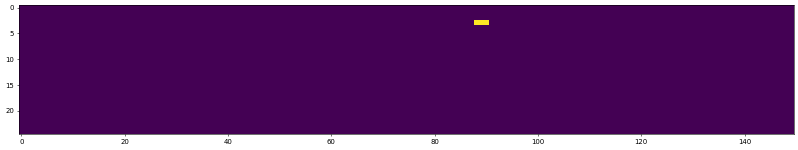

[1046] {(133, 2)}


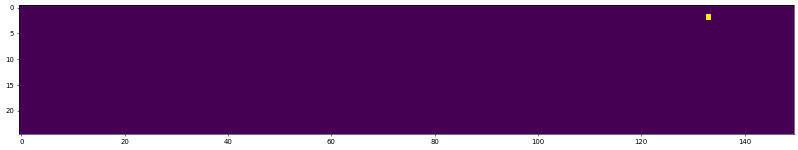

[1071, 1073] {(4, 7), (5, 7), (146, 24)}


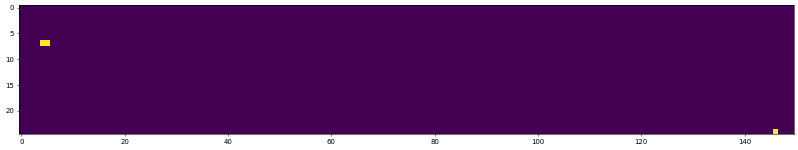

[1095, 1096, 1097] {(139, 24), (96, 3), (94, 3), (97, 3), (99, 3), (95, 3), (98, 3), (131, 3), (132, 5), (133, 5)}


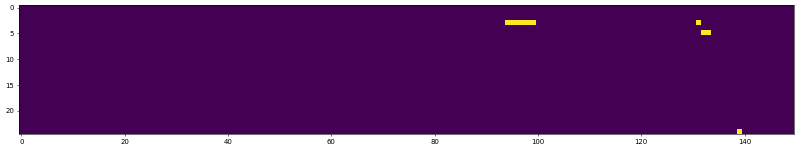

[1102, 1103, 1104, 1105] {(5, 11), (71, 20), (136, 21), (72, 20), (87, 11), (4, 11)}


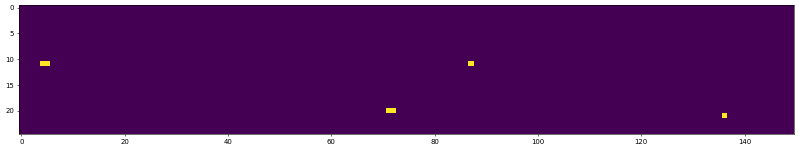

[1155] {(88, 2), (89, 2)}


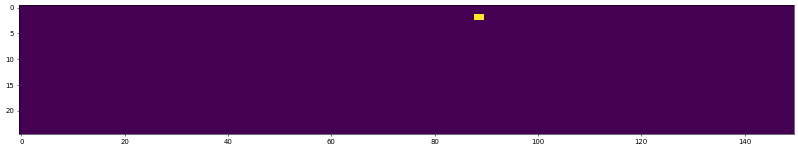

[1193, 1195, 1198, 1200, 1202] {(92, 0), (90, 0), (91, 0), (75, 5), (100, 21), (73, 5), (101, 21), (74, 5)}


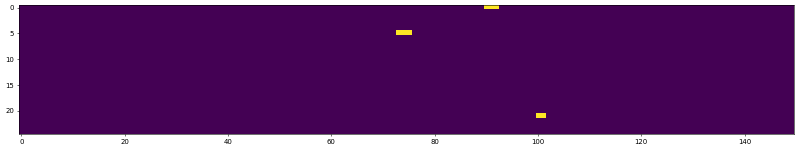

[1208] {(54, 10)}


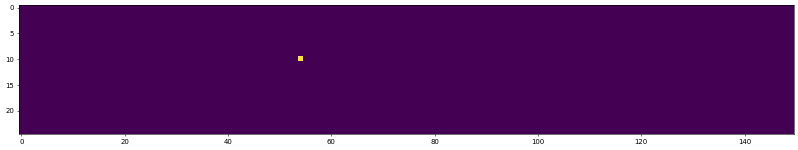

[1213, 1216, 1217] {(120, 13), (144, 9), (145, 9)}


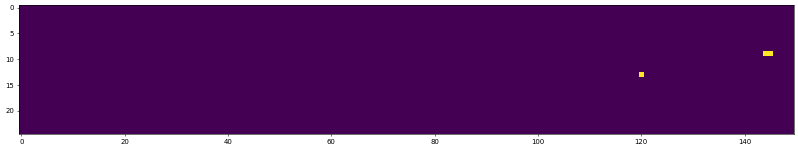

[1231, 1233, 1235, 1236, 1237, 1239] {(144, 1), (139, 1), (140, 1), (141, 1), (143, 1), (142, 1), (138, 1)}


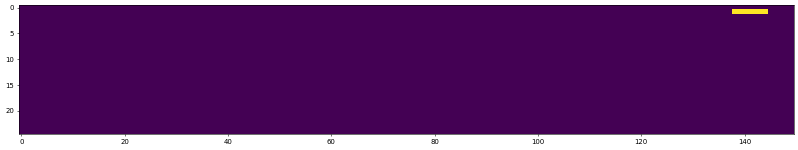

161 161 161
Muscle_map_150z25_60s_#32.npy
[12] {(61, 16)}


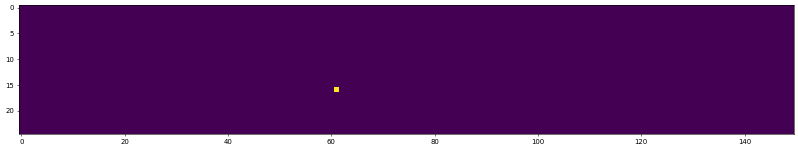

[37] {(122, 0)}


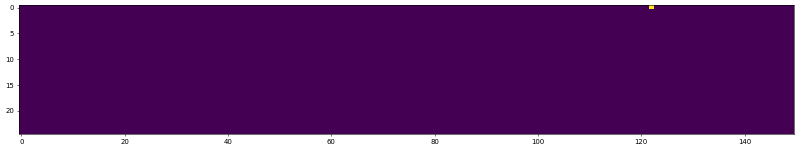

[42] {(123, 0)}


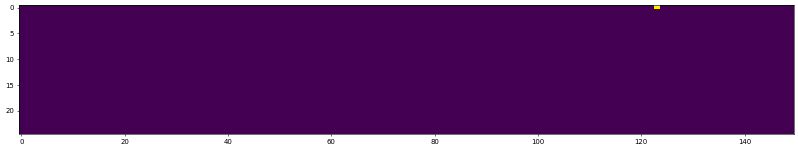

[53] {(106, 24), (107, 24)}


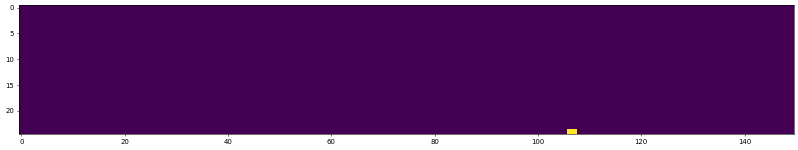

[67] {(49, 17)}


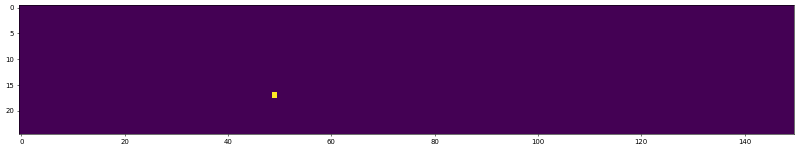

[114] {(112, 11)}


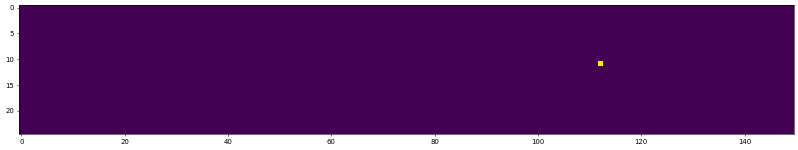

[121, 123] {(92, 14), (93, 14)}


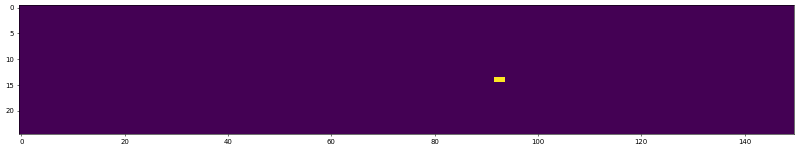

[150, 152, 153] {(94, 15), (93, 15), (93, 21)}


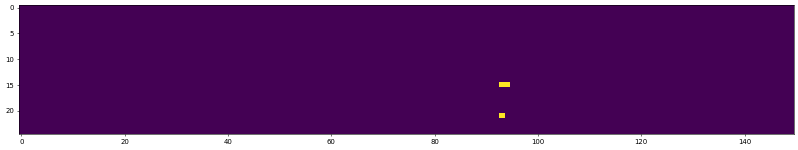

[188] {(90, 4)}


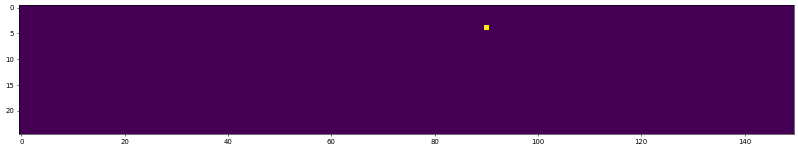

[236, 238, 240] {(148, 23), (146, 23), (147, 23)}


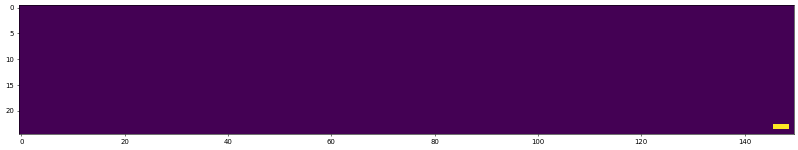

[253, 256] {(58, 17), (56, 17), (57, 17)}


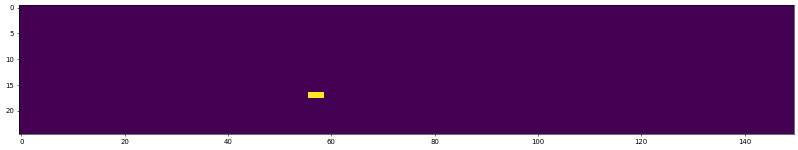

[292] {(59, 11)}


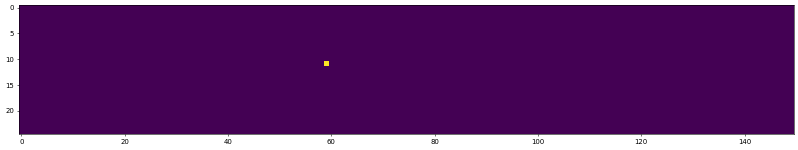

[356] {(36, 11), (35, 11)}


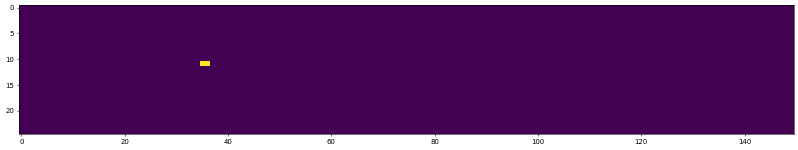

[372] {(114, 20), (115, 20)}


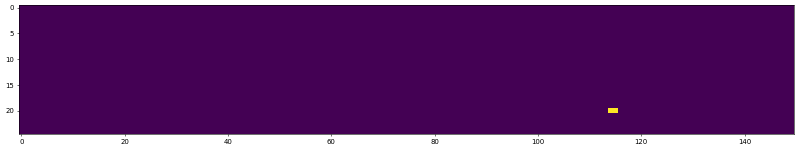

[387] {(88, 20)}


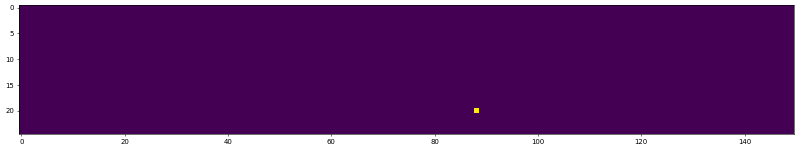

[391] {(88, 20)}


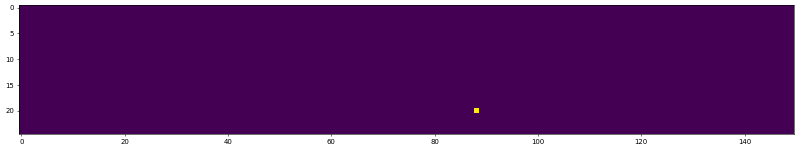

[396, 397, 398, 400, 401] {(126, 2), (130, 2), (125, 2), (127, 2), (128, 2), (129, 2), (124, 2)}


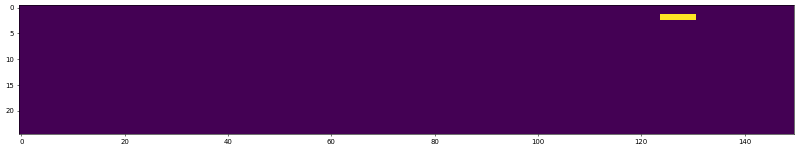

[420] {(70, 5)}


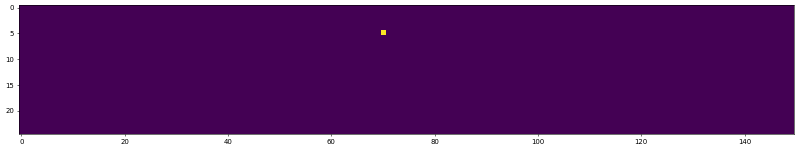

[431] {(36, 14)}


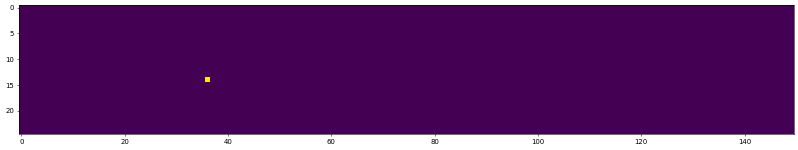

[453, 455, 458, 461] {(31, 2), (30, 2), (28, 2), (29, 2)}


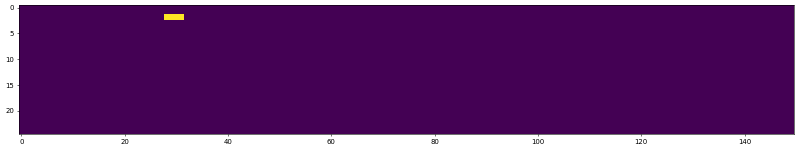

[492] {(4, 8), (5, 8)}


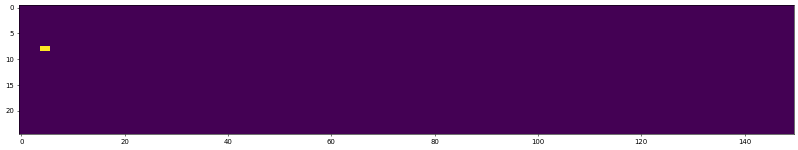

[502] {(114, 3), (115, 3)}


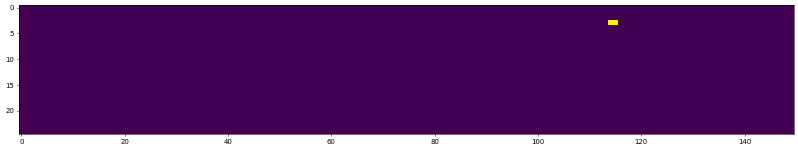

[511, 514] {(47, 11), (48, 11), (46, 11)}


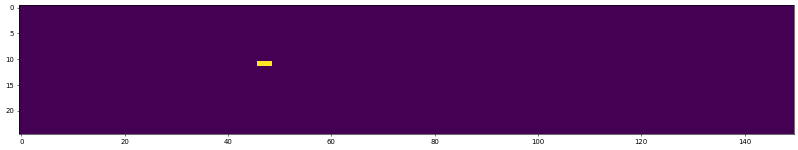

[524, 526] {(19, 3), (18, 3)}


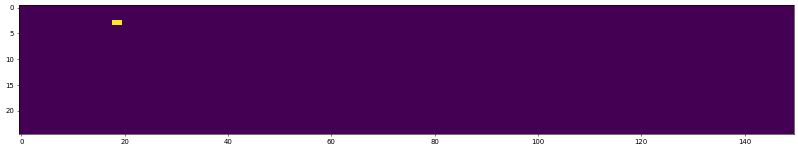

[563, 564] {(29, 5), (30, 5)}


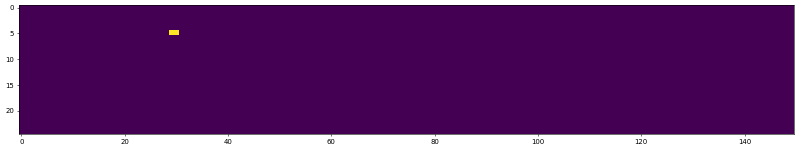

[573] {(100, 11)}


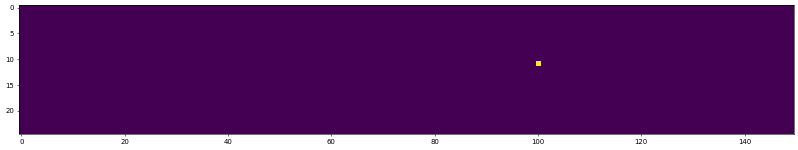

[584] {(100, 11)}


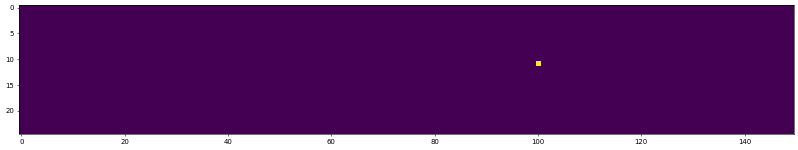

[636] {(103, 14)}


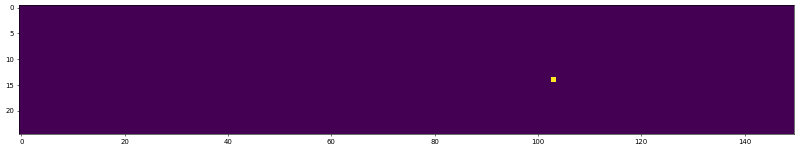

[646] {(110, 1), (111, 1)}


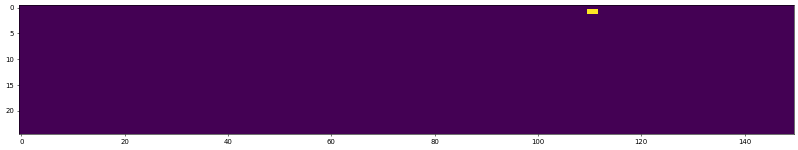

[663, 666] {(1, 11), (2, 11)}


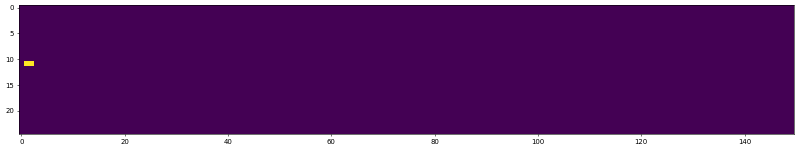

[670, 673] {(4, 11), (3, 11)}


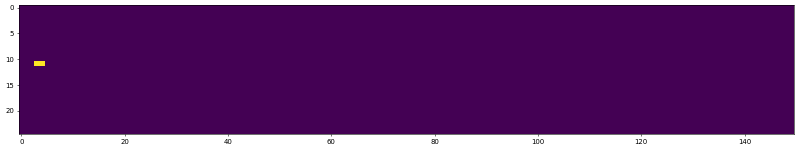

[707] {(106, 19), (107, 19)}


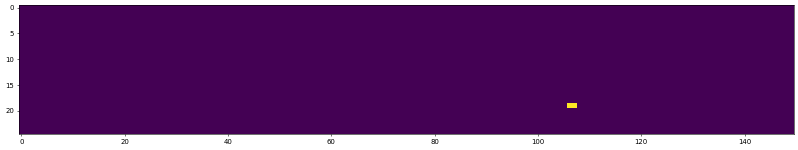

[790, 791] {(110, 18), (111, 18)}


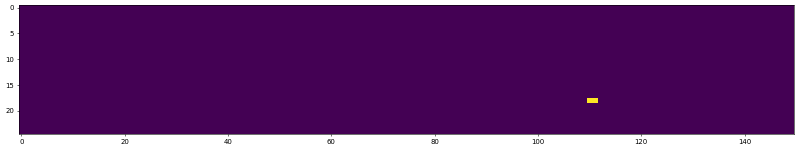

[807, 809, 811] {(2, 5), (3, 5), (1, 5)}


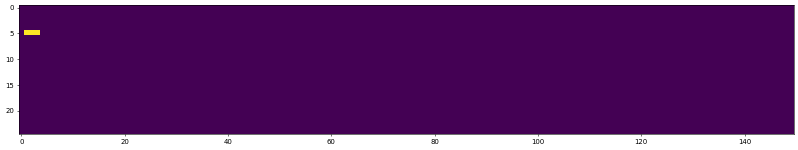

[862, 863] {(104, 18), (105, 18), (103, 18)}


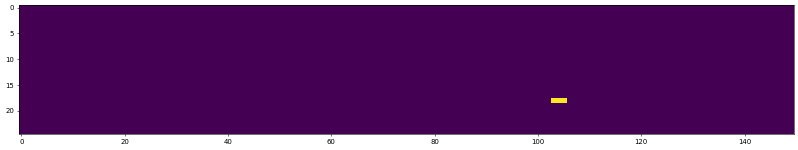

[883, 885, 886] {(137, 10), (48, 5), (136, 10), (31, 10), (72, 22)}


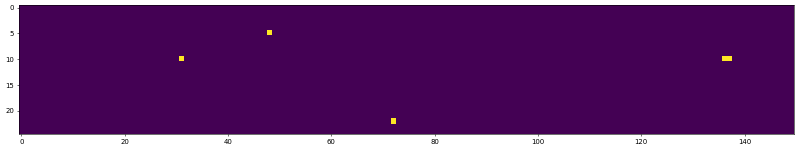

[893] {(3, 5)}


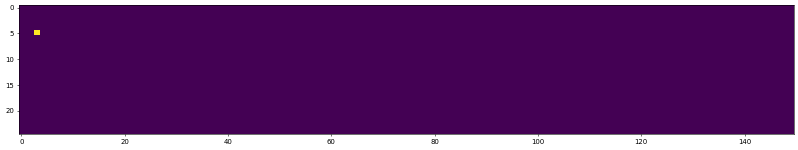

[924, 925] {(109, 12), (110, 12)}


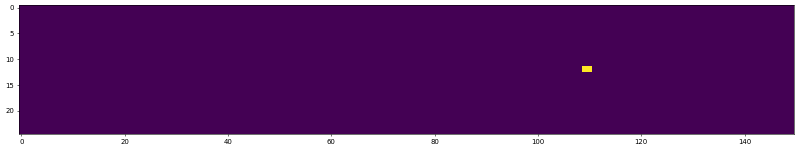

[929] {(95, 12)}


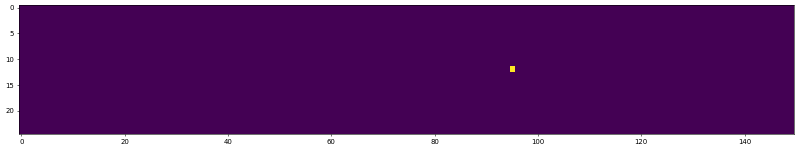

[947, 948, 949, 950, 951, 952, 954, 955, 958] {(116, 20), (117, 20), (56, 7), (57, 7), (58, 7), (55, 7), (70, 15), (71, 15), (115, 20), (59, 7)}


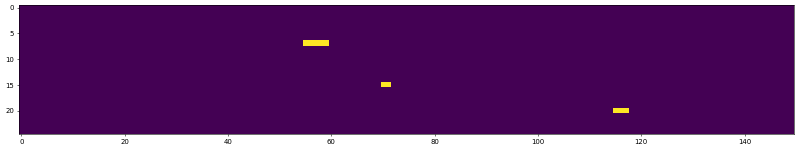

[963] {(87, 21)}


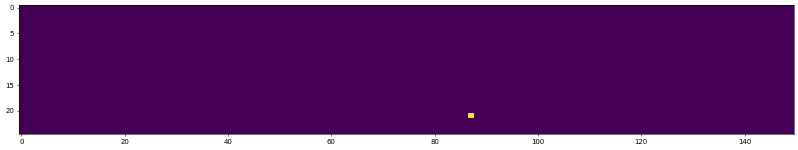

[974, 976, 978, 979, 981, 982, 984] {(49, 16), (144, 7), (145, 7), (47, 16), (147, 7), (48, 16), (146, 7)}


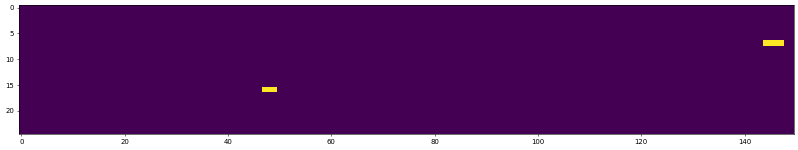

[1009, 1011] {(78, 8), (79, 8)}


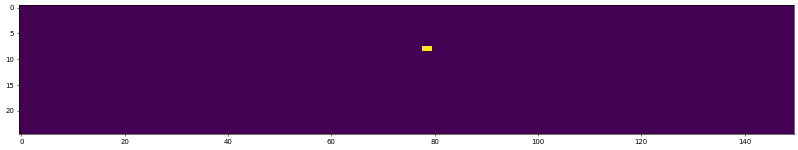

[1046, 1047] {(38, 7), (36, 7), (37, 7)}


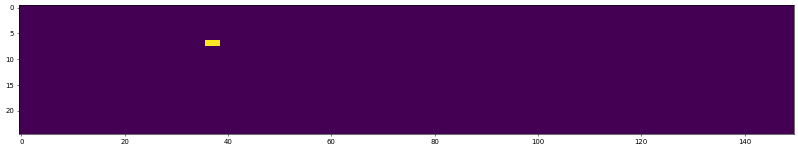

[1067, 1068, 1069, 1070, 1071] {(39, 21), (117, 2), (120, 2), (38, 21), (121, 2), (40, 21), (118, 2), (119, 2)}


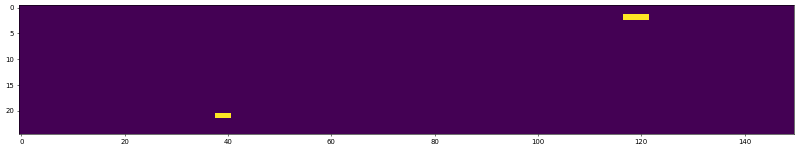

[1078] {(115, 23), (114, 23)}


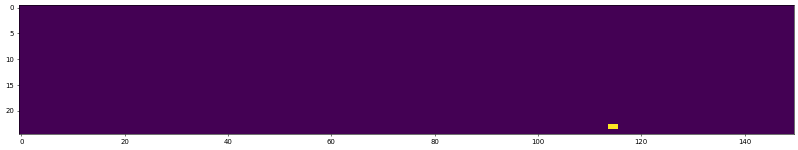

[1180] {(80, 18)}


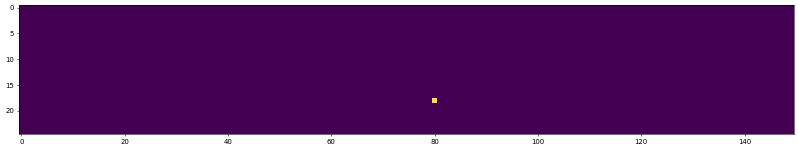

[1216, 1217] {(126, 22), (124, 22), (127, 22), (125, 22)}


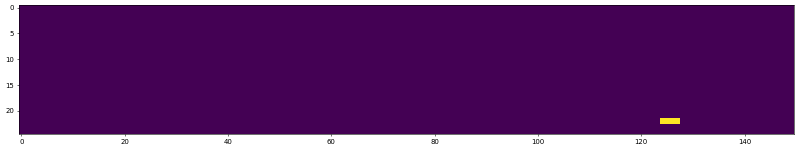

112 112 112
Liver_map_150z25_60s_#14.npy
[24] {(127, 10)}


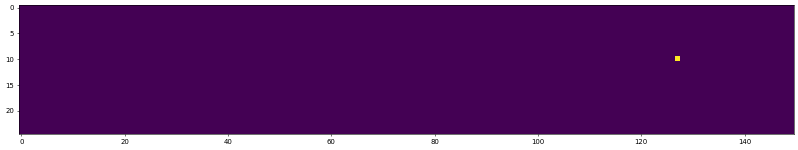

[61, 63] {(9, 12), (8, 12)}


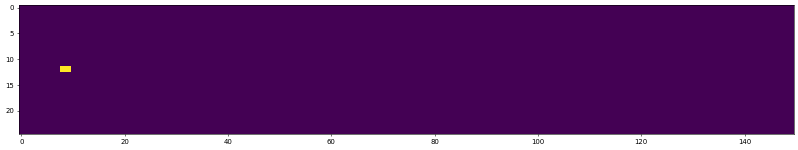

[92] {(3, 19)}


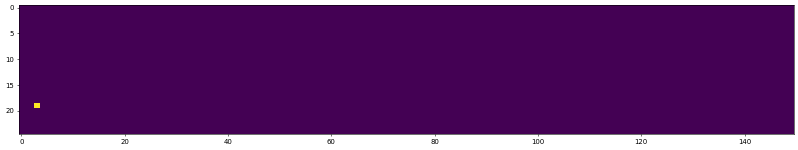

[108] {(25, 10)}


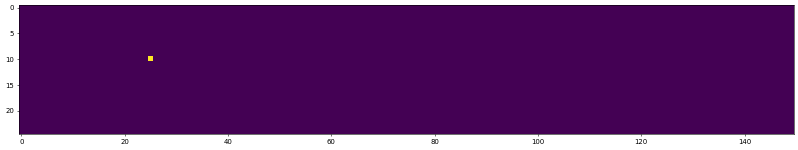

[114, 116, 117, 120] {(146, 12), (149, 12), (144, 12), (145, 12), (148, 12)}


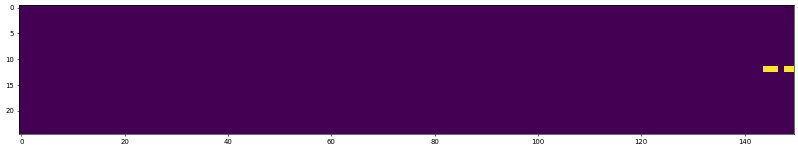

[184] {(129, 10), (130, 10)}


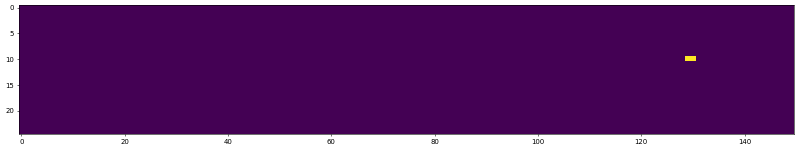

[193] {(133, 10)}


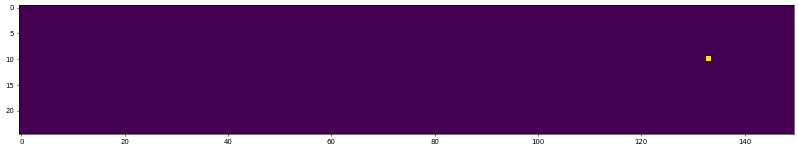

[217, 218] {(56, 20), (55, 20)}


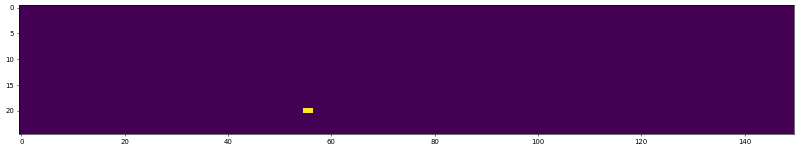

[246] {(113, 5)}


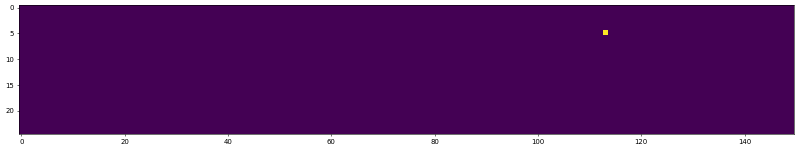

[270] {(36, 5)}


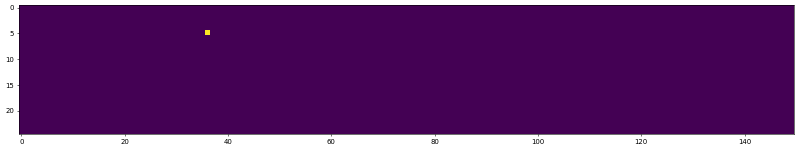

[293] {(7, 5)}


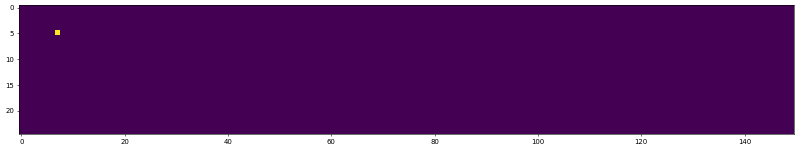

[298] {(73, 20), (72, 20)}


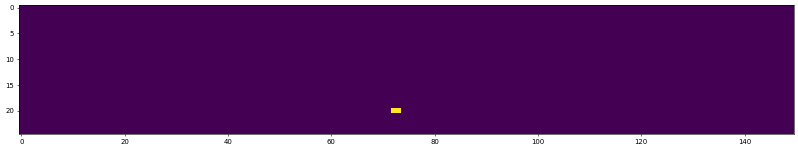

[313, 316] {(148, 10), (7, 5), (149, 10), (6, 5)}


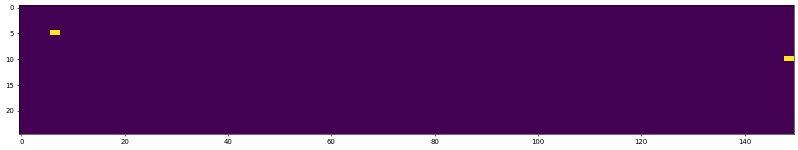

[334] {(77, 0)}


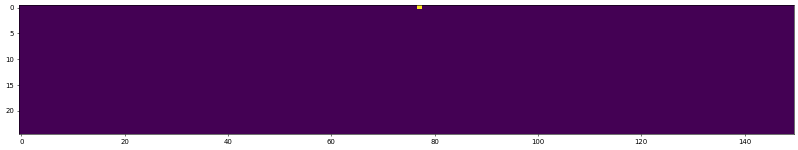

[342, 344, 345] {(137, 15), (135, 15), (138, 15), (136, 15)}


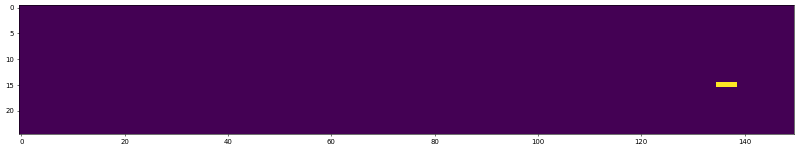

[378, 380, 383, 385] {(26, 11), (104, 13), (114, 6), (105, 13)}


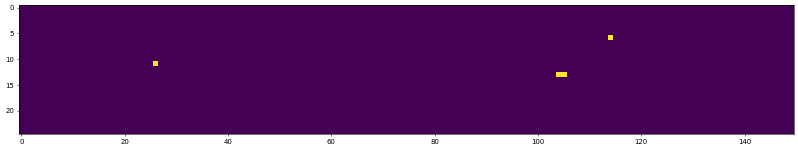

[399] {(128, 9)}


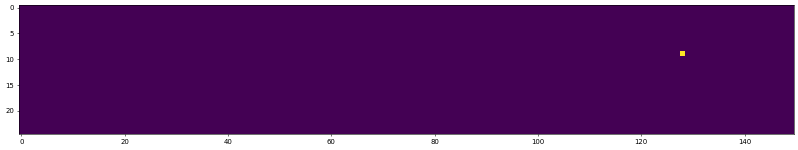

[403] {(40, 5)}


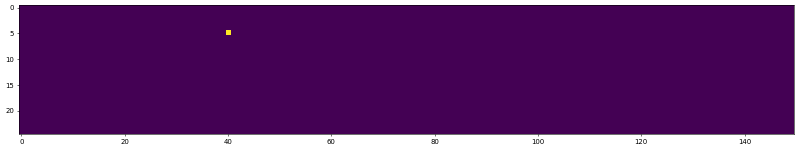

[418] {(14, 15)}


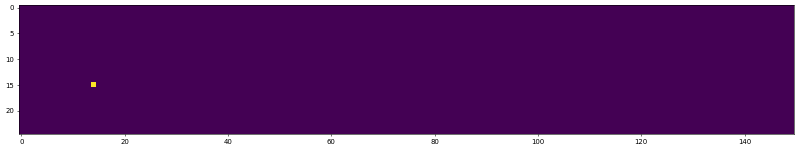

[440] {(131, 10)}


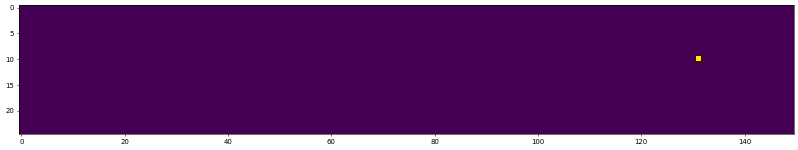

[451, 454, 456, 458, 459, 460, 461] {(134, 0), (137, 0), (139, 0), (140, 0), (135, 0), (141, 0)}


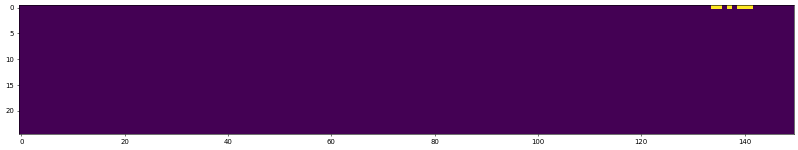

[523] {(117, 23)}


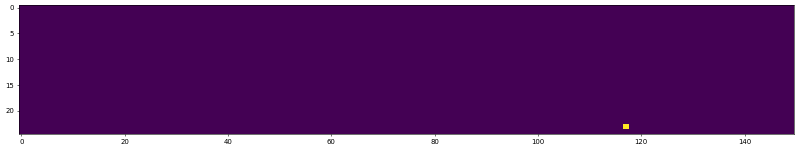

[530] {(123, 12)}


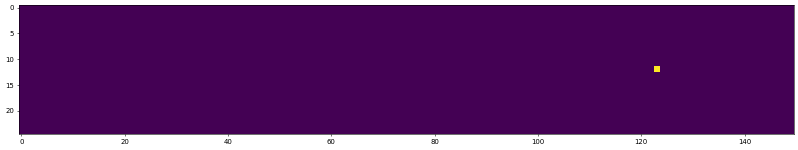

[610, 611, 613, 614, 617] {(130, 12), (137, 24), (132, 12), (131, 12), (117, 2), (118, 2), (138, 24)}


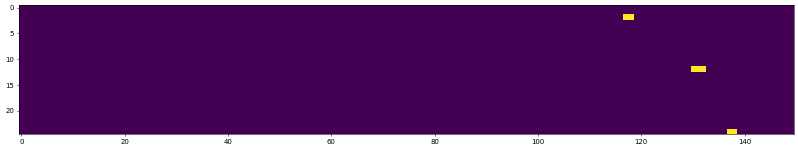

[658] {(149, 11)}


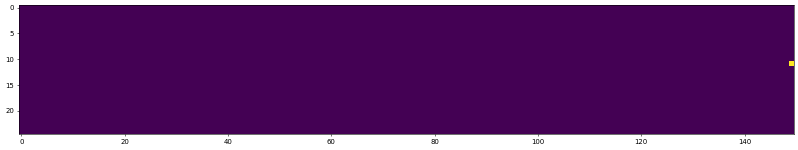

[717] {(134, 8), (135, 8)}


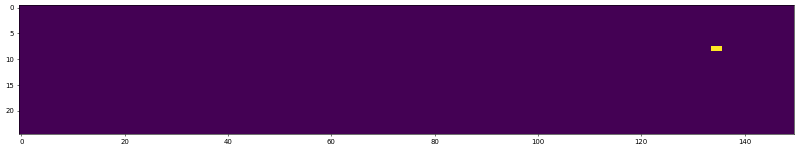

[725, 728, 731] {(57, 19), (102, 12), (58, 19), (103, 12)}


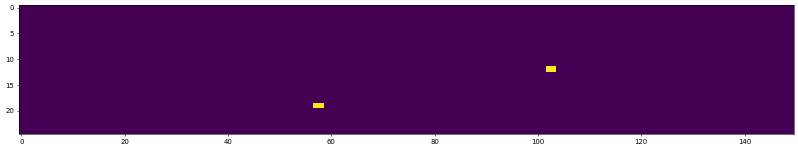

[747] {(9, 10), (11, 10), (12, 10), (7, 10), (13, 10), (8, 10), (14, 10), (10, 10), (6, 10)}


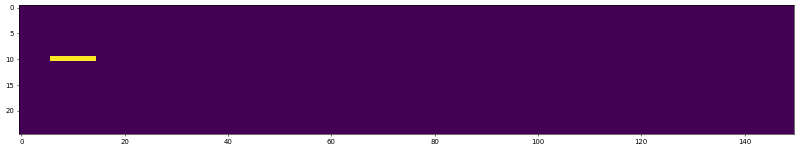

[752] {(13, 5)}


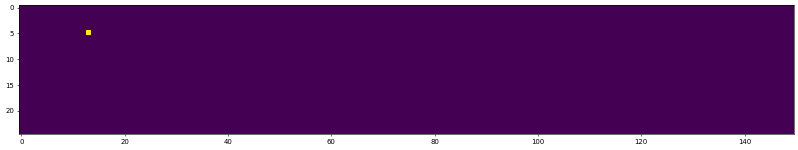

[758, 759] {(118, 5), (116, 5), (117, 5)}


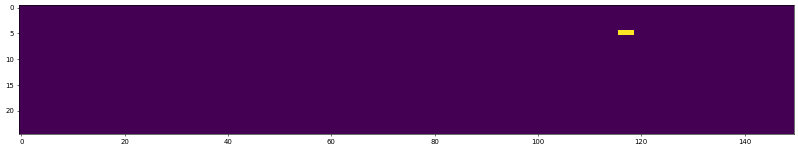

[770, 771, 772, 773, 774] {(26, 5), (27, 5), (25, 5), (23, 5), (24, 5)}


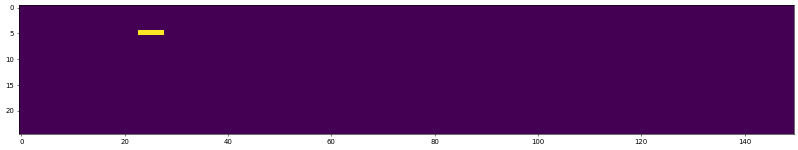

[798] {(100, 11), (101, 11)}


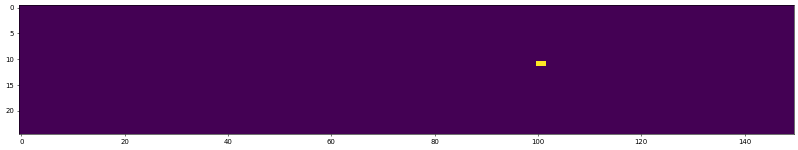

[833, 834, 836] {(108, 6), (109, 6), (105, 6), (111, 6), (106, 6), (112, 6), (107, 6), (110, 6)}


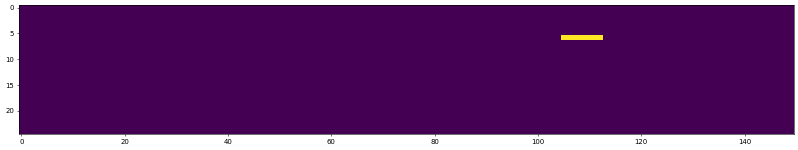

[841, 842] {(142, 23), (140, 23), (141, 23)}


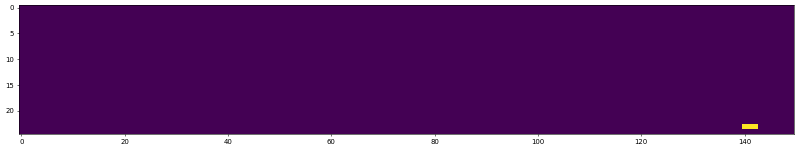

[866] {(31, 12), (30, 12)}


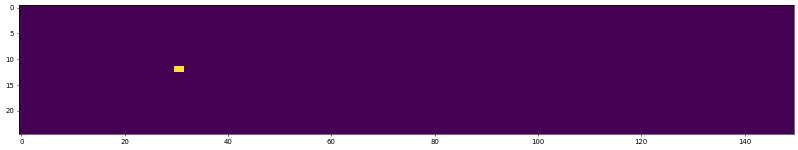

[870, 871] {(29, 12), (30, 12)}


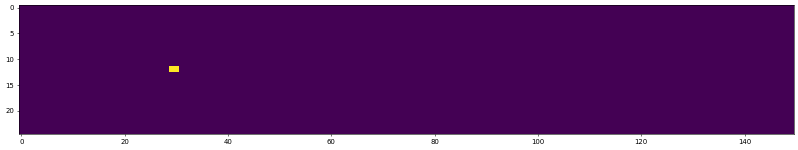

[879, 880] {(104, 0), (102, 0), (103, 0)}


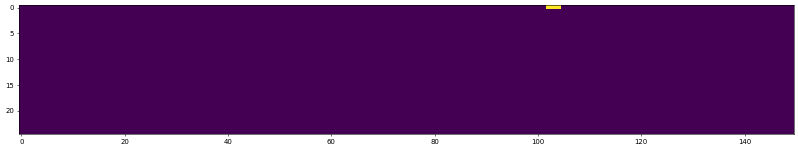

[956, 957] {(124, 21), (122, 21), (121, 21), (123, 21)}


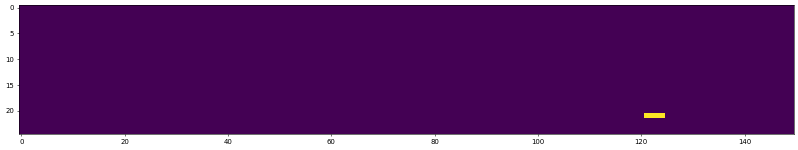

[1021] {(77, 9)}


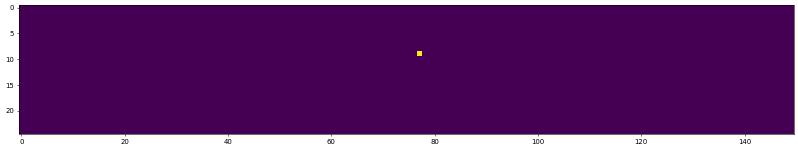

[1039, 1040] {(147, 18), (148, 18)}


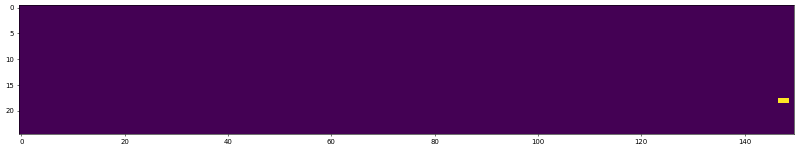

[1048, 1049, 1050] {(23, 0), (21, 0), (22, 0)}


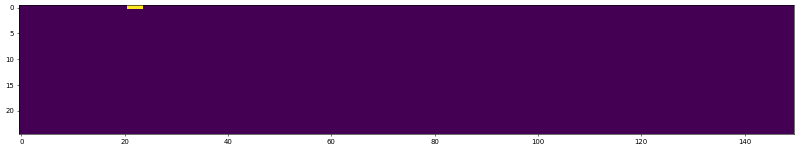

[1081] {(149, 7)}


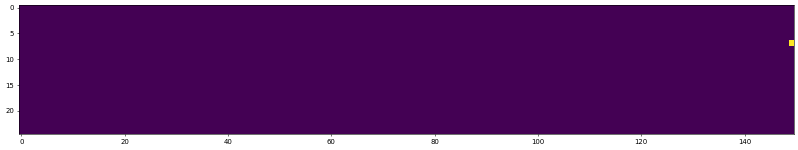

[1087, 1088] {(106, 24), (105, 24)}


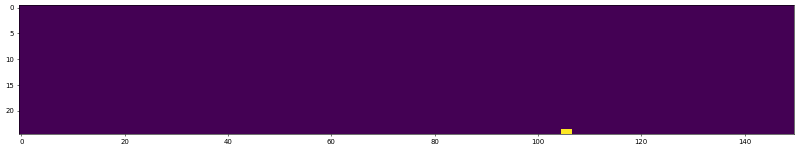

[1097] {(49, 13), (48, 13), (72, 9)}


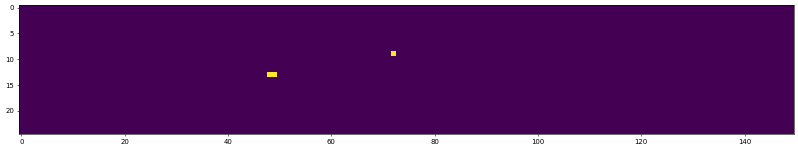

[1168, 1169, 1170] {(146, 19), (147, 19), (145, 19)}


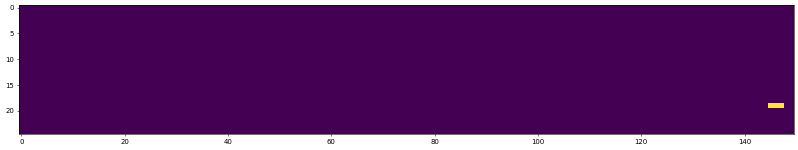

[1178, 1180] {(109, 23), (149, 5)}


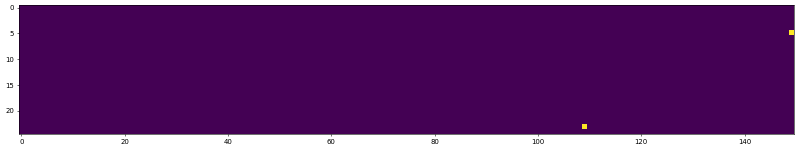

116 116 116
Liver_map_150z25_60s_#6.npy
[22] {(91, 6)}


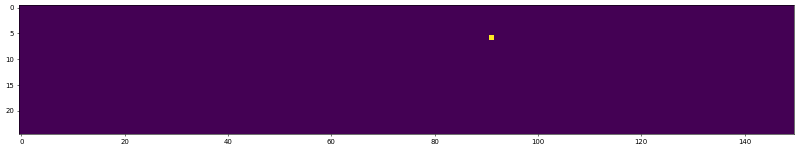

[74] {(97, 22)}


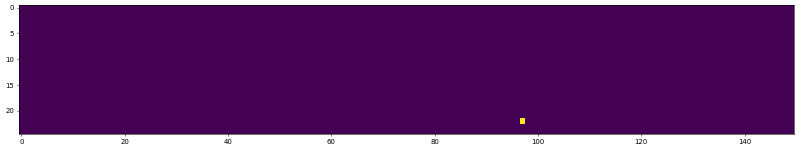

[154] {(83, 2)}


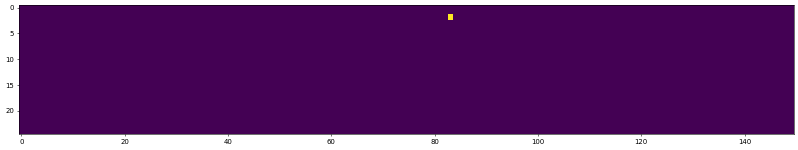

[187] {(103, 21)}


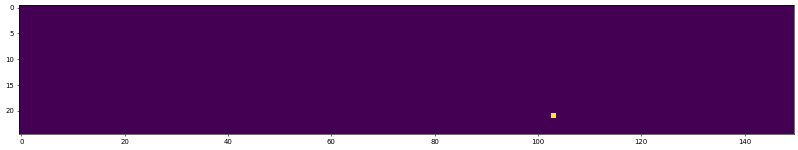

[246] {(103, 21)}


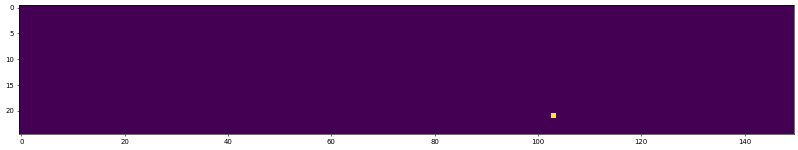

[252, 255, 256, 258, 259] {(103, 21), (106, 5), (119, 7), (118, 7)}


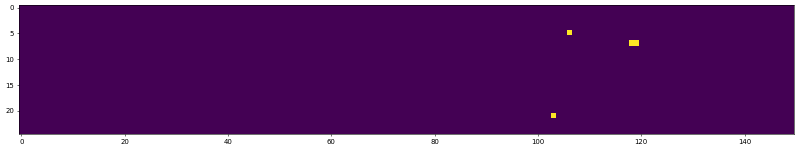

[306] {(139, 0)}


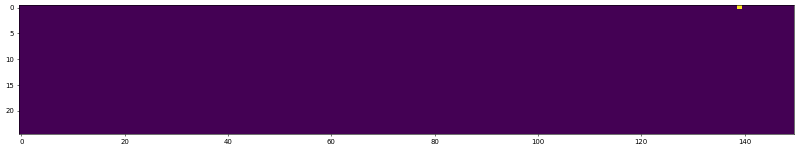

[343] {(104, 20)}


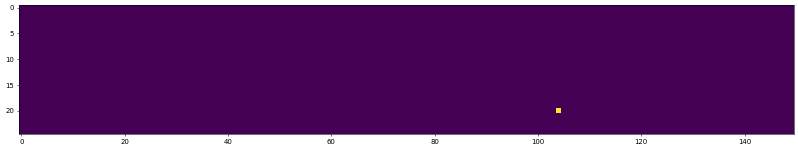

[392] {(140, 1)}


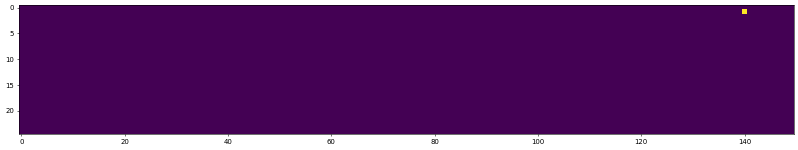

[440] {(104, 21)}


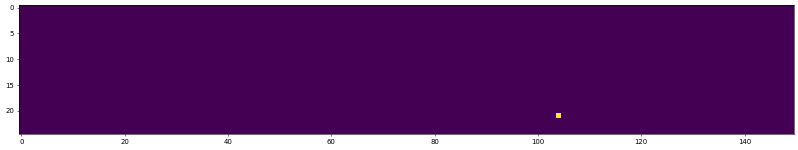

[483] {(48, 13)}


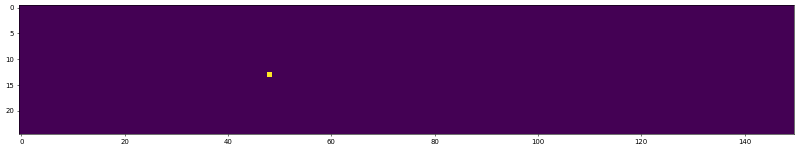

[503] {(56, 13)}


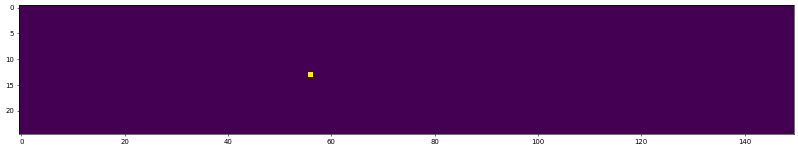

[509] {(58, 13)}


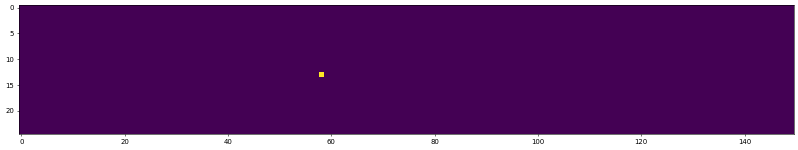

[517] {(62, 13)}


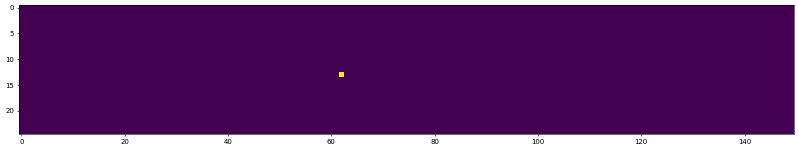

[598] {(97, 13)}


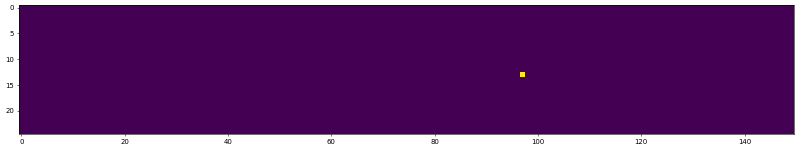

[602] {(99, 13)}


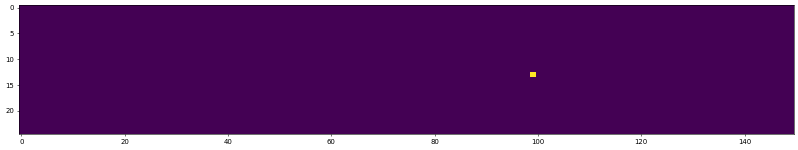

[608] {(102, 13)}


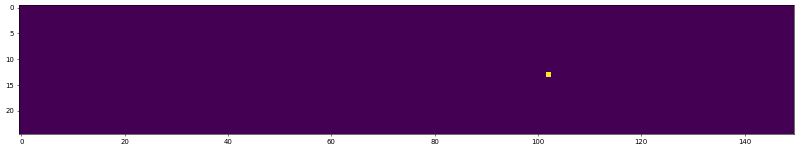

[616] {(106, 13), (103, 21)}


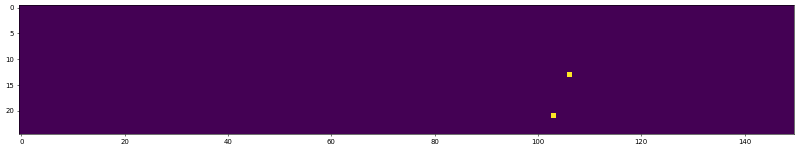

[622] {(103, 21)}


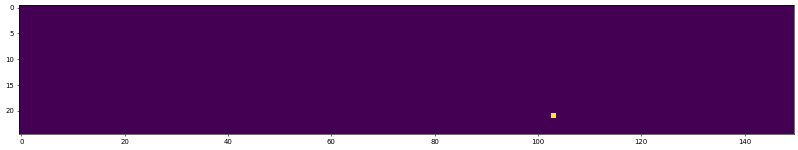

[658, 661] {(125, 13), (124, 13)}


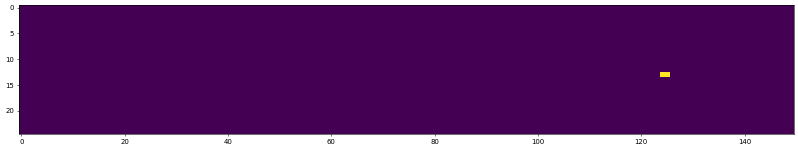

[790, 791] {(130, 19), (131, 19)}


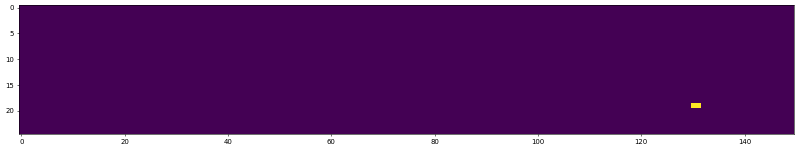

[844] {(131, 18), (132, 18)}


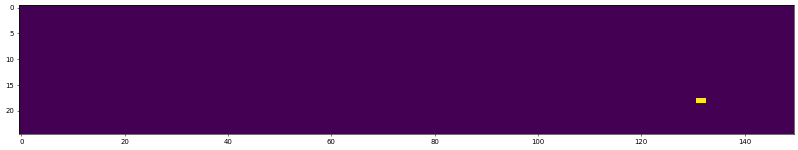

[864, 865] {(96, 11), (132, 6), (95, 11), (133, 6)}


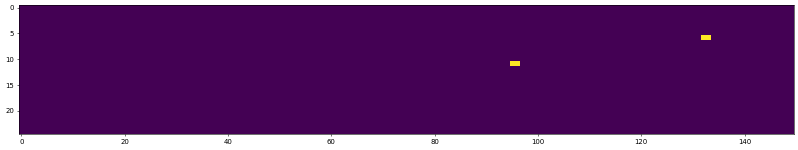

[1057] {(65, 8)}


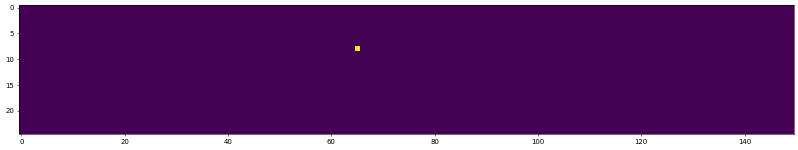

[1073] {(40, 17)}


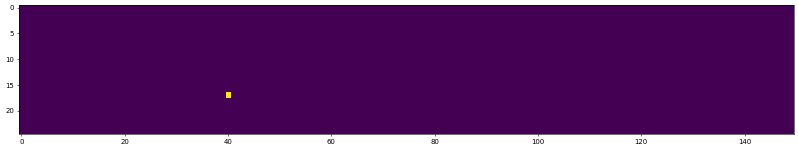

[1088] {(92, 1), (93, 1), (104, 21)}


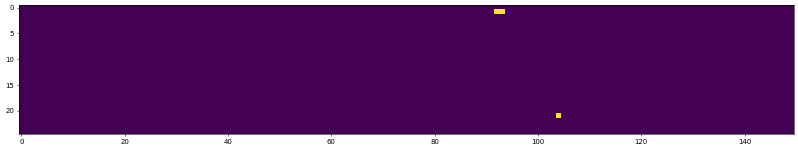

[1102] {(57, 14)}


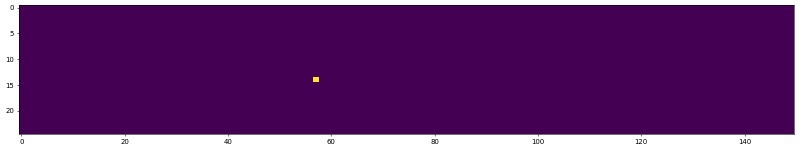

[1240] {(61, 19)}


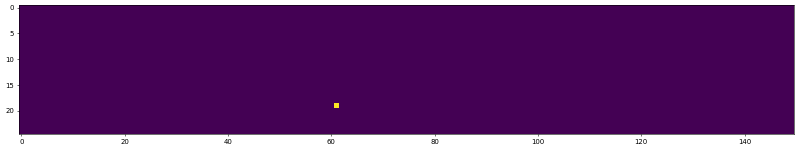

36 36 36
Kidney_map_150z25_60s_#37.npy
[46] {(86, 3)}


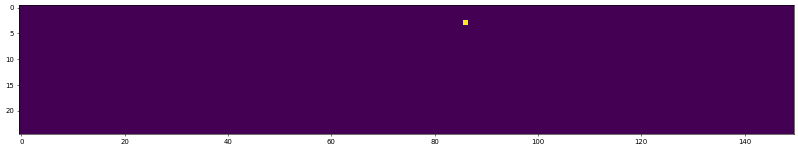

[75, 76, 77, 78] {(91, 5), (93, 5), (92, 5), (88, 5), (89, 5), (90, 5)}


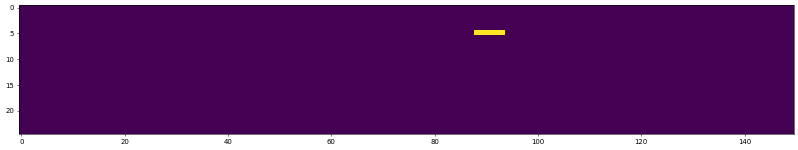

[94, 95] {(31, 23), (29, 23), (30, 23)}


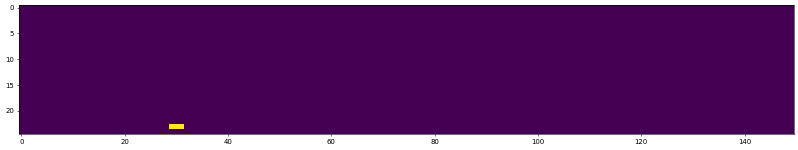

[131] {(82, 2)}


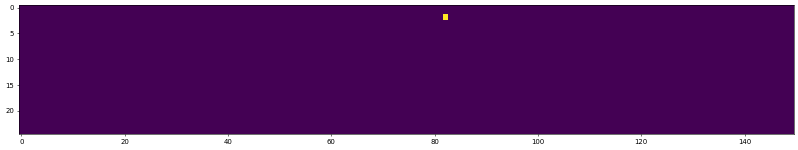

[155] {(67, 23), (68, 23)}


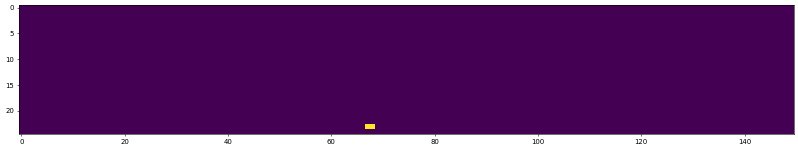

[159] {(66, 23)}


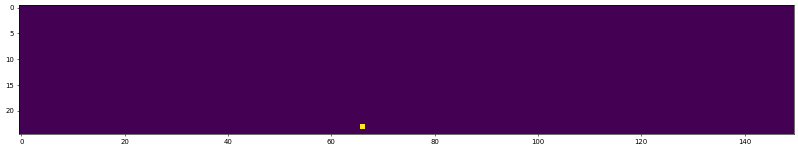

[164] {(67, 23), (68, 23)}


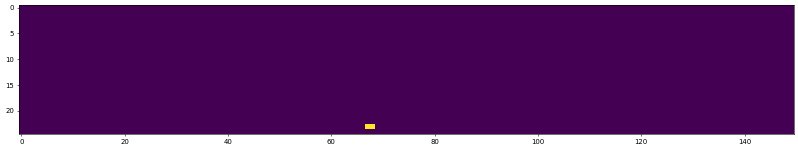

[243, 244] {(97, 0), (98, 0)}


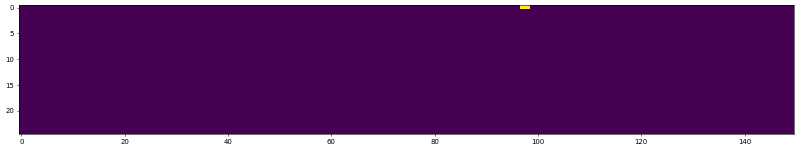

[249, 250, 253, 256] {(131, 18), (78, 9), (79, 9), (80, 9), (77, 9)}


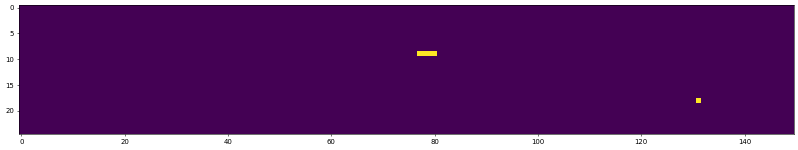

[271] {(129, 22), (128, 22)}


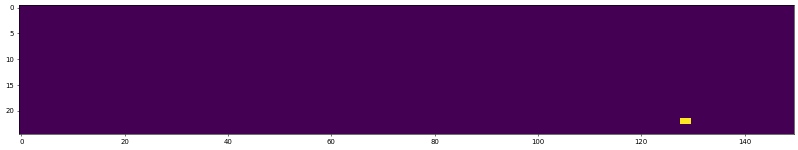

[321] {(30, 12)}


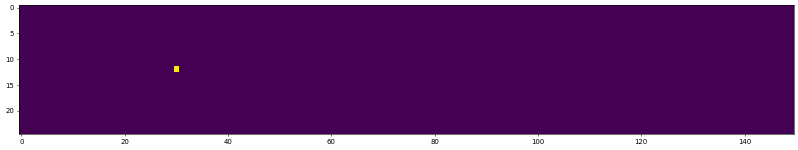

[327] {(114, 23)}


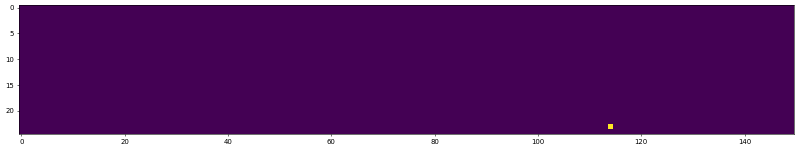

[431, 433] {(40, 21), (38, 21), (39, 21), (37, 21)}


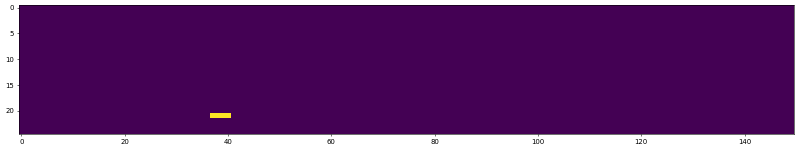

[441] {(145, 0)}


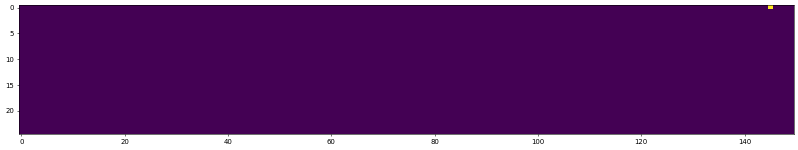

[449] {(63, 11)}


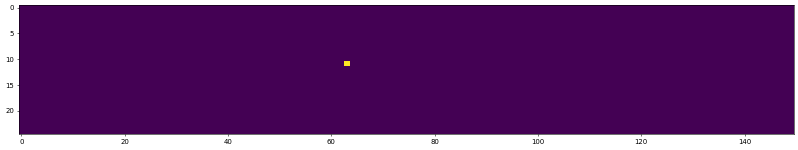

[453, 455] {(52, 8), (81, 5), (53, 8), (64, 11)}


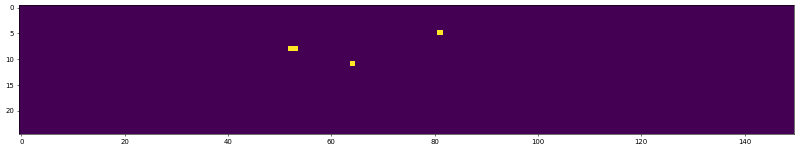

[459] {(65, 11)}


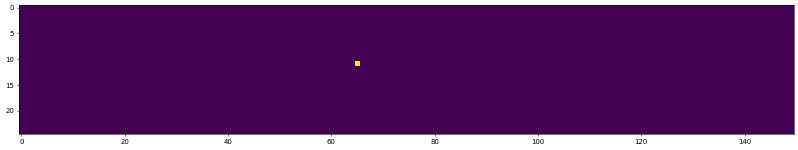

[486, 487] {(0, 7), (1, 7)}


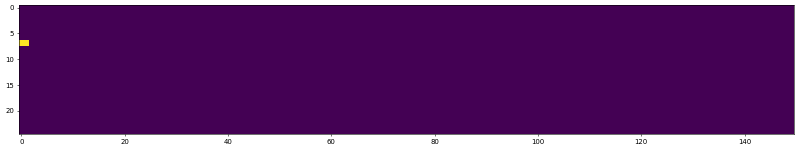

[491] {(72, 6), (73, 6)}


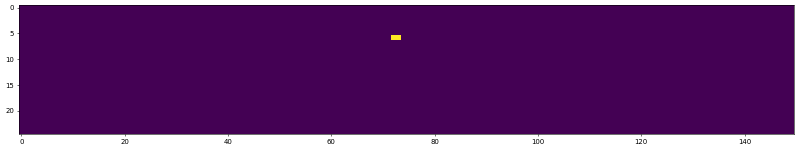

[495, 498] {(9, 16), (8, 16)}


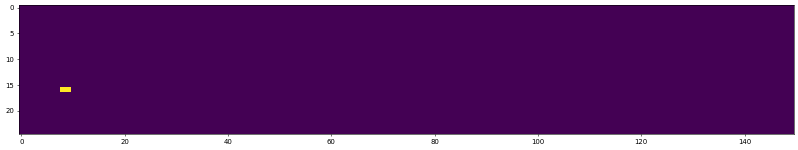

[532] {(69, 9)}


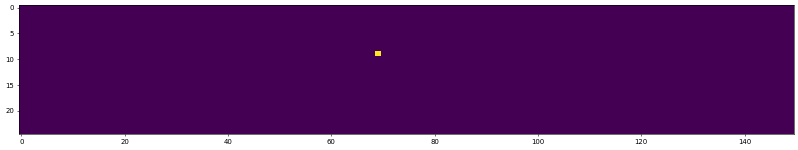

[586] {(23, 10), (24, 10)}


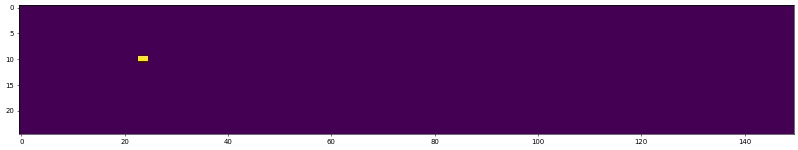

[619, 621, 622] {(48, 21), (46, 21), (47, 21)}


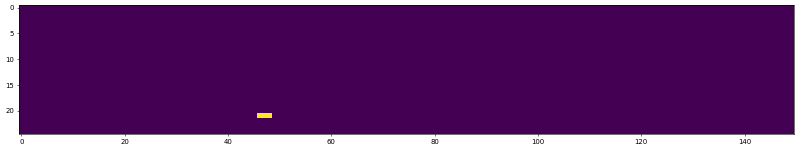

[687, 688] {(39, 1), (40, 1)}


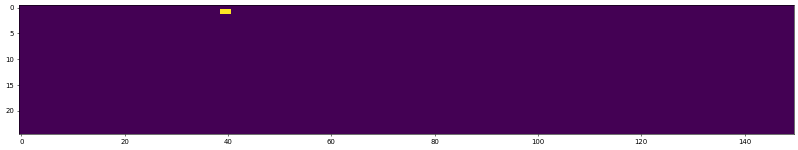

[702] {(15, 1)}


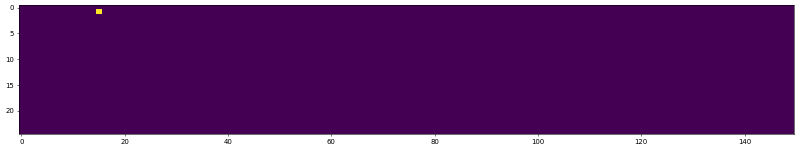

[712] {(84, 9), (85, 9)}


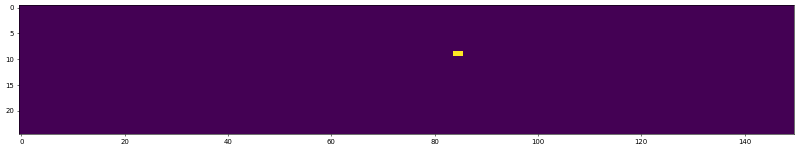

[719] {(149, 8), (148, 8)}


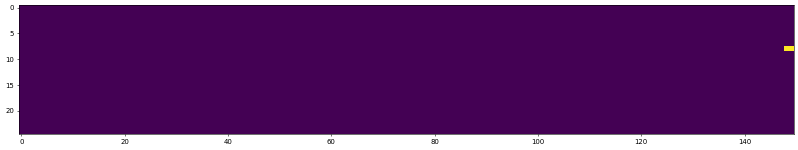

[725, 726] {(140, 15), (141, 15)}


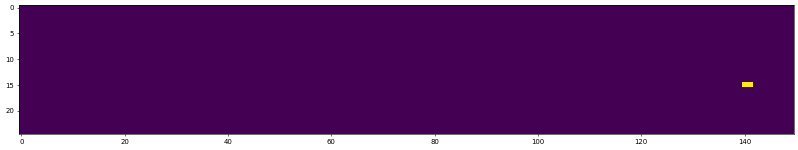

[780] {(123, 11), (36, 8)}


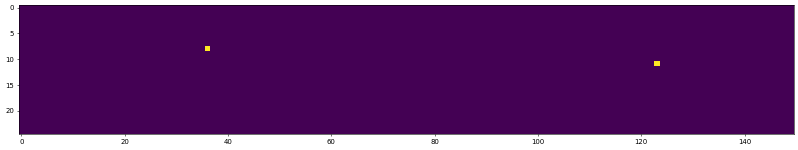

[797] {(141, 18)}


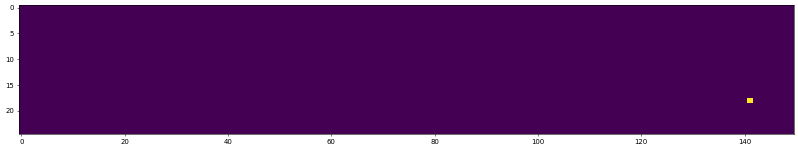

[832, 833, 834] {(2, 20), (3, 20), (33, 20)}


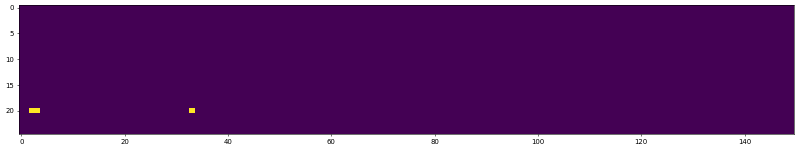

[838, 840] {(67, 20), (6, 20), (66, 20)}


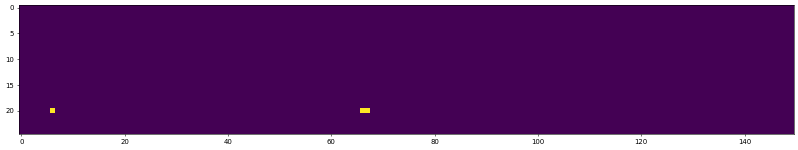

[858, 861, 863, 864, 866, 867] {(70, 20), (67, 20), (68, 20), (71, 20), (66, 20), (69, 20), (90, 17), (91, 17), (72, 20)}


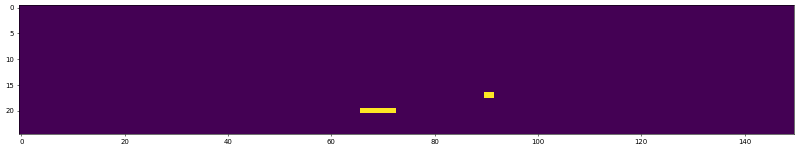

[888] {(90, 10)}


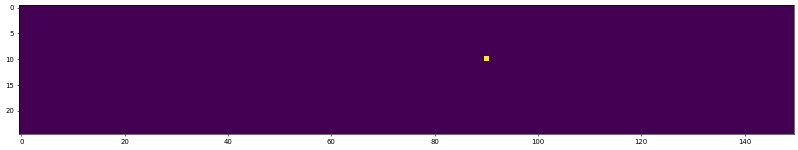

[901, 902] {(63, 14), (64, 14)}


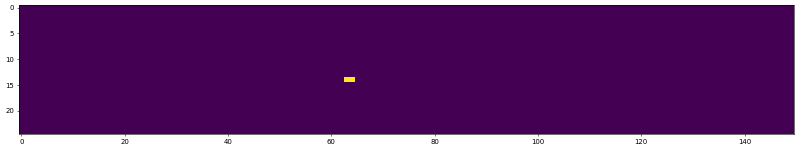

[919] {(41, 1), (42, 1), (40, 1)}


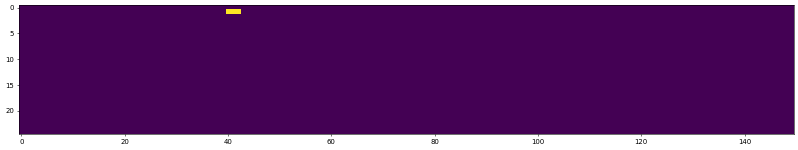

[925, 927] {(105, 15), (88, 11), (104, 15)}


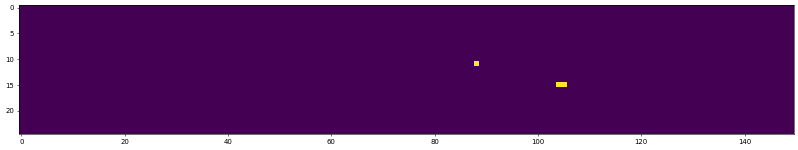

[956] {(124, 21), (125, 21), (123, 21)}


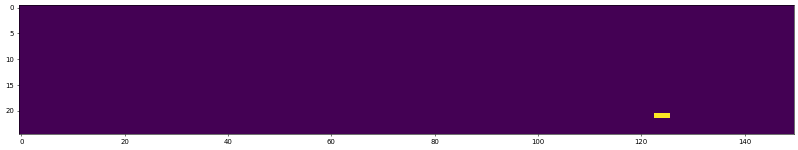

[972] {(28, 17), (23, 17), (24, 17), (26, 17), (27, 17), (22, 17), (25, 17)}


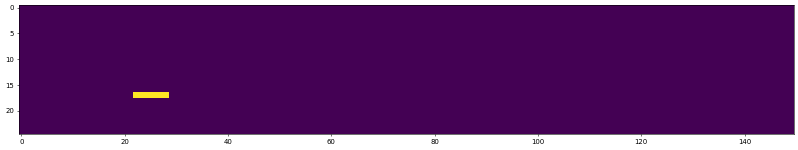

[992, 993, 994] {(53, 10), (54, 10), (55, 10)}


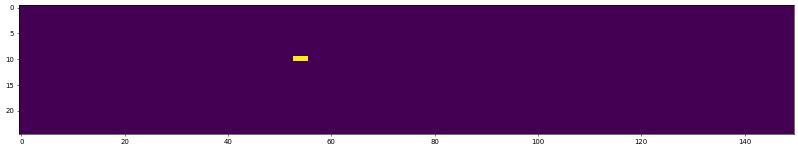

[1035, 1036, 1039] {(82, 13), (83, 13), (81, 13)}


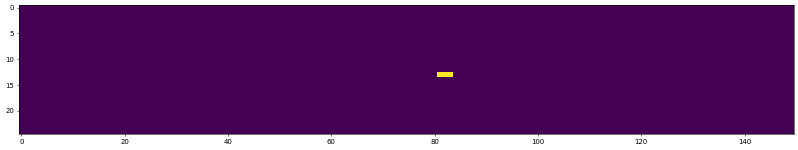

[1045, 1046, 1048, 1051] {(91, 11), (138, 22), (139, 22), (140, 22), (92, 11), (90, 11)}


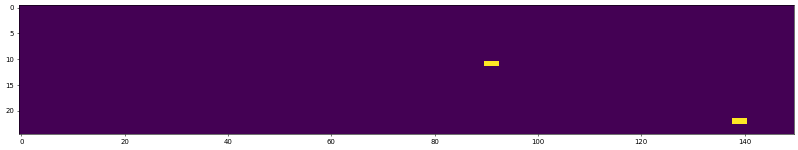

[1062] {(80, 11)}


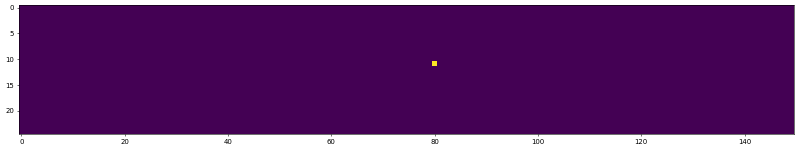

[1067] {(115, 7), (114, 7)}


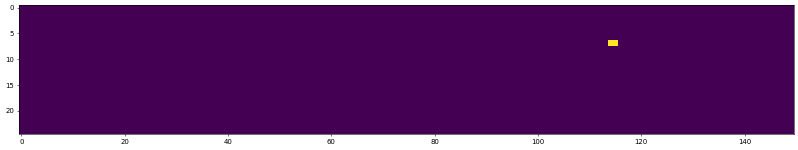

[1148, 1149, 1150, 1151, 1153] {(129, 11), (131, 11), (134, 11), (130, 11), (132, 11), (133, 11), (128, 11)}


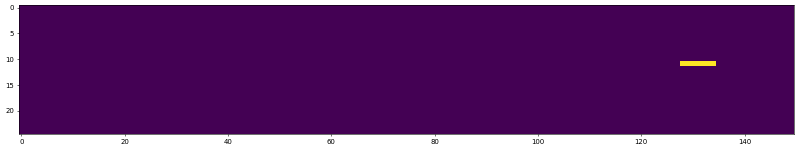

[1216] {(53, 4)}


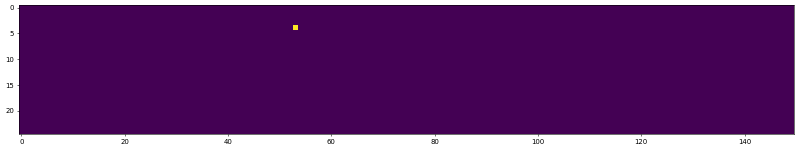

[1238, 1239] {(107, 11), (103, 11), (108, 11), (104, 11), (105, 11), (106, 11)}


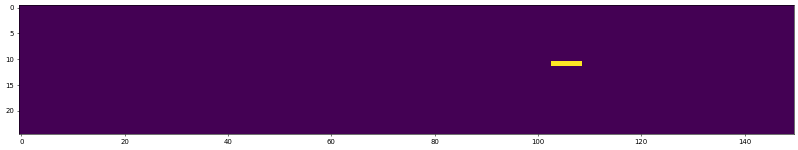

[1250, 1251] {(50, 23), (51, 23)}


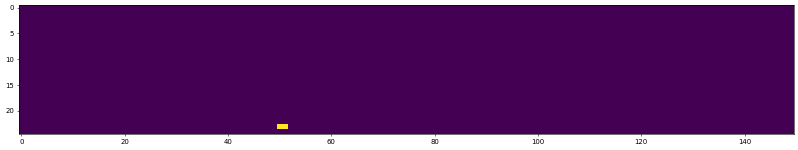

123 123 123
Muscle_map_150z25_60s_#22.npy
[33] {(79, 2)}


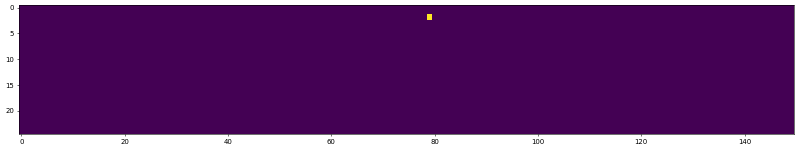

[44, 46, 47] {(111, 13), (112, 13), (109, 13), (110, 13)}


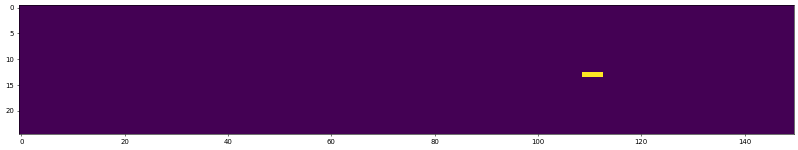

[65] {(78, 6)}


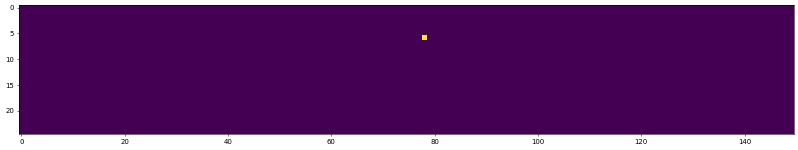

[142, 143, 145, 147] {(24, 4), (26, 4), (99, 8), (100, 8), (25, 4)}


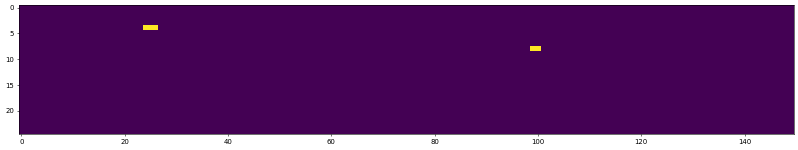

[203] {(33, 1)}


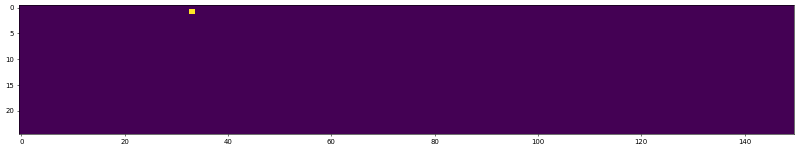

[255] {(57, 24)}


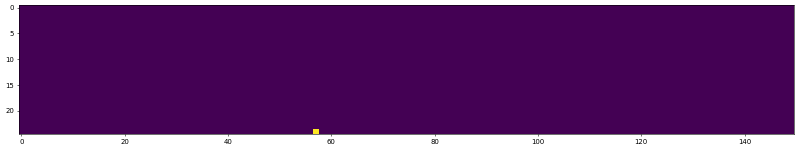

[259] {(45, 7)}


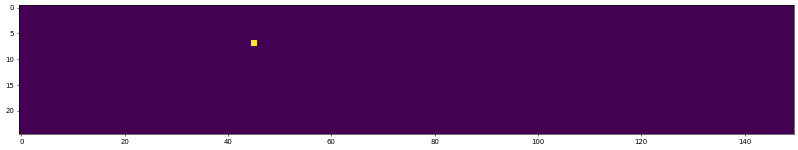

[294, 295, 296] {(33, 0), (29, 0), (30, 0), (31, 0), (32, 0)}


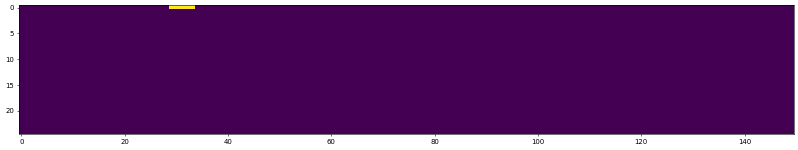

[346] {(149, 18)}


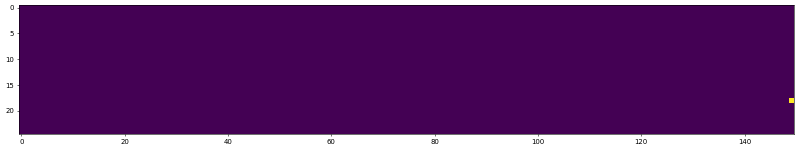

[385, 386] {(94, 17), (98, 22), (95, 17)}


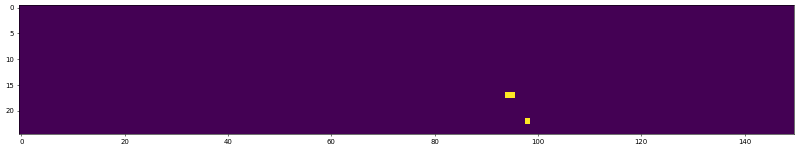

[394] {(12, 15)}


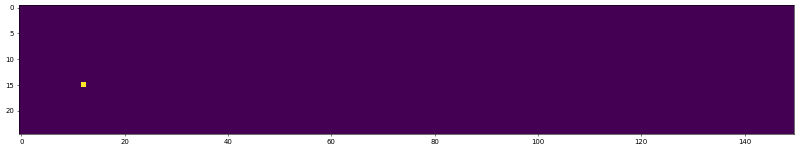

[398] {(119, 19)}


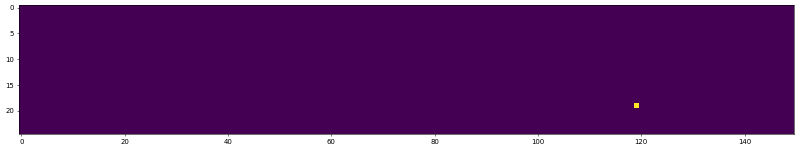

[413] {(129, 18)}


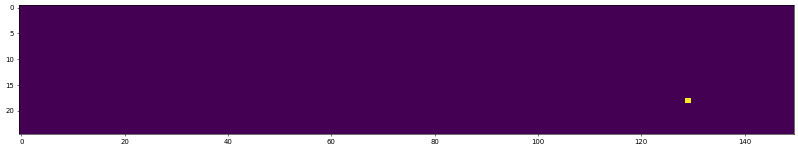

[423] {(81, 4)}


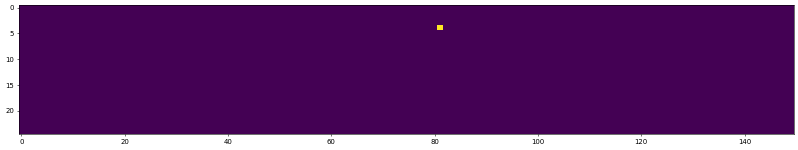

[433] {(6, 4)}


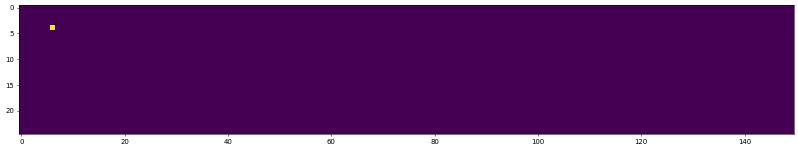

[453, 456, 458] {(104, 12), (105, 12), (106, 12)}


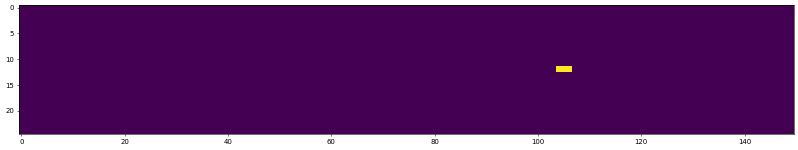

[493, 494] {(144, 10), (119, 7)}


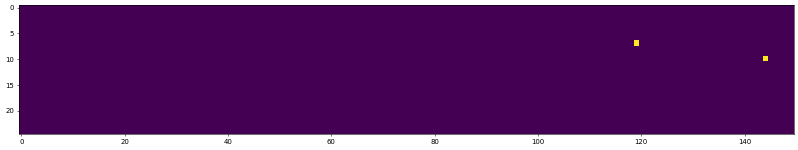

[584] {(129, 22), (128, 22)}


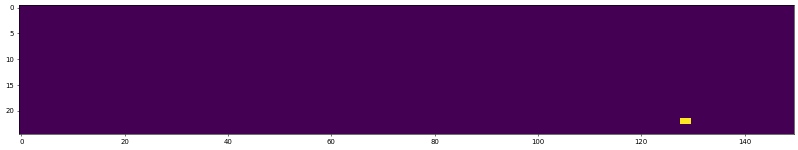

[602] {(133, 2), (134, 2), (135, 2)}


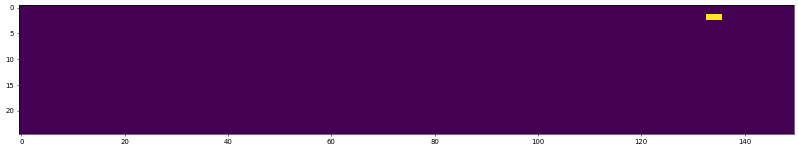

[607] {(118, 2)}


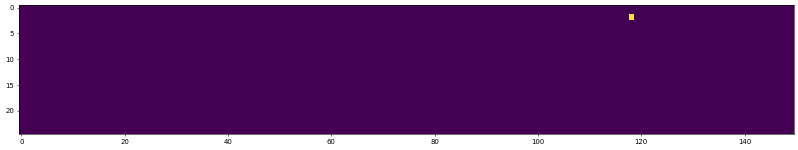

[627] {(140, 9)}


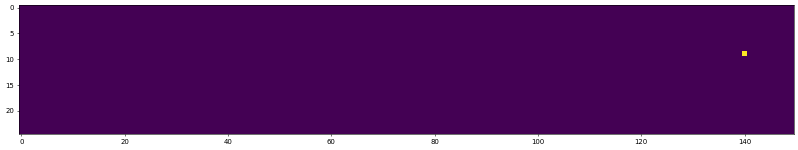

[648] {(65, 2), (139, 10)}


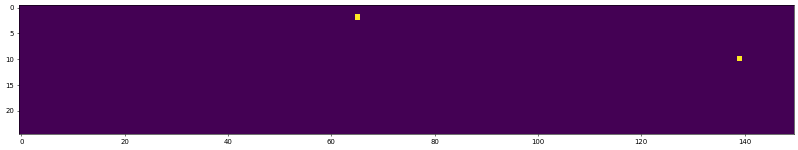

[654] {(138, 3), (139, 3)}


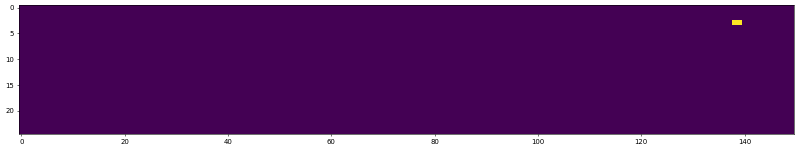

[719, 721] {(83, 4), (84, 4)}


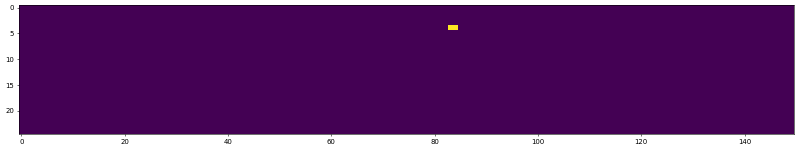

[747, 748] {(11, 1), (12, 1), (13, 1)}


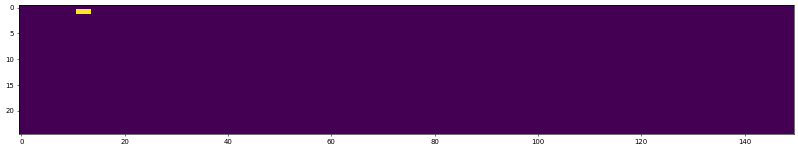

[756, 759, 760] {(142, 9), (141, 9), (144, 9), (145, 9)}


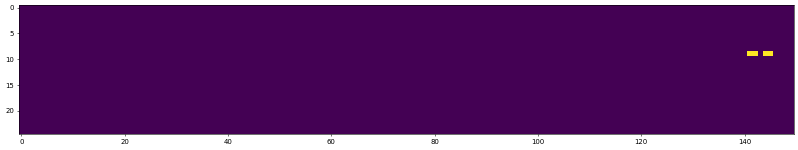

[796] {(120, 8), (121, 8)}


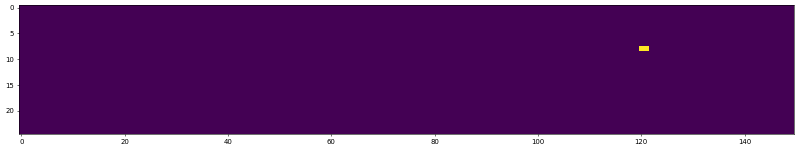

[800] {(89, 11), (90, 11)}


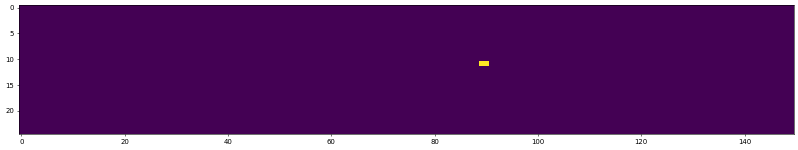

[814] {(132, 13)}


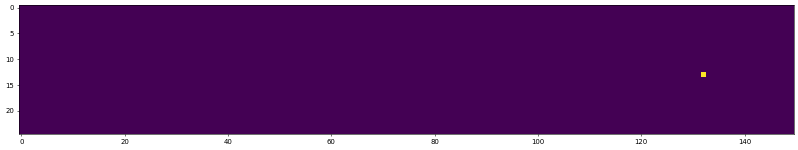

[818] {(133, 13)}


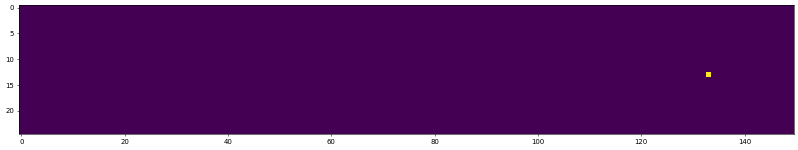

[824, 825, 826] {(15, 21), (85, 11), (86, 11), (84, 11)}


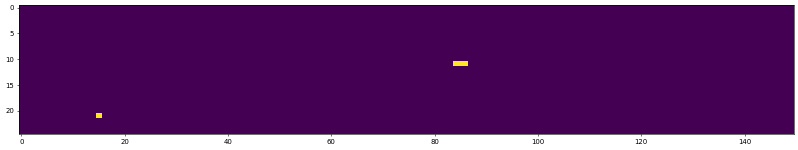

[837] {(30, 3), (31, 3)}


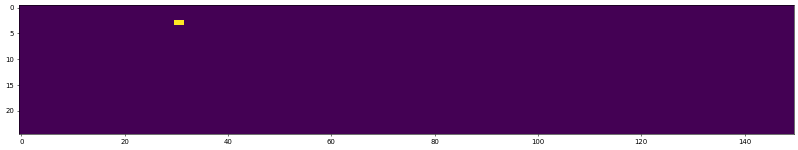

[848] {(84, 1), (82, 1), (83, 1)}


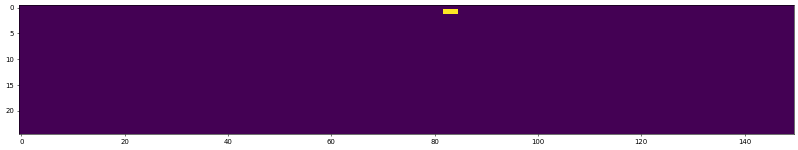

[860] {(57, 22)}


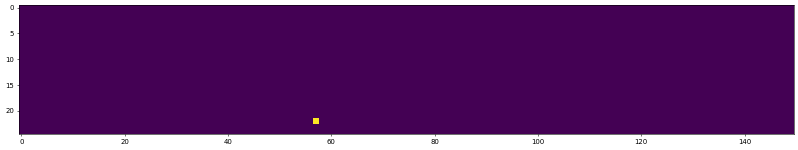

[869, 871, 872] {(66, 12), (67, 12), (65, 12)}


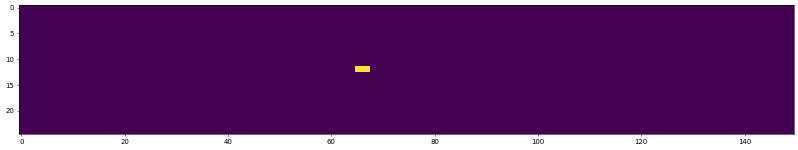

[919] {(67, 10), (66, 10)}


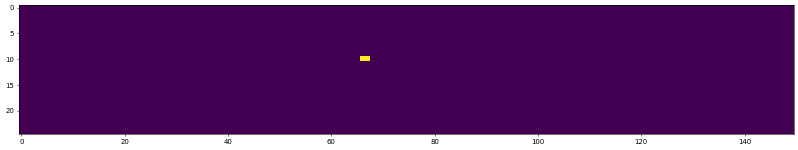

[932] {(17, 9)}


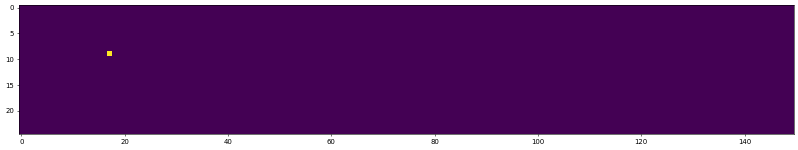

[937, 939, 941, 944, 945, 946] {(64, 4), (65, 4), (63, 4), (7, 5), (8, 5), (66, 4)}


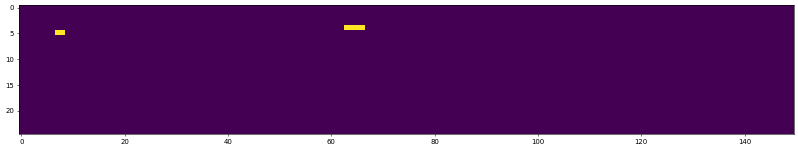

[954] {(30, 6)}


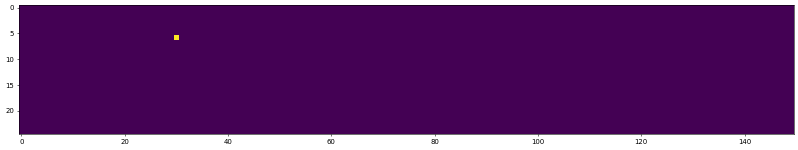

[976, 977] {(93, 17), (94, 17), (95, 17)}


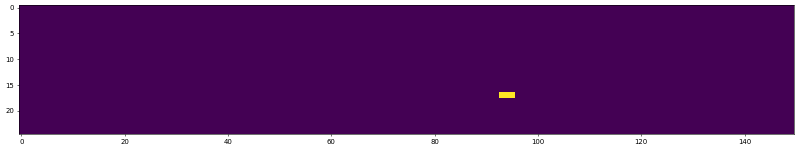

[1010, 1011] {(149, 13), (94, 8)}


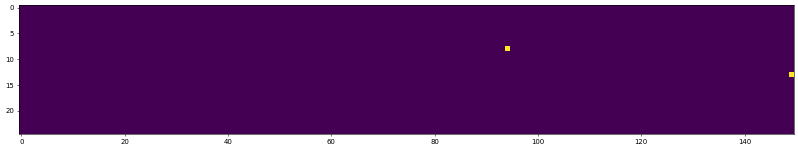

[1023, 1025, 1027] {(118, 10), (119, 10), (120, 10)}


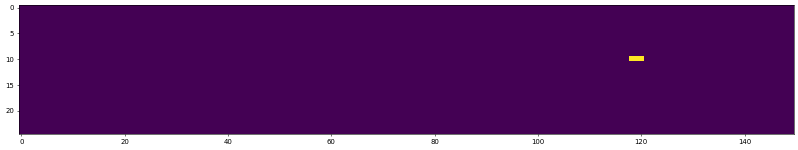

[1035, 1036] {(5, 4), (6, 4)}


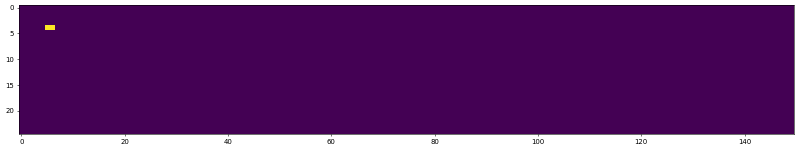

[1052] {(46, 2)}


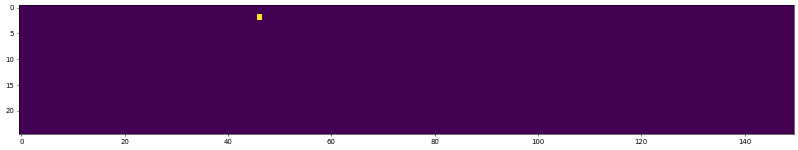

[1058, 1061, 1063, 1066] {(148, 10), (21, 14), (22, 14), (20, 14)}


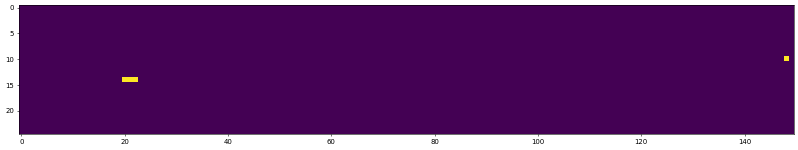

[1070, 1071, 1072, 1073] {(134, 3), (137, 3), (138, 3), (133, 3), (139, 3), (135, 3), (136, 3)}


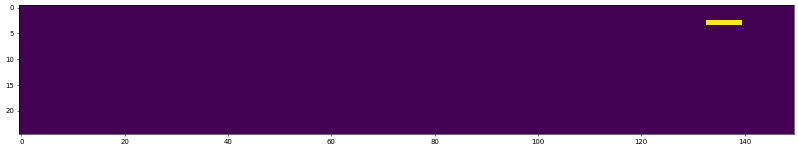

[1085] {(124, 3), (123, 3)}


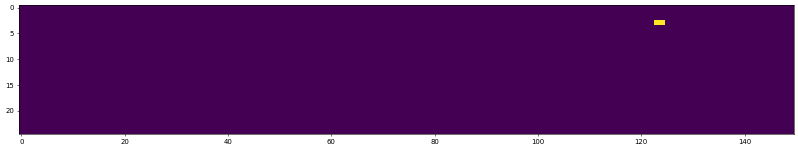

[1106, 1107, 1108, 1109] {(99, 4), (105, 4), (100, 4), (101, 4), (102, 4), (103, 4), (98, 4), (104, 4)}


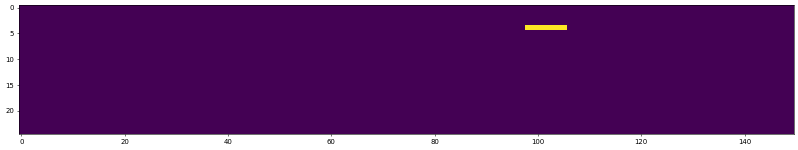

[1119] {(131, 16)}


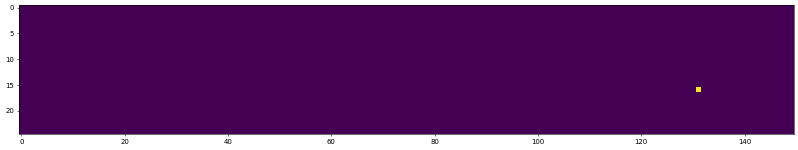

[1204, 1205, 1206] {(24, 20), (25, 20), (23, 20)}


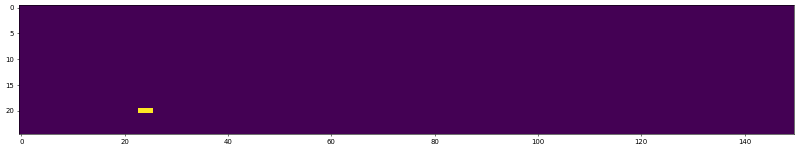

[1222] {(131, 10)}


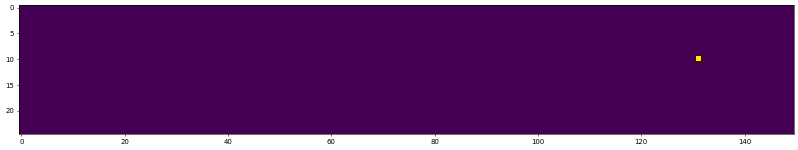

116 116 116
Muscle_map_150z25_60s_#24.npy
[9, 10, 12, 13] {(114, 6), (115, 6), (115, 24), (116, 24)}


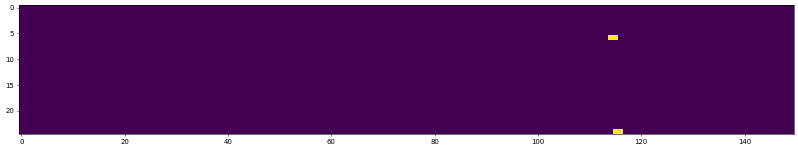

[56] {(21, 10)}


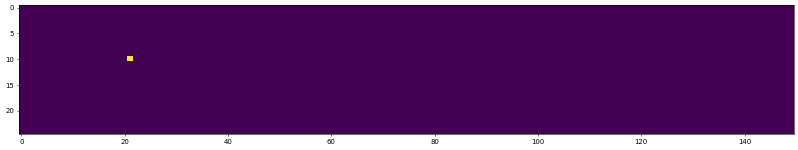

[60, 61] {(7, 1), (8, 1)}


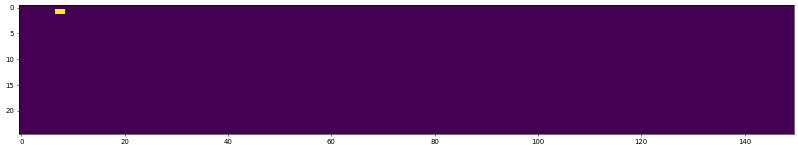

[91, 92] {(121, 22), (120, 22)}


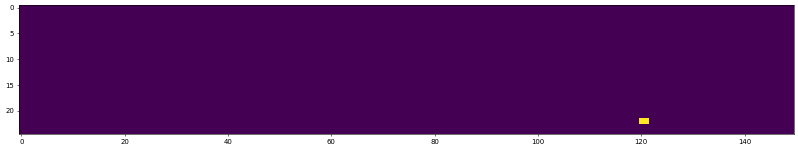

[97] {(146, 11)}


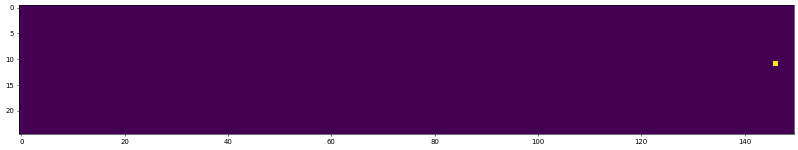

[106, 107, 108] {(70, 8), (68, 8), (71, 8), (69, 8), (67, 8)}


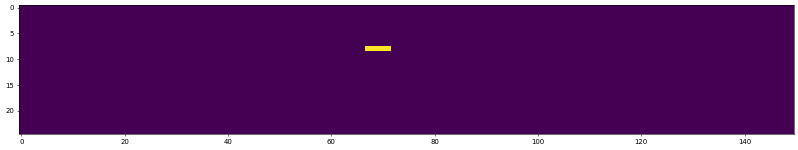

[149, 151, 152] {(85, 23), (37, 21), (38, 21), (84, 23)}


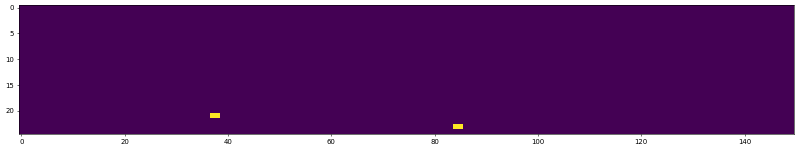

[156, 158, 160, 161] {(145, 11), (140, 11), (141, 11), (136, 11), (143, 11), (125, 19), (123, 19), (124, 19), (142, 11), (137, 11), (138, 11), (144, 11), (139, 11)}


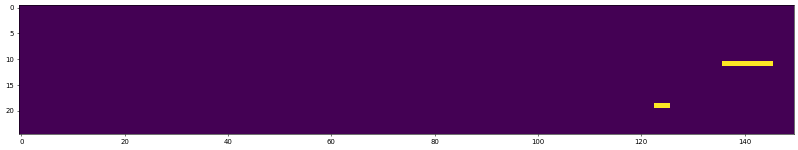

[186, 188, 190, 192] {(86, 20), (139, 18), (87, 20), (88, 20)}


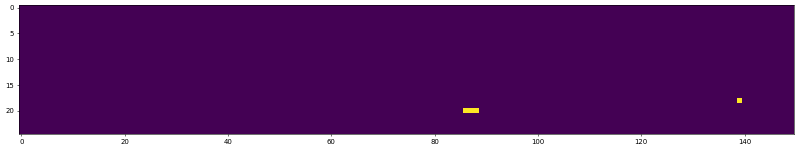

[256] {(113, 10)}


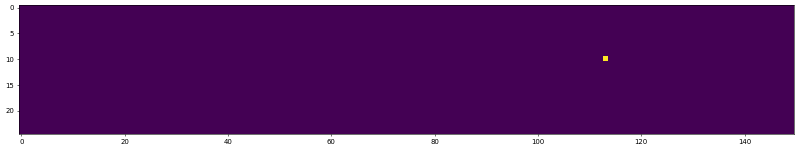

[363, 364] {(146, 23), (147, 23)}


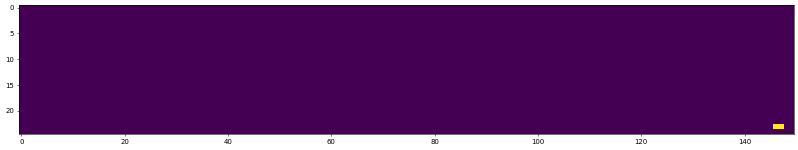

[371, 372] {(144, 1), (143, 1)}


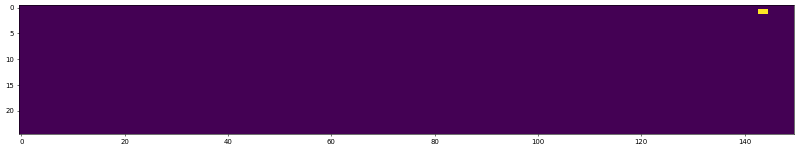

[446] {(109, 4), (110, 4)}


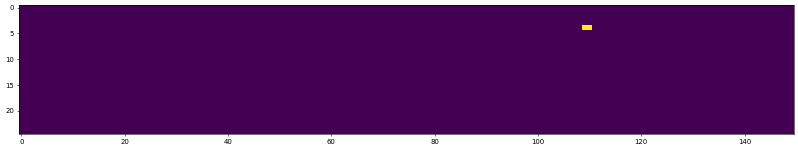

[468, 469, 471, 472, 473, 475, 476, 478, 479] {(84, 1), (69, 11), (85, 1), (64, 11), (65, 11), (12, 3), (13, 3), (120, 8), (70, 11), (71, 11), (66, 11), (67, 11), (68, 11)}


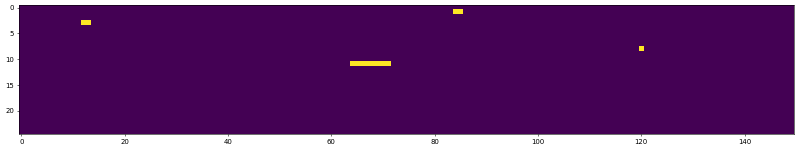

[484] {(135, 0)}


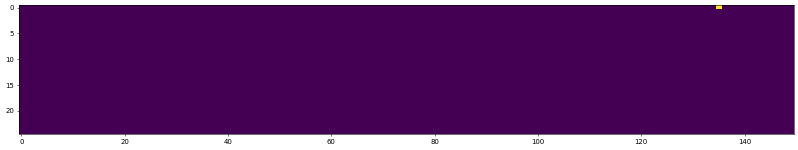

[491, 492] {(120, 12), (119, 12)}


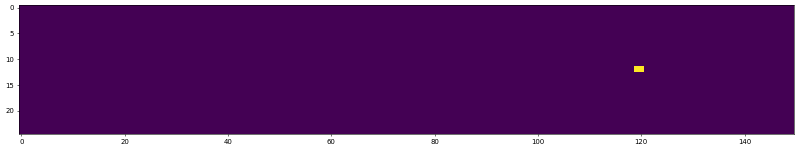

[499] {(76, 1)}


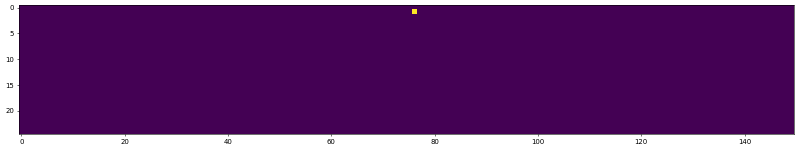

[563, 564] {(127, 8), (126, 8)}


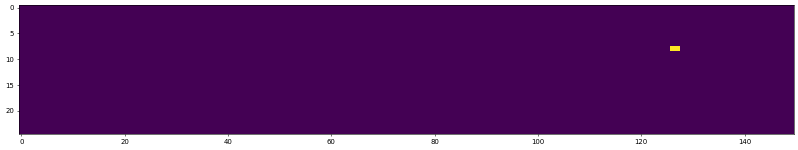

[572] {(3, 19)}


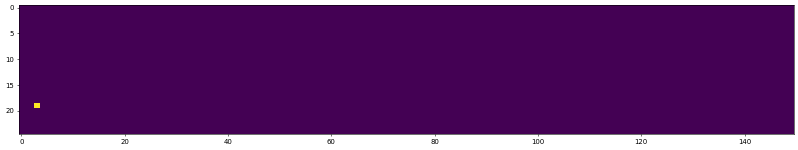

[583, 584, 585, 586, 587] {(126, 8), (126, 21), (50, 20), (3, 19), (127, 8), (127, 21), (128, 21)}


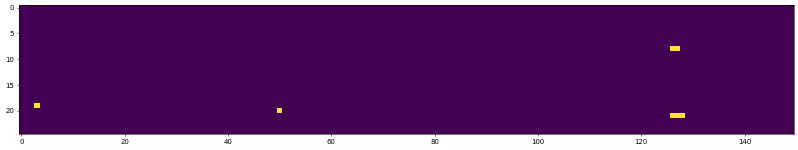

[619, 620, 621] {(68, 24), (9, 11), (69, 24), (70, 24)}


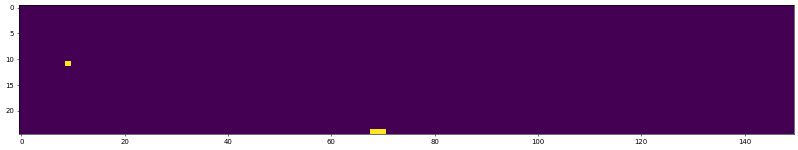

[626] {(67, 24)}


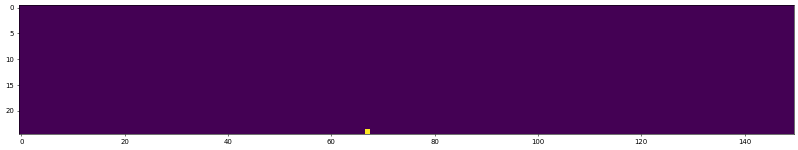

[711, 712, 713, 714, 716, 717, 719] {(138, 20), (139, 20), (59, 19), (57, 19), (58, 19), (44, 15), (137, 20)}


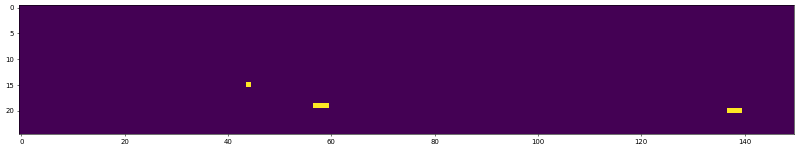

[791, 793] {(137, 10), (136, 10)}


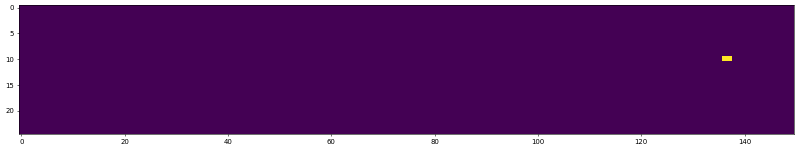

[844, 845] {(124, 20), (123, 20)}


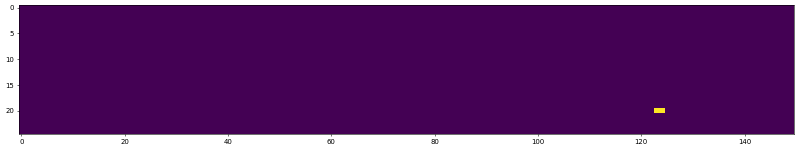

[871, 874] {(123, 6), (124, 6)}


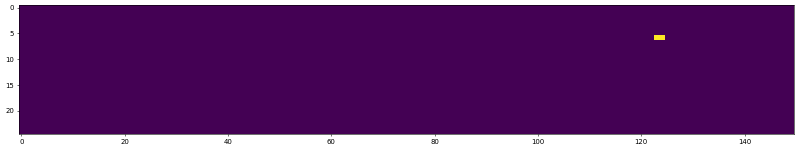

[890] {(134, 4)}


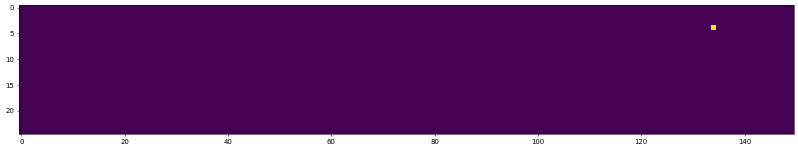

[949] {(57, 14)}


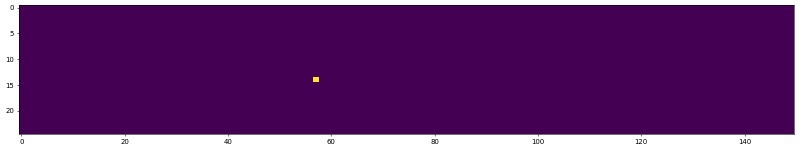

[976] {(32, 3), (31, 3)}


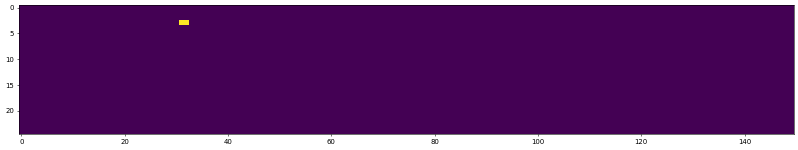

[996] {(148, 4)}


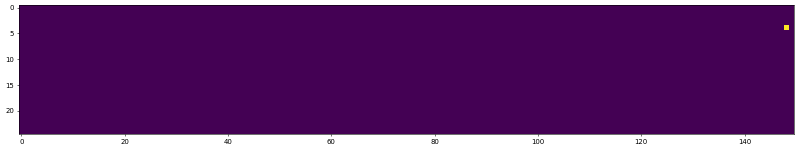

[1013] {(67, 9), (66, 9)}


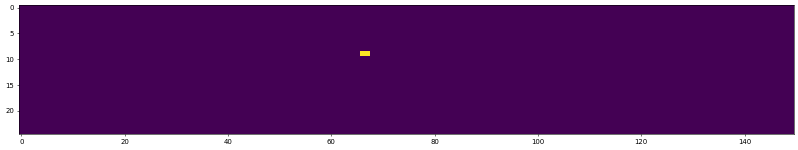

[1040, 1041] {(115, 17), (114, 17)}


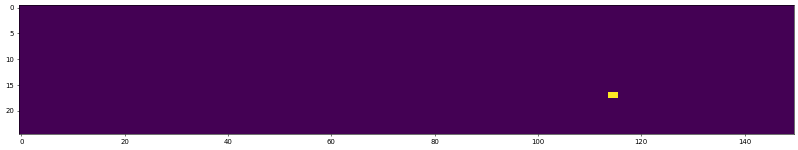

[1080, 1081, 1082, 1084] {(86, 20), (134, 17), (135, 17), (85, 20)}


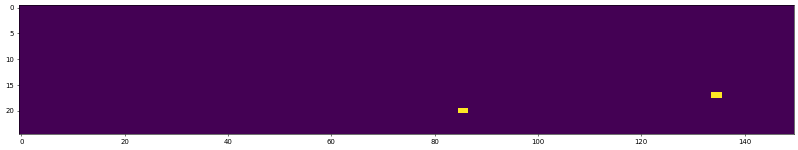

[1101, 1103, 1106, 1109, 1112, 1115, 1117] {(88, 17), (94, 17), (89, 17), (90, 17), (93, 17), (91, 17), (92, 17)}


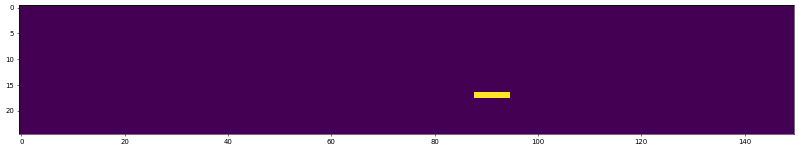

[1146, 1147, 1148] {(133, 13), (134, 13), (132, 13)}


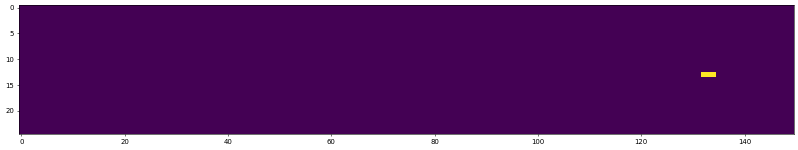

[1215, 1216] {(82, 12), (83, 12)}


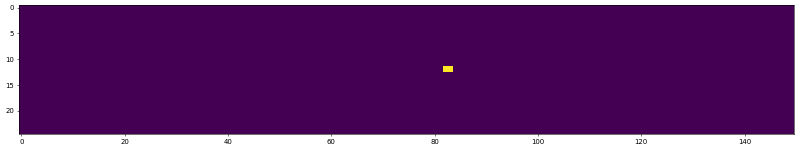

[1246] {(11, 24)}


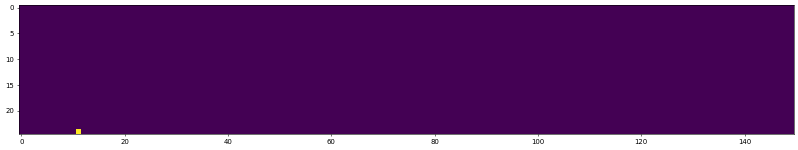

111 111 111
Muscle_map_150z25_60s_#28.npy
[54, 56] {(67, 3), (68, 3), (69, 3)}


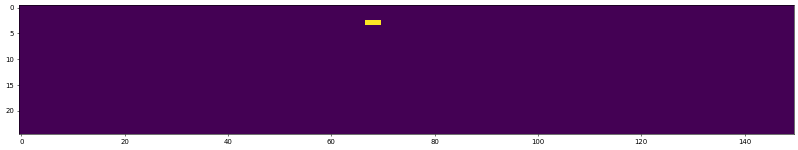

[93, 94, 96] {(84, 7), (85, 7), (86, 7)}


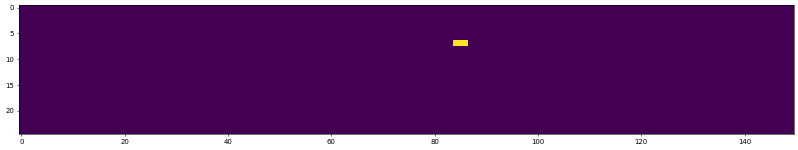

[102] {(104, 1), (103, 1)}


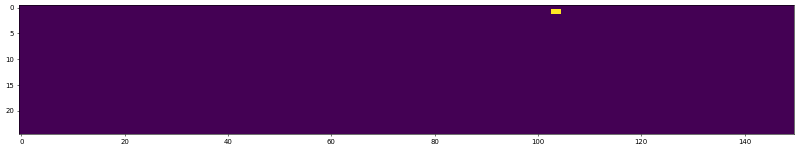

[110] {(100, 5)}


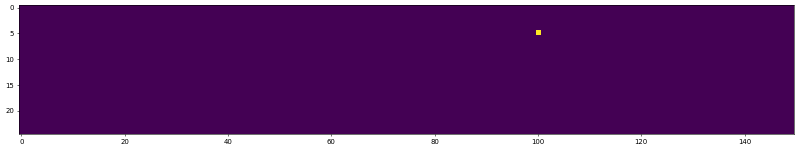

[157] {(128, 11)}


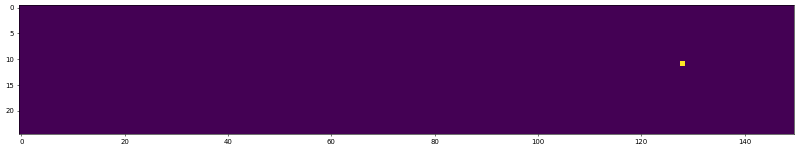

[277, 278, 279] {(133, 2), (131, 2), (132, 2)}


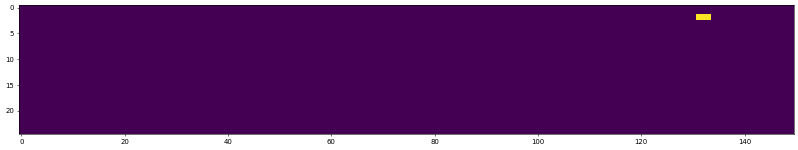

[286, 287] {(14, 12), (15, 12), (13, 12), (16, 12)}


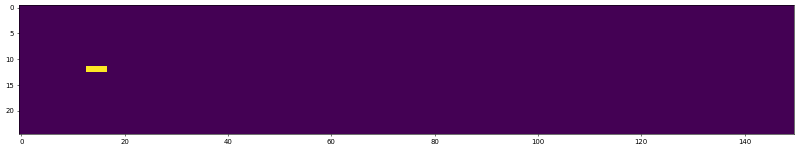

[347] {(130, 23)}


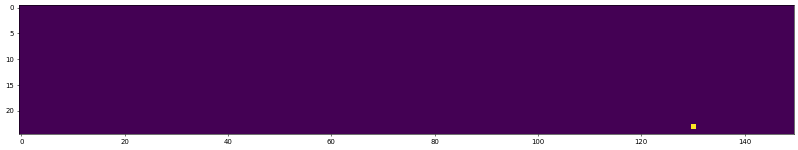

[381] {(20, 21)}


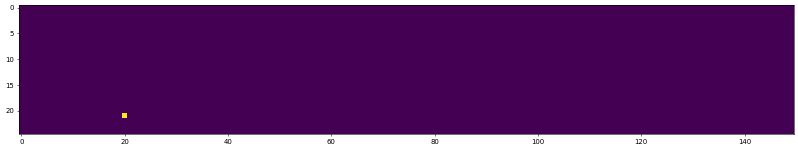

[395] {(56, 0)}


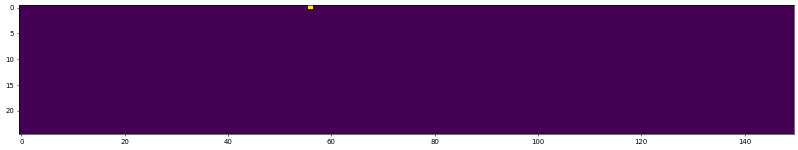

[403] {(100, 5)}


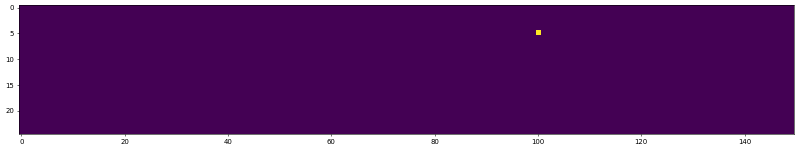

[407, 409, 410] {(9, 6), (7, 6), (97, 1), (8, 6)}


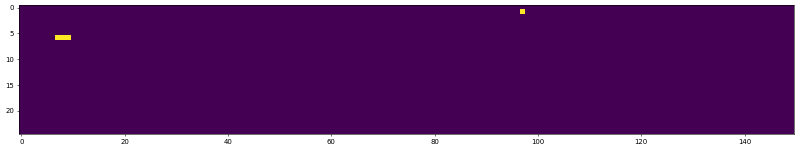

[419] {(100, 5)}


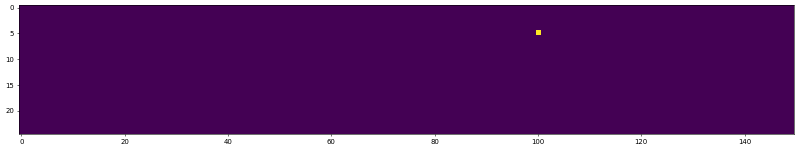

[428, 430] {(95, 19), (96, 19)}


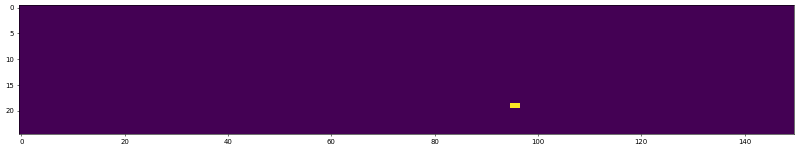

[434] {(140, 21)}


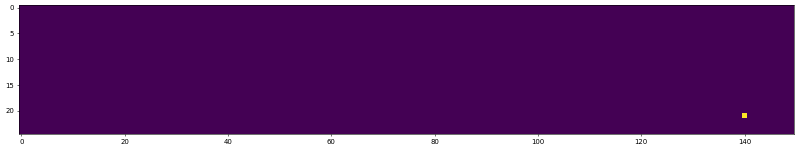

[442, 443, 444] {(99, 5), (106, 15), (117, 21), (107, 15)}


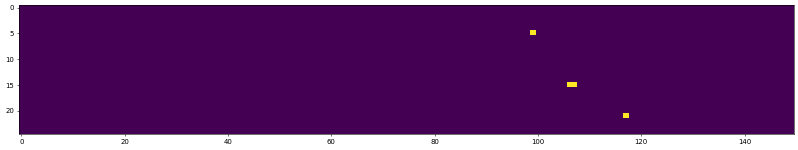

[496] {(79, 16)}


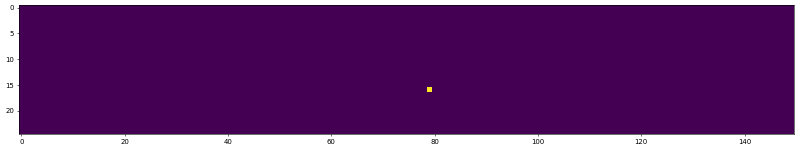

[516] {(55, 20)}


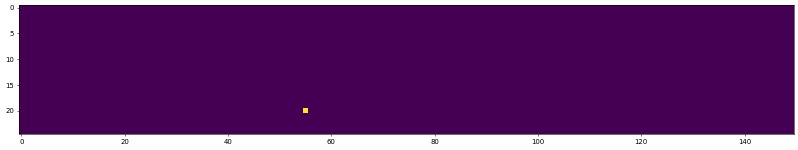

[520] {(54, 20)}


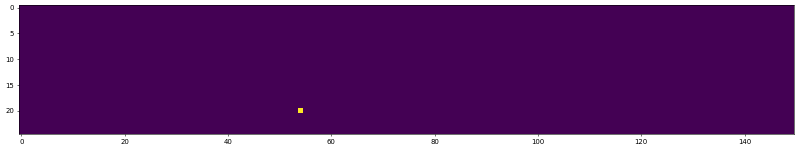

[528] {(119, 8)}


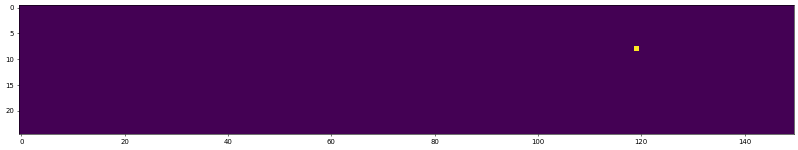

[534, 536] {(52, 20), (137, 2)}


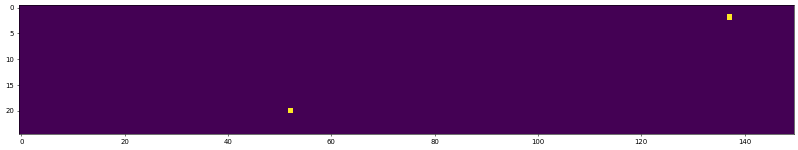

[545] {(99, 5), (50, 20)}


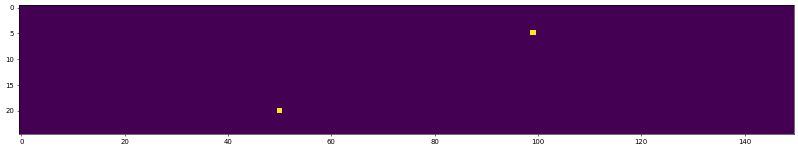

[549] {(99, 5)}


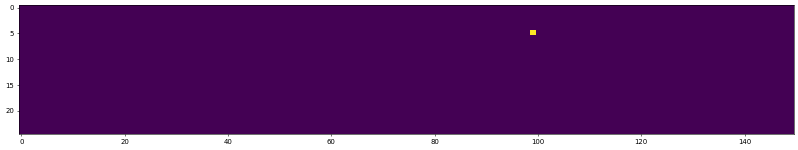

[553] {(99, 5), (49, 20)}


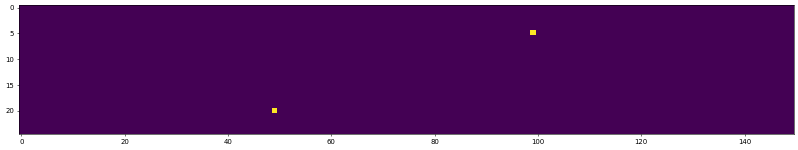

[558] {(48, 20)}


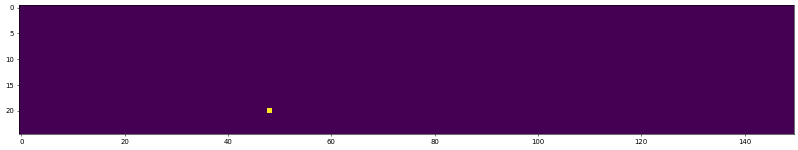

[566] {(48, 20), (49, 20), (47, 20)}


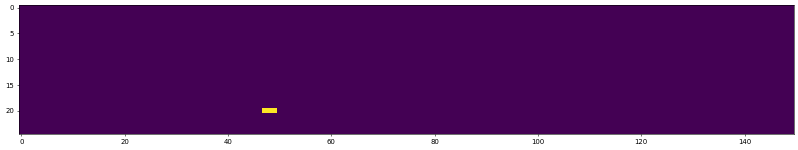

[571, 572] {(46, 20), (100, 5)}


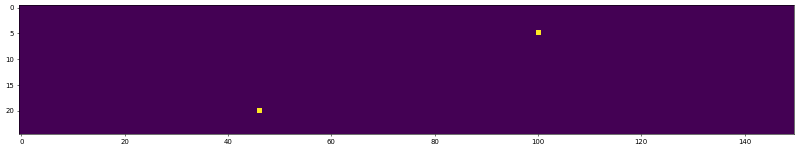

[576, 578, 579, 580, 583, 584] {(127, 14), (44, 20), (45, 20), (43, 20), (128, 7), (73, 16), (50, 3), (52, 3), (53, 3), (51, 3), (46, 15), (100, 5), (122, 16)}


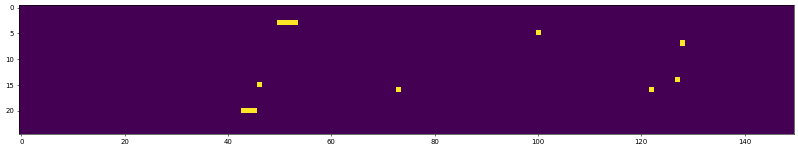

[611] {(100, 4)}


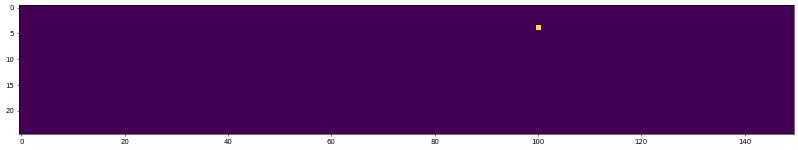

[628] {(100, 5)}


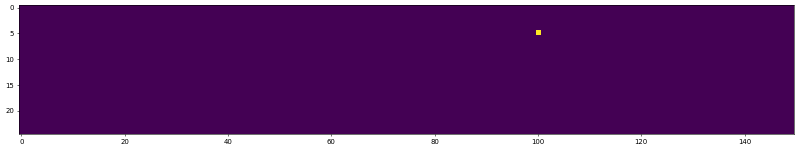

[633] {(100, 5)}


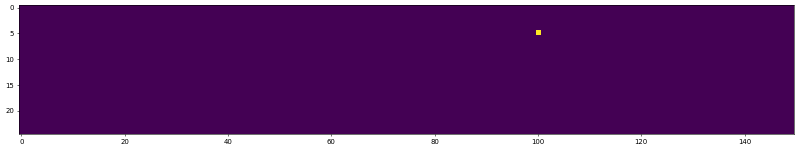

[652, 653] {(99, 5), (93, 14), (100, 6), (94, 14)}


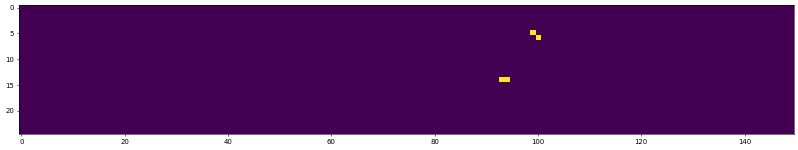

[658, 659, 662, 663, 664, 666] {(98, 5), (100, 6), (25, 5), (23, 5), (24, 5), (100, 5)}


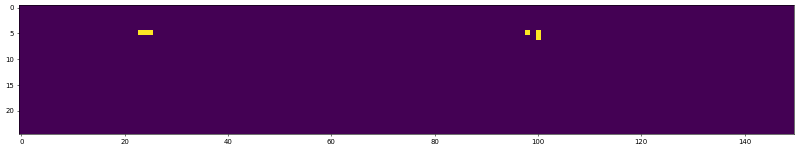

[673, 676] {(99, 5), (99, 6)}


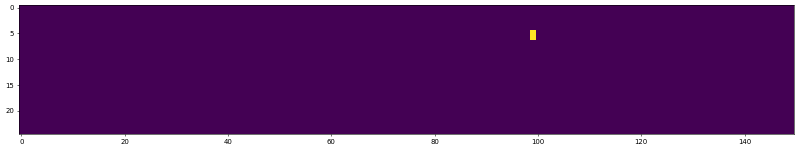

[683] {(100, 5)}


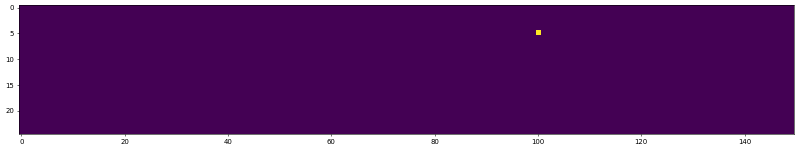

[698] {(18, 20)}


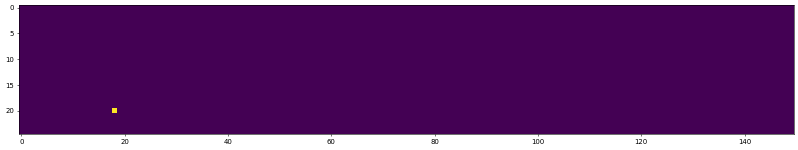

[703] {(17, 20)}


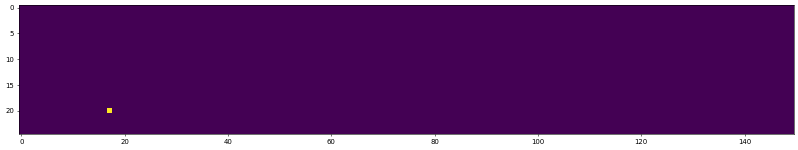

[707, 709, 710, 711] {(16, 20), (15, 20), (127, 18), (128, 18), (100, 5)}


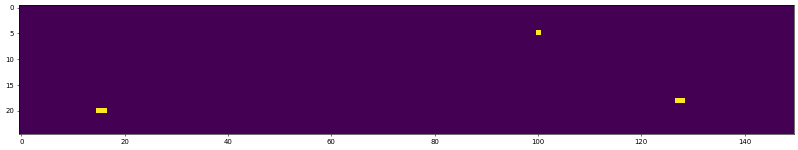

[715, 717, 718] {(111, 16), (14, 20), (100, 5), (15, 20)}


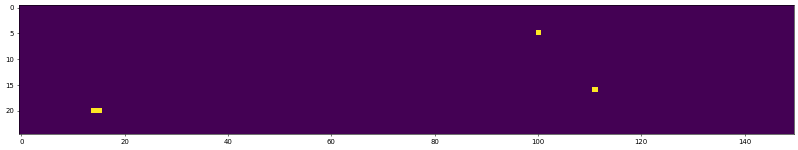

[723, 724, 725, 727, 730, 731, 732, 735, 736, 737, 739, 740, 743] {(100, 4), (99, 5), (9, 20), (101, 5), (11, 20), (113, 16), (100, 6), (144, 0), (146, 0), (132, 16), (8, 20), (10, 20), (143, 0), (114, 16), (100, 5), (12, 20), (147, 0), (145, 0), (131, 16)}


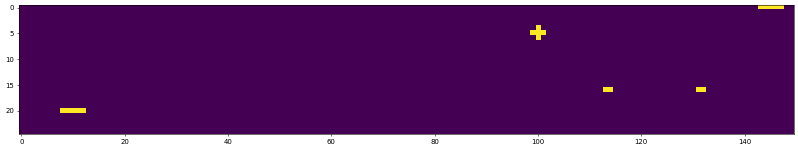

[747] {(7, 20)}


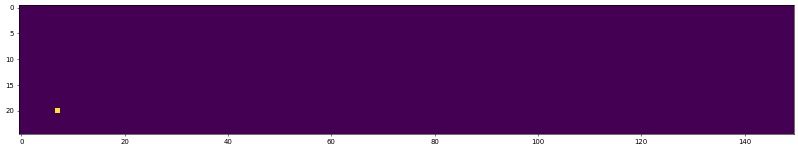

[752, 755, 758] {(5, 20), (100, 4), (6, 20), (4, 20)}


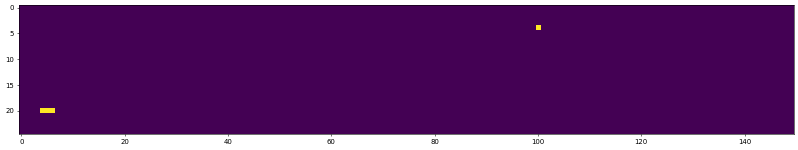

[766, 768, 771] {(99, 5), (100, 6)}


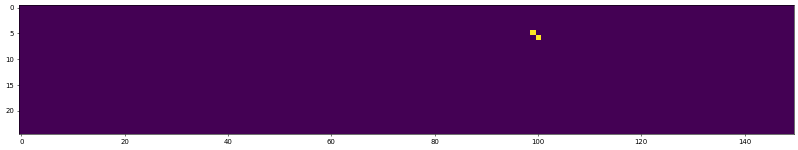

[775, 777] {(99, 5), (100, 6)}


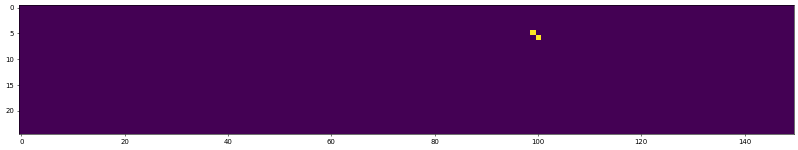

[783] {(99, 4)}


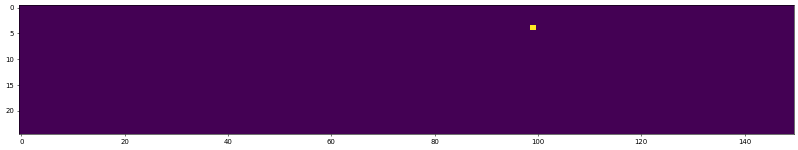

[791] {(62, 2), (100, 4), (63, 2)}


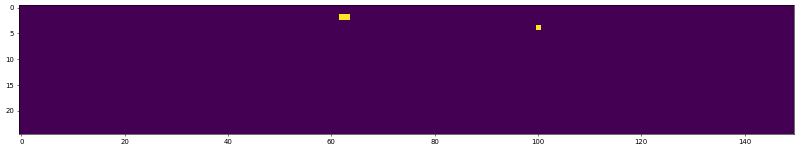

[799] {(124, 16)}


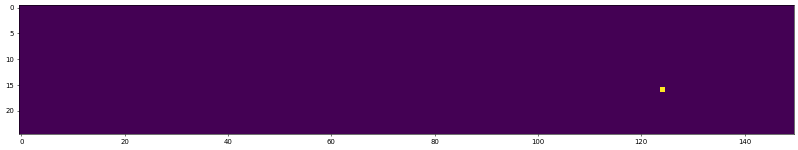

[816] {(91, 5), (92, 5)}


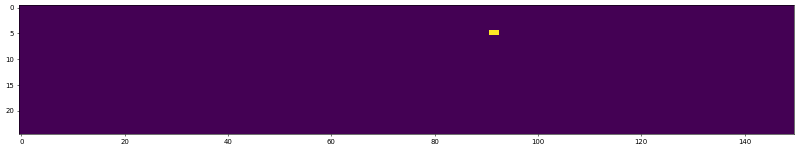

[868] {(99, 6)}


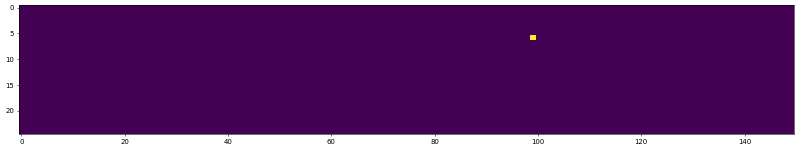

[888] {(57, 4)}


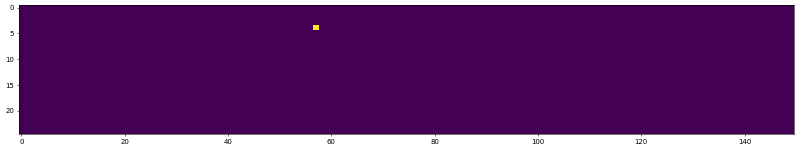

[892] {(98, 4)}


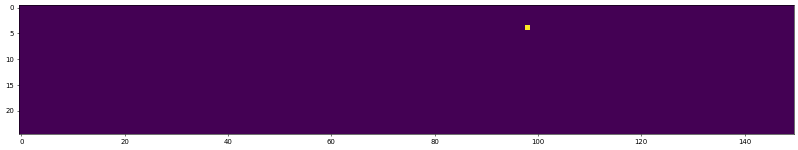

[911] {(100, 6)}


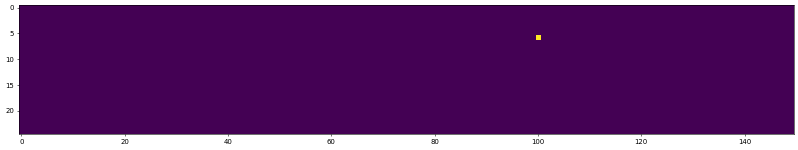

[919, 920, 921, 924] {(107, 0), (99, 5), (100, 5), (106, 0)}


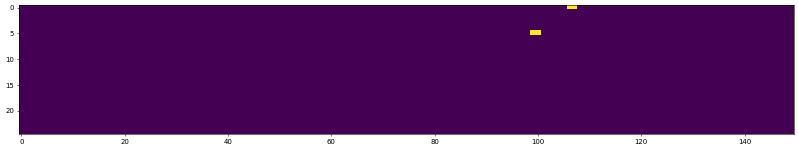

[928] {(100, 4)}


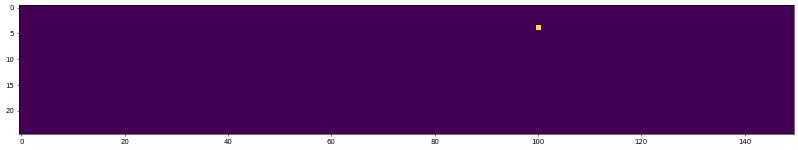

[934] {(101, 5)}


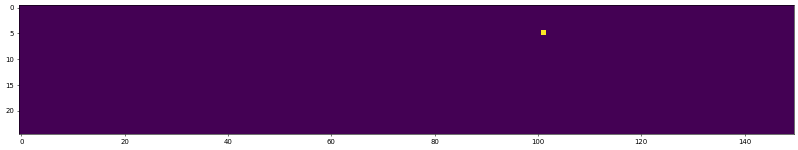

[941] {(90, 6)}


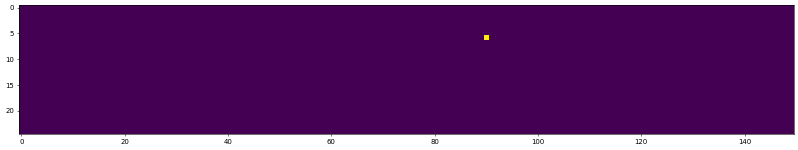

[949] {(4, 17)}


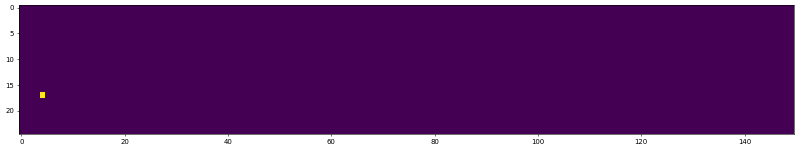

[955, 957, 958] {(124, 10), (100, 6), (123, 10)}


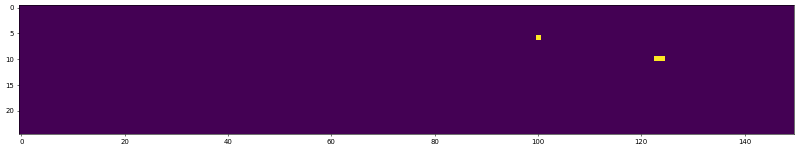

[971] {(26, 11)}


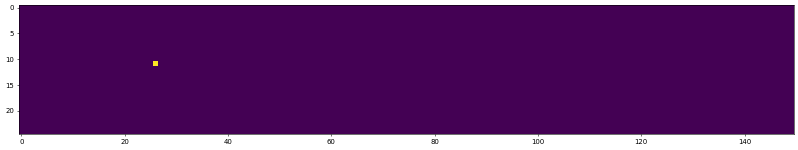

[978, 980] {(99, 5), (100, 5)}


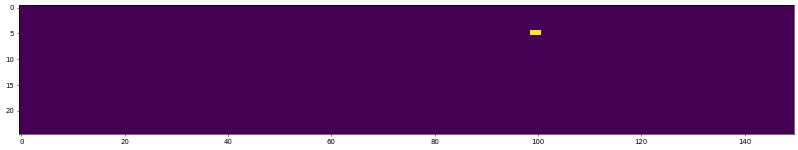

[999] {(99, 5)}


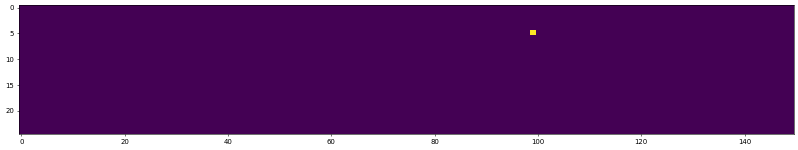

[1003, 1004] {(99, 5), (99, 6)}


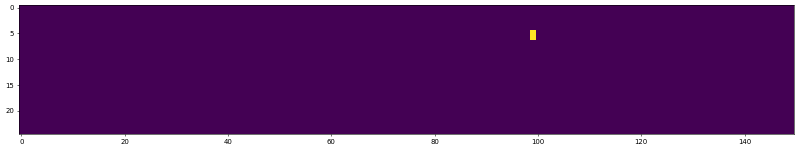

[1013] {(4, 11), (3, 11)}


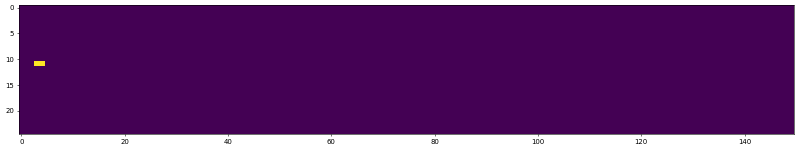

[1019, 1020, 1021, 1022] {(68, 24), (74, 24), (65, 24), (66, 24), (67, 24)}


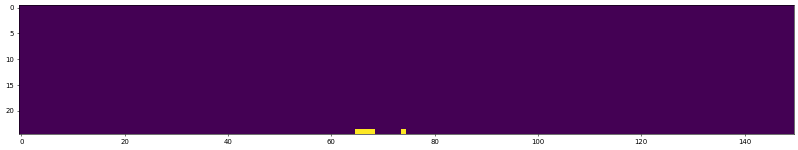

[1040, 1041] {(99, 5), (98, 4)}


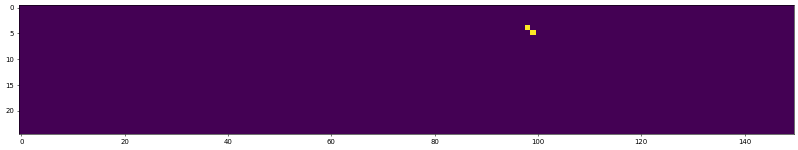

[1055] {(98, 5)}


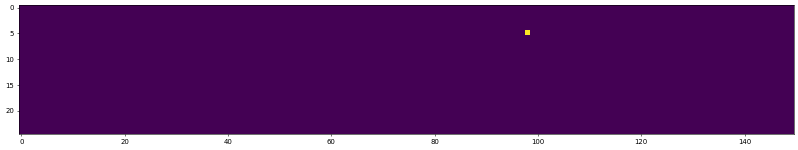

[1071, 1074] {(98, 4), (98, 6)}


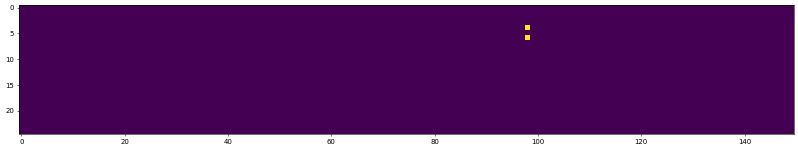

[1084] {(99, 6)}


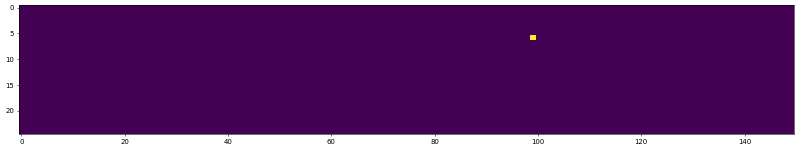

[1088, 1089, 1091] {(99, 4), (99, 6), (7, 24), (100, 4)}


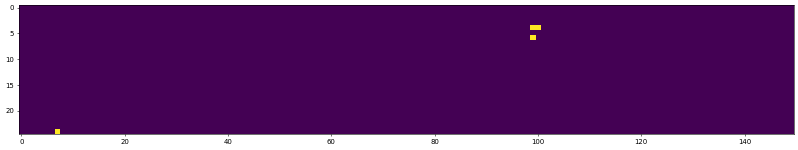

[1101] {(99, 5)}


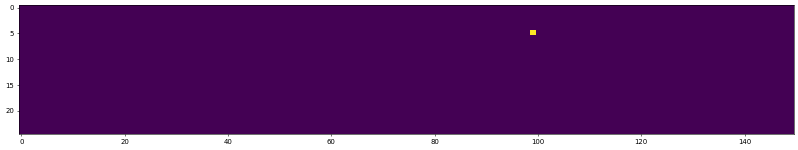

[1109, 1111, 1114, 1117] {(100, 4), (99, 6), (98, 5)}


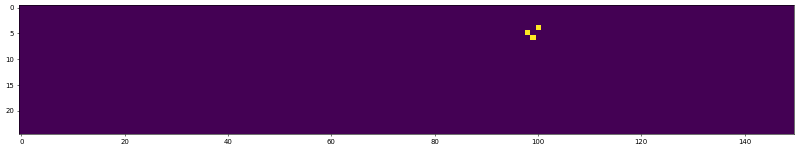

[1134, 1136, 1138, 1139] {(131, 9), (130, 9), (98, 4), (98, 6)}


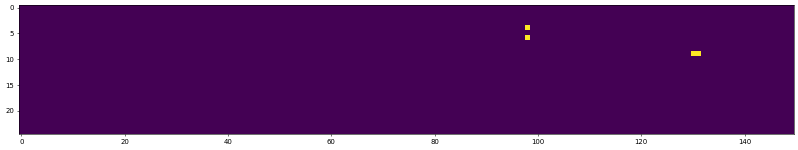

[1159] {(111, 10)}


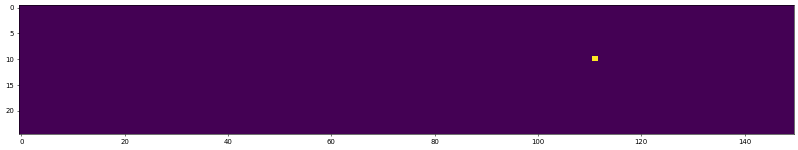

[1185, 1186] {(13, 8), (14, 8), (15, 8)}


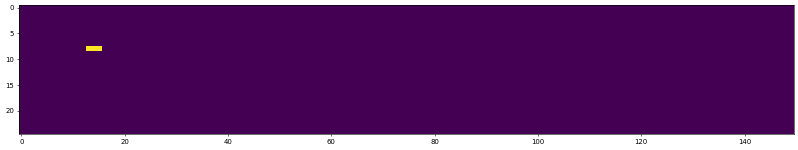

[1202] {(92, 1), (93, 1)}


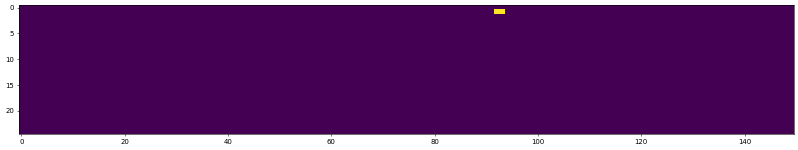

[1218] {(109, 18)}


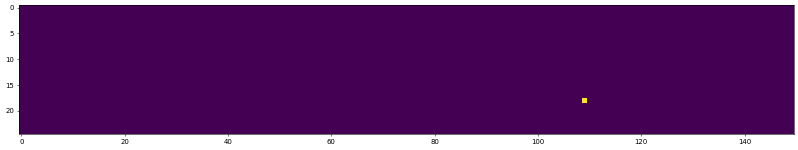

[1234] {(70, 10)}


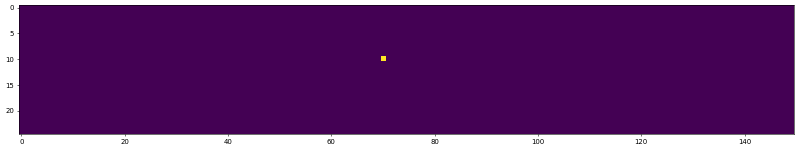

128 128 128
Kidney_map_150z25_60s_#40.npy
[45] {(118, 3)}


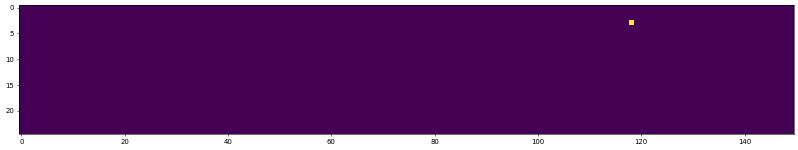

[73] {(140, 6)}


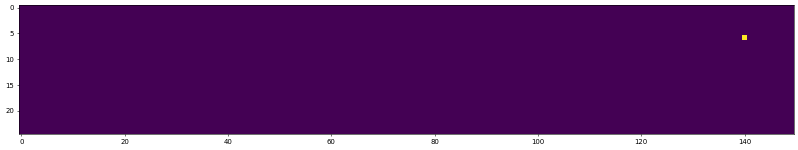

[140, 143] {(137, 5), (136, 5)}


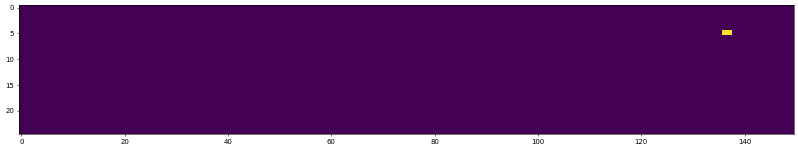

[148, 149] {(140, 5), (139, 5)}


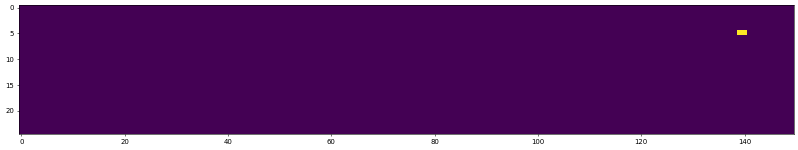

[158] {(23, 10)}


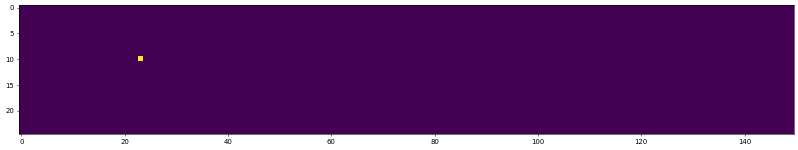

[178] {(37, 15)}


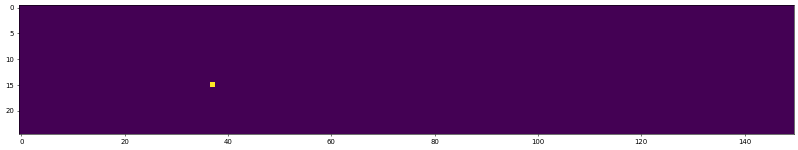

[204] {(145, 3)}


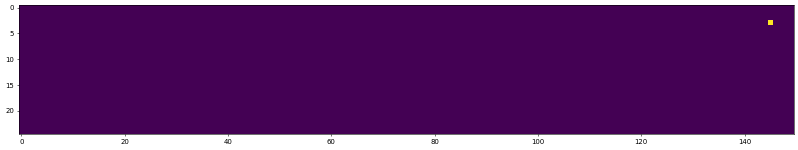

[223, 224, 226, 227] {(113, 0), (115, 0), (116, 0), (117, 0), (114, 0)}


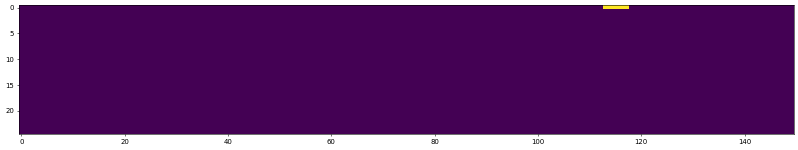

[239] {(28, 15)}


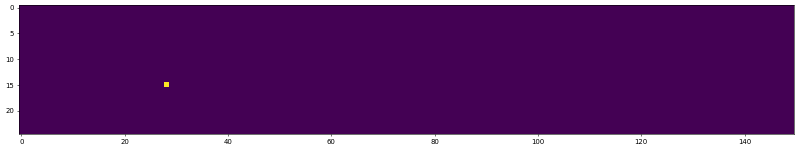

[247] {(26, 15)}


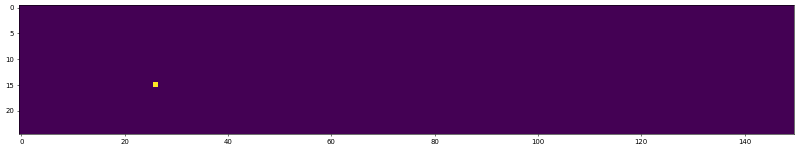

[254] {(24, 15)}


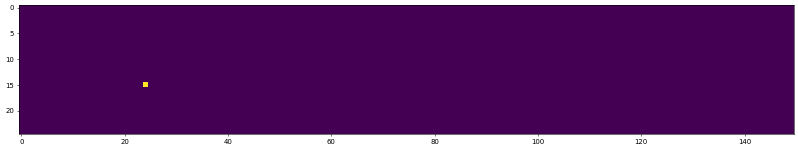

[374] {(94, 1)}


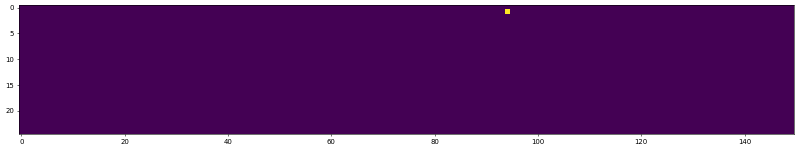

[382] {(104, 11), (103, 11)}


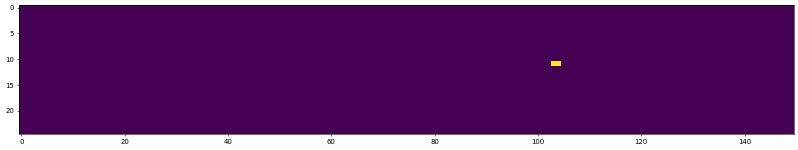

[389] {(102, 11)}


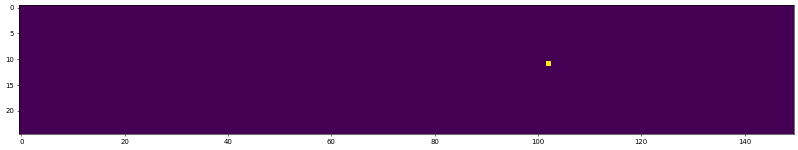

[443] {(94, 15)}


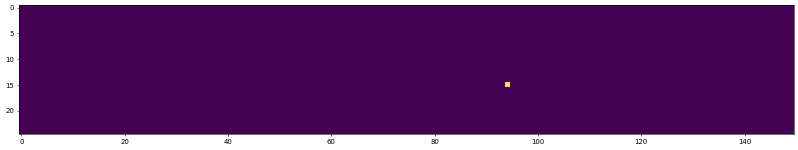

[457, 458, 461] {(86, 20), (87, 20), (88, 20)}


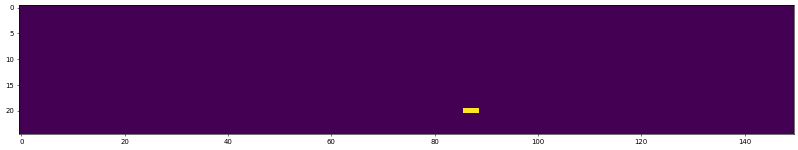

[528] {(139, 12)}


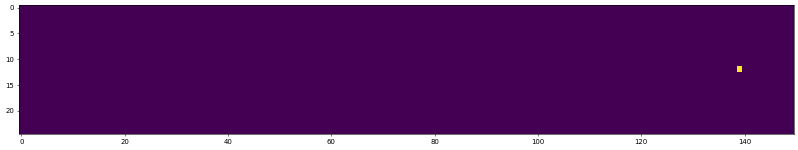

[620, 622, 623, 625, 626, 628] {(49, 23), (50, 23), (46, 23), (47, 23), (48, 23), (137, 5), (136, 5)}


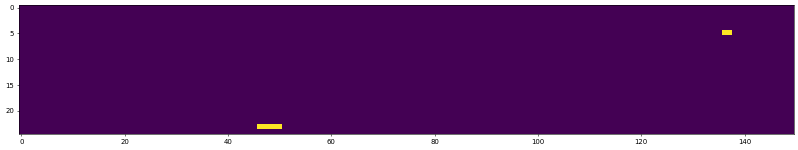

[633] {(92, 12)}


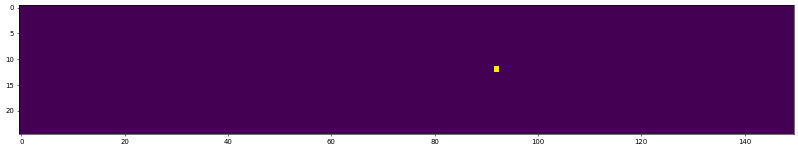

[644] {(53, 24)}


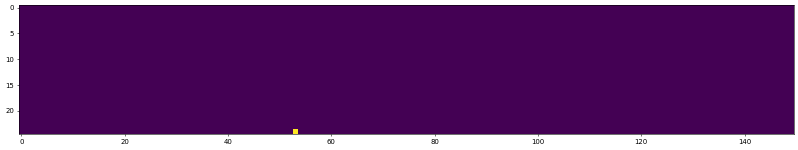

[649, 650] {(113, 5), (112, 5)}


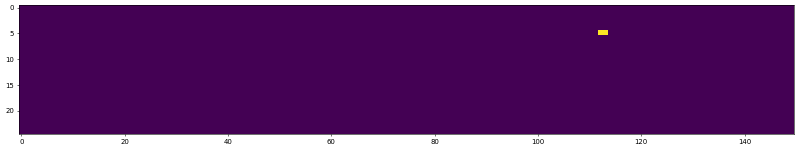

[655, 656] {(28, 22), (29, 22), (88, 9)}


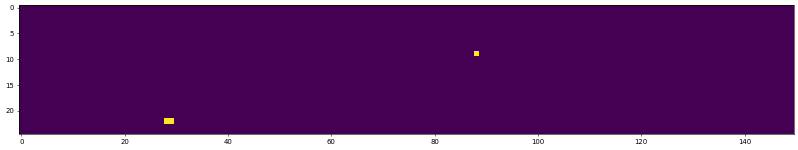

[685] {(94, 3)}


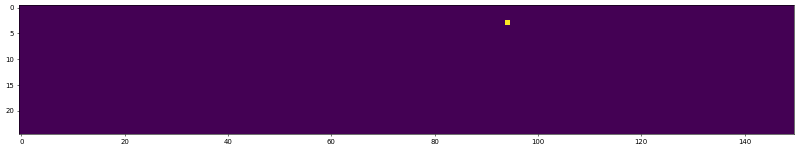

[694, 695, 696] {(148, 5), (145, 5), (149, 5), (144, 5), (147, 5)}


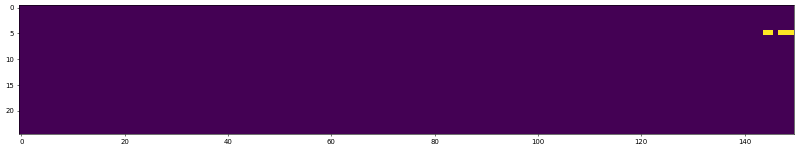

[751, 752, 754, 755, 756] {(131, 21), (70, 15), (130, 21), (71, 15), (66, 15), (69, 15), (67, 15), (65, 15), (68, 15)}


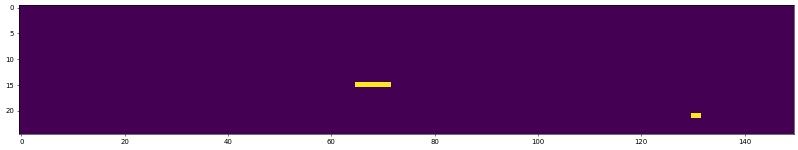

[792, 793, 794, 795] {(139, 5), (142, 5), (140, 5), (138, 5), (141, 5)}


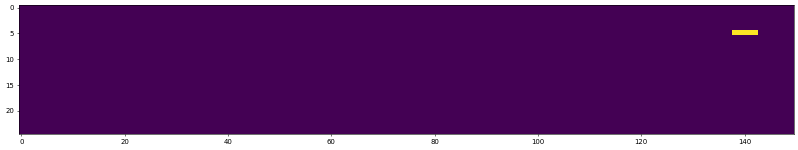

[805] {(138, 9), (137, 9)}


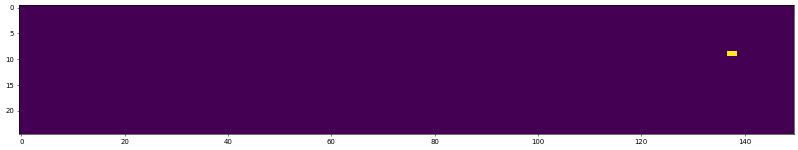

[818] {(101, 24)}


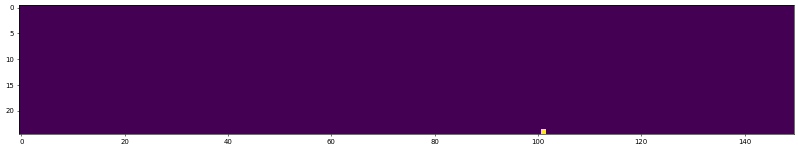

[826, 827] {(24, 20), (23, 20)}


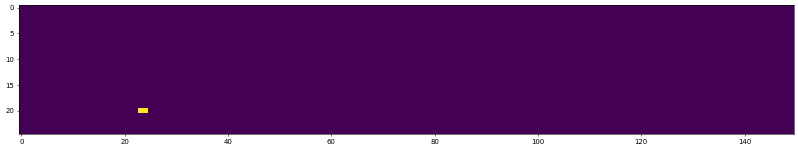

[842] {(38, 1), (146, 9)}


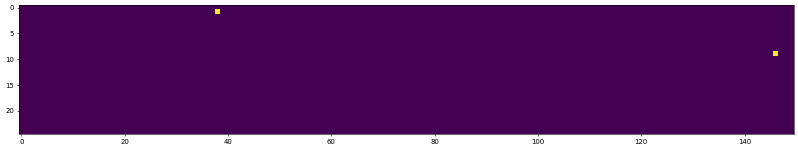

[848] {(23, 11)}


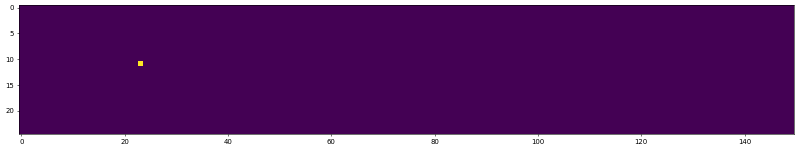

[852, 854] {(23, 11), (22, 11)}


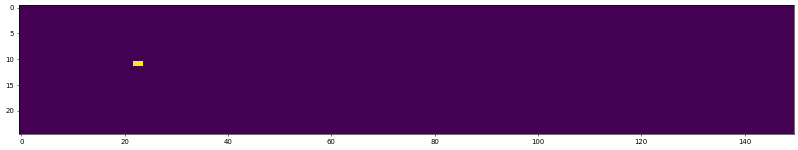

[887, 889, 890] {(33, 7), (34, 7), (30, 7), (31, 7), (32, 7)}


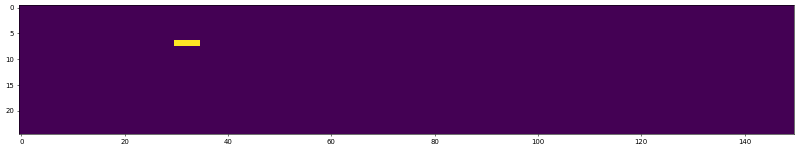

[915, 916, 917] {(134, 10), (126, 18), (135, 10)}


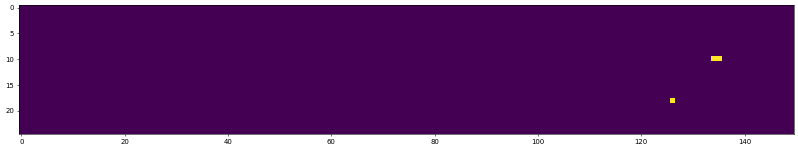

[930, 931, 932, 933] {(134, 12), (137, 12), (132, 12), (135, 12), (133, 12), (136, 12)}


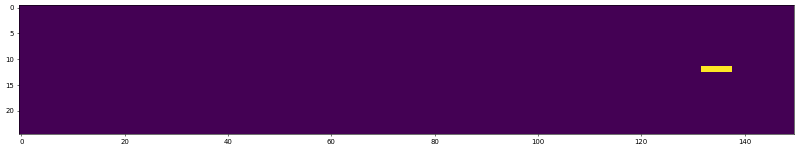

[969] {(145, 15)}


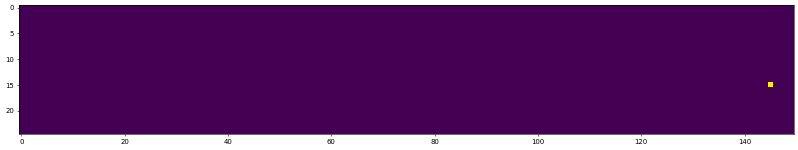

[973, 975, 976, 977, 978, 979, 980, 981, 982] {(61, 1), (149, 3), (148, 3), (115, 5), (63, 1), (116, 5), (117, 5), (62, 1)}


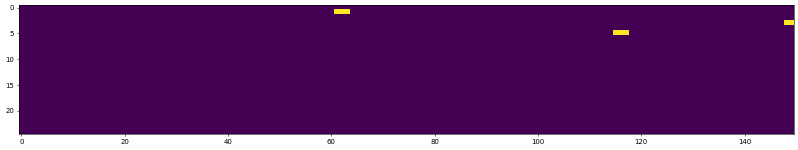

[994] {(93, 5)}


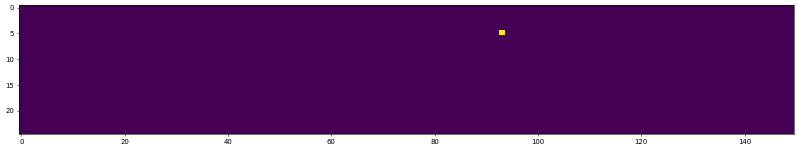

[1014, 1015] {(56, 6), (59, 6), (54, 6), (57, 6), (58, 6), (55, 6)}


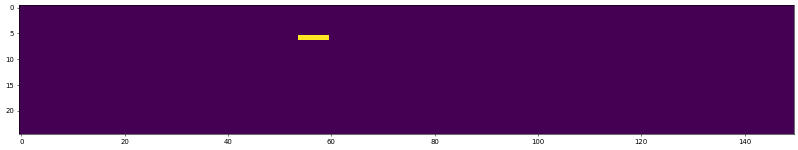

[1024, 1026, 1028] {(110, 5), (108, 5), (109, 5)}


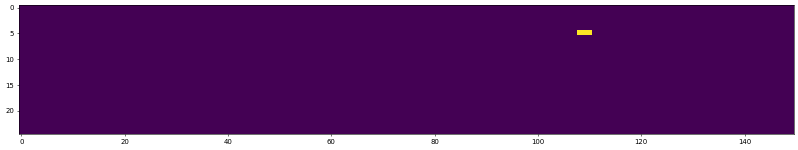

[1041] {(144, 1)}


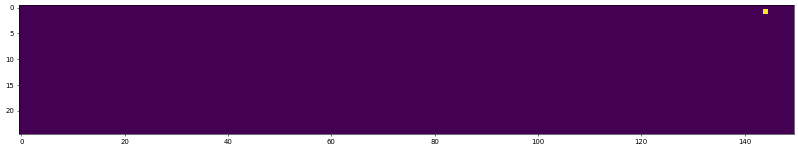

[1090, 1091, 1092, 1093] {(66, 5), (64, 5), (67, 5), (65, 5)}


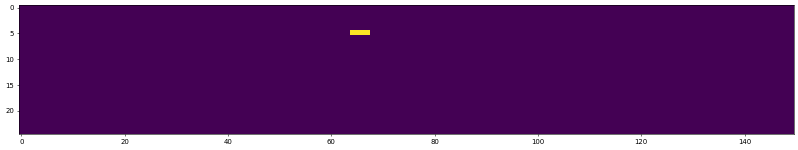

[1141, 1143, 1145, 1147] {(13, 14), (104, 19), (10, 13), (105, 19), (103, 19)}


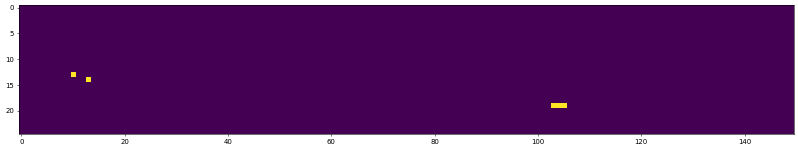

[1203] {(45, 18)}


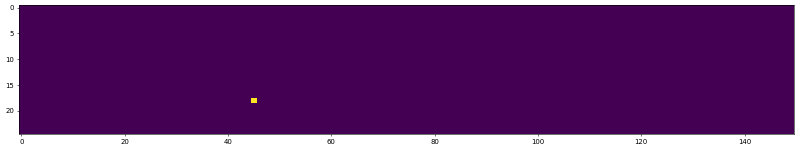

[1209] {(2, 12)}


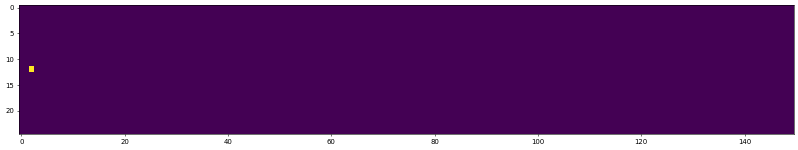

[1213] {(101, 14)}


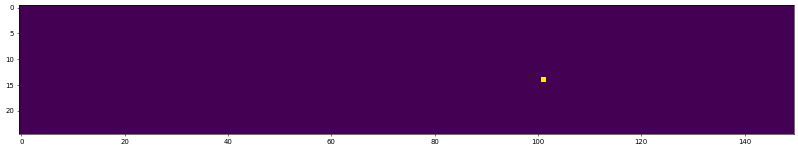

114 114 114
Kidney_map_150z25_60s_#38.npy
[9] {(58, 24), (59, 24)}


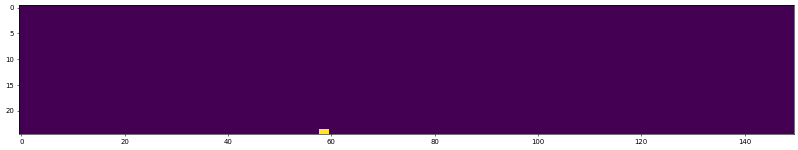

[36] {(104, 1)}


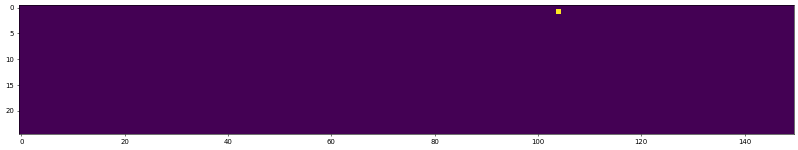

[58, 59, 61] {(82, 11), (83, 11), (84, 11)}


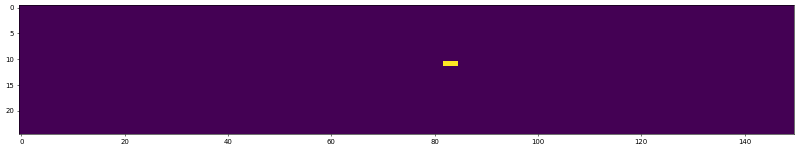

[108] {(55, 16)}


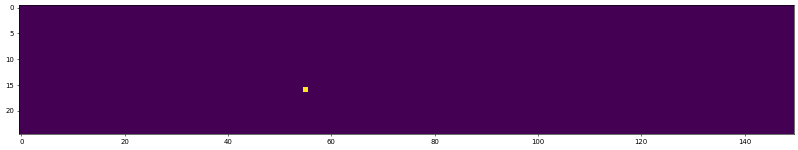

[129, 130, 131, 132] {(59, 3), (104, 19), (61, 3), (105, 19), (62, 3), (57, 3), (60, 3), (58, 3)}


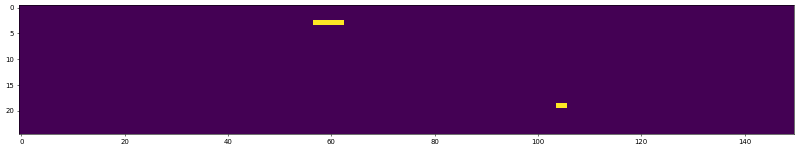

[144] {(41, 5)}


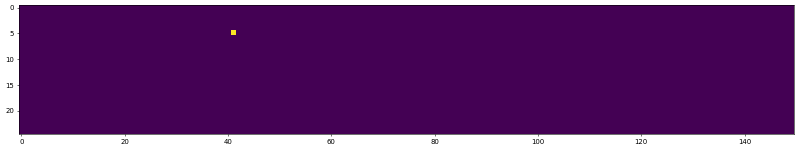

[151] {(143, 19)}


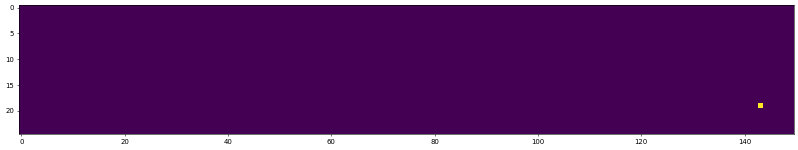

[158] {(119, 5), (120, 5)}


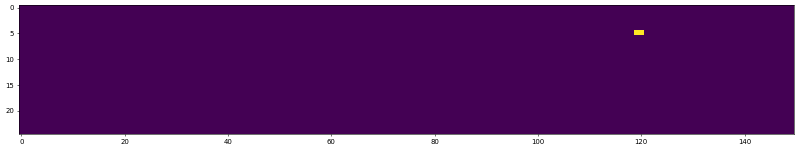

[165] {(135, 5)}


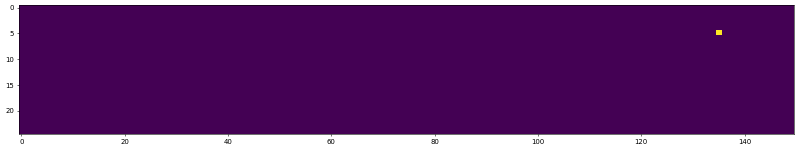

[178] {(75, 5), (76, 5)}


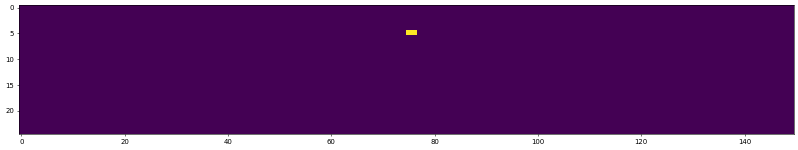

[191, 194, 195] {(46, 20), (47, 20)}


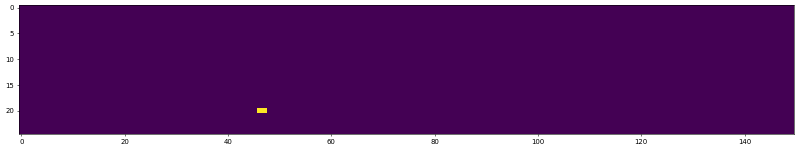

[206, 209] {(149, 20), (148, 20)}


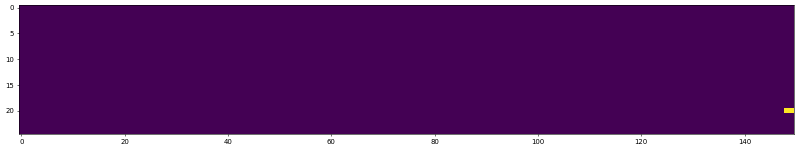

[219] {(93, 2)}


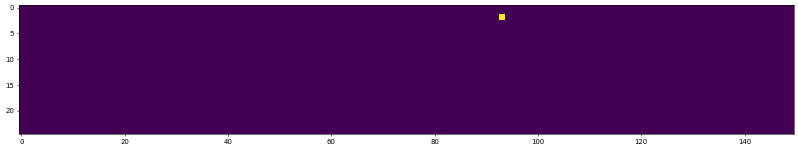

[238, 241] {(97, 24), (131, 16)}


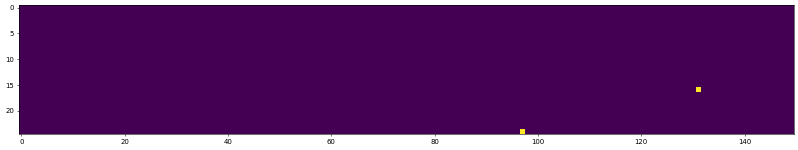

[249, 250] {(36, 24), (37, 24)}


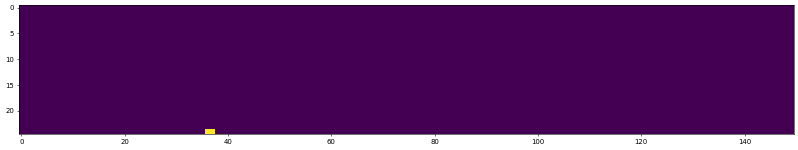

[284] {(37, 13)}


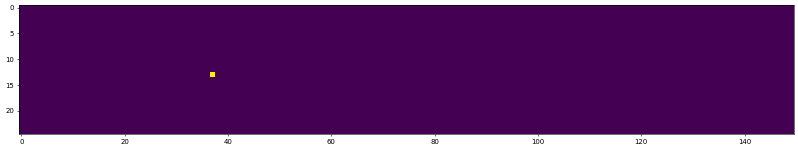

[338, 340] {(125, 23), (126, 23)}


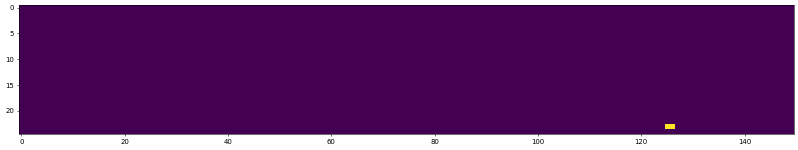

[383, 385, 386, 388] {(121, 10), (119, 10), (120, 10), (122, 10)}


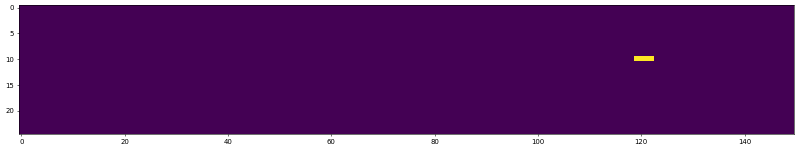

[415] {(0, 19)}


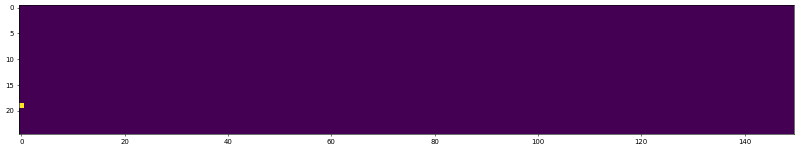

[423, 425] {(8, 19), (7, 19), (41, 17)}


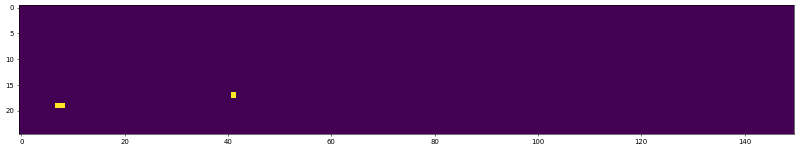

[429] {(40, 17)}


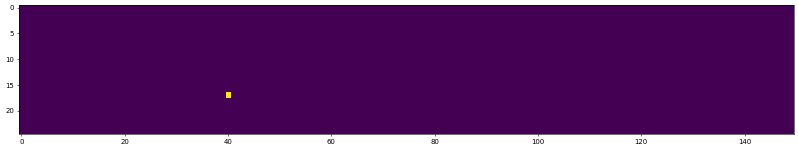

[474] {(94, 13)}


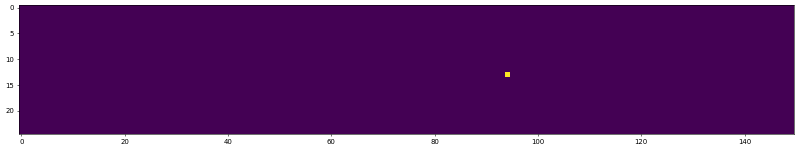

[531, 532, 533, 534] {(141, 24), (143, 24), (144, 24), (142, 24), (140, 24)}


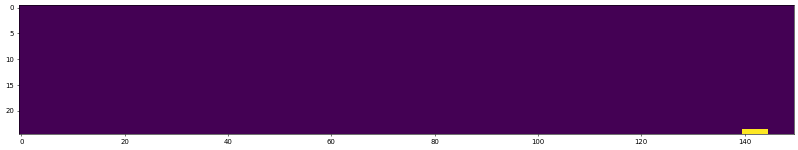

[573, 574] {(92, 7), (90, 7), (91, 7), (89, 7)}


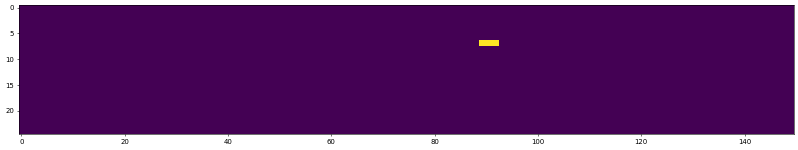

[584] {(34, 17)}


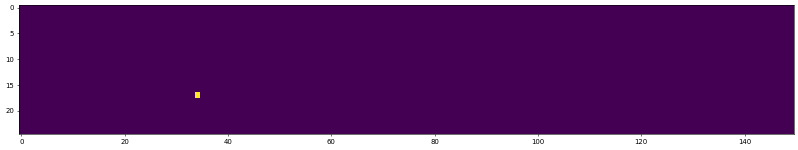

[596] {(34, 17), (35, 17)}


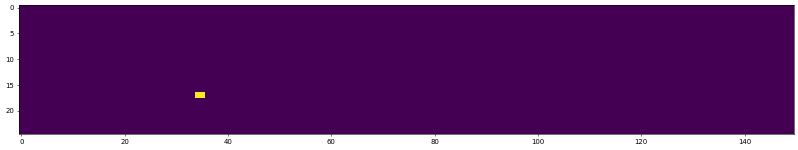

[623] {(134, 21)}


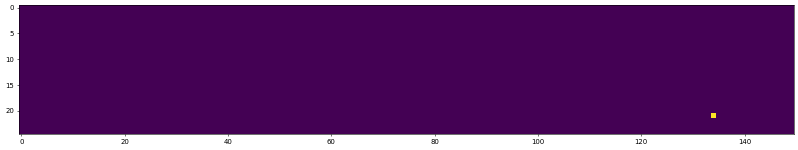

[642] {(2, 13)}


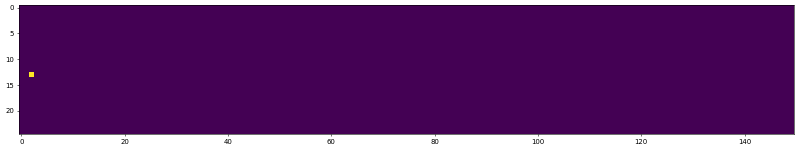

[711] {(42, 9), (44, 9), (45, 9), (40, 9), (41, 9), (43, 9)}


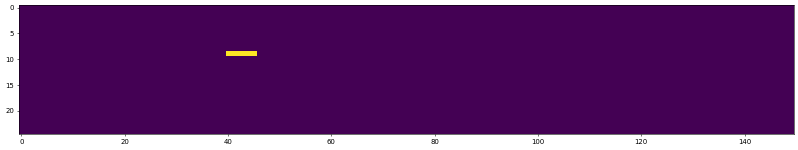

[728, 729, 731, 734, 737] {(53, 21), (93, 24), (32, 17), (92, 24), (94, 24)}


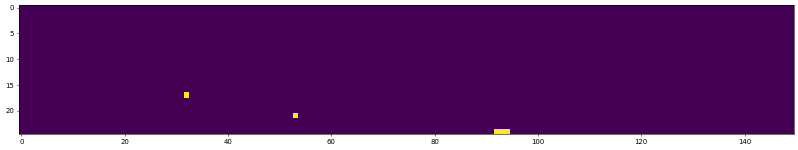

[775] {(55, 22)}


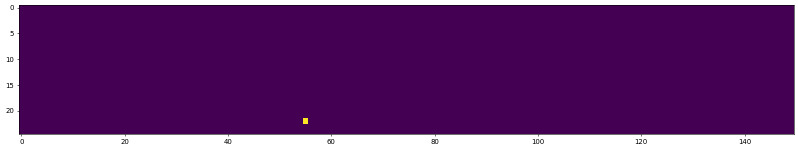

[797, 800, 801, 802] {(123, 22), (132, 21), (146, 13), (122, 22)}


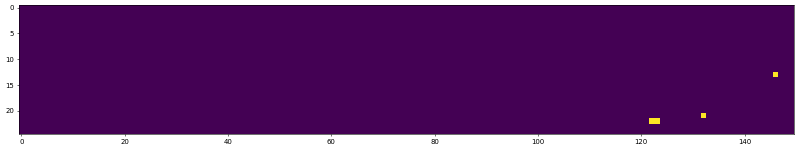

[807] {(118, 13)}


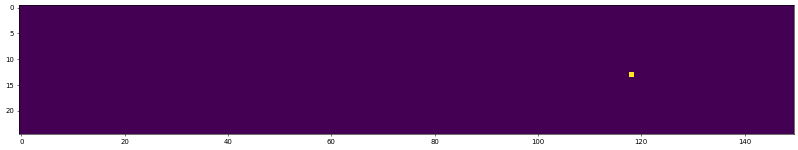

[817, 819] {(93, 7), (94, 7)}


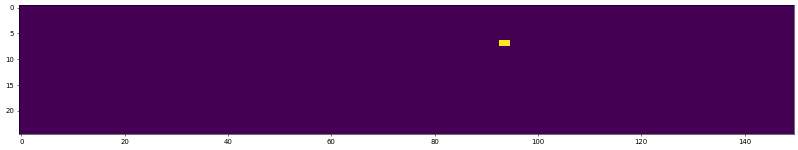

[827, 829, 831] {(141, 13), (142, 13), (143, 24), (140, 13)}


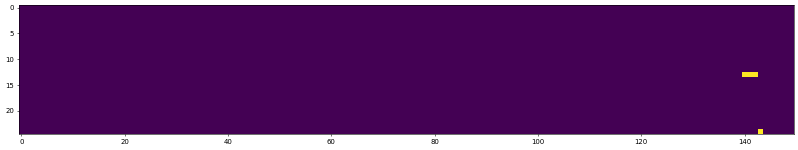

[836, 837] {(139, 2), (140, 2)}


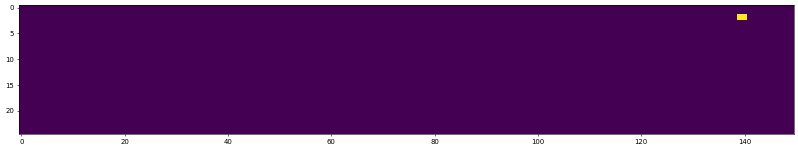

[847] {(147, 15), (148, 15)}


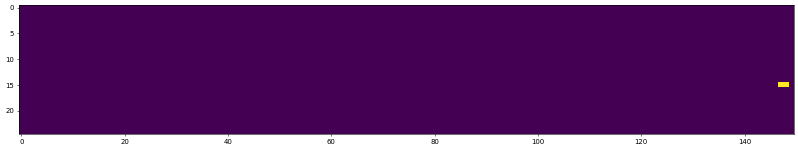

[865] {(90, 11)}


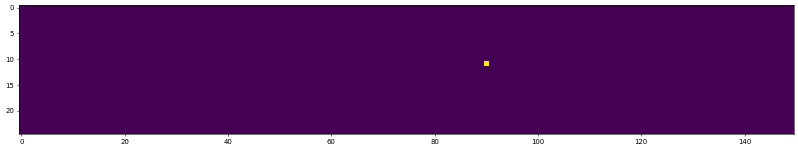

[872] {(129, 17), (130, 17)}


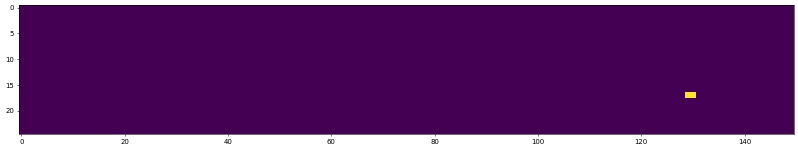

[908] {(144, 10)}


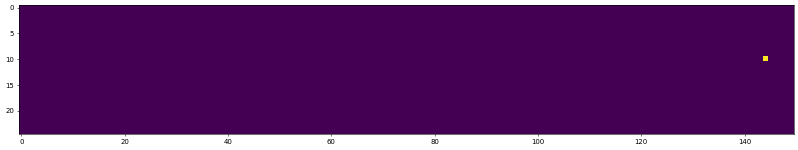

[965, 966] {(123, 11), (146, 0), (147, 0)}


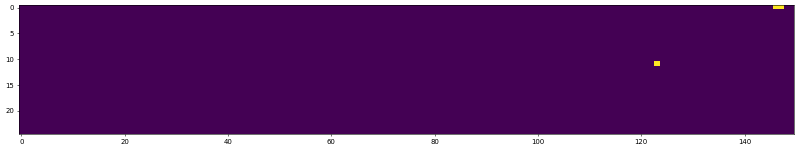

[998] {(134, 21)}


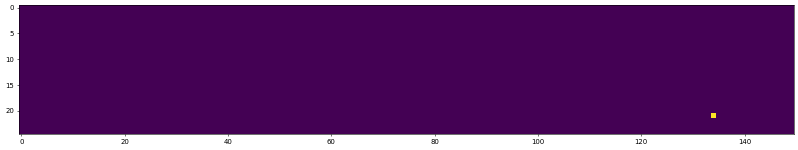

[1012] {(100, 13)}


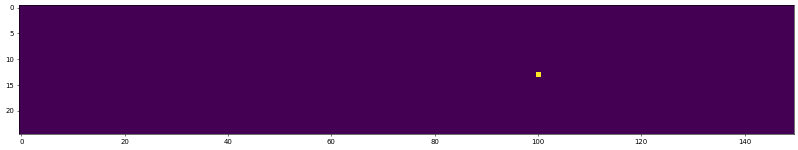

[1032, 1033, 1034] {(31, 5), (73, 6), (74, 6), (28, 5), (29, 5), (30, 5)}


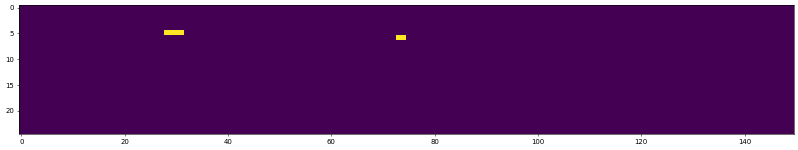

[1039, 1040, 1041, 1042] {(39, 5), (37, 5), (38, 5), (40, 5), (35, 5), (36, 5)}


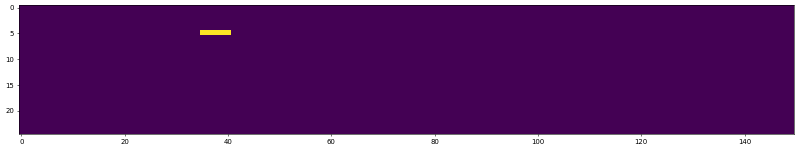

[1051, 1053] {(148, 22), (149, 22)}


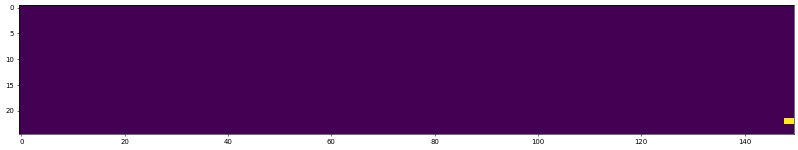

[1090] {(148, 8)}


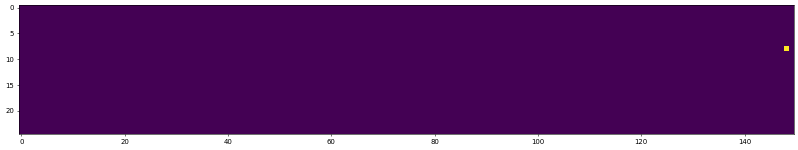

[1107, 1108] {(130, 7), (129, 7)}


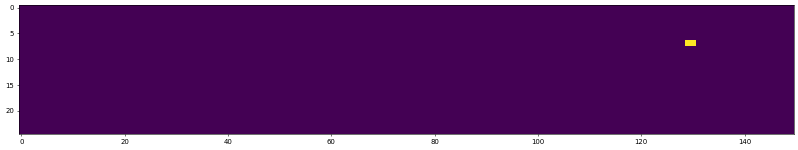

[1112] {(131, 7)}


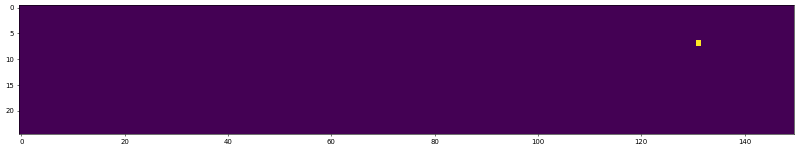

[1143, 1144, 1145, 1146, 1148, 1149, 1150] {(96, 11), (97, 11), (98, 11), (93, 11), (92, 11), (94, 11), (95, 11)}


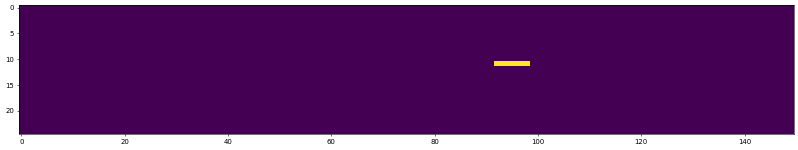

[1193, 1194, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1205] {(121, 7), (110, 8), (123, 7), (100, 22), (122, 7), (99, 22), (109, 8), (108, 8), (111, 8), (106, 8), (107, 8)}


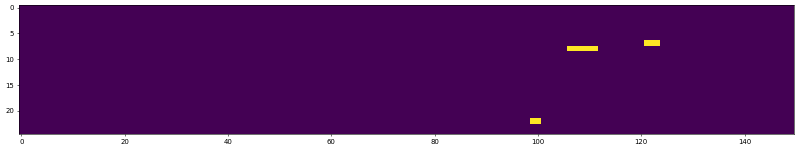

[1209, 1210, 1212, 1213, 1215] {(115, 7), (116, 7), (114, 7), (57, 3), (42, 11), (58, 3), (41, 11)}


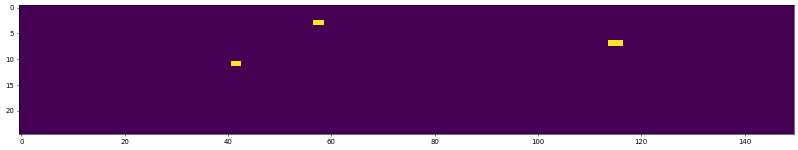

[1219] {(0, 8)}


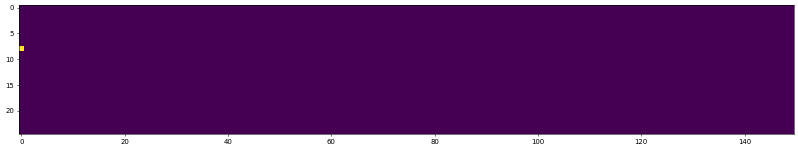

[1230, 1231] {(57, 2), (58, 2)}


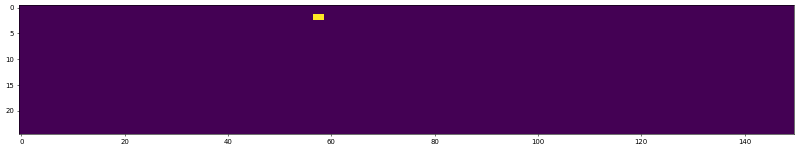

136 136 136
Muscle_map_150z25_60s_#18.npy
[12] {(55, 17)}


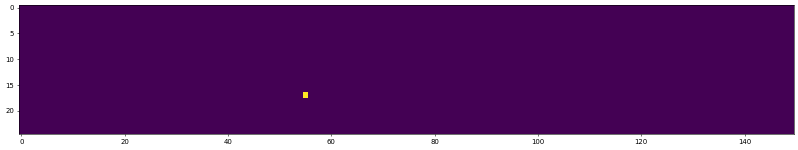

[22] {(142, 13)}


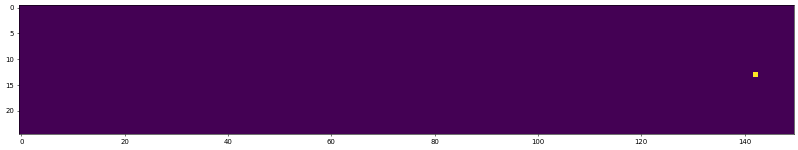

[68, 71, 72, 73] {(32, 15), (106, 14), (107, 14), (42, 2), (30, 15), (3, 15), (31, 15), (43, 2)}


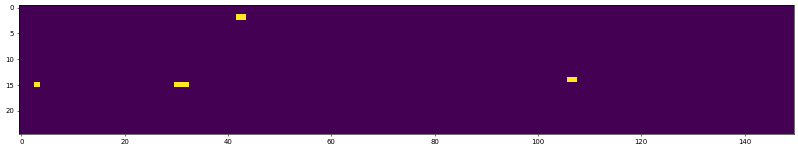

[91] {(55, 15)}


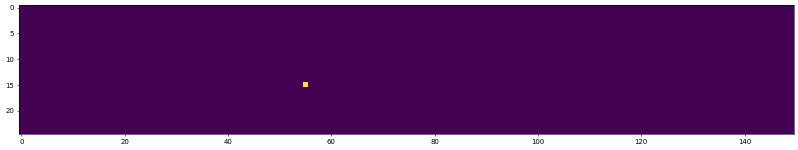

[118, 119, 120] {(105, 15), (106, 15), (126, 15), (107, 15)}


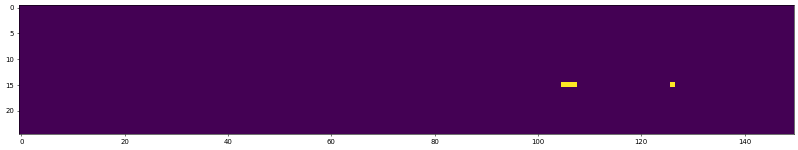

[169] {(88, 2)}


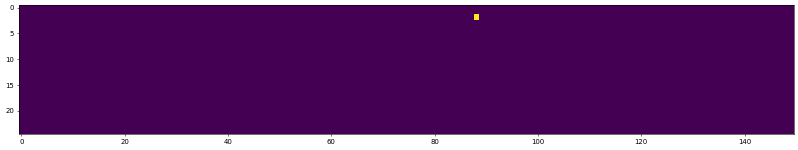

[188] {(38, 20)}


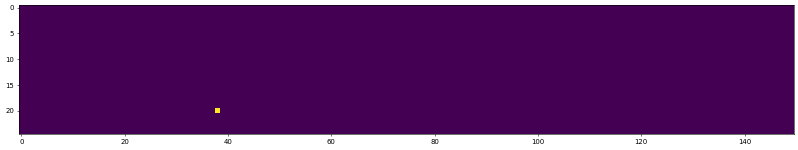

[207, 208] {(115, 6), (116, 6), (113, 6), (114, 6)}


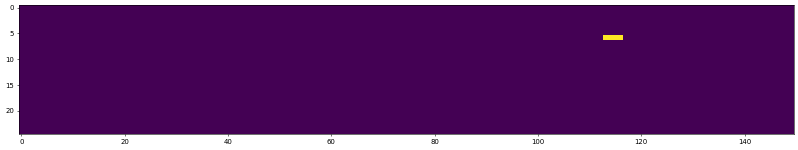

[229] {(34, 5)}


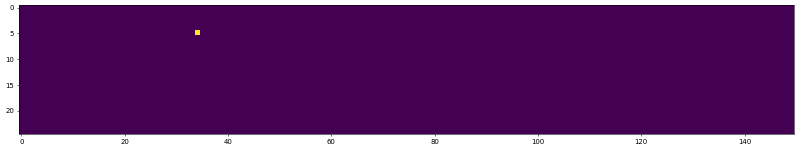

[251, 252] {(142, 10), (141, 10)}


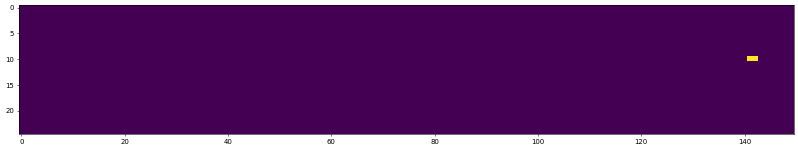

[323] {(58, 1)}


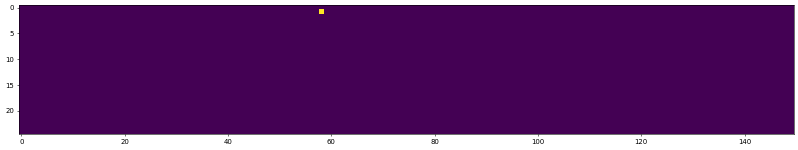

[360] {(64, 10), (65, 10)}


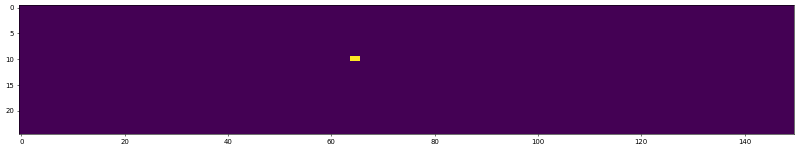

[371, 373, 375, 377, 378] {(91, 5), (92, 5), (120, 24), (121, 24), (119, 24)}


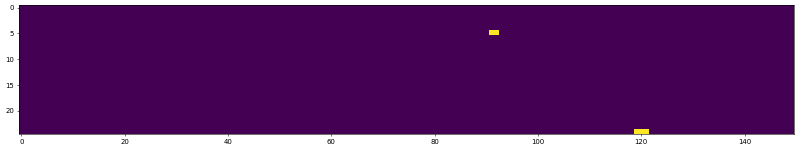

[392] {(87, 19), (88, 19)}


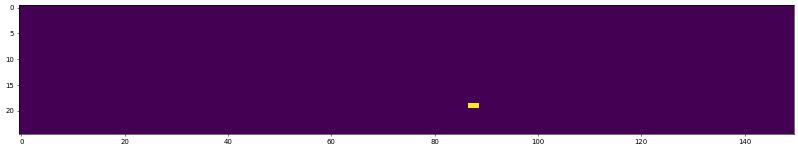

[404, 406] {(63, 1), (64, 1)}


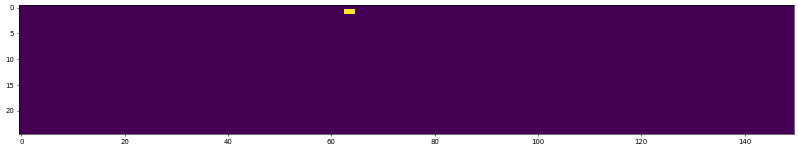

[462, 464] {(75, 15), (74, 15), (73, 15), (76, 15), (77, 15)}


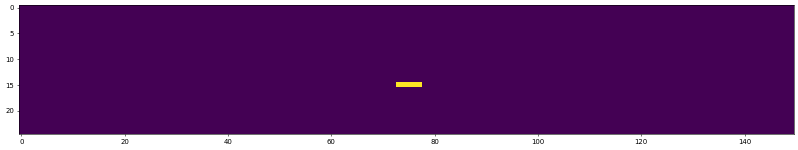

[468] {(78, 16)}


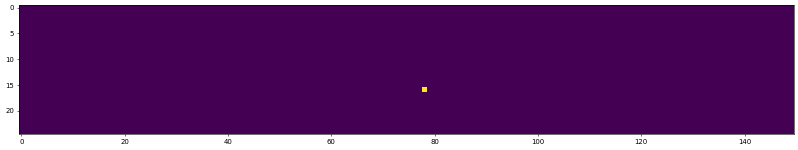

[519, 520] {(44, 18), (43, 18)}


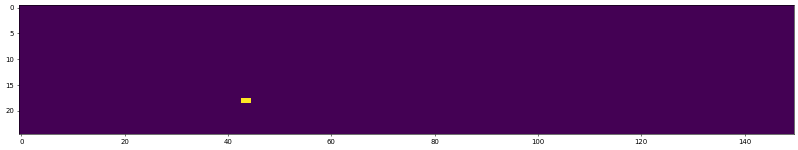

[536, 537] {(39, 6), (135, 16), (38, 6)}


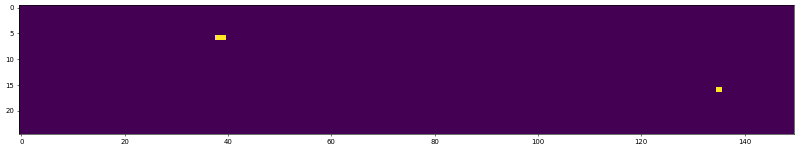

[545, 547, 548, 549] {(94, 10), (28, 19), (95, 10), (95, 22), (96, 22), (94, 22), (27, 19)}


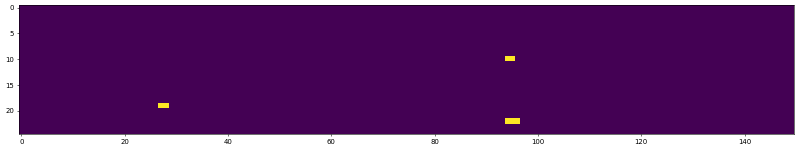

[553] {(110, 0)}


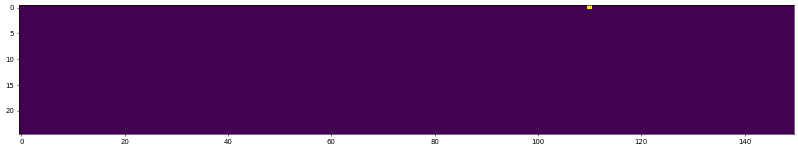

[558, 559, 562, 563, 566, 567] {(116, 22), (111, 0), (130, 22), (117, 22), (112, 0), (118, 22), (129, 22), (131, 22)}


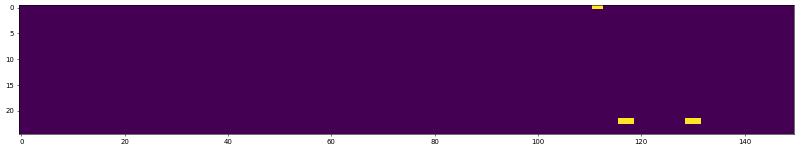

[611, 612] {(75, 3), (74, 3), (88, 10)}


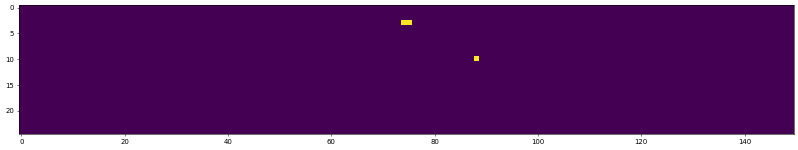

[647] {(129, 3)}


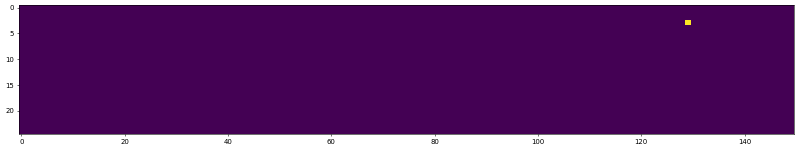

[678] {(34, 5), (35, 5)}


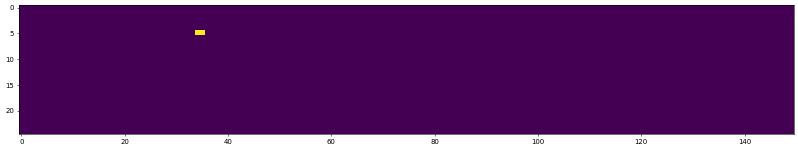

[685, 687] {(91, 5), (90, 5)}


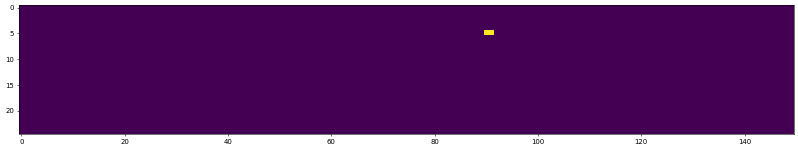

[725, 726] {(98, 7), (99, 7)}


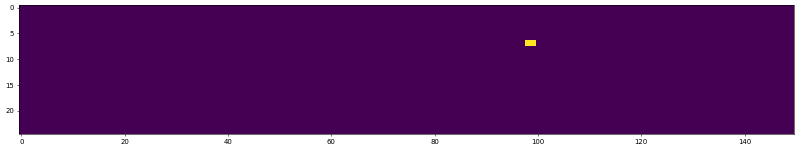

[761] {(81, 4), (82, 4)}


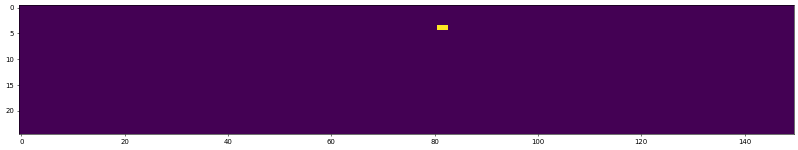

[788, 789] {(137, 24), (138, 24)}


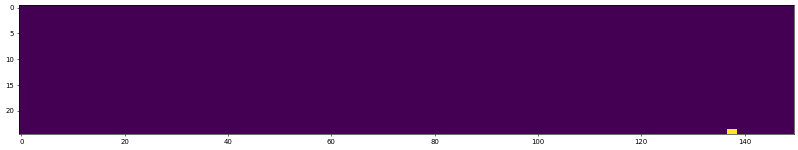

[880, 882, 884, 886, 887, 890, 892, 893, 896, 897, 899, 901, 903] {(80, 5), (81, 5), (76, 5), (77, 5), (72, 5), (82, 5), (75, 5), (71, 5), (83, 5), (78, 5), (73, 5), (79, 5), (74, 5)}


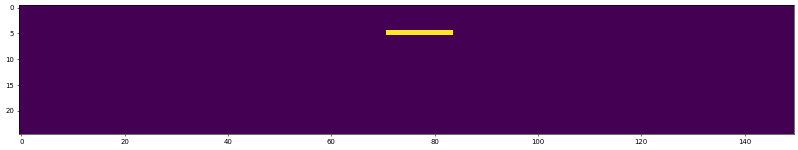

[928, 929, 930, 931] {(127, 22), (130, 22), (128, 22), (129, 22), (131, 22), (126, 22)}


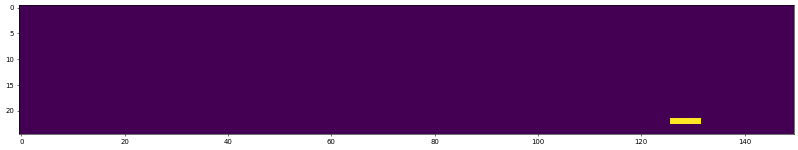

[940] {(50, 18), (51, 18)}


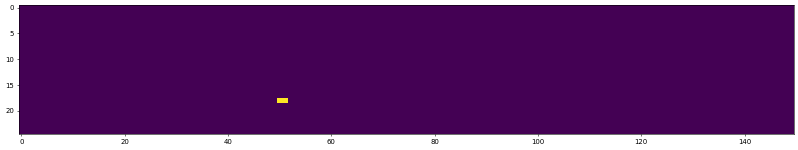

[964] {(11, 1), (12, 1)}


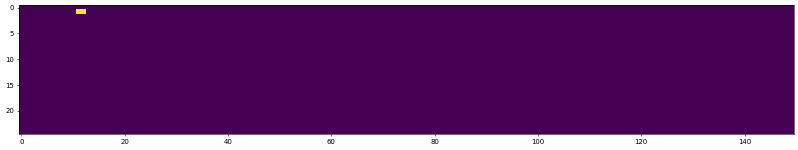

[969] {(100, 17)}


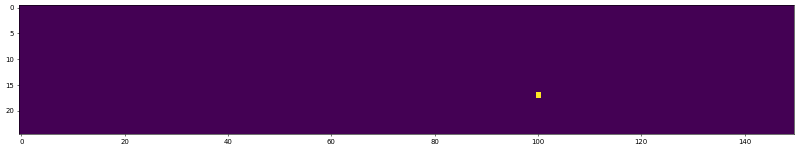

[976] {(64, 23), (65, 23)}


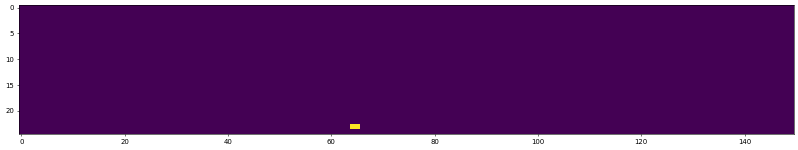

[1000, 1001] {(108, 14), (109, 14)}


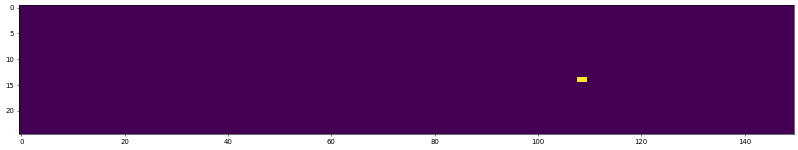

[1012, 1013] {(133, 1), (115, 22), (134, 1), (114, 22)}


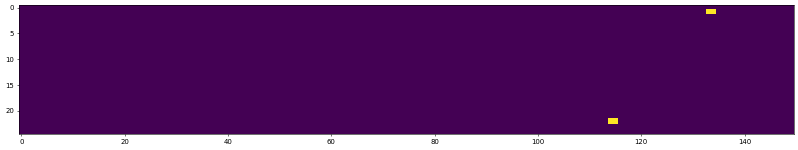

[1065] {(92, 7)}


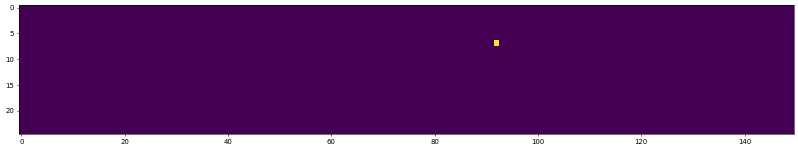

[1093, 1096] {(76, 16), (77, 16)}


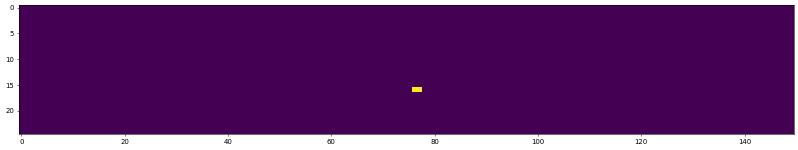

[1119] {(135, 23)}


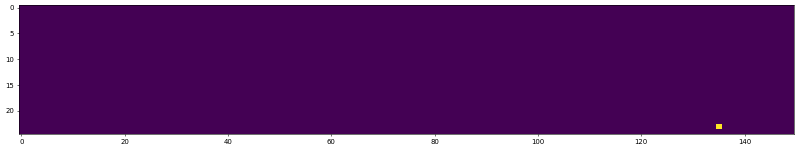

[1130] {(102, 1)}


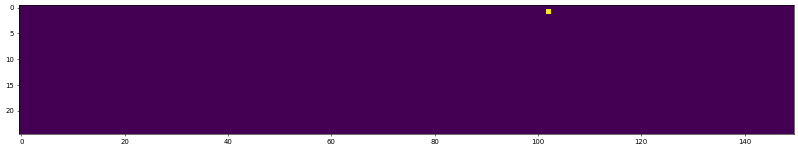

[1143] {(142, 2)}


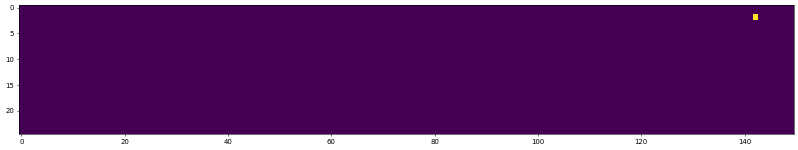

[1156] {(126, 13), (127, 13)}


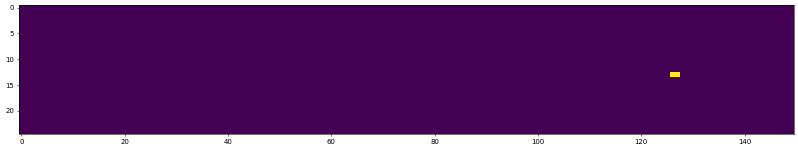

[1180] {(137, 24), (138, 24)}


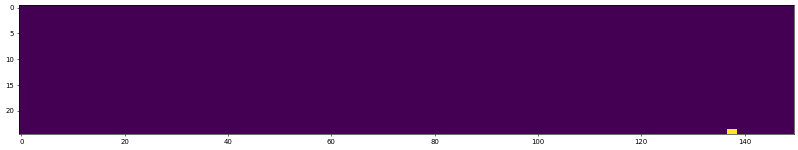

[1207, 1210, 1211, 1212, 1213, 1214] {(135, 20), (130, 19), (125, 19), (136, 20), (132, 19), (127, 19), (143, 4), (128, 19), (123, 19), (126, 19), (129, 19), (124, 19), (134, 20), (122, 19), (131, 19), (137, 20)}


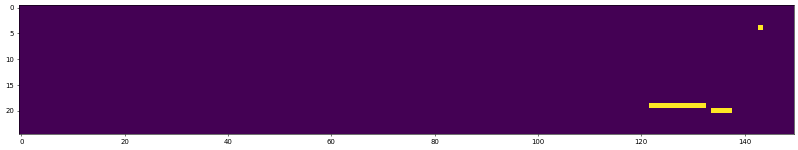

129 129 129
Muscle_map_150z25_60s_#29.npy
[6] {(123, 9)}


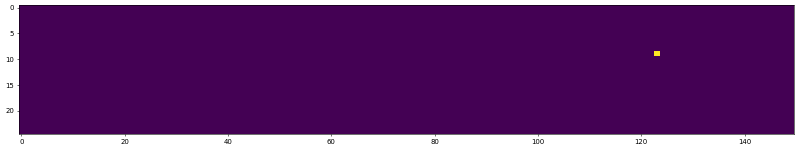

[85, 87] {(36, 17), (126, 22)}


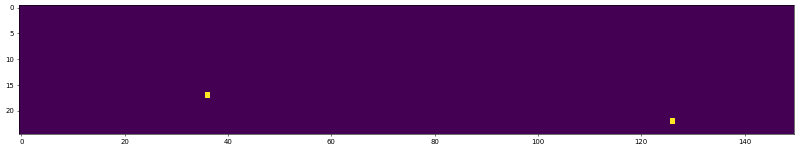

[125, 126] {(100, 11), (101, 11)}


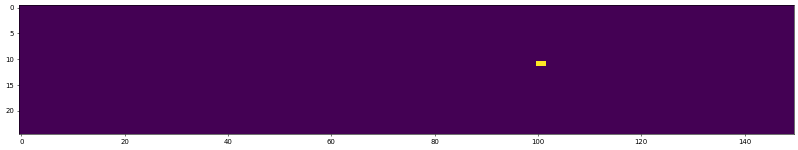

[172] {(73, 20)}


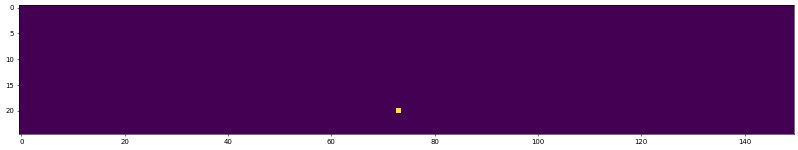

[190] {(93, 20)}


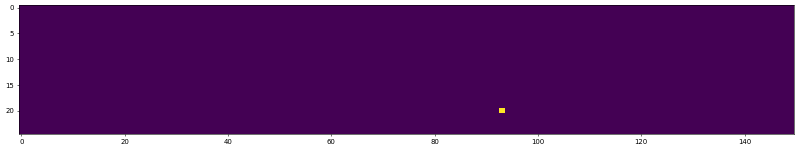

[195, 196, 198, 200, 202, 204, 206, 208, 209, 210] {(70, 10), (54, 0), (71, 10), (56, 0), (57, 0), (52, 0), (72, 10), (53, 0), (55, 0), (51, 0)}


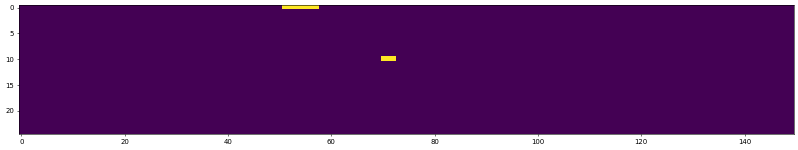

[226] {(82, 13)}


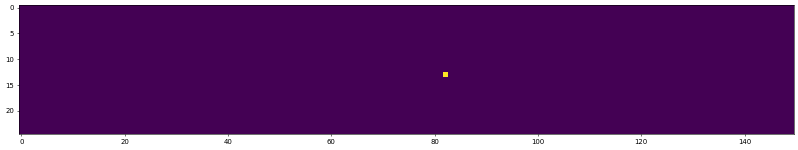

[319] {(54, 21)}


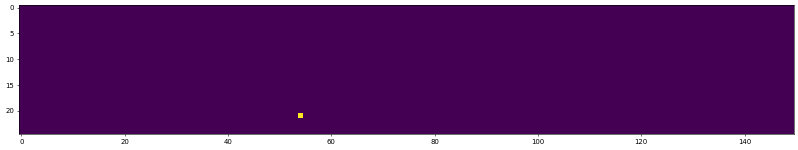

[340] {(144, 15)}


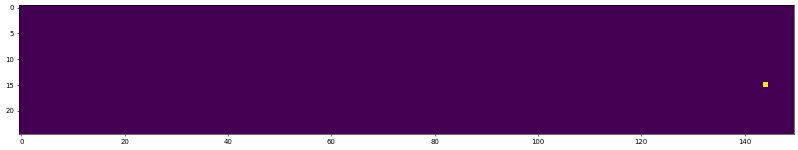

[357] {(114, 21)}


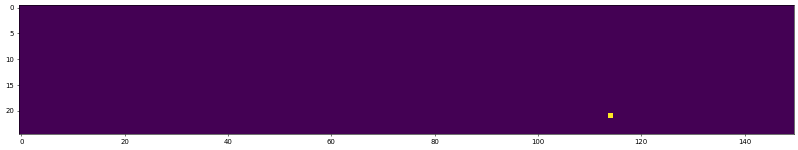

[361] {(113, 21)}


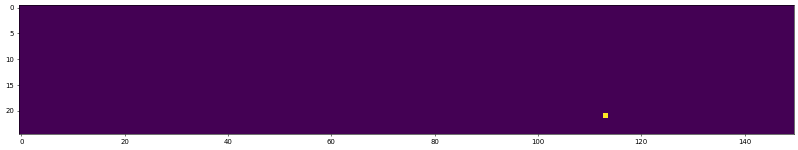

[440, 441, 442] {(45, 9), (46, 9), (44, 9)}


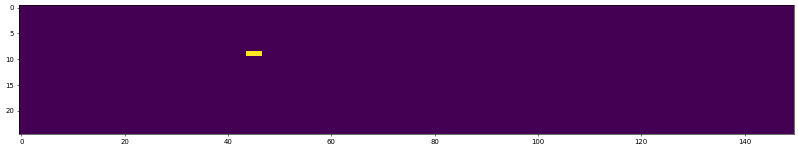

[446, 447, 450, 453, 454, 455, 458] {(25, 19), (104, 9), (88, 9), (24, 19), (89, 9), (105, 9), (106, 9), (90, 9), (26, 19), (88, 24), (89, 24)}


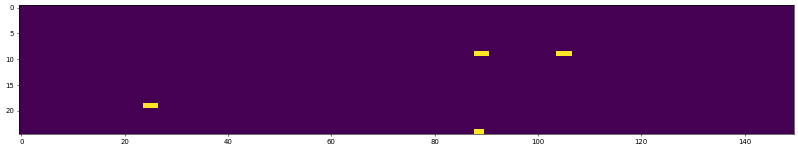

[475, 476, 478] {(128, 17), (37, 15), (36, 15)}


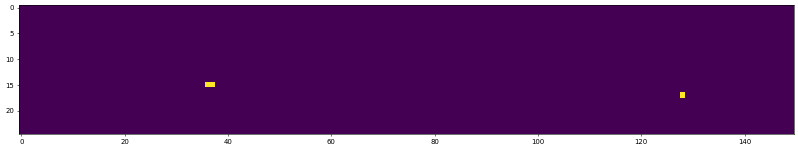

[490, 491, 492, 494, 495] {(79, 24), (80, 24), (81, 24), (77, 24), (82, 24), (78, 24)}


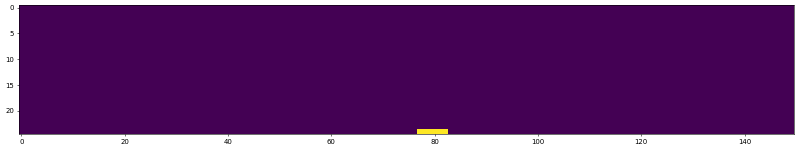

[533] {(124, 13)}


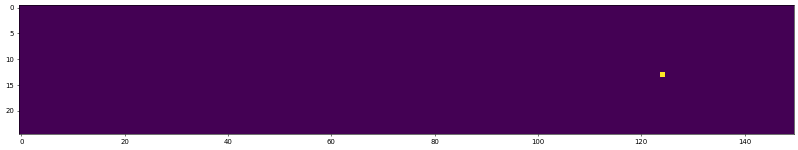

[537] {(125, 13)}


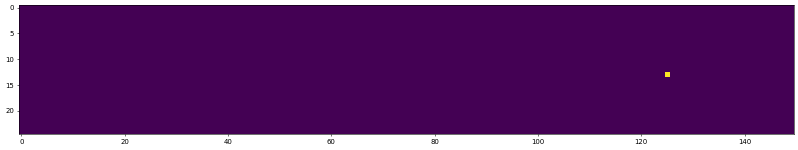

[547, 548] {(88, 10), (87, 10)}


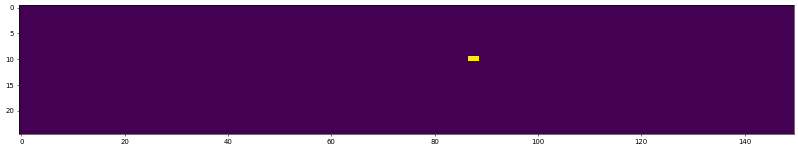

[559, 561] {(112, 1), (111, 1)}


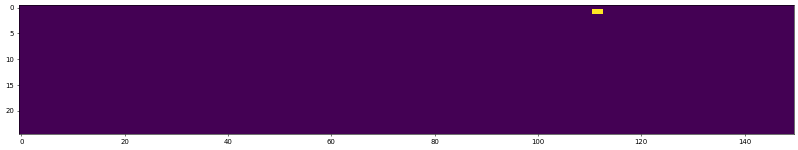

[602, 603, 605, 607, 610, 611] {(75, 10), (95, 4), (96, 4), (97, 4), (78, 10), (76, 10), (98, 4), (77, 10)}


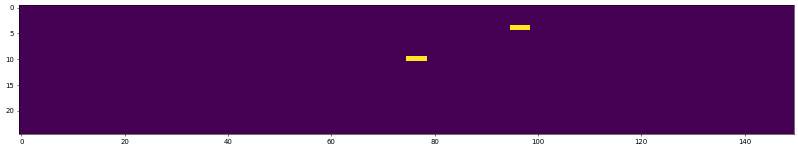

[619, 620, 621] {(45, 4), (46, 4), (47, 4)}


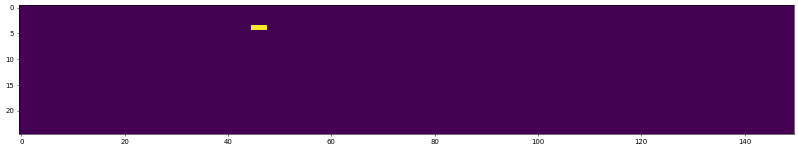

[657] {(24, 11)}


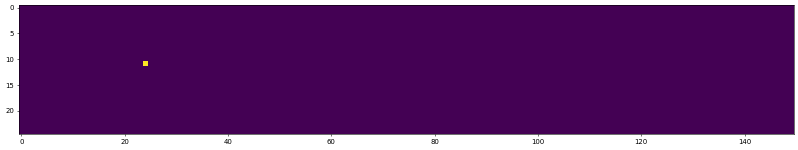

[679, 680] {(59, 14), (58, 14)}


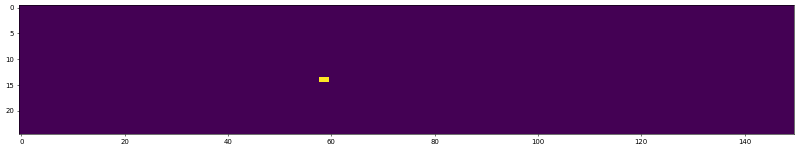

[766] {(51, 14)}


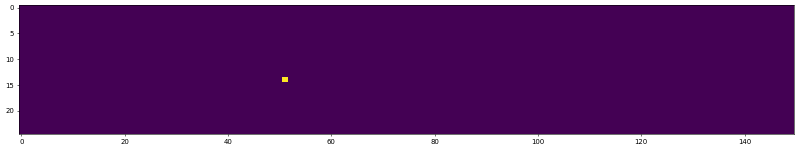

[810] {(0, 24)}


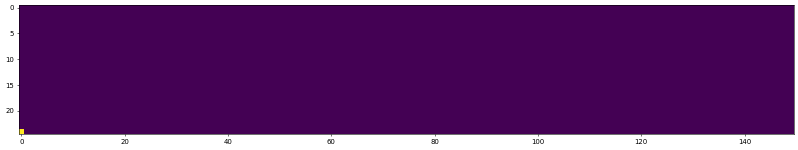

[819, 822, 825, 827] {(107, 5), (44, 2), (106, 5), (43, 2)}


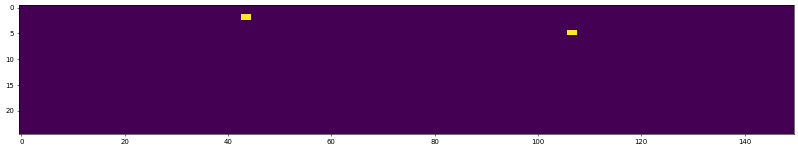

[834] {(125, 1), (123, 1), (124, 1)}


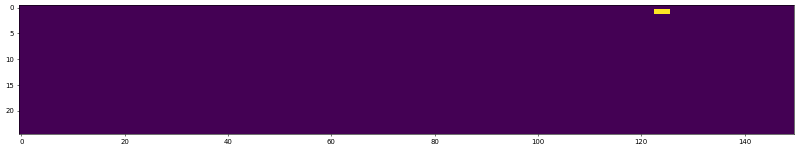

[848, 851] {(146, 19), (101, 5), (100, 5), (60, 17)}


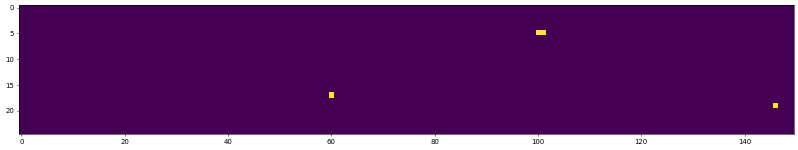

[864, 867] {(52, 17), (53, 17), (60, 17), (8, 2), (59, 17), (35, 24)}


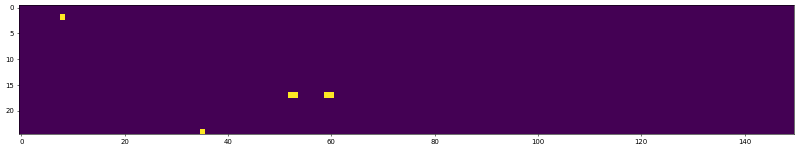

[887, 888] {(33, 20), (34, 20)}


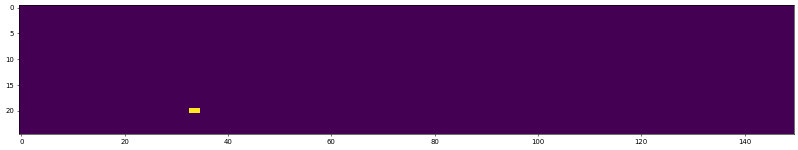

[1003, 1004] {(8, 18), (9, 18)}


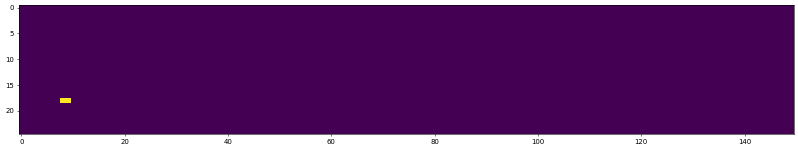

[1024] {(136, 13), (137, 13)}


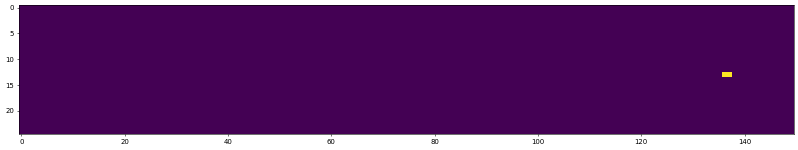

[1029, 1031] {(115, 11), (114, 11)}


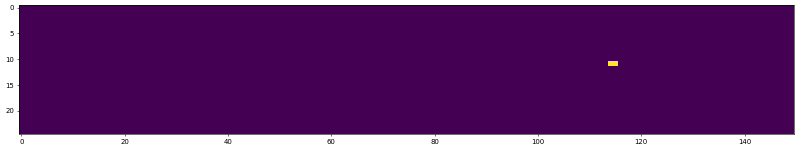

[1043, 1046, 1047] {(88, 5), (87, 5)}


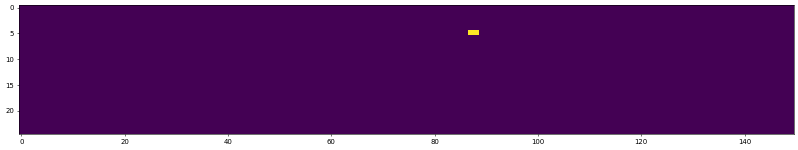

[1059] {(44, 22)}


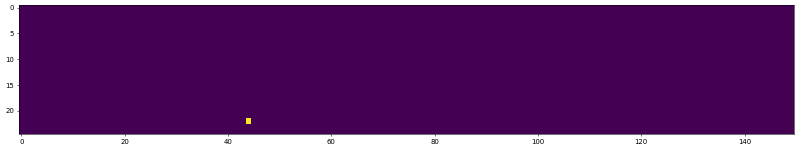

[1073] {(124, 22)}


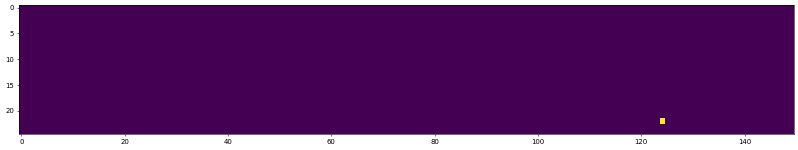

[1098, 1099, 1100] {(138, 6), (139, 6), (23, 12), (140, 6), (24, 12)}


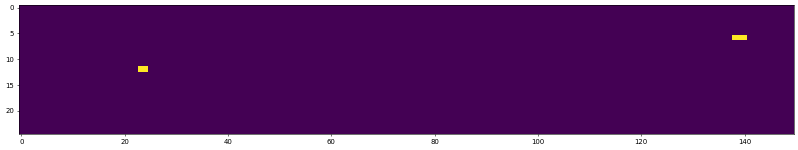

[1114] {(140, 21), (141, 21), (139, 21)}


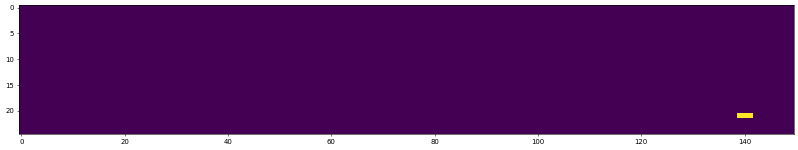

[1187] {(36, 21)}


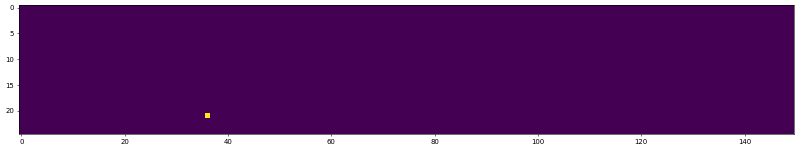

[1222, 1223] {(34, 4), (33, 4)}


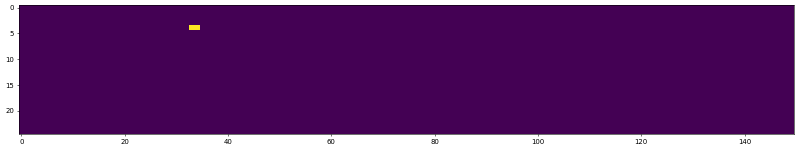

[1251] {(138, 20)}


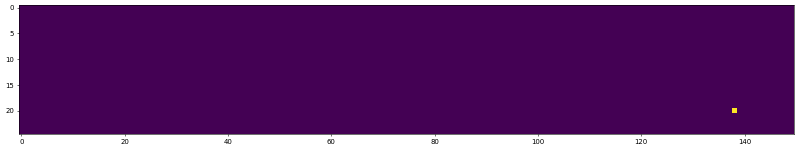

109 109 109
Muscle_map_150z25_60s_#33.npy
[1] {(75, 19)}


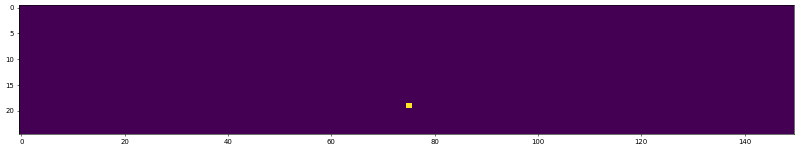

[40, 42, 45, 47, 48, 50, 51, 53, 55, 56, 58, 59] {(13, 14), (36, 24), (75, 3), (80, 3), (83, 3), (78, 3), (81, 3), (84, 3), (79, 3), (85, 3), (77, 3), (37, 24), (76, 3), (74, 3), (12, 14)}


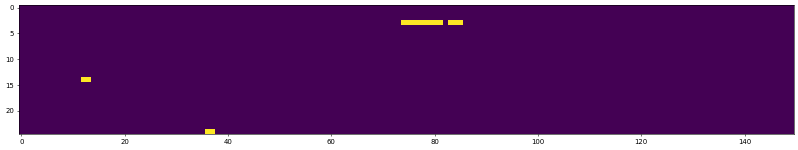

[95] {(120, 24), (121, 24)}


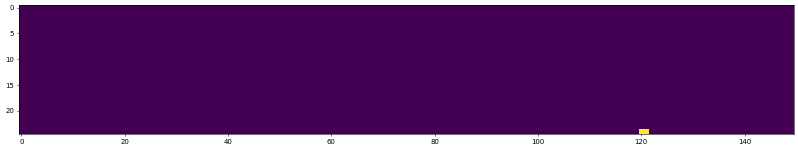

[128, 129, 132, 135] {(137, 10), (132, 0), (133, 0), (131, 0)}


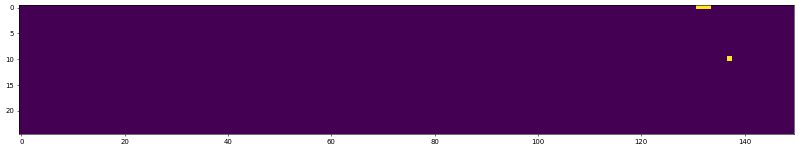

[176] {(94, 9)}


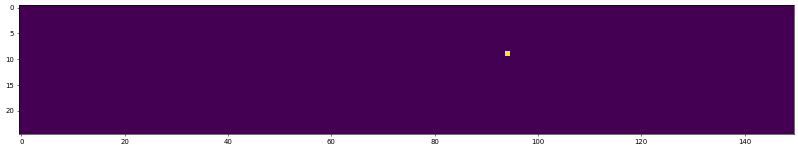

[212] {(38, 9)}


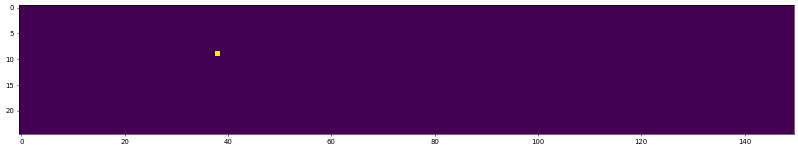

[255] {(79, 15)}


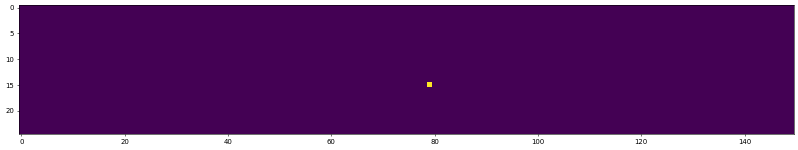

[304] {(104, 5)}


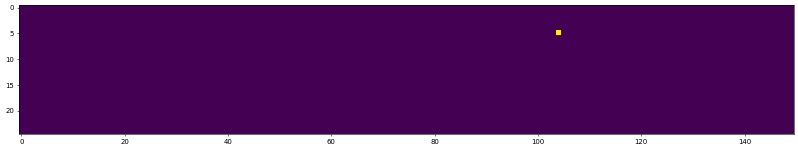

[362] {(149, 5)}


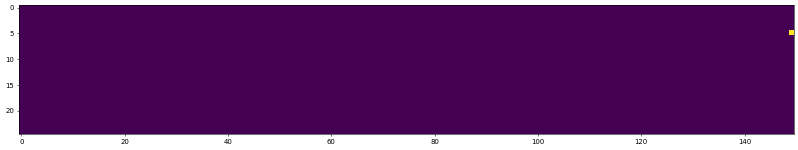

[384] {(81, 22)}


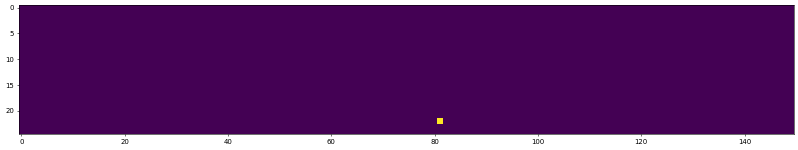

[429, 431] {(62, 14), (89, 17)}


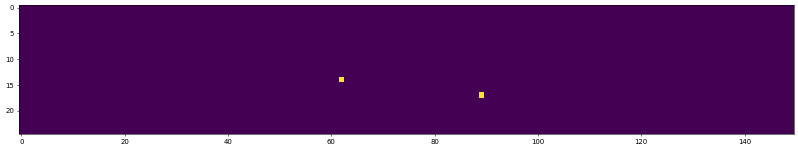

[459, 460] {(104, 23), (105, 23), (106, 23)}


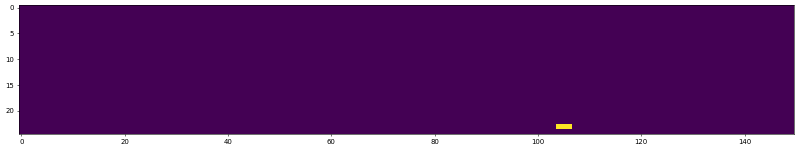

[465] {(135, 15), (136, 15)}


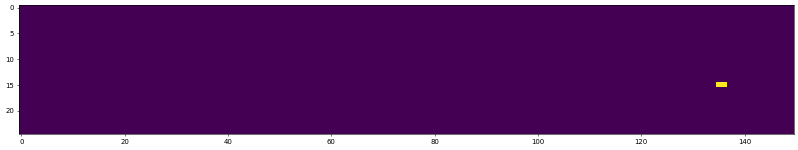

[507, 510] {(146, 14), (144, 14), (147, 14), (145, 14)}


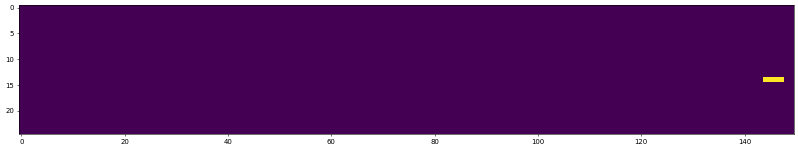

[534] {(32, 20), (33, 20), (31, 20)}


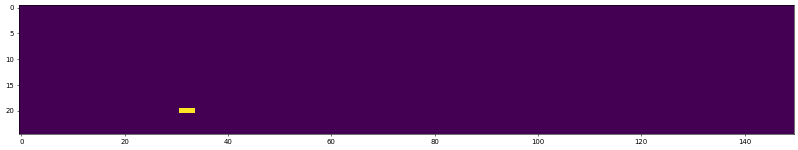

[570, 573, 574, 575] {(99, 5), (9, 11), (7, 11), (8, 11)}


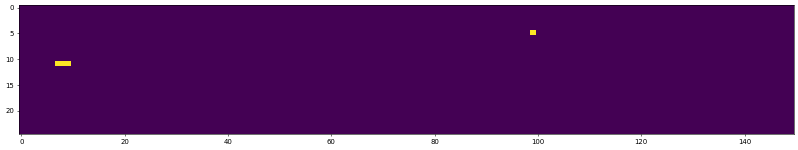

[583, 584] {(8, 11), (9, 11), (7, 11), (109, 4)}


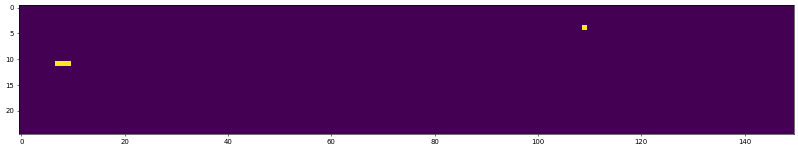

[588, 590, 591] {(105, 4), (106, 4), (107, 4), (102, 4), (103, 4), (108, 4), (109, 4), (104, 4)}


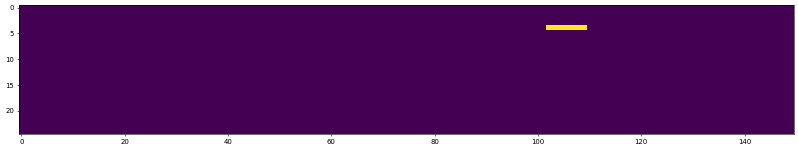

[618] {(95, 21), (96, 21)}


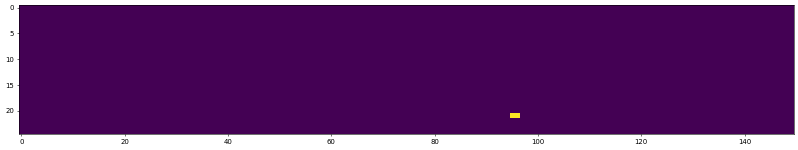

[633, 634, 636, 637, 638] {(95, 8), (96, 8), (33, 15), (94, 8), (34, 15), (35, 15), (36, 15)}


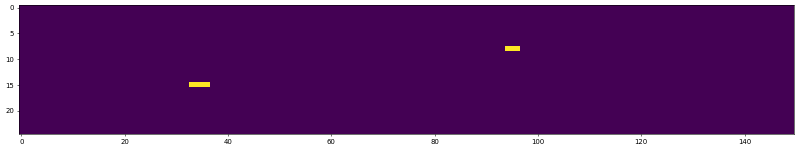

[655] {(47, 23)}


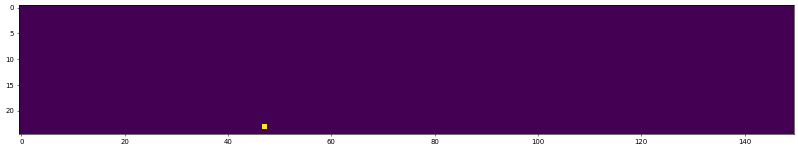

[685] {(37, 5)}


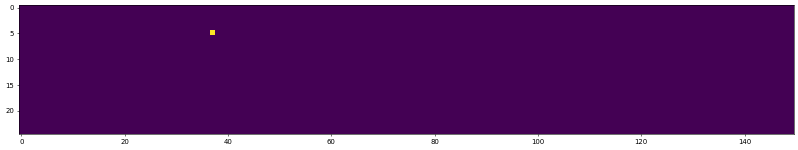

[707, 708, 709, 710, 711] {(84, 14), (85, 14), (86, 14), (81, 14), (82, 14), (83, 14)}


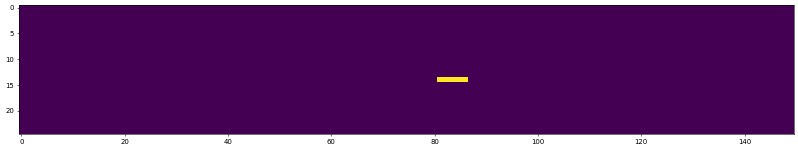

[728, 730, 732, 733] {(85, 11), (86, 11), (110, 11), (110, 14), (109, 11), (111, 11)}


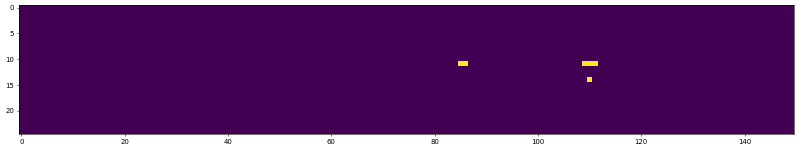

[762, 763] {(73, 19), (71, 19), (72, 19)}


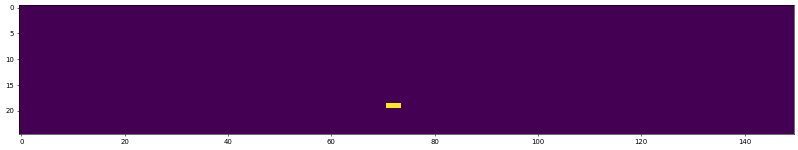

[789, 790] {(124, 15), (123, 15)}


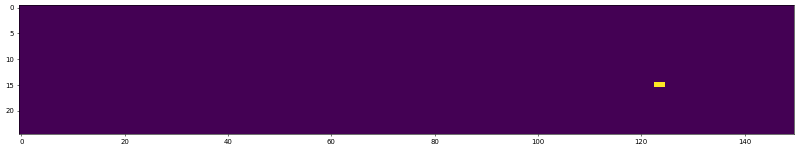

[801] {(107, 18)}


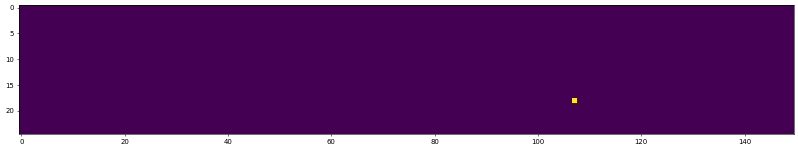

[828, 829] {(5, 2), (113, 8)}


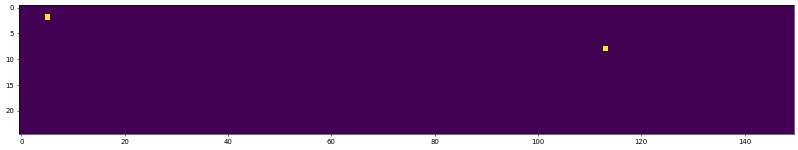

[835] {(15, 11)}


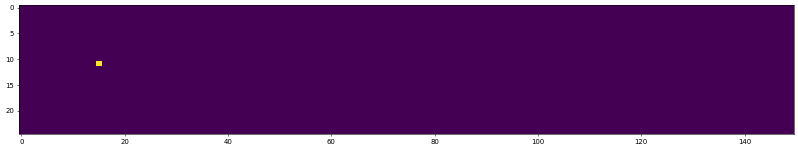

[903] {(118, 18)}


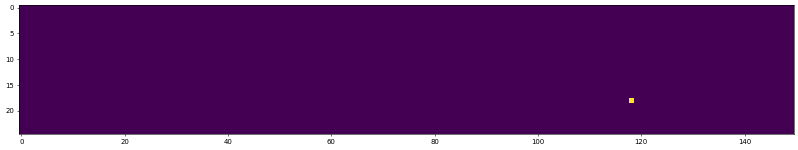

[908, 910, 912, 914] {(45, 5), (43, 5), (44, 5), (69, 4)}


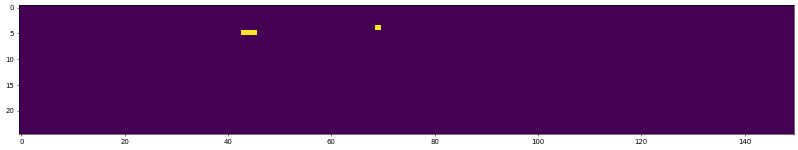

[934] {(36, 18), (34, 18), (37, 18), (35, 18)}


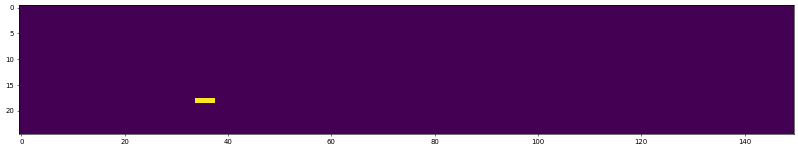

[941, 944] {(72, 5), (76, 5), (71, 5)}


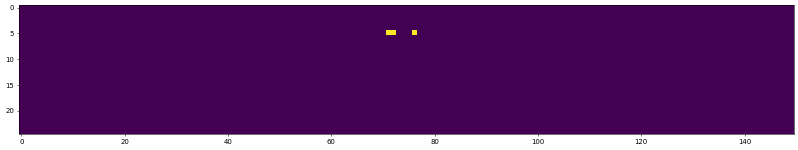

[954, 955, 956] {(140, 21), (81, 10), (82, 10), (141, 21)}


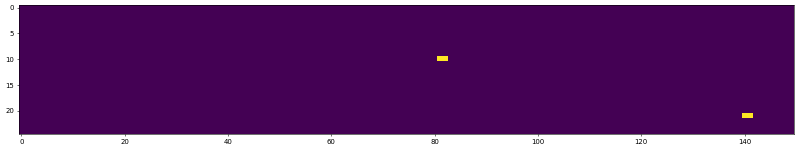

[984] {(89, 9), (88, 9), (40, 11), (41, 11)}


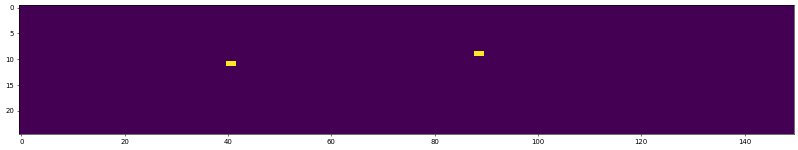

[1006, 1008, 1010] {(56, 13), (54, 13), (114, 20), (55, 13), (113, 20)}


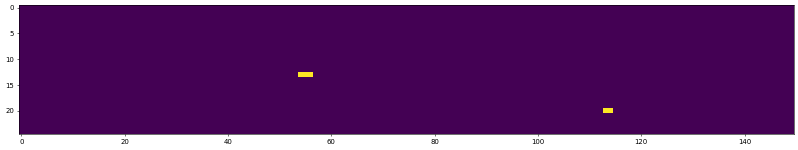

[1033, 1034, 1036, 1037, 1038, 1040, 1041, 1043, 1044, 1045, 1047, 1048, 1049] {(25, 13), (21, 13), (30, 13), (28, 13), (31, 13), (26, 13), (29, 13), (24, 13), (27, 13), (23, 13), (22, 13), (20, 13), (19, 13)}


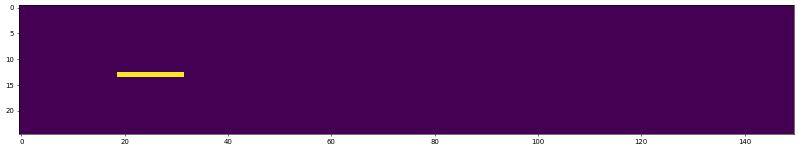

[1075, 1076, 1077, 1078] {(96, 23), (94, 23), (97, 23), (95, 23)}


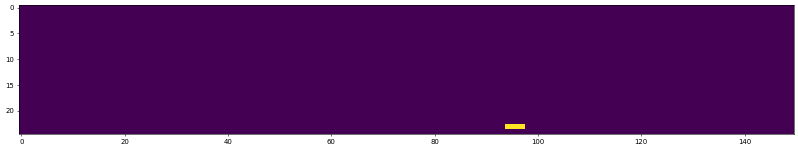

[1083, 1084, 1085] {(19, 24), (18, 24)}


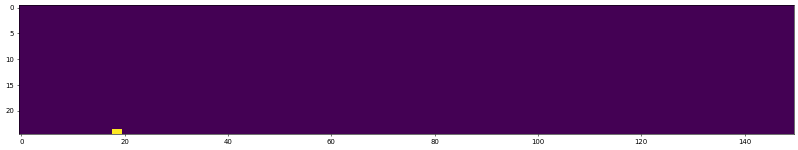

[1089, 1091, 1092, 1093, 1095] {(6, 12), (40, 1), (43, 1), (41, 1), (39, 1), (42, 1), (5, 12), (62, 1)}


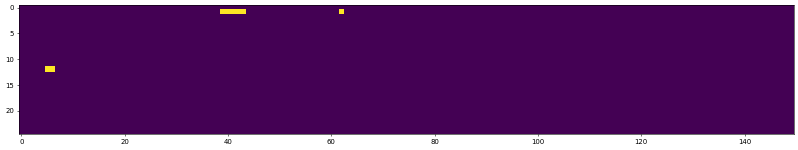

[1112, 1113] {(40, 14), (41, 14)}


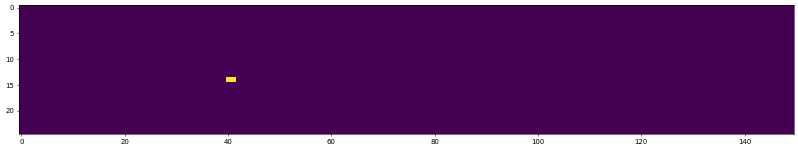

[1125, 1126, 1127, 1128] {(41, 8), (64, 6), (42, 8), (65, 6)}


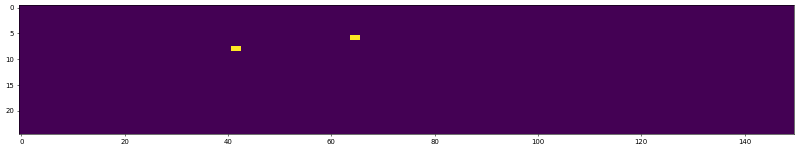

[1133, 1134, 1135] {(57, 10), (0, 21), (1, 21)}


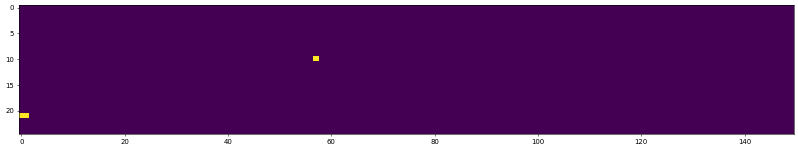

[1141, 1143] {(117, 23), (116, 23)}


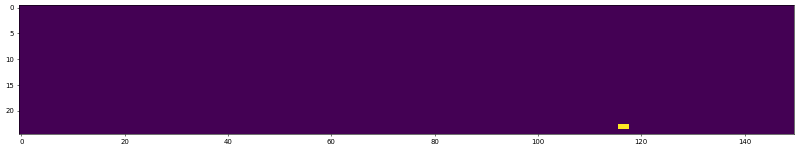

[1189] {(97, 14)}


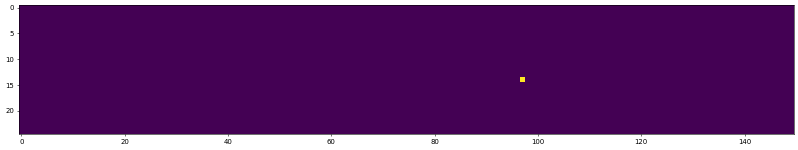

[1193] {(99, 14)}


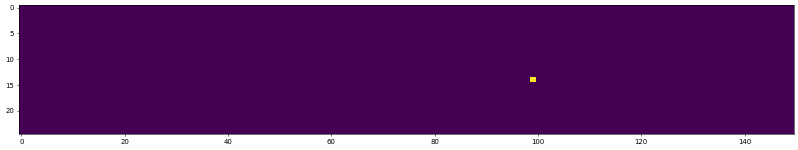

[1197] {(97, 14)}


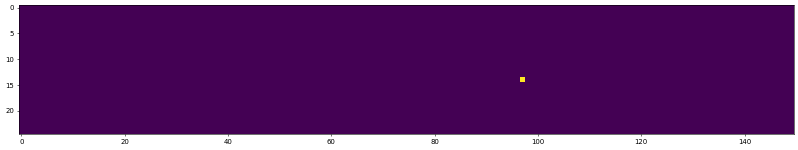

[1201, 1202, 1205, 1206, 1209, 1210] {(100, 14), (39, 12), (111, 4), (112, 4), (42, 12), (38, 12), (44, 12), (45, 12), (40, 12), (46, 12), (41, 12), (47, 12), (43, 12), (99, 14)}


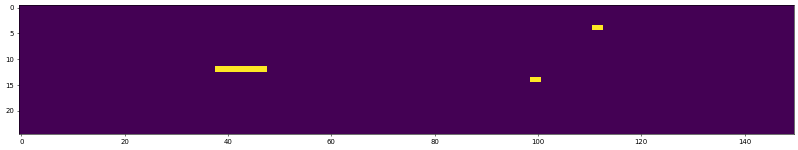

[1215] {(18, 9), (19, 9)}


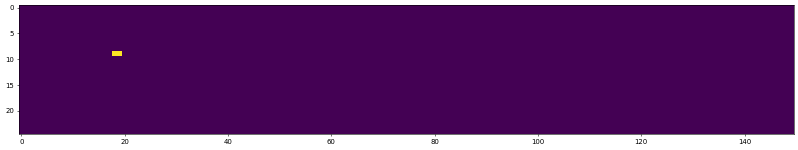

168 168 168
Kidney_map_150z25_60s_#51.npy
[42] {(140, 19)}


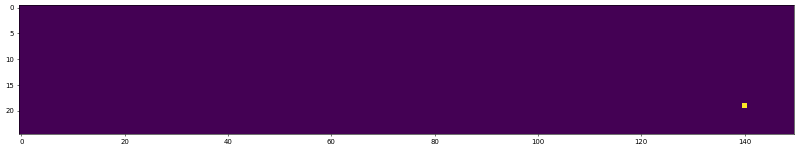

[47] {(141, 19)}


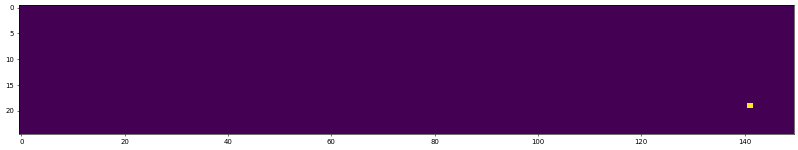

[52] {(142, 19)}


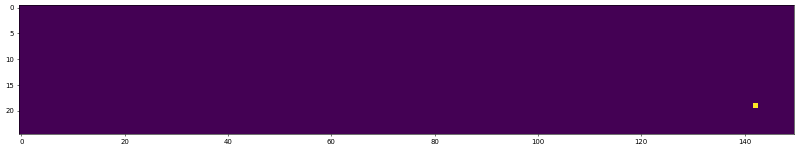

[95] {(136, 20)}


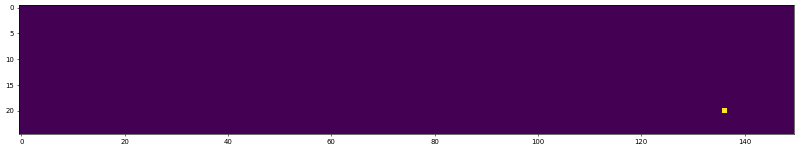

[173] {(96, 11), (97, 11)}


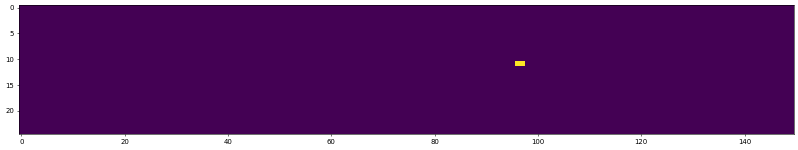

[255] {(142, 1)}


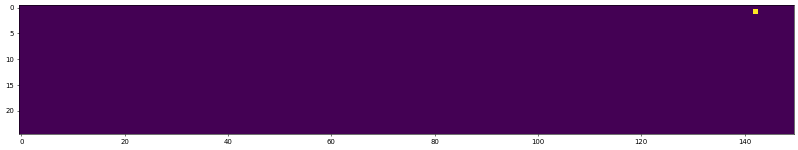

[263] {(147, 7)}


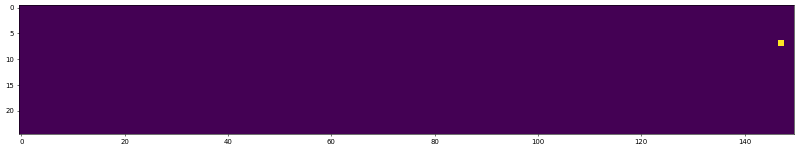

[298, 301, 304, 305, 307] {(57, 24), (139, 16), (22, 17), (140, 16), (56, 24)}


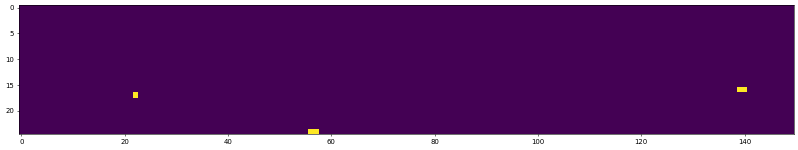

[311] {(141, 16)}


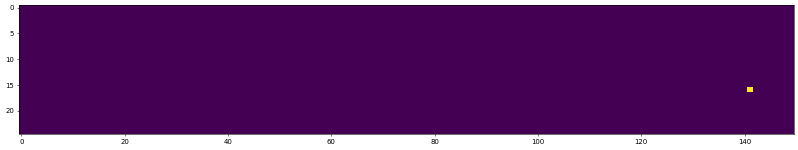

[317, 318, 321, 322, 324, 325] {(125, 23), (127, 23), (87, 0), (88, 0), (124, 23), (85, 0), (126, 23), (86, 0)}


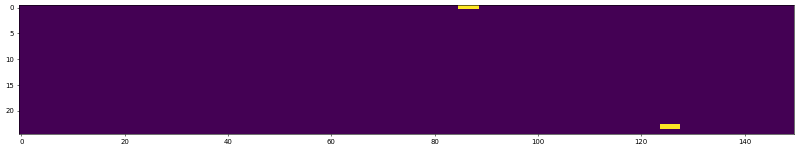

[335, 337, 338] {(137, 23), (138, 23), (139, 23), (140, 23), (136, 23)}


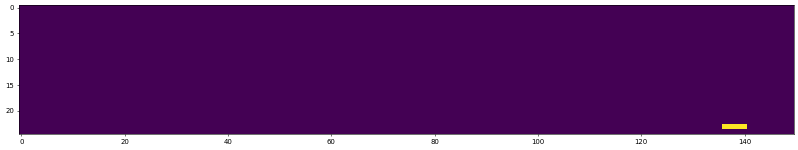

[348] {(52, 15)}


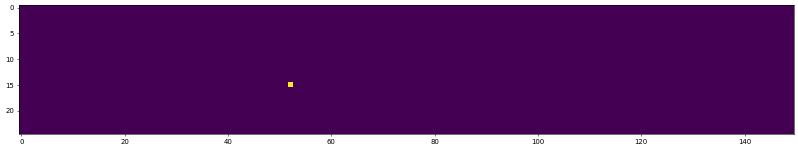

[448] {(144, 22)}


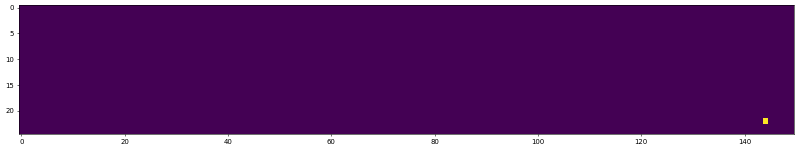

[452, 455] {(51, 21), (52, 21)}


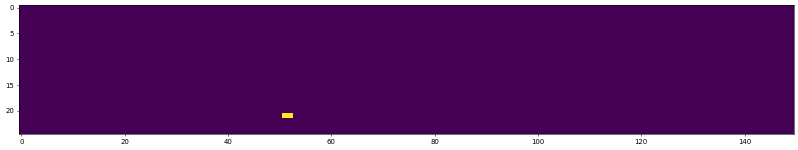

[464, 466] {(149, 15), (148, 15)}


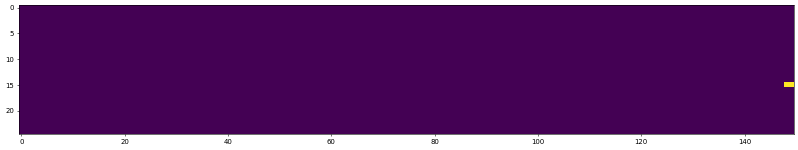

[479, 482] {(100, 14), (101, 14), (104, 14), (103, 14)}


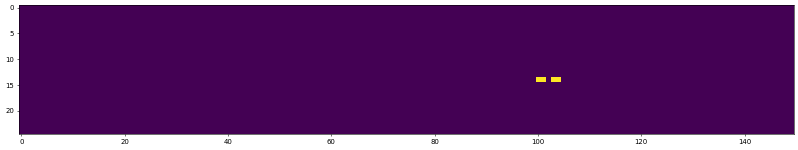

[499] {(141, 15)}


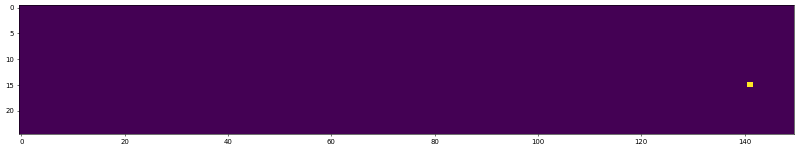

[506, 507] {(105, 8), (106, 8), (149, 15)}


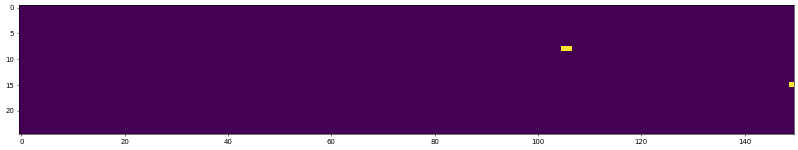

[538] {(85, 24)}


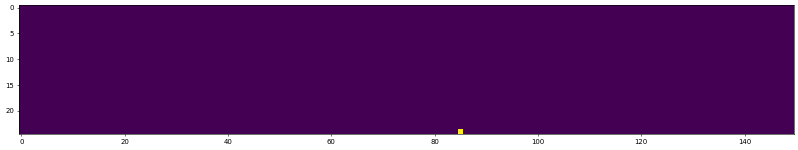

[542] {(88, 12)}


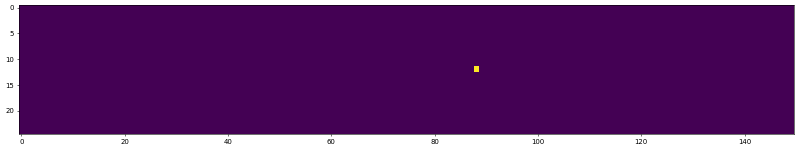

[605, 607] {(45, 4), (46, 4)}


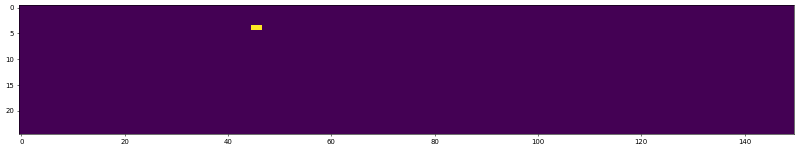

[701] {(97, 10)}


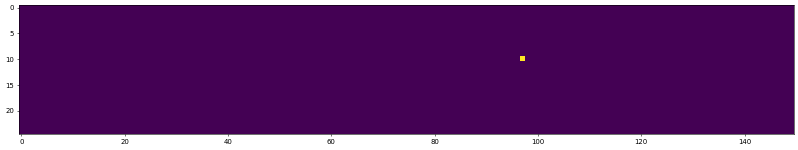

[727, 730, 732, 733, 734] {(137, 10), (99, 19), (122, 3), (98, 19)}


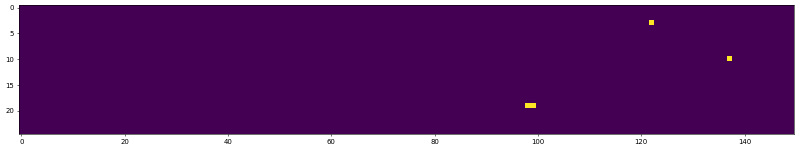

[738] {(98, 19)}


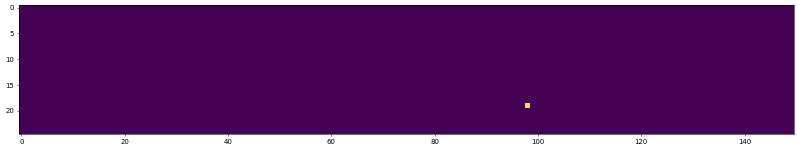

[772, 773, 775] {(136, 7), (107, 6), (135, 7)}


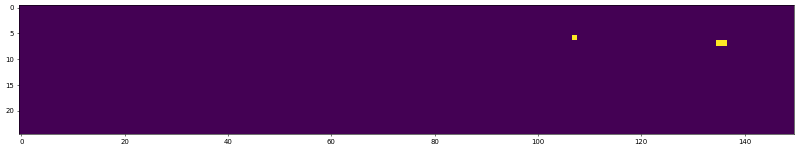

[779, 780] {(142, 22), (143, 22), (144, 22)}


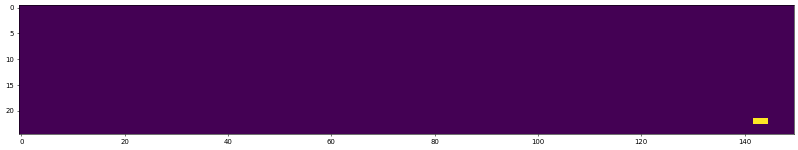

[786] {(58, 11)}


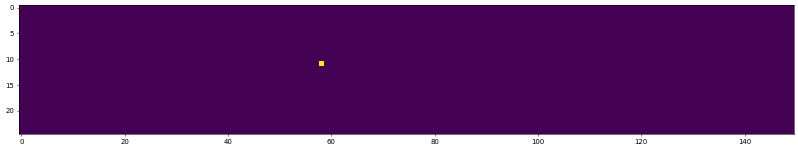

[800, 801, 803] {(68, 19), (99, 12), (67, 19)}


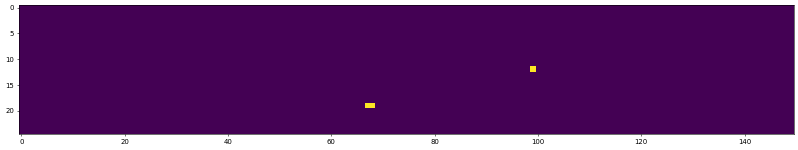

[810] {(49, 24), (48, 24)}


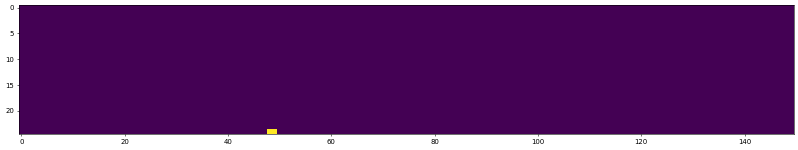

[824] {(99, 12)}


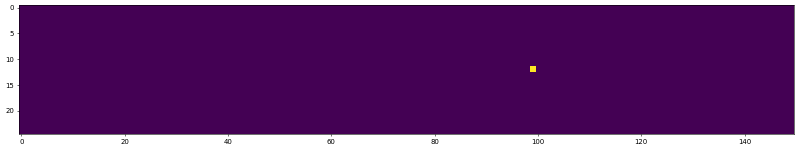

[880, 881] {(108, 4), (107, 4)}


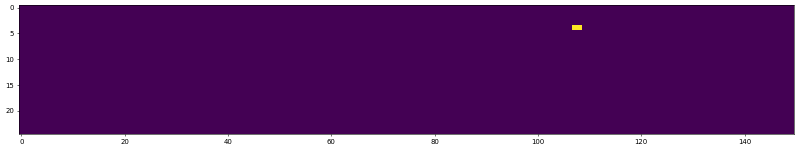

[905] {(39, 15)}


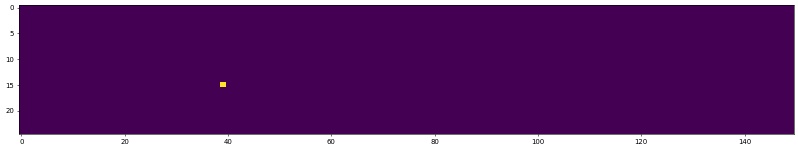

[932, 935] {(63, 2), (64, 2)}


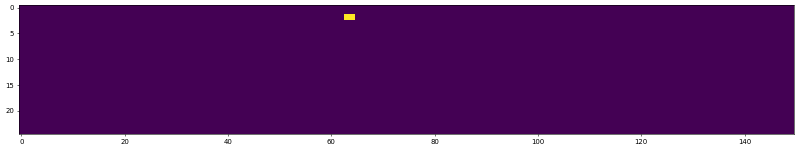

[952] {(100, 16), (101, 16)}


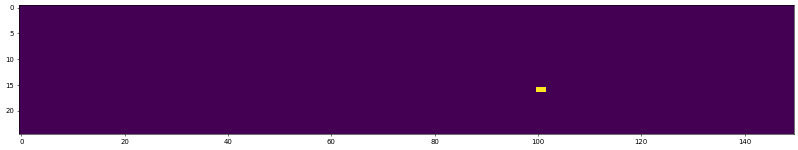

[959] {(45, 1)}


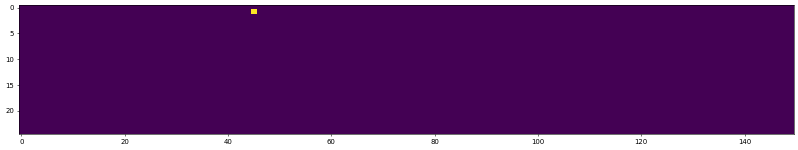

[967, 970] {(17, 2), (114, 12)}


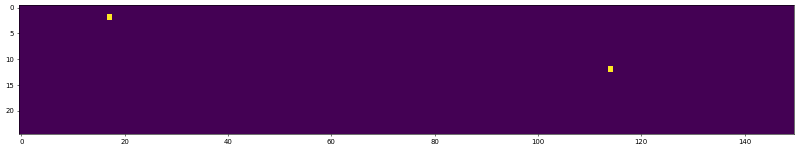

[983] {(122, 21), (123, 21)}


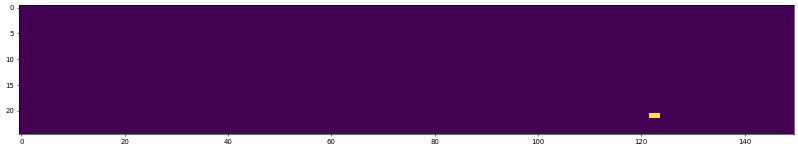

[990, 991, 994, 995, 996, 999, 1000, 1002] {(124, 21), (122, 21), (18, 3), (19, 3), (20, 3), (120, 21), (121, 21), (123, 21)}


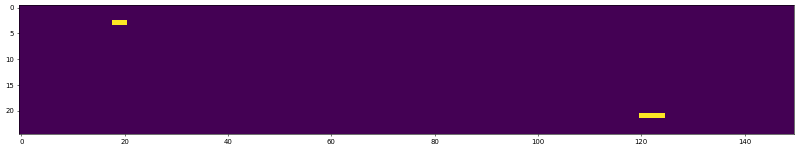

[1020] {(104, 11), (105, 11)}


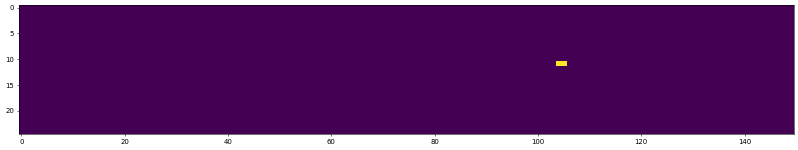

[1036] {(97, 4), (98, 4)}


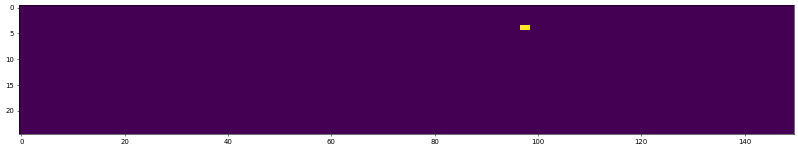

[1097, 1098, 1100, 1101, 1102] {(93, 24), (91, 24), (86, 24), (92, 24), (87, 24), (88, 24)}


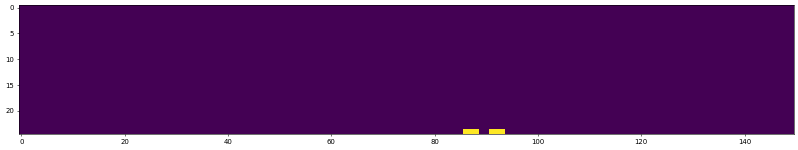

[1115, 1116] {(21, 9), (22, 9)}


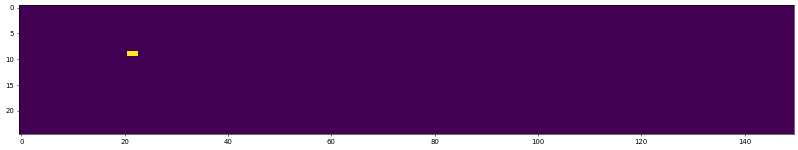

[1128] {(124, 12)}


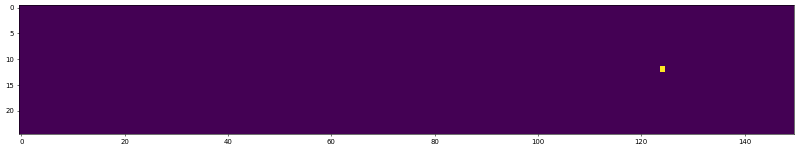

[1133] {(69, 6), (70, 6)}


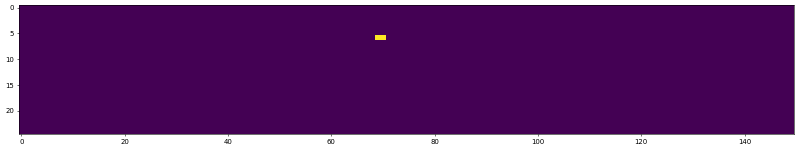

[1143, 1144] {(136, 18), (137, 18)}


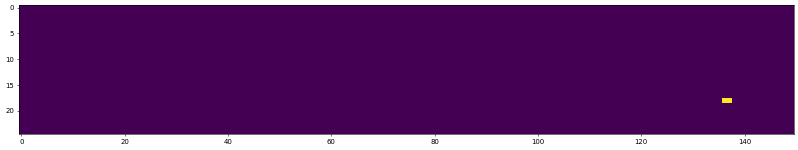

[1215, 1216, 1217, 1218] {(139, 17), (130, 7), (128, 7), (129, 7), (131, 7)}


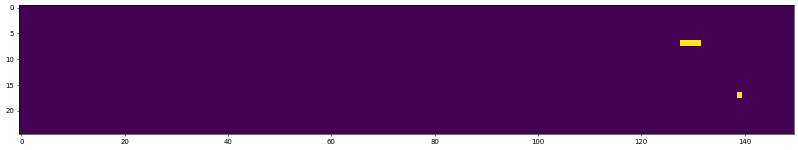

[1225] {(46, 2)}


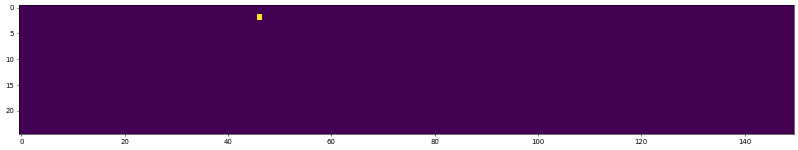

[1245] {(145, 5), (146, 5)}


KeyboardInterrupt: 

In [225]:
# plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 50

for i, img in enumerate(data):
    print(filenames[i])

    tmp = find_cosmic_ray_noise(img)
    tmp2 = find_cosmic_ray_noise_neighbourhood(img, tmp)

#     if both functions find cosmic ray noise then it is classified as noise.
    cosmic_ray_noise = {pixel:list(set(z).union(set(tmp2[pixel]))) for pixel, z in tmp.items() if pixel in tmp2}
    print(len(tmp), len(tmp2), len(cosmic_ray_noise))
#     img2, cosmic_ray_noise = correcting_4_cosmic_ray_noies(img, cosmic_ray_noise)
    continue
#     plot problem points
    print(len(cosmic_ray_noise))
    for (x,y), lst in cosmic_ray_noise.items():
        print(f"x,y = {x, y} cosmic ray wavenumbers {[wavenumbers[int(i)] for i in lst]}")
        for z in lst:
            plt.plot([z,z],[-1000,3000], alpha=0.1, color='k')
        plt.plot(img2[x,y])
        plt.plot(img[x,y], alpha=0.4)
        plt.grid(True, which='both')
        plt.xlim([0,len(wavenumbers)])
        locs, _ = plt.xticks()
        plt.xticks(locs, [wavenumbers[int(i)] if i < len(wavenumbers) else "" for i in locs])
        plt.xlim([0,len(wavenumbers)])
        plt.show()
    break

#     plot all points
#     for x in img2:
#         for y in x:
#             plt.plot(y)
#     plt.show()

#     np.save(f'{file_location2}{filenames[i].split("/")[-1].split(".")[0]}', img2) 
